# Reinforcement Learning to play Dino Run
I used reinfrocement learning to teach the model to control the dino agent from the Chrome's offline game, Dino Run, by detecting and jumping over obstacles. This project is inspired from the DeepMind's paper '[Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)' where the team tranied the model using reinforcement learning to play 7 Atari 2006 games


### This document mainly deals with code implementation of the project. To know more about the background and steps performed please refer my blog:<br> https://medium.com/acing-ai/how-i-build-an-ai-to-play-dino-run-e37f37bdf153

### All the code in this as well as any other document discussing this work is released under the MIT License https://opensource.org/licenses/MIT
### The writing in this as well as any other document linked with this project is released under The Creative Commons Attribution 3.0 License https://creativecommons.org/licenses/by/3.0/us/ 




### Dependencies
* Python 3.6
* Selenium
* OpenCV
* PIL
* Keras
* Chromium driver for Selenium

### Modifying the original game for faster learning on CPU only system
Original game is available as a part of Chromium's open source repository. We can modify the game under the BSD-style license(can be found in repository). Below are the configurations modified as a part of this project<br>
* ACCELERATION = 0 # speed of the agent stays constant throughout the gameplay
* TYPES OF OBSTACLES limit to 1, we have trained the model only for a single type of obstacle(cacuts) with fixed size
* GAME START TIME was reduced to around 400ms, originally each game would take 1 sec to start but reduced for faster learning
* JUMP VELOCITY was increased because when the dino is mid-air, there are no actions or features to be learned, so stays mid air for shorter period of time
* GAME OVER PANEL was removed as it is not a feautre to be learned, selenium interface is detect game over and restart
* HIGH SCORE PANEL was removed as we are not maintaning high score on the game panel
<br>


### Selnium as interface between the model and game
As the game is browser based and the model is built on python, we need some interface through which we can observe the game environment and send actions to agent to play the game. We use <strong>Selenium</strong> to control the browser and send actions to the agent. 


### OpenCV & PIL for Image capturing and pre-processing
To acquire the video of game play I have used PIL and openCV to capture & process sequential screenshot from the screen and then fed through the model for traning as well as playing

#### Imports

In [29]:
# !pip install pyscreenshot

In [30]:
# !pip install selenium

In [31]:
# !pip install opencv-python

In [1]:
!conda env list

# conda environments:
#
base                  *  /home/darshan_ubantu/anaconda3
dino                     /home/darshan_ubantu/anaconda3/envs/dino



In [2]:
# !activate /home/darshan_ubantu/anaconda3/envs/tf

In [3]:
# import tensorflow as tf
# print(tf.__version__)

In [4]:
# !deactivate

In [5]:
# !conda create --name tf_latest

In [6]:
# !activate /home/darshan_ubantu/anaconda3/envs/tf_latest

In [7]:
# !pip install --ignore-installed --upgrade tensorflow

In [8]:
# import tensorflow as tf
# print(tf.__version__)

In [9]:
# !pip install --upgrade pip

In [10]:
# !pip install tensorflow

In [11]:
# !pip install -U tensorflow

In [12]:
# !python -m pip show tensorflow                                    

In [13]:
# !activate /home/darshan_ubantu/anaconda3/envs/tensorflow

In [14]:
# !pip uninstall keras

In [15]:
# !pip install keras

In [16]:
# from tf.keras import models

In [17]:
# !activate /home/darshan_ubantu/anaconda3/envs/keras

In [18]:
# import tensorflow as tf
# import keras.models.model_from_json

In [19]:
# from tensorflow import keras

In [20]:
import os
print(os.environ["CONDA_PREFIX"])

/home/darshan_ubantu/anaconda3


In [21]:
!pip install pyscreenshot
!pip install opencv-python

In [22]:
import numpy as np
# from PIL import ImageGrab #grabbing image
import pyscreenshot as ImageGrab
from PIL import Image
import cv2 #opencv
import io
import time
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (30, 30)
import seaborn as sns
import pandas as pd
import numpy as np
from random import randint
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
#keras imports
%matplotlib inline 
from collections import deque
import random
import pickle
import json

In [23]:
np.__version__

'1.20.3'

In [24]:
# import tensorflow.keras as krs
# from tensorflow.keras.models import model_from_json
# from tf.keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD , Adam
from keras.callbacks import TensorBoard

2022-01-15 17:29:20.039298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/darshan_ubantu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-01-15 17:29:20.039340: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Path variables
We have two external dependencies
* The modifed version of the game(web app) 
* The executable of chromewebdriver for selenium. This is not included in the repo as it is system dependent, it needs to placed one level above the project folder
* path to log files

In [25]:
# !pip install webdriver-manager

In [26]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

# driver = webdriver.Chrome(ChromeDriverManager().install())

### Game Module
This is the main module that implements interfacing between the python and browser-javascript using selenium


In [27]:
'''
* Game class: Selenium interfacing between the python and browser
* __init__():  Launch the broswer window using the attributes in chrome_options
* get_crashed() : return true if the agent as crashed on an obstacles. Gets javascript variable from game decribing the state
* get_playing(): true if game in progress, false is crashed or paused
* restart() : sends a signal to browser-javascript to restart the game
* press_up(): sends a single to press up get to the browser
* get_score(): gets current game score from javascript variables.
* pause(): pause the game
* resume(): resume a paused game if not crashed
* end(): close the browser and end the game
'''
class Game:
    def __init__(self,custom_config=True):
        chrome_options = Options()
        chrome_options.add_argument("disable-infobars")
        self._driver = webdriver.Chrome(executable_path = chrome_driver_path,chrome_options=chrome_options)
#         self._driver = webdriver.Chrome(ChromeDriverManager().install(),chrome_options=chrome_options)
        self._driver.set_window_position(x=-10,y=0)
        self._driver.set_window_size(200, 300)
#         self._driver.get(os.path.abspath(game_url))
        self._driver.get(game_url)
        #modifying game before trainNetworkining
        if custom_config:
            self._driver.execute_script("Runner.config.ACCELERATION=0")
    def get_crashed(self):
        return self._driver.execute_script("return Runner.instance_.crashed")
    def get_playing(self):
        return self._driver.execute_script("return Runner.instance_.playing")
    def restart(self):
        self._driver.execute_script("Runner.instance_.restart()")
        
        time.sleep(0.25)# no actions are possible 
                        # for 0.25 sec after game starts, 
                        # skip learning at this time and make the model wait
    def press_up(self):
        self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)
    def get_score(self):
        score_array = self._driver.execute_script("return Runner.instance_.distanceMeter.digits")
        score = ''.join(score_array) # the javascript object is of type array with score in the formate[1,0,0] which is 100.
        return int(score)
    def pause(self):
        return self._driver.execute_script("return Runner.instance_.stop()")
    def resume(self):
        return self._driver.execute_script("return Runner.instance_.play()")
    def end(self):
        self._driver.close()

### Agent module
This model represent the agent (Dino) which the model controls for playing. 

In [28]:
class DinoAgent:
    def __init__(self,game): #takes game as input for taking actions
        self._game = game; 
        self.jump(); #to start the game, we need to jump once
        time.sleep(.5) # no action can be performed for the first time when game starts
    def is_running(self):
        return self._game.get_playing()
    def is_crashed(self):
        return self._game.get_crashed()
    def jump(self):
        self._game.press_up()
    def duck(self):
        self._game.press_down()

In [29]:
#path variables
# game_url = "./game/dino.html"
# game_url = "file:///home/darshan_ubantu/Downloads/Chrome-Dino-Reinforcement-Learning-20220111T073920Z-001/Chrome-Dino-Reinforcement-Learning/game/dino.html"
game_url = "file:///home/darshan_ubantu/Downloads/Chrome-Dino-Reinforcement-Learning-20220111T073920Z-001/Chrome-Dino-Reinforcement-Learning/game/dino.html"
# chrome_driver_path = "../chromedriver.exe"
# chrome_driver_path = "usr/bin/chromedriver"
chrome_driver_path = "./chromedriver"
# chrome_driver_path = "/home/somayaji/.wdm/drivers/chromedriver/linux64/96.0.4664.45"
loss_file_path = "./objects/loss_df.csv"
actions_file_path = "./objects/actions_df.csv"
scores_file_path = "./objects/scores_df.csv"

### Game state module
Game state helps to get the current state of the game environment as well as the agent.<br>
Actions are performed by this model before getting a new state

In [30]:
class Game_sate:
    def __init__(self,agent,game):
        self._agent = agent
        self._game = game
        self._display = show_img() #display the processed image on screen using openCV, implemented using python coroutine 
        self._display.__next__() # initiliaze the display coroutine 
    def get_state(self,actions):
#         print(actions.shape)
        actions_df.loc[len(actions_df)] = (actions[1]).astype('float') # storing actions in a dataframe
#         actions_df.append(actions[1], ignore_index = True)
        score = self._game.get_score() 
        reward = 0.1*score/10 # dynamic reward calculation
        is_over = False #game over
        if actions[1] == 1:
            self._agent.jump()
            reward = 0.1*score/11
        image = grab_screen() 
        self._display.send(image) #display the image on screen

        if self._agent.is_crashed():
            scores_df.loc[len(loss_df)] = score # log the score when game is over
#             scores_df.append(score, ignore_index = True) # log the score when game is over
            self._game.restart()
            reward = -11/score
            is_over = True
        return image, reward, is_over #return the Experience tuple

### Utilities

* save_obj() and load_obj(): As the training can takes a week, we will need to presever the state of the game in the file system. We dump required objects using pickle module of python
* grab_screen() : using PIL library to capture the screen and bbox for locating the region of interest<sup>+</sup>
* process_img(): performing necessary image transformations before sending it to the model<sup>+</sup><br>
* show_img(): coroutine implementation to observe the images that are being sent to the model <sup>*</sup><br>

<sup>+</sup>The image processing modules were inspired from Harrison Sentdex's github which is licensed under the GNU GENERAL PUBLIC LICENSE http://www.gnu.org/licenses/gpl.html<br>
<sup>*</sup>Coroutine implementation in the code below belongs to Ben Meijering and is licensed under the MIT License https://opensource.org/licenses/MIT

In [31]:
def save_obj(obj, name ):
    with open('objects/'+ name + '.pkl', 'wb') as f: #dump files into objects folder
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def grab_screen(_driver = None):
    screen =  np.array(ImageGrab.grab(bbox=(40,180,440,400))) #bbox = region of interset on the entire screen
    image = process_img(screen)#processing image as required
    return image

def process_img(image):
    #game is already in grey scale canvas, canny to get only edges and reduce unwanted objects(clouds)
    image = cv2.resize(image, (0,0), fx = 0.15, fy = 0.10) # resale image dimensions
    image = image[2:38,10:50] #img[y:y+h, x:x+w] #crop out the dino agent from the frame
    image = cv2.Canny(image, threshold1 = 100, threshold2 = 200) #apply the canny edge detection
    return  image
def show_img(graphs = False):
    """
    Show images in new window
    """
    while True:
        screen = (yield)
        window_title = "logs" if graphs else "game_play"
        cv2.namedWindow(window_title, cv2.WINDOW_NORMAL)        
        imS = cv2.resize(screen, (800, 400)) 
        cv2.imshow(window_title, screen)
        if (cv2.waitKey(1) & 0xFF == ord('q')):
            cv2.destroyAllWindows()
            break

### Intialize log structures

In [32]:
#Intialize log structures from file if exists else create new
loss_df = pd.read_csv(loss_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns =['loss'])
scores_df = pd.read_csv(scores_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns = ['scores'])
actions_df = pd.read_csv(actions_file_path) if os.path.isfile(actions_file_path) else pd.DataFrame(columns = ['actions'])

In [33]:
# training variables saved as checkpoints to filesystem to resume training from the same step
def init_cache():
    """initial variable caching, done only once"""
    save_obj(INITIAL_EPSILON,"epsilon")
    t = 0
    save_obj(t,"time")
    D = deque()
    save_obj(D,"D")

#### Module parameters

In [34]:
#game parameters
ACTIONS = 2 # possible actions: jump, do nothing
GAMMA = 0.99 # decay rate of past observations original 0.99
OBSERVATION = 50000. # timesteps to observe before training
EXPLORE = 100000  # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4
img_rows , img_cols = 40,20
img_channels = 4 #We stack 4 frames

### Building the model

* The input to our model is a tensor: 4 stacked images of dimension of 40x20 = 40x20x4 <br>
* Each action has it's own output (2 outputs) : The q_value for each action

The model architecture is referred from the DeepMind paper https://arxiv.org/abs/1312.5602 <br>
The implementation is inspired from _Using Keras and Deep Q-Network to Play FlappyBird_ https://github.com/yanpanlau/Keras-FlappyBird and available publicly for use

In [35]:
from keras.models import Sequential

In [36]:
def buildmodel():
    print("Now we build the model")
    model = Sequential()
    model.add(Conv2D(32, (8, 8), strides=(4, 4), padding='same',input_shape=(img_cols,img_rows,img_channels)))  #20*40*4
    model.add(Activation('relu'))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(ACTIONS))
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    print("We finish building the model")
    return model

### Mode Architecture

In [37]:
buildmodel().summary()

Now we build the model
We finish building the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 10, 32)         8224      
                                                                 
 activation (Activation)     (None, 5, 10, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 5, 64)          32832     
                                                                 
 activation_1 (Activation)   (None, 3, 5, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 5, 64)          36928     
                                                                 
 activation_2 (Activation)   (None, 3, 5, 64)          0         
                                                                 
 fla

2022-01-15 17:29:27.165181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 17:29:27.165950: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/darshan_ubantu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-01-15 17:29:27.166032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/darshan_ubantu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-01-15 17:29:27.166096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.

### Main Training Module
#### Alogrithm for Deep QNN

##### The Model code was inspired from the Flappy Bird implementation of reinforcement learning in Pygame.<br>
#### The original content belongs to [Ben Lau](https://github.com/yanpanlau/Keras-FlappyBird) and is publicly availabe on github

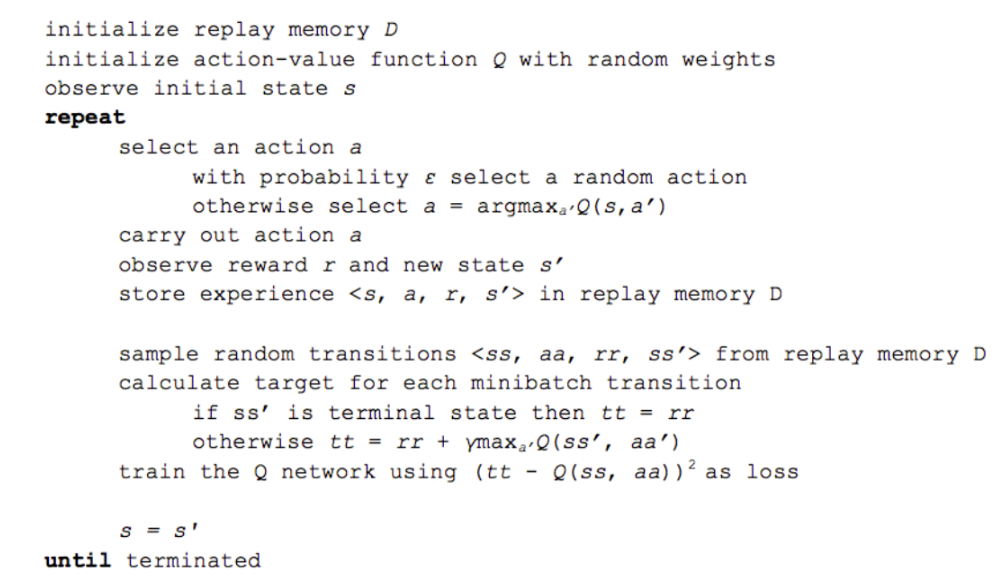

In [38]:
''' 
main training module
Parameters:
* model => Keras Model to be trained
* game_state => Game State module with access to game environment and dino
* observe => flag to indicate wherther the model is to be trained(weight updates), else just play
'''
def trainNetwork(model,game_state,observe=False):
    last_time = time.time()
    # store the previous observations in replay memory
    D = load_obj("D") #load from file system
    # get the first state by doing nothing
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] =1 #0 => do nothing,
                     #1=> jump
    
    x_t, r_0, terminal = game_state.get_state(do_nothing) # get next step after performing the action
    

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2) # stack 4 images to create placeholder input
    

    
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*20*40*4
    
    initial_state = s_t 

    if observe :
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model_final.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = load_obj("epsilon") 
        model.load_weights("model_final.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)

    t = load_obj("time") # resume from the previous time step stored in file system
    while (True): #endless running
        
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0 #reward at 4
        a_t = np.zeros([ACTIONS]) # action at t
        
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0: #parameter to skip frames for actions
            if  random.random() <= epsilon: #randomly explore an action
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[0] = 1
            else: # predict the output
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)         # chosing index with maximum q value
                action_index = max_Q 
                a_t[action_index] = 1        # o=> do nothing, 1=> jump
                
        #We reduced the epsilon (exploration parameter) gradually
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE 

        #run the selected action and observed next state and reward
        x_t1, r_t, terminal = game_state.get_state(a_t)
        print('loop took {} seconds'.format(time.time()-last_time)) # helpful for measuring frame rate
        last_time = time.time()
        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x20x40x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3) # append the new image to input stack and remove the first one
        
        
        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE: 
            
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)
            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 20, 40, 4
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)):
                state_t = minibatch[i][0]    # 4D stack of images
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]   #reward at state_t due to action_t
                state_t1 = minibatch[i][3]   #next state
                terminal = minibatch[i][4]   #wheather the agent died or survided due the action
                

                inputs[i:i + 1] = state_t    

                targets[i] = model.predict(state_t)  # predicted q values
                Q_sa = model.predict(state_t1)      #predict q values for next step
                
                if terminal:
                    targets[i, action_t] = reward_t # if terminated, only equals reward
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)

            loss += model.train_on_batch(inputs, targets)
            loss_df.loc[len(loss_df)] = loss
        else:
            # artificial time delay as training done with this delay
            time.sleep(0.12)
        s_t = initial_state if terminal else s_t1 #reset game to initial frame if terminate
        t = t + 1
        
        # save progress every 1000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            
            model.save_weights("model_final.h5", overwrite=True)
            save_obj(D,"D") #saving episodes
            save_obj(t,"time") #caching time steps
            save_obj(epsilon,"epsilon") #cache epsilon to avoid repeated randomness in actions
            loss_df.to_csv("./objects/loss_df.csv",index=False)
            scores_df.to_csv("./objects/scores_df.csv",index=False)
            actions_df.to_csv("./objects/actions_df.csv",index=False)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state,             "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t,             "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")


### main function
* initialize game module, launches browser
* initialize the agent module
* initialize the game state module
* build the keras model
* start the training loop

In [39]:
def playGame(observe=False):
    game = Game()
    dino = DinoAgent(game)
    game_state = Game_sate(dino,game)
    model = buildmodel()
    try:
        trainNetwork(model,game_state,observe=observe)
    except StopIteration:
        game.end()

In [40]:
init_cache()

In [41]:
import numpy as np
print(np.__version__)

1.20.3


In [42]:
# !conda update pandas

In [43]:
# !conda update numpy

In [44]:
# import pandas as pd
# !conda list | grep pandas

In [ ]:
playGame(observe=False);

/tmp/ipykernel_10286/4231811197.py:17: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self._driver = webdriver.Chrome(executable_path = chrome_driver_path,chrome_options=chrome_options)
/tmp/ipykernel_10286/4231811197.py:17: DeprecationWarning: use options instead of chrome_options
  self._driver = webdriver.Chrome(executable_path = chrome_driver_path,chrome_options=chrome_options)
/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


Now we build the model
We finish building the model


QObject::moveToThread: Current thread (0x5570bc4b3680) is not the object's thread (0x5570bc2ca5e0).
Cannot move to target thread (0x5570bc4b3680)

QObject::moveToThread: Current thread (0x5570bc4b3680) is not the object's thread (0x5570bc2ca5e0).
Cannot move to target thread (0x5570bc4b3680)

QObject::moveToThread: Current thread (0x5570bc4b3680) is not the object's thread (0x5570bc2ca5e0).
Cannot move to target thread (0x5570bc4b3680)

QObject::moveToThread: Current thread (0x5570bc4b3680) is not the object's thread (0x5570bc2ca5e0).
Cannot move to target thread (0x5570bc4b3680)

QObject::moveToThread: Current thread (0x5570bc4b3680) is not the object's thread (0x5570bc2ca5e0).
Cannot move to target thread (0x5570bc4b3680)

QObject::moveToThread: Current thread (0x5570bc4b3680) is not the object's thread (0x5570bc2ca5e0).
Cannot move to target thread (0x5570bc4b3680)

QObject::moveToThread: Current thread (0x5570bc4b3680) is not the object's thread (0x5570bc2ca5e0).
Cannot move to tar

/home/darshan_ubantu/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


loop took 8.777478694915771 seconds
TIMESTEP 1 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5337352752685547 seconds
TIMESTEP 2 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5358736515045166 seconds
TIMESTEP 3 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.49619078636169434 seconds
TIMESTEP 4 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5654633045196533 seconds
TIMESTEP 5 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5025074481964111 seconds
TIMESTEP 6 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5876762866973877 seconds
TIMESTEP 7 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5161819458007812 seconds
TIMESTEP 8 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5765633583068848 seconds
TIMESTEP 9 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5982921123504639 seconds
TIMESTEP 10 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5078229904174805 seconds
TIMESTEP 11 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5674605369567871 seconds
TIMESTEP 12 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5436654090881348 seconds
TIMESTEP 13 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5332274436950684 seconds
TIMESTEP 14 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.4834270477294922 seconds
TIMESTEP 15 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5751419067382812 seconds
TIMESTEP 16 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5365087985992432 seconds
TIMESTEP 17 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5628256797790527 seconds
TIMESTEP 18 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5502595901489258 seconds
TIMESTEP 19 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5462384223937988 seconds
TIMESTEP 20 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46630334854125977 seconds
TIMESTEP 21 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5763087272644043 seconds
TIMESTEP 22 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5375263690948486 seconds
TIMESTEP 23 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5698347091674805 seconds
TIMESTEP 24 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5651211738586426 seconds
TIMESTEP 25 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.516146183013916 seconds
TIMESTEP 26 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4793100357055664 seconds
TIMESTEP 27 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5262014865875244 seconds
TIMESTEP 28 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5098867416381836 seconds
TIMESTEP 29 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5257272720336914 seconds
TIMESTEP 30 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.5033059120178223 seconds
TIMESTEP 31 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.4775071144104004 seconds
TIMESTEP 32 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5408554077148438 seconds
TIMESTEP 34 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5657749176025391 seconds
TIMESTEP 35 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5782842636108398 seconds
TIMESTEP 36 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.045454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5558664798736572 seconds
TIMESTEP 37 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5250294208526611 seconds
TIMESTEP 38 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5383877754211426 seconds
TIMESTEP 39 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5666072368621826 seconds
TIMESTEP 40 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5630064010620117 seconds
TIMESTEP 41 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6029000282287598 seconds
TIMESTEP 42 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5615227222442627 seconds
TIMESTEP 43 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5584256649017334 seconds
TIMESTEP 44 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5639946460723877 seconds
TIMESTEP 45 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45185184478759766 seconds
TIMESTEP 46 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.49000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.767970085144043 seconds
TIMESTEP 47 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.20754716981132076 / Q_MAX  0 / Loss  0
loop took 0.5105938911437988 seconds
TIMESTEP 48 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5287137031555176 seconds
TIMESTEP 49 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5088798999786377 seconds
TIMESTEP 50 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.48000311851501465 seconds
TIMESTEP 51 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4516904354095459 seconds
TIMESTEP 52 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516791820526123 seconds
TIMESTEP 53 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5853142738342285 seconds
TIMESTEP 54 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.582648754119873 seconds
TIMESTEP 55 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5883114337921143 seconds
TIMESTEP 56 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43736720085144043 seconds
TIMESTEP 57 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5429811477661133 seconds
TIMESTEP 58 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8326938152313232 seconds
TIMESTEP 59 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.19642857142857142 / Q_MAX  0 / Loss  0
loop took 0.5589725971221924 seconds
TIMESTEP 60 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5352926254272461 seconds
TIMESTEP 61 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5394923686981201 seconds
TIMESTEP 62 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5022373199462891 seconds
TIMESTEP 63 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5892469882965088 seconds
TIMESTEP 64 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6031246185302734 seconds
TIMESTEP 65 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.561577320098877 seconds
TIMESTEP 66 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5718660354614258 seconds
TIMESTEP 67 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.55924391746521 seconds
TIMESTEP 68 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7640042304992676 seconds
TIMESTEP 69 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5400586128234863 seconds
TIMESTEP 70 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5104019641876221 seconds
TIMESTEP 71 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4749913215637207 seconds
TIMESTEP 72 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4720020294189453 seconds
TIMESTEP 73 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5824642181396484 seconds
TIMESTEP 74 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5658829212188721 seconds
TIMESTEP 75 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5747325420379639 seconds
TIMESTEP 76 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4505634307861328 seconds
TIMESTEP 77 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5446789264678955 seconds
TIMESTEP 78 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
loop took 0.5046584606170654 seconds
TIMESTEP 79 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7763221263885498 seconds
TIMESTEP 80 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4830453395843506 seconds
TIMESTEP 81 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4609825611114502 seconds
TIMESTEP 82 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5106737613677979 seconds
TIMESTEP 83 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49062657356262207 seconds
TIMESTEP 84 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.54740309715271 seconds
TIMESTEP 85 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5562374591827393 seconds
TIMESTEP 86 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5255722999572754 seconds
TIMESTEP 87 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5513558387756348 seconds
TIMESTEP 88 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5537993907928467 seconds
TIMESTEP 89 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4795219898223877 seconds
TIMESTEP 90 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.778390645980835 seconds
TIMESTEP 91 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49275755882263184 seconds
TIMESTEP 92 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5068848133087158 seconds
TIMESTEP 93 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47136902809143066 seconds
TIMESTEP 94 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4176809787750244 seconds
TIMESTEP 95 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------R

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5074245929718018 seconds
TIMESTEP 97 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.55521559715271 seconds
TIMESTEP 98 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5592570304870605 seconds
TIMESTEP 99 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4928555488586426 seconds
TIMESTEP 100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5416345596313477 seconds
TIMESTEP 101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
loop took 0.7167572975158691 seconds
TIMESTEP 102 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4654810428619385 seconds
TIMESTEP 103 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5034072399139404 seconds
TIMESTEP 104 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43854737281799316 seconds
TIMESTEP 105 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.502626895904541 seconds
TIMESTEP 106 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5326662063598633 seconds
TIMESTEP 107 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5593843460083008 seconds
TIMESTEP 108 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6009416580200195 seconds
TIMESTEP 109 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5170004367828369 seconds
TIMESTEP 110 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7050118446350098 seconds
TIMESTEP 111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.528526782989502 seconds
TIMESTEP 112 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.6765646934509277 seconds
TIMESTEP 113 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5092425346374512 seconds
TIMESTEP 114 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5309116840362549 seconds
TIMESTEP 115 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5164375305175781 seconds
TIMESTEP 116 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4707045555114746 seconds
TIMESTEP 117 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5163424015045166 seconds
TIMESTEP 118 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5292825698852539 seconds
TIMESTEP 119 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5402548313140869 seconds
TIMESTEP 120 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5880584716796875 seconds
TIMESTEP 121 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5458619594573975 seconds
TIMESTEP 122 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5409374237060547 seconds
TIMESTEP 123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.737006664276123 seconds
TIMESTEP 124 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49347901344299316 seconds
TIMESTEP 125 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4466984272003174 seconds
TIMESTEP 126 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4926271438598633 seconds
TIMESTEP 127 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.44381237030029297 seconds
TIMESTEP 128 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5765643119812012 seconds
TIMESTEP 129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4993438720703125 seconds
TIMESTEP 130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5537617206573486 seconds
TIMESTEP 131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5703690052032471 seconds
TIMESTEP 132 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.587529182434082 seconds
TIMESTEP 133 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44089245796203613 seconds
TIMESTEP 134 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6779129505157471 seconds
TIMESTEP 135 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.550269603729248 seconds
TIMESTEP 136 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5415372848510742 seconds
TIMESTEP 137 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5043776035308838 seconds
TIMESTEP 138 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4602782726287842 seconds
TIMESTEP 139 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5638332366943359 seconds
TIMESTEP 140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5441129207611084 seconds
TIMESTEP 141 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560107946395874 seconds
TIMESTEP 142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5711917877197266 seconds
TIMESTEP 143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5487327575683594 seconds
TIMESTEP 144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.470578670501709 seconds
TIMESTEP 145 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.729637861251831 seconds
TIMESTEP 146 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5129573345184326 seconds
TIMESTEP 147 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5076208114624023 seconds
TIMESTEP 148 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5095133781433105 seconds
TIMESTEP 149 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49385690689086914 seconds
TIMESTEP 150 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5422415733337402 seconds
TIMESTEP 151 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5717718601226807 seconds
TIMESTEP 152 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4941883087158203 seconds
TIMESTEP 153 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.593559980392456 seconds
TIMESTEP 154 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6226968765258789 seconds
TIMESTEP 155 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215299129486084 seconds
TIMESTEP 156 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
loop took 0.5423250198364258 seconds
TIMESTEP 157 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5185320377349854 seconds
TIMESTEP 158 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5839016437530518 seconds
TIMESTEP 159 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5579583644866943 seconds
TIMESTEP 160 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4306337833404541 seconds
TIMESTEP 161 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.72 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5475289821624756 seconds
TIMESTEP 162 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5485844612121582 seconds
TIMESTEP 163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7363636363636363 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5424826145172119 seconds
TIMESTEP 164 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7818181818181817 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5462884902954102 seconds
TIMESTEP 165 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8272727272727273 / Q_MAX  0 / Loss  0
loop took 0.6855907440185547 seconds
TIMESTEP 166 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.11458333333333333 / Q_MAX  0 / Loss  0
loop took 0.5063285827636719 seconds
TIMESTEP 167 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5638902187347412 seconds
TIMESTEP 168 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5099823474884033 seconds
TIMESTEP 169 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5261600017547607 seconds
TIMESTEP 170 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5672831535339355 seconds
TIMESTEP 171 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5963921546936035 seconds
TIMESTEP 172 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5771708488464355 seconds
TIMESTEP 173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.429598331451416 seconds
TIMESTEP 174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5986549854278564 seconds
TIMESTEP 175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.5251340866088867 seconds
TIMESTEP 176 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7066695690155029 seconds
TIMESTEP 177 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.531172513961792 seconds
TIMESTEP 178 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5548679828643799 seconds
TIMESTEP 179 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5038778781890869 seconds
TIMESTEP 180 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4896416664123535 seconds
TIMESTEP 181 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6099331378936768 seconds
TIMESTEP 182 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5952973365783691 seconds
TIMESTEP 183 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4575932025909424 seconds
TIMESTEP 184 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6131350994110107 seconds
TIMESTEP 185 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5613298416137695 seconds
TIMESTEP 186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.48072290420532227 seconds
TIMESTEP 187 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.719515323638916 seconds
TIMESTEP 188 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49321794509887695 seconds
TIMESTEP 189 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.530357837677002 seconds
TIMESTEP 190 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5521945953369141 seconds
TIMESTEP 191 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5022344589233398 seconds
TIMESTEP 192 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5334353446960449 seconds
TIMESTEP 193 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5443820953369141 seconds
TIMESTEP 194 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5538876056671143 seconds
TIMESTEP 195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5383751392364502 seconds
TIMESTEP 196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5320267677307129 seconds
TIMESTEP 197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5242435932159424 seconds
TIMESTEP 198 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.74527907371521 seconds
TIMESTEP 199 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5384278297424316 seconds
TIMESTEP 200 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4704170227050781 seconds
TIMESTEP 201 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4900827407836914 seconds
TIMESTEP 202 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4679255485534668 seconds
TIMESTEP 203 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6293544769287109 seconds
TIMESTEP 204 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5752124786376953 seconds
TIMESTEP 205 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5604677200317383 seconds
TIMESTEP 206 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.590907096862793 seconds
TIMESTEP 207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5282564163208008 seconds
TIMESTEP 208 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.531731128692627 seconds
TIMESTEP 209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5520577430725098 seconds
TIMESTEP 210 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.746070146560669 seconds
TIMESTEP 211 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.4898989200592041 seconds
TIMESTEP 212 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5486011505126953 seconds
TIMESTEP 213 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4799363613128662 seconds
TIMESTEP 214 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.519472599029541 seconds
TIMESTEP 215 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5641324520111084 seconds
TIMESTEP 216 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46544504165649414 seconds
TIMESTEP 217 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.581657886505127 seconds
TIMESTEP 218 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.589862585067749 seconds
TIMESTEP 219 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439226627349854 seconds
TIMESTEP 220 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4566769599914551 seconds
TIMESTEP 221 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7584860324859619 seconds
TIMESTEP 222 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5639727115631104 seconds
TIMESTEP 223 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5431642532348633 seconds
TIMESTEP 224 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.540863037109375 seconds
TIMESTEP 225 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4906938076019287 seconds
TIMESTEP 226 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5851759910583496 seconds
TIMESTEP 227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5138988494873047 seconds
TIMESTEP 228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5448737144470215 seconds
TIMESTEP 229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5520758628845215 seconds
TIMESTEP 230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064558982849121 seconds
TIMESTEP 231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5451371669769287 seconds
TIMESTEP 232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5281577110290527 seconds
TIMESTEP 233 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7856996059417725 seconds
TIMESTEP 234 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5012383460998535 seconds
TIMESTEP 235 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5174136161804199 seconds
TIMESTEP 236 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4960944652557373 seconds
TIMESTEP 237 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5274958610534668 seconds
TIMESTEP 238 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5333869457244873 seconds
TIMESTEP 239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5496087074279785 seconds
TIMESTEP 240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5425853729248047 seconds
TIMESTEP 241 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6017928123474121 seconds
TIMESTEP 242 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5427625179290771 seconds
TIMESTEP 243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5423567295074463 seconds
TIMESTEP 244 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8088967800140381 seconds
TIMESTEP 245 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5457043647766113 seconds
TIMESTEP 246 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4790763854980469 seconds
TIMESTEP 247 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5130133628845215 seconds
TIMESTEP 248 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4510617256164551 seconds
TIMESTEP 249 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5756316184997559 seconds
TIMESTEP 250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5621066093444824 seconds
TIMESTEP 251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5828261375427246 seconds
TIMESTEP 252 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48944616317749023 seconds
TIMESTEP 253 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5873603820800781 seconds
TIMESTEP 254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5489935874938965 seconds
TIMESTEP 255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7392103672027588 seconds
TIMESTEP 256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.20754716981132076 / Q_MAX  0 / Loss  0
loop took 0.5100982189178467 seconds
TIMESTEP 257 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45792222023010254 seconds
TIMESTEP 258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5340027809143066 seconds
TIMESTEP 259 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47973203659057617 seconds
TIMESTEP 260 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5930116176605225 seconds
TIMESTEP 261 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5400190353393555 seconds
TIMESTEP 262 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5319428443908691 seconds
TIMESTEP 263 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5358293056488037 seconds
TIMESTEP 264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5412614345550537 seconds
TIMESTEP 265 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5534474849700928 seconds
TIMESTEP 266 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6637473106384277 seconds
TIMESTEP 267 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5442876815795898 seconds
TIMESTEP 268 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5360827445983887 seconds
TIMESTEP 269 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5141780376434326 seconds
TIMESTEP 270 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5133213996887207 seconds
TIMESTEP 271 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5504891872406006 seconds
TIMESTEP 272 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49219751358032227 seconds
TIMESTEP 273 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5470671653747559 seconds
TIMESTEP 274 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5960869789123535 seconds
TIMESTEP 275 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5642261505126953 seconds
TIMESTEP 276 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.5589518547058105 seconds
TIMESTEP 277 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7160019874572754 seconds
TIMESTEP 278 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44495368003845215 seconds
TIMESTEP 279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5312380790710449 seconds
TIMESTEP 280 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.465198278427124 seconds
TIMESTEP 281 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5242190361022949 seconds
TIMESTEP 282 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 /

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.566619873046875 seconds
TIMESTEP 283 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5888564586639404 seconds
TIMESTEP 284 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5628046989440918 seconds
TIMESTEP 285 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.562664270401001 seconds
TIMESTEP 286 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5662438869476318 seconds
TIMESTEP 287 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5361216068267822 seconds
TIMESTEP 288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.786306619644165 seconds
TIMESTEP 289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5126171112060547 seconds
TIMESTEP 290 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47410058975219727 seconds
TIMESTEP 291 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5343751907348633 seconds
TIMESTEP 292 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4958019256591797 seconds
TIMESTEP 293 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5539679527282715 seconds
TIMESTEP 294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.554584264755249 seconds
TIMESTEP 295 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5491604804992676 seconds
TIMESTEP 296 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6034438610076904 seconds
TIMESTEP 297 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5749425888061523 seconds
TIMESTEP 298 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4984884262084961 seconds
TIMESTEP 299 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7446653842926025 seconds
TIMESTEP 300 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.510106086730957 seconds
TIMESTEP 301 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5395917892456055 seconds
TIMESTEP 302 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5772292613983154 seconds
TIMESTEP 303 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5413806438446045 seconds
TIMESTEP 304 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5618228912353516 seconds
TIMESTEP 305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4563906192779541 seconds
TIMESTEP 306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.28 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4769315719604492 seconds
TIMESTEP 307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520043134689331 seconds
TIMESTEP 308 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5643613338470459 seconds
TIMESTEP 309 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5518031120300293 seconds
TIMESTEP 310 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7326822280883789 seconds
TIMESTEP 311 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4846205711364746 seconds
TIMESTEP 312 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48646116256713867 seconds
TIMESTEP 313 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5369603633880615 seconds
TIMESTEP 314 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5372524261474609 seconds
TIMESTEP 315 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5681765079498291 seconds
TIMESTEP 316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5602915287017822 seconds
TIMESTEP 317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5832891464233398 seconds
TIMESTEP 318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5840258598327637 seconds
TIMESTEP 319 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5736613273620605 seconds
TIMESTEP 320 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5938143730163574 seconds
TIMESTEP 321 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4928779602050781 seconds
TIMESTEP 322 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5519225597381592 seconds
TIMESTEP 323 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5905253887176514 seconds
TIMESTEP 324 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4517796039581299 seconds
TIMESTEP 325 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.68 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7550585269927979 seconds
TIMESTEP 326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.5180535316467285 seconds
TIMESTEP 327 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5552735328674316 seconds
TIMESTEP 328 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5346677303314209 seconds
TIMESTEP 329 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47268199920654297 seconds
TIMESTEP 330 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6152641773223877 seconds
TIMESTEP 331 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48797130584716797 seconds
TIMESTEP 332 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5583913326263428 seconds
TIMESTEP 333 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5558798313140869 seconds
TIMESTEP 334 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439410209655762 seconds
TIMESTEP 335 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5619823932647705 seconds
TIMESTEP 336 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
loop took 0.5628046989440918 seconds
TIMESTEP 337 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6172261238098145 seconds
TIMESTEP 338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5758640766143799 seconds
TIMESTEP 339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5548701286315918 seconds
TIMESTEP 340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5557780265808105 seconds
TIMESTEP 341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6966817378997803 seconds
TIMESTEP 342 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.14102564102564102 / Q_MAX  0 / Loss  0
loop took 0.5248897075653076 seconds
TIMESTEP 343 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5291264057159424 seconds
TIMESTEP 344 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43753743171691895 seconds
TIMESTEP 345 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5375959873199463 seconds
TIMESTEP 346 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5318801403045654 seconds
TIMESTEP 347 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6022694110870361 seconds
TIMESTEP 348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6195847988128662 seconds
TIMESTEP 349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5477993488311768 seconds
TIMESTEP 350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5932967662811279 seconds
TIMESTEP 351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5719149112701416 seconds
TIMESTEP 352 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4503755569458008 seconds
TIMESTEP 353 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.53 / Q_MAX  0 / Loss  0
loop took 0.7789547443389893 seconds
TIMESTEP 354 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5231277942657471 seconds
TIMESTEP 355 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5324952602386475 seconds
TIMESTEP 356 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5743999481201172 seconds
TIMESTEP 357 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5740268230438232 seconds
TIMESTEP 358 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5353338718414307 seconds
TIMESTEP 359 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.532296895980835 seconds
TIMESTEP 360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5207483768463135 seconds
TIMESTEP 361 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43030428886413574 seconds
TIMESTEP 362 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4971604347229004 seconds
TIMESTEP 363 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5416898727416992 seconds
TIMESTEP 364 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7962431907653809 seconds
TIMESTEP 365 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5101969242095947 seconds
TIMESTEP 366 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.546147346496582 seconds
TIMESTEP 367 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5290877819061279 seconds
TIMESTEP 368 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4759793281555176 seconds
TIMESTEP 369 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391168594360352 seconds
TIMESTEP 370 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5397346019744873 seconds
TIMESTEP 371 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5906343460083008 seconds
TIMESTEP 372 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.602590799331665 seconds
TIMESTEP 373 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5367817878723145 seconds
TIMESTEP 374 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.4888319969177246 seconds
TIMESTEP 375 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7303121089935303 seconds
TIMESTEP 376 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5427298545837402 seconds
TIMESTEP 377 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.535470724105835 seconds
TIMESTEP 378 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5036394596099854 seconds
TIMESTEP 379 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4972357749938965 seconds
TIMESTEP 380 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44760966300964355 seconds
TIM

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5412359237670898 seconds
TIMESTEP 382 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5499382019042969 seconds
TIMESTEP 383 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5951673984527588 seconds
TIMESTEP 384 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5388228893280029 seconds
TIMESTEP 385 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5516030788421631 seconds
TIMESTEP 386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7504963874816895 seconds
TIMESTEP 387 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5124797821044922 seconds
TIMESTEP 388 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.515190839767456 seconds
TIMESTEP 389 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5400292873382568 seconds
TIMESTEP 390 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5129778385162354 seconds
TIMESTEP 391 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5854177474975586 seconds
TIMESTEP 392 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5079061985015869 seconds
TIMESTEP 393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4129946231842041 seconds
TIMESTEP 394 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5272092819213867 seconds
TIMESTEP 395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5316994190216064 seconds
TIMESTEP 396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5721216201782227 seconds
TIMESTEP 397 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7717788219451904 seconds
TIMESTEP 398 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5439887046813965 seconds
TIMESTEP 399 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5228209495544434 seconds
TIMESTEP 400 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5163815021514893 seconds
TIMESTEP 401 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4846837520599365 seconds
TIMESTEP 402 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41766834259033203 seconds
TIMESTEP 403 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5344762802124023 seconds
TIMESTEP 404 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5006120204925537 seconds
TIMESTEP 405 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.538409948348999 seconds
TIMESTEP 406 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5767529010772705 seconds
TIMESTEP 407 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5384566783905029 seconds
TIMESTEP 408 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7571966648101807 seconds
TIMESTEP 409 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5218586921691895 seconds
TIMESTEP 410 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5198390483856201 seconds
TIMESTEP 411 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4954376220703125 seconds
TIMESTEP 412 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.506812334060669 seconds
TIMESTEP 413 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519162654876709 seconds
TIMESTEP 414 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.552119255065918 seconds
TIMESTEP 415 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.568246603012085 seconds
TIMESTEP 416 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5221757888793945 seconds
TIMESTEP 417 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5426921844482422 seconds
TIMESTEP 418 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44626593589782715 seconds
TIMESTEP 419 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7340269088745117 seconds
TIMESTEP 420 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42561817169189453 seconds
TIMESTEP 421 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4776651859283447 seconds
TIMESTEP 422 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4868900775909424 seconds
TIMESTEP 423 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.48612523078918457 seconds
TIMESTEP 424 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5074691772460938 seconds
TIMESTEP 425 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5784964561462402 seconds
TIMESTEP 426 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5527253150939941 seconds
TIMESTEP 427 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5073916912078857 seconds
TIMESTEP 428 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5269584655761719 seconds
TIMESTEP 429 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5209052562713623 seconds
TIMESTEP 430 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5321009159088135 seconds
TIMESTEP 431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0
loop took 0.48755621910095215 seconds
TIMESTEP 432 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.55 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7698879241943359 seconds
TIMESTEP 433 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.46631836891174316 seconds
TIMESTEP 434 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46524882316589355 seconds
TIMESTEP 435 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4797062873840332 seconds
TIMESTEP 436 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49268651008605957 seconds
TIMESTEP 437 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.562157392501831 seconds
TIMESTEP 438 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5563433170318604 seconds
TIMESTEP 439 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5549161434173584 seconds
TIMESTEP 440 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5949814319610596 seconds
TIMESTEP 441 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5513157844543457 seconds
TIMESTEP 442 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
loop took 0.4876432418823242 seconds
TIMESTEP 443 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7733848094940186 seconds
TIMESTEP 444 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5229294300079346 seconds
TIMESTEP 445 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5706682205200195 seconds
TIMESTEP 446 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5958759784698486 seconds
TIMESTEP 447 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.608954668045044 seconds
TIMESTEP 448 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5682084560394287 seconds
TIMESTEP 449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6281657218933105 seconds
TIMESTEP 450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5299928188323975 seconds
TIMESTEP 451 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5429990291595459 seconds
TIMESTEP 452 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4963524341583252 seconds
TIMESTEP 453 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
loop took 0.7148187160491943 seconds
TIMESTEP 454 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4979817867279053 seconds
TIMESTEP 455 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6192724704742432 seconds
TIMESTEP 456 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4476637840270996 seconds
TIMESTEP 457 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5709519386291504 seconds
TIMESTEP 458 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47217369079589844 seconds
TIMESTEP 459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5068278312683105 seconds
TIMESTEP 460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49944353103637695 seconds
TIMESTEP 461 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142416954040527 seconds
TIMESTEP 462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4821197986602783 seconds
TIMESTEP 463 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267949104309082 seconds
TIMESTEP 464 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7550821304321289 seconds
TIMESTEP 465 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5263266563415527 seconds
TIMESTEP 466 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49375343322753906 seconds
TIMESTEP 467 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4943509101867676 seconds
TIMESTEP 468 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5471196174621582 seconds
TIMESTEP 469 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5878927707672119 seconds
TIMESTEP 470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5298259258270264 seconds
TIMESTEP 471 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48687076568603516 seconds
TIMESTEP 472 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
loop took 0.43680334091186523 seconds
TIMESTEP 473 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.37 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.39937686920166016 seconds
TIMESTEP 474 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.479856014251709 seconds
TIMESTEP 475 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7279725074768066 seconds
TIMESTEP 476 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.47268223762512207 seconds
TIMESTEP 477 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4469878673553467 seconds
TIMESTEP 478 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.47331666946411133 seconds
TIMESTEP 479 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5317292213439941 seconds
TIMESTEP 480 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4650564193725586 seconds
TIMESTEP 481 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5101759433746338 seconds
TIMESTEP 482 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
loop took 0.47711730003356934 seconds
TIMESTEP 483 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.5048243999481201 seconds
TIMESTEP 484 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5238301753997803 seconds
TIMESTEP 485 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
loop took 0.4851062297821045 seconds
TIMESTEP 486 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.48624610900878906 seconds
TIMESTEP 487 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.677485466003418 seconds
TIMESTEP 488 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.42885637283325195 seconds
TIMESTEP 489 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5118741989135742 seconds
TIMESTEP 490 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519686222076416 seconds
TIMESTEP 491 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5703134536743164 seconds
TIMESTEP 492 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516380786895752 seconds
TIMESTEP 493 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5151026248931885 seconds
TIMESTEP 494 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5049607753753662 seconds
TIMESTEP 495 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.518059253692627 seconds
TIMESTEP 496 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5228321552276611 seconds
TIMESTEP 497 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5653066635131836 seconds
TIMESTEP 498 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7530906200408936 seconds
TIMESTEP 499 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4450864791870117 seconds
TIMESTEP 500 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4423196315765381 seconds
TIMESTEP 501 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5210275650024414 seconds
TIMESTEP 502 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527557373046875 seconds
TIMESTEP 503 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5236341953277588 seconds
TIMESTEP 504 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5043849945068359 seconds
TIMESTEP 505 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5271503925323486 seconds
TIMESTEP 506 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4921114444732666 seconds
TIMESTEP 507 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5475356578826904 seconds
TIMESTEP 508 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5553672313690186 seconds
TIMESTEP 509 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7305610179901123 seconds
TIMESTEP 510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.519141674041748 seconds
TIMESTEP 511 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5059652328491211 seconds
TIMESTEP 512 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4885389804840088 seconds
TIMESTEP 513 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5750203132629395 seconds
TIMESTEP 514 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5846197605133057 seconds
TIMESTEP 515 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5249004364013672 seconds
TIMESTEP 516 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5618488788604736 seconds
TIMESTEP 517 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6147985458374023 seconds
TIMESTEP 518 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5593264102935791 seconds
TIMESTEP 519 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5602729320526123 seconds
TIMESTEP 520 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5807106494903564 seconds
TIMESTEP 521 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5296483039855957 seconds
TIMESTEP 522 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5869944095611572 seconds
TIMESTEP 523 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4893057346343994 seconds
TIMESTEP 524 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5018200874328613 seconds
TIMESTEP 525 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.558321475982666 seconds
TIMESTEP 526 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5969433784484863 seconds
TIMESTEP 527 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.767772912979126 seconds
TIMESTEP 528 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.125 / Q_MAX  0 / Loss  0
loop took 0.5092730522155762 seconds
TIMESTEP 529 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4565763473510742 seconds
TIMESTEP 530 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5366742610931396 seconds
TIMESTEP 531 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5785348415374756 seconds
TIMESTEP 532 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5314178466796875 seconds
TIMESTEP 533 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5257229804992676 seconds
TIMESTEP 534 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5758006572723389 seconds
TIMESTEP 535 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5506963729858398 seconds
TIMESTEP 536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5474927425384521 seconds
TIMESTEP 537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5437018871307373 seconds
TIMESTEP 538 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5596637725830078 seconds
TIMESTEP 539 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5477705001831055 seconds
TIMESTEP 540 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4566211700439453 seconds
TIMESTEP 541 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.62 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5457906723022461 seconds
TIMESTEP 542 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.756793737411499 seconds
TIMESTEP 543 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.4948573112487793 seconds
TIMESTEP 544 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5457115173339844 seconds
TIMESTEP 545 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6118185520172119 seconds
TIMESTEP 546 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5748426914215088 seconds
TIMESTEP 547 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5387201309204102 seconds
TIMESTEP 548 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44611573219299316 seconds
TIMESTEP 549 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5405354499816895 seconds
TIMESTEP 550 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5406186580657959 seconds
TIMESTEP 551 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5796263217926025 seconds
TIMESTEP 552 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5178177356719971 seconds
TIMESTEP 553 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.757641077041626 seconds
TIMESTEP 554 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5434544086456299 seconds
TIMESTEP 555 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5278770923614502 seconds
TIMESTEP 556 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5526690483093262 seconds
TIMESTEP 557 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5535755157470703 seconds
TIMESTEP 558 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4402298927307129 seconds
TIMESTEP 559 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5431883335113525 seconds
TIMESTEP 560 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5253663063049316 seconds
TIMESTEP 561 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5669844150543213 seconds
TIMESTEP 562 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5436296463012695 seconds
TIMESTEP 563 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4353959560394287 seconds
TIMESTEP 564 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7704968452453613 seconds
TIMESTEP 565 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4666407108306885 seconds
TIMESTEP 566 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.533393383026123 seconds
TIMESTEP 567 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5232410430908203 seconds
TIMESTEP 568 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5286116600036621 seconds
TIMESTEP 569 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5191514492034912 seconds
TIMESTEP 570 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290234088897705 seconds
TIMESTEP 571 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5676920413970947 seconds
TIMESTEP 572 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5557630062103271 seconds
TIMESTEP 573 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5728325843811035 seconds
TIMESTEP 574 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5171778202056885 seconds
TIMESTEP 575 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7813034057617188 seconds
TIMESTEP 576 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.49709343910217285 seconds
TIMESTEP 577 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49892115592956543 seconds
TIMESTEP 578 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5599977970123291 seconds
TIMESTEP 579 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5445094108581543 seconds
TIMESTEP 580 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5641970634460449 seconds
TIMESTEP 581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5253264904022217 seconds
TIMESTEP 582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5193243026733398 seconds
TIMESTEP 583 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5193774700164795 seconds
TIMESTEP 584 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45409154891967773 seconds
TIMESTEP 585 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43245720863342285 seconds
TIMESTEP 586 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5217242240905762 seconds
TIMESTEP 587 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5982213020324707 seconds
TIMESTEP 588 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5150628089904785 seconds
TIMESTEP 589 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5248715877532959 seconds
TIMESTEP 590 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.763737678527832 seconds
TIMESTEP 591 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.470294713973999 seconds
TIMESTEP 592 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5015432834625244 seconds
TIMESTEP 593 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4188096523284912 seconds
TIMESTEP 594 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5184566974639893 seconds
TIMESTEP 595 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5549485683441162 seconds
TIMESTEP 596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5588734149932861 seconds
TIMESTEP 597 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5112574100494385 seconds
TIMESTEP 598 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5522215366363525 seconds
TIMESTEP 599 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527132511138916 seconds
TIMESTEP 600 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47888755798339844 seconds
TIMESTEP 601 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48266029357910156 seconds
TIMESTEP 602 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5634472370147705 seconds
TIMESTEP 603 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6922814846038818 seconds
TIMESTEP 604 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.535181999206543 seconds
TIMESTEP 605 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5521965026855469 seconds
TIMESTEP 606 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439114570617676 seconds
TIMESTEP 607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5553109645843506 seconds
TIMESTEP 608 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114285945892334 seconds
TIMESTEP 609 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5373554229736328 seconds
TIMESTEP 610 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5474598407745361 seconds
TIMESTEP 611 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5042235851287842 seconds
TIMESTEP 612 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47799086570739746 seconds
TIMESTEP 613 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5112898349761963 seconds
TIMESTEP 614 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7971878051757812 seconds
TIMESTEP 615 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.3861994743347168 seconds
TIMESTEP 616 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5874760150909424 seconds
TIMESTEP 617 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123870372772217 seconds
TIMESTEP 618 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.524512767791748 seconds
TIMESTEP 619 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5250332355499268 seconds
TIMESTEP 620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44617438316345215 seconds
TIMESTEP 621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5813202857971191 seconds
TIMESTEP 622 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5009808540344238 seconds
TIMESTEP 623 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5384120941162109 seconds
TIMESTEP 624 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5150496959686279 seconds
TIMESTEP 625 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7574443817138672 seconds
TIMESTEP 626 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.500281810760498 seconds
TIMESTEP 627 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5440967082977295 seconds
TIMESTEP 628 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5424995422363281 seconds
TIMESTEP 629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48157644271850586 seconds
TIMESTEP 630 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43285679817199707 seconds
TIMESTEP 631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520449161529541 seconds
TIMESTEP 632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5328600406646729 seconds
TIMESTEP 633 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.45882534980773926 seconds
TIMESTEP 634 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4394059181213379 seconds
TIMESTEP 635 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5557506084442139 seconds
TIMESTEP 636 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7551603317260742 seconds
TIMESTEP 637 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5337870121002197 seconds
TIMESTEP 638 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.55251145362854 seconds
TIMESTEP 639 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5222072601318359 seconds
TIMESTEP 640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5560240745544434 seconds
TIMESTEP 641 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.50773024559021 seconds
TIMESTEP 642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5008840560913086 seconds
TIMESTEP 643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4832444190979004 seconds
TIMESTEP 644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5020086765289307 seconds
TIMESTEP 645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5694518089294434 seconds
TIMESTEP 646 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5113749504089355 seconds
TIMESTEP 647 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7536361217498779 seconds
TIMESTEP 648 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4467899799346924 seconds
TIMESTEP 649 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4867217540740967 seconds
TIMESTEP 650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47494053840637207 seconds
TIMESTEP 651 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5115604400634766 seconds
TIMESTEP 652 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40459251403808594 seconds
TIMESTEP 653 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5162074565887451 seconds
TIMESTEP 654 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5739567279815674 seconds
TIMESTEP 655 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5126118659973145 seconds
TIMESTEP 656 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4853053092956543 seconds
TIMESTEP 657 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5298190116882324 seconds
TIMESTEP 658 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4202747344970703 seconds
TIMESTEP 659 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7510173320770264 seconds
TIMESTEP 660 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5341634750366211 seconds
TIMESTEP 661 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5034313201904297 seconds
TIMESTEP 662 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5390172004699707 seconds
TIMESTEP 663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4923238754272461 seconds
TIMESTEP 664 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527601957321167 seconds
TIMESTEP 665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5715243816375732 seconds
TIMESTEP 666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5511307716369629 seconds
TIMESTEP 667 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43918633460998535 seconds
TIMESTEP 668 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5532307624816895 seconds
TIMESTEP 669 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4539363384246826 seconds
TIMESTEP 670 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.53006911277771 seconds
TIMESTEP 671 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5663001537322998 seconds
TIMESTEP 672 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6879441738128662 seconds
TIMESTEP 673 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.47255563735961914 seconds
TIMESTEP 674 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.531238317489624 seconds
TIMESTEP 675 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5784709453582764 seconds
TIMESTEP 676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5561349391937256 seconds
TIMESTEP 677 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5373146533966064 seconds
TIMESTEP 678 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43169283866882324 seconds
TIMESTEP 679 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5249807834625244 seconds
TIMESTEP 680 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5589966773986816 seconds
TIMESTEP 681 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5087864398956299 seconds
TIMESTEP 682 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5149326324462891 seconds
TIMESTEP 683 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7560667991638184 seconds
TIMESTEP 684 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4875006675720215 seconds
TIMESTEP 685 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5117695331573486 seconds
TIMESTEP 686 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5881738662719727 seconds
TIMESTEP 687 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4247400760650635 seconds
TIMESTEP 688 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5115947723388672 seconds
TIMESTEP 689 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5035185813903809 seconds
TIMESTEP 690 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.39293432235717773 seconds
TIMESTEP 691 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5047838687896729 seconds
TIMESTEP 692 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5732083320617676 seconds
TIMESTEP 693 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5374133586883545 seconds
TIMESTEP 694 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7515478134155273 seconds
TIMESTEP 695 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.441666841506958 seconds
TIMESTEP 696 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5128982067108154 seconds
TIMESTEP 697 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5459198951721191 seconds
TIMESTEP 698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5550265312194824 seconds
TIMESTEP 699 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5347082614898682 seconds
TIMESTEP 700 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.541114091873169 seconds
TIMESTEP 701 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215606689453125 seconds
TIMESTEP 702 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5622529983520508 seconds
TIMESTEP 703 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42758703231811523 seconds
TIMESTEP 704 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5449385643005371 seconds
TIMESTEP 705 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7700936794281006 seconds
TIMESTEP 706 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49790048599243164 seconds
TIMESTEP 707 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560417890548706 seconds
TIMESTEP 708 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5085504055023193 seconds
TIMESTEP 709 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5516073703765869 seconds
TIMESTEP 710 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5657124519348145 seconds
TIMESTEP 711 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5335860252380371 seconds
TIMESTEP 712 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4980201721191406 seconds
TIMESTEP 713 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47873544692993164 seconds
TIMESTEP 714 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5390095710754395 seconds
TIMESTEP 715 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43788576126098633 seconds
TIMESTEP 716 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7725481986999512 seconds
TIMESTEP 717 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47393798828125 seconds
TIMESTEP 718 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4823434352874756 seconds
TIMESTEP 719 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7581191062927246 seconds
TIMESTEP 720 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4998021125793457 seconds
TIMESTEP 721 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5194015502929688 seconds
TIMESTEP 722 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44950008392333984 seconds
TIMESTEP 723 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5586116313934326 seconds
TIMESTEP 724 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.460038423538208 seconds
TIMESTEP 725 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214457511901855 seconds
TIMESTEP 726 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.538236141204834 seconds
TIMESTEP 727 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.698413610458374 seconds
TIMESTEP 728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5021765232086182 seconds
TIMESTEP 729 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5601150989532471 seconds
TIMESTEP 730 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4916708469390869 seconds
TIMESTEP 731 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5197558403015137 seconds
TIMESTEP 732 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5545792579650879 seconds
TIMESTEP 733 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5024755001068115 seconds
TIMESTEP 734 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4863157272338867 seconds
TIMESTEP 735 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4349851608276367 seconds
TIMESTEP 736 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5297532081604004 seconds
TIMESTEP 737 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5144932270050049 seconds
TIMESTEP 738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5477442741394043 seconds
TIMESTEP 739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5240426063537598 seconds
TIMESTEP 740 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7372016906738281 seconds
TIMESTEP 741 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43782877922058105 seconds
TIMESTEP 742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43472981452941895 seconds
TIMESTEP 743 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.54892897605896 seconds
TIMESTEP 744 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5322129726409912 seconds
TIMESTEP 745 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214231014251709 seconds
TIMESTEP 746 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5487301349639893 seconds
TIMESTEP 747 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4935758113861084 seconds
TIMESTEP 748 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4912753105163574 seconds
TIMESTEP 749 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5157268047332764 seconds
TIMESTEP 750 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5485754013061523 seconds
TIMESTEP 751 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6639716625213623 seconds
TIMESTEP 752 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4981873035430908 seconds
TIMESTEP 753 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5375993251800537 seconds
TIMESTEP 754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5266060829162598 seconds
TIMESTEP 755 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5081841945648193 seconds
TIMESTEP 756 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5200192928314209 seconds
TIMESTEP 757 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4376976490020752 seconds
TIMESTEP 758 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.511786937713623 seconds
TIMESTEP 759 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5027961730957031 seconds
TIMESTEP 760 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.511890172958374 seconds
TIMESTEP 761 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5200607776641846 seconds
TIMESTEP 762 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057961940765381 seconds
TIMESTEP 763 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5309240818023682 seconds
TIMESTEP 764 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399646759033203 seconds
TIMESTEP 765 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5060298442840576 seconds
TIMESTEP 766 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.730121374130249 seconds
TIMESTEP 767 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.48189425468444824 seconds
TIMESTEP 768 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5148191452026367 seconds
TIMESTEP 769 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5477330684661865 seconds
TIMESTEP 770 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5506536960601807 seconds
TIMESTEP 771 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5197737216949463 seconds
TIMESTEP 772 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4850890636444092 seconds
TIMESTEP 773 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.43676257133483887 seconds
TIMESTEP 774 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342552661895752 seconds
TIMESTEP 775 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5132789611816406 seconds
TIMESTEP 776 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5516066551208496 seconds
TIMESTEP 777 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.521747350692749 seconds
TIMESTEP 778 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5307774543762207 seconds
TIMESTEP 779 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7536981105804443 seconds
TIMESTEP 780 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.4815826416015625 seconds
TIMESTEP 781 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5177001953125 seconds
TIMESTEP 782 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5216193199157715 seconds
TIMESTEP 783 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.3988170623779297 seconds
TIMESTEP 784 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5289576053619385 seconds
TIMESTEP 785 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5659263134002686 seconds
TIMESTEP 786 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5231449604034424 seconds
TIMESTEP 787 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5193691253662109 seconds
TIMESTEP 788 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5138339996337891 seconds
TIMESTEP 789 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5591745376586914 seconds
TIMESTEP 790 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5353240966796875 seconds
TIMESTEP 791 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.563795804977417 seconds
TIMESTEP 792 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7497029304504395 seconds
TIMESTEP 793 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5056335926055908 seconds
TIMESTEP 794 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5068809986114502 seconds
TIMESTEP 795 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.542137622833252 seconds
TIMESTEP 796 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5765597820281982 seconds
TIMESTEP 797 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5626246929168701 seconds
TIMESTEP 798 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5574252605438232 seconds
TIMESTEP 799 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5227694511413574 seconds
TIMESTEP 800 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5591533184051514 seconds
TIMESTEP 801 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5544469356536865 seconds
TIMESTEP 802 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8029675483703613 seconds
TIMESTEP 803 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
loop took 0.4651329517364502 seconds
TIMESTEP 804 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.551199197769165 seconds
TIMESTEP 805 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520707368850708 seconds
TIMESTEP 806 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5410971641540527 seconds
TIMESTEP 807 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5309748649597168 seconds
TIMESTEP 808 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.3967735767364502 seconds
TIMESTEP 809 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5606780052185059 seconds
TIMESTEP 810 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439915657043457 seconds
TIMESTEP 811 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5257670879364014 seconds
TIMESTEP 812 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5400211811065674 seconds
TIMESTEP 813 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7013311386108398 seconds
TIMESTEP 814 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5210788249969482 seconds
TIMESTEP 815 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5628018379211426 seconds
TIMESTEP 816 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5664019584655762 seconds
TIMESTEP 817 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.54520583152771 seconds
TIMESTEP 818 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5609321594238281 seconds
TIMESTEP 819 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5949580669403076 seconds
TIMESTEP 820 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.533200740814209 seconds
TIMESTEP 821 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5385189056396484 seconds
TIMESTEP 822 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4807560443878174 seconds
TIMESTEP 823 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5328009128570557 seconds
TIMESTEP 824 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5792834758758545 seconds
TIMESTEP 825 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.484769344329834 seconds
TIMESTEP 826 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5118296146392822 seconds
TIMESTEP 827 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7054538726806641 seconds
TIMESTEP 828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16417910447761194 / Q_MAX  0 / Loss  0
loop took 0.4902067184448242 seconds
TIMESTEP 829 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5188930034637451 seconds
TIMESTEP 830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4591519832611084 seconds
TIMESTEP 831 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5400071144104004 seconds
TIMESTEP 832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5525028705596924 seconds
TIMESTEP 833 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5603508949279785 seconds
TIMESTEP 834 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5436029434204102 seconds
TIMESTEP 835 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5471217632293701 seconds
TIMESTEP 836 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5272724628448486 seconds
TIMESTEP 837 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5205469131469727 seconds
TIMESTEP 838 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.773634672164917 seconds
TIMESTEP 839 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49634361267089844 seconds
TIMESTEP 840 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5486421585083008 seconds
TIMESTEP 841 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47152137756347656 seconds
TIMESTEP 842 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5226764678955078 seconds
TIMESTEP 843 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5442063808441162 seconds
TIMESTEP 844 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.538844108581543 seconds
TIMESTEP 845 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5528311729431152 seconds
TIMESTEP 846 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5469646453857422 seconds
TIMESTEP 847 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.441436767578125 seconds
TIMESTEP 848 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.45578503608703613 seconds
TIMESTEP 849 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7562465667724609 seconds
TIMESTEP 850 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5228466987609863 seconds
TIMESTEP 851 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4947385787963867 seconds
TIMESTEP 852 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5397207736968994 seconds
TIMESTEP 853 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.522430419921875 seconds
TIMESTEP 854 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.552987813949585 seconds
TIMESTEP 855 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5291013717651367 seconds
TIMESTEP 856 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5185966491699219 seconds
TIMESTEP 857 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5418245792388916 seconds
TIMESTEP 858 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49382615089416504 seconds
TIMESTEP 859 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5597128868103027 seconds
TIMESTEP 860 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6327991485595703 seconds
TIMESTEP 861 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5001420974731445 seconds
TIMESTEP 862 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5058574676513672 seconds
TIMESTEP 863 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5261316299438477 seconds
TIMESTEP 864 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.597853422164917 seconds
TIMESTEP 865 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5499567985534668 seconds
TIMESTEP 866 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4741816520690918 seconds
TIMESTEP 867 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5358095169067383 seconds
TIMESTEP 868 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5588586330413818 seconds
TIMESTEP 869 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5751662254333496 seconds
TIMESTEP 870 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5243303775787354 seconds
TIMESTEP 871 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4525578022003174 seconds
TIMESTEP 872 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.52 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5113308429718018 seconds
TIMESTEP 873 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5416672229766846 seconds
TIMESTEP 874 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49574851989746094 seconds
TIMESTEP 875 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.782555103302002 seconds
TIMESTEP 876 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.5275747776031494 seconds
TIMESTEP 877 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5688397884368896 seconds
TIMESTEP 878 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5263097286224365 seconds
TIMESTEP 879 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4570009708404541 seconds
TIMESTEP 880 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5374290943145752 seconds
TIMESTEP 881 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5277702808380127 seconds
TIMESTEP 882 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49758434295654297 seconds
TIMESTEP 883 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5588023662567139 seconds
TIMESTEP 884 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5461907386779785 seconds
TIMESTEP 885 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5343062877655029 seconds
TIMESTEP 886 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7705645561218262 seconds
TIMESTEP 887 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49218320846557617 seconds
TIMESTEP 888 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49790215492248535 seconds
TIMESTEP 889 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5371212959289551 seconds
TIMESTEP 890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5140824317932129 seconds
TIMESTEP 891 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.526038408279419 seconds
TIMESTEP 892 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5281589031219482 seconds
TIMESTEP 893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5250205993652344 seconds
TIMESTEP 894 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5508522987365723 seconds
TIMESTEP 895 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5511400699615479 seconds
TIMESTEP 896 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5368020534515381 seconds
TIMESTEP 897 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7908399105072021 seconds
TIMESTEP 898 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.47236204147338867 seconds
TIMESTEP 899 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5382001399993896 seconds
TIMESTEP 900 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5659341812133789 seconds
TIMESTEP 901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5275511741638184 seconds
TIMESTEP 902 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5696463584899902 seconds
TIMESTEP 903 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4923684597015381 seconds
TIMESTEP 904 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46063923835754395 seconds
TIMESTEP 905 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5459754467010498 seconds
TIMESTEP 906 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5812692642211914 seconds
TIMESTEP 907 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5779979228973389 seconds
TIMESTEP 908 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7717928886413574 seconds
TIMESTEP 909 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5183300971984863 seconds
TIMESTEP 910 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5208902359008789 seconds
TIMESTEP 911 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5575549602508545 seconds
TIMESTEP 912 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5484874248504639 seconds
TIMESTEP 913 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5277957916259766 seconds
TIMESTEP 914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5340492725372314 seconds
TIMESTEP 915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420193672180176 seconds
TIMESTEP 916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5651650428771973 seconds
TIMESTEP 917 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.511145830154419 seconds
TIMESTEP 918 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5756103992462158 seconds
TIMESTEP 919 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7996182441711426 seconds
TIMESTEP 920 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4704463481903076 seconds
TIMESTEP 921 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5071794986724854 seconds
TIMESTEP 922 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5308887958526611 seconds
TIMESTEP 923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4760901927947998 seconds
TIMESTEP 924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5269386768341064 seconds
TIMESTEP 925 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5421779155731201 seconds
TIMESTEP 926 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49950575828552246 seconds
TIMESTEP 927 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5419690608978271 seconds
TIMESTEP 928 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4995715618133545 seconds
TIMESTEP 929 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5679709911346436 seconds
TIMESTEP 930 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5408189296722412 seconds
TIMESTEP 931 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5487585067749023 seconds
TIMESTEP 932 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5351979732513428 seconds
TIMESTEP 933 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5360941886901855 seconds
TIMESTEP 934 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4371025562286377 seconds
TIMESTEP 935 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.7 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519474983215332 seconds
TIMESTEP 936 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5131149291992188 seconds
TIMESTEP 937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4876730442047119 seconds
TIMESTEP 938 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.801227331161499 seconds
TIMESTEP 939 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12790697674418605 / Q_MAX  0 / Loss  0
loop took 0.515366792678833 seconds
TIMESTEP 940 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5850865840911865 seconds
TIMESTEP 941 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4407823085784912 seconds
TIMESTEP 942 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5712912082672119 seconds
TIMESTEP 943 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5344552993774414 seconds
TIMESTEP 944 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.591346025466919 seconds
TIMESTEP 945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5903966426849365 seconds
TIMESTEP 946 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
loop took 0.583580732345581 seconds
TIMESTEP 947 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5522439479827881 seconds
TIMESTEP 948 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7684121131896973 seconds
TIMESTEP 949 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5493488311767578 seconds
TIMESTEP 950 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4453260898590088 seconds
TIMESTEP 951 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49038076400756836 seconds
TIMESTEP 952 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4694366455078125 seconds
TIMESTEP 953 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5344185829162598 seconds
TIMESTEP 954 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5193824768066406 seconds
TIMESTEP 955 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.586097240447998 seconds
TIMESTEP 956 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7353262901306152 seconds
TIMESTEP 957 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6534245014190674 seconds
TIMESTEP 958 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5865135192871094 seconds
TIMESTEP 959 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6041891574859619 seconds
TIMESTEP 960 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7288894653320312 seconds
TIMESTEP 961 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.670473575592041 seconds
TIMESTEP 962 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.6165122985839844 seconds
TIMESTEP 963 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6355245113372803 seconds
TIMESTEP 964 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
loop took 0.5836732387542725 seconds
TIMESTEP 965 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5934464931488037 seconds
TIMESTEP 966 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5528085231781006 seconds
TIMESTEP 967 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5907607078552246 seconds
TIMESTEP 968 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5722627639770508 seconds
TIMESTEP 969 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.596635103225708 seconds
TIMESTEP 970 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6149406433105469 seconds
TIMESTEP 971 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.571124792098999 seconds
TIMESTEP 972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5795361995697021 seconds
TIMESTEP 973 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8043744564056396 seconds
TIMESTEP 974 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.5143990516662598 seconds
TIMESTEP 975 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5893654823303223 seconds
TIMESTEP 976 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42362427711486816 seconds
TIMESTEP 977 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5786314010620117 seconds
TIMESTEP 978 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.598970890045166 seconds
TIMESTEP 979 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6172709465026855 seconds
TIMESTEP 980 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4980807304382324 seconds
TIMESTEP 981 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.5688455104827881 seconds
TIMESTEP 982 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5364820957183838 seconds
TIMESTEP 983 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.48745274543762207 seconds
TIMESTEP 984 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.49000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7962784767150879 seconds
TIMESTEP 985 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46729207038879395 seconds
TIMESTEP 986 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48851847648620605 seconds
TIMESTEP 987 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4899454116821289 seconds
TIMESTEP 988 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49242305755615234 seconds
TIMESTEP 989 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5623822212219238 seconds
TIMESTEP 990 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5680339336395264 seconds
TIMESTEP 991 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5536403656005859 seconds
TIMESTEP 992 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.592515230178833 seconds
TIMESTEP 993 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4730665683746338 seconds
TIMESTEP 994 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48897385597229004 seconds
TIMESTEP 995 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7398703098297119 seconds
TIMESTEP 996 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4940018653869629 seconds
TIMESTEP 997 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5246243476867676 seconds
TIMESTEP 998 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506096363067627 seconds
TIMESTEP 999 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5152802467346191 seconds
Now we save model
TIMESTEP 1000 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 4.7772605419158936 seconds
TIMESTEP 1001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516977071762085 seconds
TIMESTEP 1002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.045454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5351855754852295 seconds
TIMESTEP 1003 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530583381652832 seconds
TIMESTEP 1004 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5026242733001709 seconds
TIMESTEP 1005 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5217232704162598 seconds
TIMESTEP 1006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5579757690429688 seconds
TIMESTEP 1007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.599818229675293 seconds
TIMESTEP 1008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5798308849334717 seconds
TIMESTEP 1009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5517399311065674 seconds
TIMESTEP 1010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5318496227264404 seconds
TIMESTEP 1011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5498628616333008 seconds
TIMESTEP 1012 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7384593486785889 seconds
TIMESTEP 1013 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5044434070587158 seconds
TIMESTEP 1014 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5062780380249023 seconds
TIMESTEP 1015 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4832801818847656 seconds
TIMESTEP 1016 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5743176937103271 seconds
TIMESTEP 1017 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5119636058807373 seconds
TIMESTEP 1018 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5590755939483643 seconds
TIMESTEP 1019 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44716978073120117 seconds
TIMESTEP 1020 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5128450393676758 seconds
TIMESTEP 1021 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49140453338623047 seconds
TIMESTEP 1022 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5542428493499756 seconds
TIMESTEP 1023 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7767884731292725 seconds
TIMESTEP 1024 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5076463222503662 seconds
TIMESTEP 1025 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.397472620010376 seconds
TIMESTEP 1026 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279583930969238 seconds
TIMESTEP 1027 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4986743927001953 seconds
TIMESTEP 1028 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5360803604125977 seconds
TIMESTEP 1029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.45085716247558594 seconds
TIMESTEP 1030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.531813383102417 seconds
TIMESTEP 1031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290985107421875 seconds
TIMESTEP 1032 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5403668880462646 seconds
TIMESTEP 1033 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5687131881713867 seconds
TIMESTEP 1034 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7814605236053467 seconds
TIMESTEP 1035 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5078432559967041 seconds
TIMESTEP 1036 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5277690887451172 seconds
TIMESTEP 1037 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43938565254211426 seconds
TIMESTEP 1038 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.470048189163208 seconds
TIMESTEP 1039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5428760051727295 seconds
TIMESTEP 1040 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5159280300140381 seconds
TIMESTEP 1041 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45717740058898926 seconds
TIMESTEP 1042 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5209295749664307 seconds
TIMESTEP 1043 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5237257480621338 seconds
TIMESTEP 1044 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5079307556152344 seconds
TIMESTEP 1045 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7327196598052979 seconds
TIMESTEP 1046 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.49921178817749023 seconds
TIMESTEP 1047 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5170361995697021 seconds
TIMESTEP 1048 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4693784713745117 seconds
TIMESTEP 1049 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5672130584716797 seconds
TIMESTEP 1050 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5305275917053223 seconds
TIMESTEP 1051 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4380311965942383 seconds
TIMESTEP 1052 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5779561996459961 seconds
TIMESTEP 1053 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5074398517608643 seconds
TIMESTEP 1054 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5811402797698975 seconds
TIMESTEP 1055 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279479026794434 seconds
TIMESTEP 1056 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7730691432952881 seconds
TIMESTEP 1057 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4889528751373291 seconds
TIMESTEP 1058 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.488222599029541 seconds
TIMESTEP 1059 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.527301549911499 seconds
TIMESTEP 1060 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6118717193603516 seconds
TIMESTEP 1061 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5046274662017822 seconds
TIMESTEP 1062 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5406510829925537 seconds
TIMESTEP 1063 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6095407009124756 seconds
TIMESTEP 1064 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4261500835418701 seconds
TIMESTEP 1065 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5427627563476562 seconds
TIMESTEP 1066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5805542469024658 seconds
TIMESTEP 1067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7844672203063965 seconds
TIMESTEP 1068 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.46729063987731934 seconds
TIMESTEP 1069 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5245234966278076 seconds
TIMESTEP 1070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.529271125793457 seconds
TIMESTEP 1071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290729999542236 seconds
TIMESTEP 1072 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5245561599731445 seconds
TIMESTEP 1073 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4933311939239502 seconds
TIMESTEP 1074 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5266640186309814 seconds
TIMESTEP 1075 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5102252960205078 seconds
TIMESTEP 1076 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.593843936920166 seconds
TIMESTEP 1077 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5500733852386475 seconds
TIMESTEP 1078 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7512111663818359 seconds
TIMESTEP 1079 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.513383150100708 seconds
TIMESTEP 1080 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066235065460205 seconds
TIMESTEP 1081 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5329804420471191 seconds
TIMESTEP 1082 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5116000175476074 seconds
TIMESTEP 1083 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5344393253326416 seconds
TIMESTEP 1084 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5373518466949463 seconds
TIMESTEP 1085 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.455211877822876 seconds
TIMESTEP 1086 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5298464298248291 seconds
TIMESTEP 1087 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5788674354553223 seconds
TIMESTEP 1088 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4947803020477295 seconds
TIMESTEP 1089 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7705173492431641 seconds
TIMESTEP 1090 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5028181076049805 seconds
TIMESTEP 1091 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.555717945098877 seconds
TIMESTEP 1092 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5569484233856201 seconds
TIMESTEP 1093 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5055789947509766 seconds
TIMESTEP 1094 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5687284469604492 seconds
TIMESTEP 1095 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072088241577148 seconds
TIMESTEP 1096 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.573533296585083 seconds
TIMESTEP 1097 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43959665298461914 seconds
TIMESTEP 1098 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43197178840637207 seconds
TIMESTEP 1099 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5361461639404297 seconds
TIMESTEP 1100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7868607044219971 seconds
TIMESTEP 1101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49450111389160156 seconds
TIMESTEP 1102 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4964168071746826 seconds
TIMESTEP 1103 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123021602630615 seconds
TIMESTEP 1104 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5444042682647705 seconds
TIMESTEP 1105 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42710185050964355 seconds
TIMESTEP 1106 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5294480323791504 seconds
TIMESTEP 1107 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5595588684082031 seconds
TIMESTEP 1108 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5052797794342041 seconds
TIMESTEP 1109 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5336639881134033 seconds
TIMESTEP 1110 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4773106575012207 seconds
TIMESTEP 1111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7829365730285645 seconds
TIMESTEP 1112 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.42557692527770996 seconds
TIMESTEP 1113 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5392913818359375 seconds
TIMESTEP 1114 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5866613388061523 seconds
TIMESTEP 1115 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4883453845977783 seconds
TIMESTEP 1116 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290570259094238 seconds
TIMESTEP 1117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.537421703338623 seconds
TIMESTEP 1118 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.551048994064331 seconds
TIMESTEP 1119 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47835493087768555 seconds
TIMESTEP 1120 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4598100185394287 seconds
TIMESTEP 1121 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5322458744049072 seconds
TIMESTEP 1122 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7449615001678467 seconds
TIMESTEP 1123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5172154903411865 seconds
TIMESTEP 1124 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4943239688873291 seconds
TIMESTEP 1125 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4406735897064209 seconds
TIMESTEP 1126 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4409515857696533 seconds
TIMESTEP 1127 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4604063034057617 seconds
TIMESTEP 1128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.531440258026123 seconds
TIMESTEP 1129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5094096660614014 seconds
TIMESTEP 1130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5395686626434326 seconds
TIMESTEP 1131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4892745018005371 seconds
TIMESTEP 1132 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5639598369598389 seconds
TIMESTEP 1133 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.9096975326538086 seconds
TIMESTEP 1134 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.9248290061950684 seconds
TIMESTEP 1135 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.8880980014801025 seconds
TIMESTEP 1136 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.9246010780334473 seconds
TIMESTEP 1137 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.9141316413879395 seconds
TIMESTEP 1138 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.9494061470031738 seconds
TIMESTEP 1139 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5924873352050781 seconds
TIMESTEP 1140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7485089302062988 seconds
TIMESTEP 1141 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5034406185150146 seconds
TIMESTEP 1142 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5464110374450684 seconds
TIMESTEP 1143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5449624061584473 seconds
TIMESTEP 1144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5547089576721191 seconds
TIMESTEP 1145 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5626621246337891 seconds
TIMESTEP 1146 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560704231262207 seconds
TIMESTEP 1147 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5411067008972168 seconds
TIMESTEP 1148 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5706799030303955 seconds
TIMESTEP 1149 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41652655601501465 seconds
TIMESTEP 1150 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4772369861602783 seconds
TIMESTEP 1151 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8318462371826172 seconds
TIMESTEP 1152 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4940376281738281 seconds
TIMESTEP 1153 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4797396659851074 seconds
TIMESTEP 1154 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.601966381072998 seconds
TIMESTEP 1155 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.565894603729248 seconds
TIMESTEP 1156 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4848592281341553 seconds
TIMESTEP 1157 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5494489669799805 seconds
TIMESTEP 1158 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5864596366882324 seconds
TIMESTEP 1159 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.557689905166626 seconds
TIMESTEP 1160 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5341610908508301 seconds
TIMESTEP 1161 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4924161434173584 seconds
TIMESTEP 1162 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7753138542175293 seconds
TIMESTEP 1163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5189874172210693 seconds
TIMESTEP 1164 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5523490905761719 seconds
TIMESTEP 1165 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114667415618896 seconds
TIMESTEP 1166 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.63643479347229 seconds
TIMESTEP 1167 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5681443214416504 seconds
TIMESTEP 1168 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5237758159637451 seconds
TIMESTEP 1169 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.528557300567627 seconds
TIMESTEP 1170 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5776264667510986 seconds
TIMESTEP 1171 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5877506732940674 seconds
TIMESTEP 1172 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6408116817474365 seconds
TIMESTEP 1173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5565204620361328 seconds
TIMESTEP 1174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7852728366851807 seconds
TIMESTEP 1175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5763950347900391 seconds
TIMESTEP 1176 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5190048217773438 seconds
TIMESTEP 1177 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5255944728851318 seconds
TIMESTEP 1178 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5547106266021729 seconds
TIMESTEP 1179 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5586004257202148 seconds
TIMESTEP 1180 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4854090213775635 seconds
TIMESTEP 1181 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4917113780975342 seconds
TIMESTEP 1182 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5206782817840576 seconds
TIMESTEP 1183 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5429356098175049 seconds
TIMESTEP 1184 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44412827491760254 seconds
TIMESTEP 1185 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8097257614135742 seconds
TIMESTEP 1186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5412509441375732 seconds
TIMESTEP 1187 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5180952548980713 seconds
TIMESTEP 1188 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5188493728637695 seconds
TIMESTEP 1189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5623865127563477 seconds
TIMESTEP 1190 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5062074661254883 seconds
TIMESTEP 1191 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5112717151641846 seconds
TIMESTEP 1192 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5161259174346924 seconds
TIMESTEP 1193 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5568063259124756 seconds
TIMESTEP 1194 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279841423034668 seconds
TIMESTEP 1195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5287728309631348 seconds
TIMESTEP 1196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.755803108215332 seconds
TIMESTEP 1197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5205368995666504 seconds
TIMESTEP 1198 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5395827293395996 seconds
TIMESTEP 1199 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44083094596862793 seconds
TIMESTEP 1200 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4967079162597656 seconds
TIMESTEP 1201 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5327351093292236 seconds
TIMESTEP 1202 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41095662117004395 seconds
TIMESTEP 1203 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4912073612213135 seconds
TIMESTEP 1204 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48182225227355957 seconds
TIMESTEP 1205 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5397689342498779 seconds
TIMESTEP 1206 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5081000328063965 seconds
TIMESTEP 1207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7594411373138428 seconds
TIMESTEP 1208 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.49211764335632324 seconds
TIMESTEP 1209 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47142457962036133 seconds
TIMESTEP 1210 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5155282020568848 seconds
TIMESTEP 1211 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5546369552612305 seconds
TIMESTEP 1212 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5512139797210693 seconds
TIMESTEP 1213 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5750637054443359 seconds
TIMESTEP 1214 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5462760925292969 seconds
TIMESTEP 1215 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5207011699676514 seconds
TIMESTEP 1216 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5220479965209961 seconds
TIMESTEP 1217 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5183324813842773 seconds
TIMESTEP 1218 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7842731475830078 seconds
TIMESTEP 1219 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5265629291534424 seconds
TIMESTEP 1220 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49605536460876465 seconds
TIMESTEP 1221 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5504393577575684 seconds
TIMESTEP 1222 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290908813476562 seconds
TIMESTEP 1223 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5646719932556152 seconds
TIMESTEP 1224 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136275291442871 seconds
TIMESTEP 1225 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439651012420654 seconds
TIMESTEP 1226 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5288565158843994 seconds
TIMESTEP 1227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43694257736206055 seconds
TIMESTEP 1228 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5227363109588623 seconds
TIMESTEP 1229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7294933795928955 seconds
TIMESTEP 1230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4744858741760254 seconds
TIMESTEP 1231 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5681333541870117 seconds
TIMESTEP 1232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.540785551071167 seconds
TIMESTEP 1233 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.4422173500061035 seconds
TIMESTEP 1234 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.561692476272583 seconds
TIMESTEP 1235 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5081720352172852 seconds
TIMESTEP 1236 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4651811122894287 seconds
TIMESTEP 1237 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5127215385437012 seconds
TIMESTEP 1238 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5157124996185303 seconds
TIMESTEP 1239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45913028717041016 seconds
TIMESTEP 1240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5079691410064697 seconds
TIMESTEP 1241 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43712615966796875 seconds
TIMESTEP 1242 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.54 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5411183834075928 seconds
TIMESTEP 1243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5589244365692139 seconds
TIMESTEP 1244 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6812489032745361 seconds
TIMESTEP 1245 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.5002682209014893 seconds
TIMESTEP 1246 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5347363948822021 seconds
TIMESTEP 1247 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5446484088897705 seconds
TIMESTEP 1248 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.389437198638916 seconds
TIMESTEP 1249 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.526179313659668 seconds
TIMESTEP 1250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5583016872406006 seconds
TIMESTEP 1251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5125079154968262 seconds
TIMESTEP 1252 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5100481510162354 seconds
TIMESTEP 1253 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48648905754089355 seconds
TIMESTEP 1254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5732300281524658 seconds
TIMESTEP 1255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49469614028930664 seconds
TIMESTEP 1256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47355103492736816 seconds
TIMESTEP 1257 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.54 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7577610015869141 seconds
TIMESTEP 1258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.4853496551513672 seconds
TIMESTEP 1259 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5013289451599121 seconds
TIMESTEP 1260 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4898495674133301 seconds
TIMESTEP 1261 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.5098662376403809 seconds
TIMESTEP 1262 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5081350803375244 seconds
TIMESTEP 1263 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5330357551574707 seconds
TIMESTEP 1264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48407840728759766 seconds
TIMESTEP 1265 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4533350467681885 seconds
TIMESTEP 1266 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46744728088378906 seconds
TIMESTEP 1267 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42475175857543945 seconds
TIMESTEP 1268 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4750049114227295 seconds
TIMESTEP 1269 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47623515129089355 seconds
TIMESTEP 1270 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4963064193725586 seconds
TIMESTEP 1271 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5163674354553223 seconds
TIMESTEP 1272 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5517048835754395 seconds
TIMESTEP 1273 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5251274108886719 seconds
TIMESTEP 1274 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5396606922149658 seconds
TIMESTEP 1275 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5166962146759033 seconds
TIMESTEP 1276 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.502856969833374 seconds
TIMESTEP 1277 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4927554130554199 seconds
TIMESTEP 1278 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5562825202941895 seconds
TIMESTEP 1279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5141069889068604 seconds
TIMESTEP 1280 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49920654296875 seconds
TIMESTEP 1281 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5073134899139404 seconds
TIMESTEP 1282 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.826444149017334 seconds
TIMESTEP 1283 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.09821428571428571 / Q_MAX  0 / Loss  0
loop took 0.44439101219177246 seconds
TIMESTEP 1284 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5664491653442383 seconds
TIMESTEP 1285 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.563340425491333 seconds
TIMESTEP 1286 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5553841590881348 seconds
TIMESTEP 1287 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5555398464202881 seconds
TIMESTEP 1288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5236785411834717 seconds
TIMESTEP 1289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.535886287689209 seconds
TIMESTEP 1290 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5617244243621826 seconds
TIMESTEP 1291 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136730670928955 seconds
TIMESTEP 1292 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4902675151824951 seconds
TIMESTEP 1293 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7474534511566162 seconds
TIMESTEP 1294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.47028565406799316 seconds
TIMESTEP 1295 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5234816074371338 seconds
TIMESTEP 1296 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5719287395477295 seconds
TIMESTEP 1297 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5524544715881348 seconds
TIMESTEP 1298 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5156118869781494 seconds
TIMESTEP 1299 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5513484477996826 seconds
TIMESTEP 1300 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4947853088378906 seconds
TIMESTEP 1301 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5307784080505371 seconds
TIMESTEP 1302 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5385069847106934 seconds
TIMESTEP 1303 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5693566799163818 seconds
TIMESTEP 1304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7723414897918701 seconds
TIMESTEP 1305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47527551651000977 seconds
TIMESTEP 1306 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5117943286895752 seconds
TIMESTEP 1307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5365884304046631 seconds
TIMESTEP 1308 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.513408899307251 seconds
TIMESTEP 1309 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5221419334411621 seconds
TIMESTEP 1310 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5387272834777832 seconds
TIMESTEP 1311 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49506664276123047 seconds
TIMESTEP 1312 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5104200839996338 seconds
TIMESTEP 1313 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.479201078414917 seconds
TIMESTEP 1314 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47951292991638184 seconds
TIMESTEP 1315 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5063309669494629 seconds
TIMESTEP 1316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.521775484085083 seconds
TIMESTEP 1317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8089141845703125 seconds
TIMESTEP 1318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5097932815551758 seconds
TIMESTEP 1319 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7784662246704102 seconds
TIMESTEP 1320 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5531299114227295 seconds
TIMESTEP 1321 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5832457542419434 seconds
TIMESTEP 1322 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5030925273895264 seconds
TIMESTEP 1323 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5256803035736084 seconds
TIMESTEP 1324 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5059933662414551 seconds
TIMESTEP 1325 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215976238250732 seconds
TIMESTEP 1326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066547393798828 seconds
TIMESTEP 1327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5133242607116699 seconds
TIMESTEP 1328 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.498715877532959 seconds
TIMESTEP 1329 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439951419830322 seconds
TIMESTEP 1330 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45125317573547363 seconds
TIMESTEP 1331 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.62 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5153274536132812 seconds
TIMESTEP 1332 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5118691921234131 seconds
TIMESTEP 1333 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5190291404724121 seconds
TIMESTEP 1334 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057590007781982 seconds
TIMESTEP 1335 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7363636363636363 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7888138294219971 seconds
TIMESTEP 1336 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12790697674418605 / Q_MAX  0 / Loss  0
loop took 0.49765682220458984 seconds
TIMESTEP 1337 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5706098079681396 seconds
TIMESTEP 1338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5041875839233398 seconds
TIMESTEP 1339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.551060676574707 seconds
TIMESTEP 1340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.509253740310669 seconds
TIMESTEP 1341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5384511947631836 seconds
TIMESTEP 1342 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5292017459869385 seconds
TIMESTEP 1343 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5270459651947021 seconds
TIMESTEP 1344 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.589259147644043 seconds
TIMESTEP 1345 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49127697944641113 seconds
TIMESTEP 1346 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.738318920135498 seconds
TIMESTEP 1347 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42723631858825684 seconds
TIMESTEP 1348 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5094993114471436 seconds
TIMESTEP 1349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520780086517334 seconds
TIMESTEP 1350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5205883979797363 seconds
TIMESTEP 1351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5186641216278076 seconds
TIMESTEP 1352 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5664446353912354 seconds
TIMESTEP 1353 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267834663391113 seconds
TIMESTEP 1354 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5407769680023193 seconds
TIMESTEP 1355 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.68033766746521 seconds
TIMESTEP 1356 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5564014911651611 seconds
TIMESTEP 1357 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6921508312225342 seconds
TIMESTEP 1358 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5201306343078613 seconds
TIMESTEP 1359 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5560128688812256 seconds
TIMESTEP 1360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5252740383148193 seconds
TIMESTEP 1361 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5491635799407959 seconds
TIMESTEP 1362 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5315961837768555 seconds
TIMESTEP 1363 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4009675979614258 seconds
TIMESTEP 1364 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49948906898498535 seconds
TIMESTEP 1365 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49614906311035156 seconds
TIMESTEP 1366 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.487656831741333 seconds
TIMESTEP 1367 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5427348613739014 seconds
TIMESTEP 1368 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7117202281951904 seconds
TIMESTEP 1369 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.47562313079833984 seconds
TIMESTEP 1370 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5412828922271729 seconds
TIMESTEP 1371 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4862520694732666 seconds
TIMESTEP 1372 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5293190479278564 seconds
TIMESTEP 1373 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41633081436157227 seconds
TIMESTEP 1374 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5404582023620605 seconds
TIMESTEP 1375 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5269341468811035 seconds
TIMESTEP 1376 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4212503433227539 seconds
TIMESTEP 1377 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.8138413429260254 seconds
TIMESTEP 1378 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5187127590179443 seconds
TIMESTEP 1379 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7830615043640137 seconds
TIMESTEP 1380 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47864341735839844 seconds
TIMESTEP 1381 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5473494529724121 seconds
TIMESTEP 1382 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5586698055267334 seconds
TIMESTEP 1383 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4970846176147461 seconds
TIMESTEP 1384 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5027773380279541 seconds
TIMESTEP 1385 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.513282060623169 seconds
TIMESTEP 1386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4028642177581787 seconds
TIMESTEP 1387 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4874000549316406 seconds
TIMESTEP 1388 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5791745185852051 seconds
TIMESTEP 1389 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.492659330368042 seconds
TIMESTEP 1390 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5326371192932129 seconds
TIMESTEP 1391 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5201246738433838 seconds
TIMESTEP 1392 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7734389305114746 seconds
TIMESTEP 1393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.49730610847473145 seconds
TIMESTEP 1394 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.502000093460083 seconds
TIMESTEP 1395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5206766128540039 seconds
TIMESTEP 1396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.522813081741333 seconds
TIMESTEP 1397 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44371938705444336 seconds
TIMESTEP 1398 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5046336650848389 seconds
TIMESTEP 1399 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5408086776733398 seconds
TIMESTEP 1400 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49745607376098633 seconds
TIMESTEP 1401 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506770133972168 seconds
TIMESTEP 1402 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5040011405944824 seconds
TIMESTEP 1403 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6928830146789551 seconds
TIMESTEP 1404 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4654862880706787 seconds
TIMESTEP 1405 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4236149787902832 seconds
TIMESTEP 1406 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4481027126312256 seconds
TIMESTEP 1407 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4429004192352295 seconds
TIMESTEP 1408 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5016312599182129 seconds
TIMESTEP 1409 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5127482414245605 seconds
TIMESTEP 1410 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5226523876190186 seconds
TIMESTEP 1411 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42278432846069336 seconds
TIMESTEP 1412 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5204405784606934 seconds
TIMESTEP 1413 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6530587673187256 seconds
TIMESTEP 1414 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5681548118591309 seconds
TIMESTEP 1415 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420541763305664 seconds
TIMESTEP 1416 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.510533332824707 seconds
TIMESTEP 1417 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4927537441253662 seconds
TIMESTEP 1418 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5046474933624268 seconds
TIMESTEP 1419 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7749395370483398 seconds
TIMESTEP 1420 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1527777777777778 / Q_MAX  0 / Loss  0
loop took 0.4760160446166992 seconds
TIMESTEP 1421 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5729131698608398 seconds
TIMESTEP 1422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5128443241119385 seconds
TIMESTEP 1423 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5648324489593506 seconds
TIMESTEP 1424 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48328495025634766 seconds
TIMESTEP 1425 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.46836042404174805 seconds
TIMESTEP 1426 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5175397396087646 seconds
TIMESTEP 1427 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5405404567718506 seconds
TIMESTEP 1428 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5288066864013672 seconds
TIMESTEP 1429 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5728771686553955 seconds
TIMESTEP 1430 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7638638019561768 seconds
TIMESTEP 1431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4417126178741455 seconds
TIMESTEP 1432 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49678945541381836 seconds
TIMESTEP 1433 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5131649971008301 seconds
TIMESTEP 1434 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5164313316345215 seconds
TIMESTEP 1435 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5558645725250244 seconds
TIMESTEP 1436 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.576850175857544 seconds
TIMESTEP 1437 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5341954231262207 seconds
TIMESTEP 1438 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5763554573059082 seconds
TIMESTEP 1439 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5129847526550293 seconds
TIMESTEP 1440 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49312543869018555 seconds
TIMESTEP 1441 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7574045658111572 seconds
TIMESTEP 1442 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.504835844039917 seconds
TIMESTEP 1443 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5179283618927002 seconds
TIMESTEP 1444 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5700104236602783 seconds
TIMESTEP 1445 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.586723804473877 seconds
TIMESTEP 1446 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5581161975860596 seconds
TIMESTEP 1447 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5252037048339844 seconds
TIMESTEP 1448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5566446781158447 seconds
TIMESTEP 1449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47827768325805664 seconds
TIMESTEP 1450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.555962324142456 seconds
TIMESTEP 1451 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7566661834716797 seconds
TIMESTEP 1452 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5504317283630371 seconds
TIMESTEP 1453 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8293168544769287 seconds
TIMESTEP 1454 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5095043182373047 seconds
TIMESTEP 1455 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6365056037902832 seconds
TIMESTEP 1456 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.46393370628356934 seconds
TIMESTEP 1457 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5693151950836182 seconds
TIMESTEP 1458 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.569972038269043 seconds
TIMESTEP 1459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5216431617736816 seconds
TIMESTEP 1460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5875651836395264 seconds
TIMESTEP 1461 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.550300121307373 seconds
TIMESTEP 1462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.522352933883667 seconds
TIMESTEP 1463 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5121657848358154 seconds
TIMESTEP 1464 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5028903484344482 seconds
TIMESTEP 1465 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8111226558685303 seconds
TIMESTEP 1466 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.45825719833374023 seconds
TIMESTEP 1467 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5183773040771484 seconds
TIMESTEP 1468 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5284819602966309 seconds
TIMESTEP 1469 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6166591644287109 seconds
TIMESTEP 1470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4947366714477539 seconds
TIMESTEP 1471 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5005452632904053 seconds
TIMESTEP 1472 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.539837121963501 seconds
TIMESTEP 1473 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.554513692855835 seconds
TIMESTEP 1474 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
loop took 0.5451602935791016 seconds
TIMESTEP 1475 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.54608154296875 seconds
TIMESTEP 1476 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.776627779006958 seconds
TIMESTEP 1477 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5776581764221191 seconds
TIMESTEP 1478 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5272958278656006 seconds
TIMESTEP 1479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5271303653717041 seconds
TIMESTEP 1480 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.48503613471984863 seconds
TIMESTEP 1481 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.550311803817749 seconds
TIMESTEP 1482 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5619282722473145 seconds
TIMESTEP 1483 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5255696773529053 seconds
TIMESTEP 1484 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5227923393249512 seconds
TIMESTEP 1485 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5589048862457275 seconds
TIMESTEP 1486 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5106465816497803 seconds
TIMESTEP 1487 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7687220573425293 seconds
TIMESTEP 1488 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.49608302116394043 seconds
TIMESTEP 1489 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5458273887634277 seconds
TIMESTEP 1490 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5004532337188721 seconds
TIMESTEP 1491 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5558021068572998 seconds
TIMESTEP 1492 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49123072624206543 seconds
TIMESTEP 1493 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46347665786743164 seconds
TIMESTEP 1494 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.546212911605835 seconds
TIMESTEP 1495 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4833090305328369 seconds
TIMESTEP 1496 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5203971862792969 seconds
TIMESTEP 1497 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5293397903442383 seconds
TIMESTEP 1498 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48214149475097656 seconds
TIMESTEP 1499 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5555198192596436 seconds
TIMESTEP 1500 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5317063331604004 seconds
TIMESTEP 1501 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5494475364685059 seconds
TIMESTEP 1502 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5269501209259033 seconds
TIMESTEP 1503 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49752283096313477 seconds
TIMESTEP 1504 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5510954856872559 seconds
TIMESTEP 1505 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.770728349685669 seconds
TIMESTEP 1506 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13095238095238096 / Q_MAX  0 / Loss  0
loop took 0.5190012454986572 seconds
TIMESTEP 1507 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4554007053375244 seconds
TIMESTEP 1508 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5326204299926758 seconds
TIMESTEP 1509 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5108766555786133 seconds
TIMESTEP 1510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5026507377624512 seconds
TIMESTEP 1511 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5132691860198975 seconds
TIMESTEP 1512 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.587794303894043 seconds
TIMESTEP 1513 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5080702304840088 seconds
TIMESTEP 1514 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5106441974639893 seconds
TIMESTEP 1515 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5040109157562256 seconds
TIMESTEP 1516 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5679464340209961 seconds
TIMESTEP 1517 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44693589210510254 seconds
TIMESTEP 1518 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.55 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6571962833404541 seconds
TIMESTEP 1519 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5292272567749023 seconds
TIMESTEP 1520 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5843591690063477 seconds
TIMESTEP 1521 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4757533073425293 seconds
TIMESTEP 1522 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5486795902252197 seconds
TIMESTEP 1523 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4979100227355957 seconds
TIMESTEP 1524 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5976576805114746 seconds
TIMESTEP 1525 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195326805114746 seconds
TIMESTEP 1526 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5263056755065918 seconds
TIMESTEP 1527 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5832095146179199 seconds
TIMESTEP 1528 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5946149826049805 seconds
TIMESTEP 1529 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
loop took 0.5479333400726318 seconds
TIMESTEP 1530 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5327928066253662 seconds
TIMESTEP 1531 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0
loop took 0.5568122863769531 seconds
TIMESTEP 1532 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.6300000000000001 / Q_MAX  0 / Loss  0
loop took 0.7528457641601562 seconds
TIMESTEP 1533 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.5193431377410889 seconds
TIMESTEP 1534 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.522968053817749 seconds
TIMESTEP 1535 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45965075492858887 seconds
TIMESTEP 1536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5353643894195557 seconds
TIMESTEP 1537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5127832889556885 seconds
TIMESTEP 1538 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5149867534637451 seconds
TIMESTEP 1539 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5251507759094238 seconds
TIMESTEP 1540 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5572617053985596 seconds
TIMESTEP 1541 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5282537937164307 seconds
TIMESTEP 1542 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5101664066314697 seconds
TIMESTEP 1543 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7479424476623535 seconds
TIMESTEP 1544 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44112372398376465 seconds
TIMESTEP 1545 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.558521032333374 seconds
TIMESTEP 1546 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5090770721435547 seconds
TIMESTEP 1547 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5440876483917236 seconds
TIMESTEP 1548 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142459869384766 seconds
TIMESTEP 1549 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6754326820373535 seconds
TIMESTEP 1550 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5356950759887695 seconds
TIMESTEP 1551 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5172982215881348 seconds
TIMESTEP 1552 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342278480529785 seconds
TIMESTEP 1553 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5075216293334961 seconds
TIMESTEP 1554 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7769906520843506 seconds
TIMESTEP 1555 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5215005874633789 seconds
TIMESTEP 1556 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5009865760803223 seconds
TIMESTEP 1557 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5831193923950195 seconds
TIMESTEP 1558 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5605349540710449 seconds
TIMESTEP 1559 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5789141654968262 seconds
TIMESTEP 1560 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5126886367797852 seconds
TIMESTEP 1561 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4713881015777588 seconds
TIMESTEP 1562 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49381303787231445 seconds
TIMESTEP 1563 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5644307136535645 seconds
TIMESTEP 1564 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.521327018737793 seconds
TIMESTEP 1565 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7608280181884766 seconds
TIMESTEP 1566 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5183660984039307 seconds
TIMESTEP 1567 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5639383792877197 seconds
TIMESTEP 1568 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5243313312530518 seconds
TIMESTEP 1569 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5115749835968018 seconds
TIMESTEP 1570 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5337550640106201 seconds
TIMESTEP 1571 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44177818298339844 seconds
TIMESTEP 1572 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4774644374847412 seconds
TIMESTEP 1573 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4877645969390869 seconds
TIMESTEP 1574 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5490322113037109 seconds
TIMESTEP 1575 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5146799087524414 seconds
TIMESTEP 1576 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.493880033493042 seconds
TIMESTEP 1577 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48700881004333496 seconds
TIMESTEP 1578 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5129997730255127 seconds
TIMESTEP 1579 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.567232608795166 seconds
TIMESTEP 1580 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5570454597473145 seconds
TIMESTEP 1581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5893285274505615 seconds
TIMESTEP 1582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7789387702941895 seconds
TIMESTEP 1583 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.48589420318603516 seconds
TIMESTEP 1584 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49138379096984863 seconds
TIMESTEP 1585 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5635757446289062 seconds
TIMESTEP 1586 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5323119163513184 seconds
TIMESTEP 1587 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4868180751800537 seconds
TIMESTEP 1588 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5339639186859131 seconds
TIMESTEP 1589 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5658133029937744 seconds
TIMESTEP 1590 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5334019660949707 seconds
TIMESTEP 1591 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5192646980285645 seconds
TIMESTEP 1592 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5094599723815918 seconds
TIMESTEP 1593 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7519629001617432 seconds
TIMESTEP 1594 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4890305995941162 seconds
TIMESTEP 1595 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5539941787719727 seconds
TIMESTEP 1596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.571418046951294 seconds
TIMESTEP 1597 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5411505699157715 seconds
TIMESTEP 1598 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5146303176879883 seconds
TIMESTEP 1599 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4442906379699707 seconds
TIMESTEP 1600 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5043590068817139 seconds
TIMESTEP 1601 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5291199684143066 seconds
TIMESTEP 1602 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5617814064025879 seconds
TIMESTEP 1603 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4501516819000244 seconds
TIMESTEP 1604 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7670245170593262 seconds
TIMESTEP 1605 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47823596000671387 seconds
TIMESTEP 1606 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5481691360473633 seconds
TIMESTEP 1607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45092344284057617 seconds
TIMESTEP 1608 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.555098295211792 seconds
TIMESTEP 1609 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114729404449463 seconds
TIMESTEP 1610 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5499436855316162 seconds
TIMESTEP 1611 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5112154483795166 seconds
TIMESTEP 1612 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5165808200836182 seconds
TIMESTEP 1613 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4100069999694824 seconds
TIMESTEP 1614 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5248048305511475 seconds
TIMESTEP 1615 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7555861473083496 seconds
TIMESTEP 1616 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5160171985626221 seconds
TIMESTEP 1617 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.529475212097168 seconds
TIMESTEP 1618 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47773265838623047 seconds
TIMESTEP 1619 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4899303913116455 seconds
TIMESTEP 1620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.508779764175415 seconds
TIMESTEP 1621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5383234024047852 seconds
TIMESTEP 1622 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4926724433898926 seconds
TIMESTEP 1623 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5255336761474609 seconds
TIMESTEP 1624 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214965343475342 seconds
TIMESTEP 1625 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5486018657684326 seconds
TIMESTEP 1626 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5544178485870361 seconds
TIMESTEP 1627 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5567519664764404 seconds
TIMESTEP 1628 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7551617622375488 seconds
TIMESTEP 1629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47037529945373535 seconds
TIMESTEP 1630 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4580364227294922 seconds
TIMESTEP 1631 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.507889986038208 seconds
TIMESTEP 1632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.541579008102417 seconds
TIMESTEP 1633 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5100758075714111 seconds
TIMESTEP 1634 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5878438949584961 seconds
TIMESTEP 1635 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560034990310669 seconds
TIMESTEP 1636 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5559937953948975 seconds
TIMESTEP 1637 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5482077598571777 seconds
TIMESTEP 1638 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5365619659423828 seconds
TIMESTEP 1639 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7467954158782959 seconds
TIMESTEP 1640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47416186332702637 seconds
TIMESTEP 1641 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5023400783538818 seconds
TIMESTEP 1642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5171442031860352 seconds
TIMESTEP 1643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4855988025665283 seconds
TIMESTEP 1644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.533336877822876 seconds
TIMESTEP 1645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5171279907226562 seconds
TIMESTEP 1646 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5550577640533447 seconds
TIMESTEP 1647 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.504819393157959 seconds
TIMESTEP 1648 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5099990367889404 seconds
TIMESTEP 1649 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5321946144104004 seconds
TIMESTEP 1650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.555335521697998 seconds
TIMESTEP 1651 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5383458137512207 seconds
TIMESTEP 1652 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8014876842498779 seconds
TIMESTEP 1653 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4863393306732178 seconds
TIMESTEP 1654 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5559589862823486 seconds
TIMESTEP 1655 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.46668100357055664 seconds
TIMESTEP 1656 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5484309196472168 seconds
TIMESTEP 1657 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49364519119262695 seconds
TIMESTEP 1658 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5817887783050537 seconds
TIMESTEP 1659 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5517551898956299 seconds
TIMESTEP 1660 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5361356735229492 seconds
TIMESTEP 1661 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5288317203521729 seconds
TIMESTEP 1662 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5272164344787598 seconds
TIMESTEP 1663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.755439043045044 seconds
TIMESTEP 1664 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4788949489593506 seconds
TIMESTEP 1665 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5245084762573242 seconds
TIMESTEP 1666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.497042179107666 seconds
TIMESTEP 1667 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123028755187988 seconds
TIMESTEP 1668 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4110560417175293 seconds
TIMESTEP 1669 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4228200912475586 seconds
TIMESTEP 1670 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057463645935059 seconds
TIMESTEP 1671 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.52520751953125 seconds
TIMESTEP 1672 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5192055702209473 seconds
TIMESTEP 1673 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4972262382507324 seconds
TIMESTEP 1674 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5181877613067627 seconds
TIMESTEP 1675 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4994332790374756 seconds
TIMESTEP 1676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5055527687072754 seconds
TIMESTEP 1677 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5252797603607178 seconds
TIMESTEP 1678 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7289183139801025 seconds
TIMESTEP 1679 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16417910447761194 / Q_MAX  0 / Loss  0
loop took 0.4968550205230713 seconds
TIMESTEP 1680 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5102314949035645 seconds
TIMESTEP 1681 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4862675666809082 seconds
TIMESTEP 1682 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.406451940536499 seconds
TIMESTEP 1683 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5645756721496582 seconds
TIMESTEP 1684 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5358481407165527 seconds
TIMESTEP 1685 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45142292976379395 seconds
TIMESTEP 1686 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.569812536239624 seconds
TIMESTEP 1687 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5544576644897461 seconds
TIMESTEP 1688 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48225831985473633 seconds
TIMESTEP 1689 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7054548263549805 seconds
TIMESTEP 1690 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4952385425567627 seconds
TIMESTEP 1691 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5513772964477539 seconds
TIMESTEP 1692 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5121335983276367 seconds
TIMESTEP 1693 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5359048843383789 seconds
TIMESTEP 1694 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40578675270080566 seconds
TIMESTEP 1695 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5618295669555664 seconds
TIMESTEP 1696 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5076537132263184 seconds
TIMESTEP 1697 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.586259126663208 seconds
TIMESTEP 1698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4457581043243408 seconds
TIMESTEP 1699 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5047876834869385 seconds
TIMESTEP 1700 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.772233247756958 seconds
TIMESTEP 1701 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5257196426391602 seconds
TIMESTEP 1702 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5292177200317383 seconds
TIMESTEP 1703 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264732837677002 seconds
TIMESTEP 1704 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5253250598907471 seconds
TIMESTEP 1705 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5751049518585205 seconds
TIMESTEP 1706 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.553551435470581 seconds
TIMESTEP 1707 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5763850212097168 seconds
TIMESTEP 1708 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5702242851257324 seconds
TIMESTEP 1709 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49631524085998535 seconds
TIMESTEP 1710 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5351951122283936 seconds
TIMESTEP 1711 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5001349449157715 seconds
TIMESTEP 1712 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5187582969665527 seconds
TIMESTEP 1713 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5754454135894775 seconds
TIMESTEP 1714 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267295837402344 seconds
TIMESTEP 1715 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5288832187652588 seconds
TIMESTEP 1716 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6479382514953613 seconds
TIMESTEP 1717 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14473684210526316 / Q_MAX  0 / Loss  0
loop took 0.485745906829834 seconds
TIMESTEP 1718 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5140120983123779 seconds
TIMESTEP 1719 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5282433032989502 seconds
TIMESTEP 1720 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.529160737991333 seconds
TIMESTEP 1721 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5190877914428711 seconds
TIMESTEP 1722 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5367796421051025 seconds
TIMESTEP 1723 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5670037269592285 seconds
TIMESTEP 1724 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4713623523712158 seconds
TIMESTEP 1725 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5320923328399658 seconds
TIMESTEP 1726 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4917490482330322 seconds
TIMESTEP 1727 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7751507759094238 seconds
TIMESTEP 1728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.46634364128112793 seconds
TIMESTEP 1729 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.491269588470459 seconds
TIMESTEP 1730 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5635194778442383 seconds
TIMESTEP 1731 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4902374744415283 seconds
TIMESTEP 1732 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42380475997924805 seconds
TIMESTEP 1733 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5137820243835449 seconds
TIMESTEP 1734 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.583418607711792 seconds
TIMESTEP 1735 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5442438125610352 seconds
TIMESTEP 1736 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136570930480957 seconds
TIMESTEP 1737 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4980049133300781 seconds
TIMESTEP 1738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7514619827270508 seconds
TIMESTEP 1739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5044217109680176 seconds
TIMESTEP 1740 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5253019332885742 seconds
TIMESTEP 1741 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5566062927246094 seconds
TIMESTEP 1742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5530142784118652 seconds
TIMESTEP 1743 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5728921890258789 seconds
TIMESTEP 1744 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5299766063690186 seconds
TIMESTEP 1745 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.50830078125 seconds
TIMESTEP 1746 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.3961915969848633 seconds
TIMESTEP 1747 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5703799724578857 seconds
TIMESTEP 1748 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47785520553588867 seconds
TIMESTEP 1749 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7414441108703613 seconds
TIMESTEP 1750 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5145504474639893 seconds
TIMESTEP 1751 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5385804176330566 seconds
TIMESTEP 1752 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5669519901275635 seconds
TIMESTEP 1753 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5377500057220459 seconds
TIMESTEP 1754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5193068981170654 seconds
TIMESTEP 1755 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530646800994873 seconds
TIMESTEP 1756 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5277132987976074 seconds
TIMESTEP 1757 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5176117420196533 seconds
TIMESTEP 1758 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42314934730529785 seconds
TIMESTEP 1759 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5158886909484863 seconds
TIMESTEP 1760 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7631571292877197 seconds
TIMESTEP 1761 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.44218921661376953 seconds
TIMESTEP 1762 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530825138092041 seconds
TIMESTEP 1763 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5178112983703613 seconds
TIMESTEP 1764 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47762489318847656 seconds
TIMESTEP 1765 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.598780632019043 seconds
TIMESTEP 1766 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40963172912597656 seconds
TIMESTEP 1767 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5337331295013428 seconds
TIMESTEP 1768 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5448884963989258 seconds
TIMESTEP 1769 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5747389793395996 seconds
TIMESTEP 1770 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5818665027618408 seconds
TIMESTEP 1771 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7484579086303711 seconds
TIMESTEP 1772 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4503448009490967 seconds
TIMESTEP 1773 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5193631649017334 seconds
TIMESTEP 1774 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47676777839660645 seconds
TIMESTEP 1775 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5231466293334961 seconds
TIMESTEP 1776 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5008194446563721 seconds
TIMESTEP 1777 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.517575740814209 seconds
TIMESTEP 1778 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43024587631225586 seconds
TIMESTEP 1779 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.529130220413208 seconds
TIMESTEP 1780 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5835139751434326 seconds
TIMESTEP 1781 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4027078151702881 seconds
TIMESTEP 1782 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214133262634277 seconds
TIMESTEP 1783 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5255458354949951 seconds
TIMESTEP 1784 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8066437244415283 seconds
TIMESTEP 1785 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.47412848472595215 seconds
TIMESTEP 1786 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5031394958496094 seconds
TIMESTEP 1787 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5334146022796631 seconds
TIMESTEP 1788 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4932727813720703 seconds
TIMESTEP 1789 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5502424240112305 seconds
TIMESTEP 1790 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5006928443908691 seconds
TIMESTEP 1791 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.510735034942627 seconds
TIMESTEP 1792 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4980356693267822 seconds
TIMESTEP 1793 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.44019508361816406 seconds
TIMESTEP 1794 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5647881031036377 seconds
TIMESTEP 1795 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5182788372039795 seconds
TIMESTEP 1796 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267045497894287 seconds
TIMESTEP 1797 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49170875549316406 seconds
TIMESTEP 1798 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5798323154449463 seconds
TIMESTEP 1799 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7741415500640869 seconds
TIMESTEP 1800 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45526719093322754 seconds
TIMESTEP 1801 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4712040424346924 seconds
TIMESTEP 1802 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4541506767272949 seconds
TIMESTEP 1803 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4961740970611572 seconds
TIMESTEP 1804 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49161648750305176 seconds
TIMESTEP 1805 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5361592769622803 seconds
TIMESTEP 1806 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5542936325073242 seconds
TIMESTEP 1807 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5392458438873291 seconds
TIMESTEP 1808 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5354704856872559 seconds
TIMESTEP 1809 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5701947212219238 seconds
TIMESTEP 1810 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5076429843902588 seconds
TIMESTEP 1811 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5002491474151611 seconds
TIMESTEP 1812 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5676436424255371 seconds
TIMESTEP 1813 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4721200466156006 seconds
TIMESTEP 1814 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7817797660827637 seconds
TIMESTEP 1815 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16417910447761194 / Q_MAX  0 / Loss  0
loop took 0.4618828296661377 seconds
TIMESTEP 1816 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5409674644470215 seconds
TIMESTEP 1817 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5734739303588867 seconds
TIMESTEP 1818 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.563166618347168 seconds
TIMESTEP 1819 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5252230167388916 seconds
TIMESTEP 1820 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5089616775512695 seconds
TIMESTEP 1821 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5568244457244873 seconds
TIMESTEP 1822 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012555122375488 seconds
TIMESTEP 1823 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5337650775909424 seconds
TIMESTEP 1824 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41118693351745605 seconds
TIMESTEP 1825 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5584549903869629 seconds
TIMESTEP 1826 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5364701747894287 seconds
TIMESTEP 1827 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7429814338684082 seconds
TIMESTEP 1828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.5462620258331299 seconds
TIMESTEP 1829 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5246396064758301 seconds
TIMESTEP 1830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4725923538208008 seconds
TIMESTEP 1831 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5047531127929688 seconds
TIMESTEP 1832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5046796798706055 seconds
TIMESTEP 1833 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5218727588653564 seconds
TIMESTEP 1834 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5704405307769775 seconds
TIMESTEP 1835 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5543603897094727 seconds
TIMESTEP 1836 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5305721759796143 seconds
TIMESTEP 1837 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44468021392822266 seconds
TIMESTEP 1838 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5116643905639648 seconds
TIMESTEP 1839 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40011000633239746 seconds
TIMESTEP 1840 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.55 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4777355194091797 seconds
TIMESTEP 1841 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5251507759094238 seconds
TIMESTEP 1842 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5263383388519287 seconds
TIMESTEP 1843 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5285203456878662 seconds
TIMESTEP 1844 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5345470905303955 seconds
TIMESTEP 1845 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8039393424987793 seconds
TIMESTEP 1846 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13414634146341464 / Q_MAX  0 / Loss  0
loop took 0.5288679599761963 seconds
TIMESTEP 1847 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5379793643951416 seconds
TIMESTEP 1848 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5639514923095703 seconds
TIMESTEP 1849 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5251355171203613 seconds
TIMESTEP 1850 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5557026863098145 seconds
TIMESTEP 1851 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5502746105194092 seconds
TIMESTEP 1852 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.528512716293335 seconds
TIMESTEP 1853 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5459721088409424 seconds
TIMESTEP 1854 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5655038356781006 seconds
TIMESTEP 1855 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45187902450561523 seconds
TIMESTEP 1856 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7505156993865967 seconds
TIMESTEP 1857 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4635426998138428 seconds
TIMESTEP 1858 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5509531497955322 seconds
TIMESTEP 1859 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48514342308044434 seconds
TIMESTEP 1860 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5311882495880127 seconds
TIMESTEP 1861 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519334077835083 seconds
TIMESTEP 1862 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095727443695068 seconds
TIMESTEP 1863 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5248527526855469 seconds
TIMESTEP 1864 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49456143379211426 seconds
TIMESTEP 1865 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4880862236022949 seconds
TIMESTEP 1866 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5228438377380371 seconds
TIMESTEP 1867 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6561117172241211 seconds
TIMESTEP 1868 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4657151699066162 seconds
TIMESTEP 1869 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42754292488098145 seconds
TIMESTEP 1870 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072064399719238 seconds
TIMESTEP 1871 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5010919570922852 seconds
TIMESTEP 1872 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.54160475730896 seconds
TIMESTEP 1873 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4028909206390381 seconds
TIMESTEP 1874 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.39397311210632324 seconds
TIMESTEP 1875 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5182859897613525 seconds
TIMESTEP 1876 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47847962379455566 seconds
TIMESTEP 1877 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4150094985961914 seconds
TIMESTEP 1878 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5680842399597168 seconds
TIMESTEP 1879 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7604749202728271 seconds
TIMESTEP 1880 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5126891136169434 seconds
TIMESTEP 1881 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45723938941955566 seconds
TIMESTEP 1882 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5231029987335205 seconds
TIMESTEP 1883 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5294549465179443 seconds
TIMESTEP 1884 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49353647232055664 seconds
TIMESTEP 1885 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5335593223571777 seconds
TIMESTEP 1886 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4686596393585205 seconds
TIMESTEP 1887 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4858386516571045 seconds
TIMESTEP 1888 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5040881633758545 seconds
TIMESTEP 1889 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5219111442565918 seconds
TIMESTEP 1890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560039758682251 seconds
TIMESTEP 1891 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.470447301864624 seconds
TIMESTEP 1892 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7479968070983887 seconds
TIMESTEP 1893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41278648376464844 seconds
TIMESTEP 1894 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.526850700378418 seconds
TIMESTEP 1895 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45178961753845215 seconds
TIMESTEP 1896 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5132908821105957 seconds
TIMESTEP 1897 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5543363094329834 seconds
TIMESTEP 1898 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4765188694000244 seconds
TIMESTEP 1899 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.504793643951416 seconds
TIMESTEP 1900 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5059869289398193 seconds
TIMESTEP 1901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4718136787414551 seconds
TIMESTEP 1902 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49863123893737793 seconds
TIMESTEP 1903 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5056934356689453 seconds
TIMESTEP 1904 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6889638900756836 seconds
TIMESTEP 1905 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47536396980285645 seconds
TIMESTEP 1906 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4474763870239258 seconds
TIMESTEP 1907 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5037384033203125 seconds
TIMESTEP 1908 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5033648014068604 seconds
TIMESTEP 1909 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5020294189453125 seconds
TIMESTEP 1910 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4423329830169678 seconds
TIMESTEP 1911 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.46001696586608887 seconds
TIMESTEP 1912 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4858834743499756 seconds
TIMESTEP 1913 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.45981597900390625 seconds
TIMESTEP 1914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195972919464111 seconds
TIMESTEP 1915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5056235790252686 seconds
TIMESTEP 1916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7210142612457275 seconds
TIMESTEP 1917 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4706141948699951 seconds
TIMESTEP 1918 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48808741569519043 seconds
TIMESTEP 1919 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5255470275878906 seconds
TIMESTEP 1920 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5185997486114502 seconds
TIMESTEP 1921 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5078346729278564 seconds
TIMESTEP 1922 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072510242462158 seconds
TIMESTEP 1923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5291941165924072 seconds
TIMESTEP 1924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4621288776397705 seconds
TIMESTEP 1925 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41491150856018066 seconds
TIMESTEP 1926 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4798121452331543 seconds
TIMESTEP 1927 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8018763065338135 seconds
TIMESTEP 1928 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
loop took 0.4637157917022705 seconds
TIMESTEP 1929 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.45674777030944824 seconds
TIMESTEP 1930 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5261356830596924 seconds
TIMESTEP 1931 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4857456684112549 seconds
TIMESTEP 1932 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5200581550598145 seconds
TIMESTEP 1933 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5282011032104492 seconds
TIMESTEP 1934 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5577731132507324 seconds
TIMESTEP 1935 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5063059329986572 seconds
TIMESTEP 1936 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5000388622283936 seconds
TIMESTEP 1937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47063422203063965 seconds
TIMESTEP 1938 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7519068717956543 seconds
TIMESTEP 1939 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.48198604583740234 seconds
TIMESTEP 1940 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.510054349899292 seconds
TIMESTEP 1941 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7186601161956787 seconds
TIMESTEP 1942 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5071010589599609 seconds
TIMESTEP 1943 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48338985443115234 seconds
TIMESTEP 1944 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4610896110534668 seconds
TIMESTEP 1945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4777848720550537 seconds
TIMESTEP 1946 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5080935955047607 seconds
TIMESTEP 1947 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47179150581359863 seconds
TIMESTEP 1948 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4968867301940918 seconds
TIMESTEP 1949 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6463418006896973 seconds
TIMESTEP 1950 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.48444199562072754 seconds
TIMESTEP 1951 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4647836685180664 seconds
TIMESTEP 1952 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.539808988571167 seconds
TIMESTEP 1953 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4720466136932373 seconds
TIMESTEP 1954 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49634861946105957 seconds
TIMESTEP 1955 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4640507698059082 seconds
TIMESTEP 1956 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4914669990539551 seconds
TIMESTEP 1957 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49788761138916016 seconds
TIMESTEP 1958 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4783625602722168 seconds
TIMESTEP 1959 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41811537742614746 seconds
TIMESTEP 1960 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5487930774688721 seconds
TIMESTEP 1961 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5175583362579346 seconds
TIMESTEP 1962 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4737119674682617 seconds
TIMESTEP 1963 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4707651138305664 seconds
TIMESTEP 1964 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5051689147949219 seconds
TIMESTEP 1965 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7182703018188477 seconds
TIMESTEP 1966 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.43048787117004395 seconds
TIMESTEP 1967 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4088587760925293 seconds
TIMESTEP 1968 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4656953811645508 seconds
TIMESTEP 1969 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4663534164428711 seconds
TIMESTEP 1970 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5157628059387207 seconds
TIMESTEP 1971 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49886512756347656 seconds
TIMESTEP 1972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4260833263397217 seconds
TIMESTEP 1973 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5236401557922363 seconds
TIMESTEP 1974 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49429798126220703 seconds
TIMESTEP 1975 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4753725528717041 seconds
TIMESTEP 1976 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4738125801086426 seconds
TIMESTEP 1977 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4930722713470459 seconds
TIMESTEP 1978 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.470226526260376 seconds
TIMESTEP 1979 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7208359241485596 seconds
TIMESTEP 1980 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4695141315460205 seconds
TIMESTEP 1981 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49945783615112305 seconds
TIMESTEP 1982 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4680335521697998 seconds
TIMESTEP 1983 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5317184925079346 seconds
TIMESTEP 1984 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5553438663482666 seconds
TIMESTEP 1985 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4979567527770996 seconds
TIMESTEP 1986 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5435688495635986 seconds
TIMESTEP 1987 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5463693141937256 seconds
TIMESTEP 1988 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5285887718200684 seconds
TIMESTEP 1989 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5085060596466064 seconds
TIMESTEP 1990 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7621173858642578 seconds
TIMESTEP 1991 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5287747383117676 seconds
TIMESTEP 1992 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5490014553070068 seconds
TIMESTEP 1993 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4702634811401367 seconds
TIMESTEP 1994 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5002853870391846 seconds
TIMESTEP 1995 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5703108310699463 seconds
TIMESTEP 1996 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264544486999512 seconds
TIMESTEP 1997 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5830881595611572 seconds
TIMESTEP 1998 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4893054962158203 seconds
TIMESTEP 1999 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5097236633300781 seconds
Now we save model
TIMESTEP 2000 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 4.5397419929504395 seconds
TIMESTEP 2001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5467824935913086 seconds
TIMESTEP 2002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.045454545454545456 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41729044914245605 seconds
TIMESTEP 2003 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5166280269622803 seconds
TIMESTEP 2004 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5160839557647705 seconds
TIMESTEP 2005 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5517253875732422 seconds
TIMESTEP 2006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5185191631317139 seconds
TIMESTEP 2007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5246412754058838 seconds
TIMESTEP 2008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5049798488616943 seconds
TIMESTEP 2009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136184692382812 seconds
TIMESTEP 2010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.550119161605835 seconds
TIMESTEP 2011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7503452301025391 seconds
TIMESTEP 2012 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.45113682746887207 seconds
TIMESTEP 2013 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5879504680633545 seconds
TIMESTEP 2014 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5009210109710693 seconds
TIMESTEP 2015 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.535785436630249 seconds
TIMESTEP 2016 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5103535652160645 seconds
TIMESTEP 2017 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4917111396789551 seconds
TIMESTEP 2018 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5102157592773438 seconds
TIMESTEP 2019 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.589040994644165 seconds
TIMESTEP 2020 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4996812343597412 seconds
TIMESTEP 2021 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5561363697052002 seconds
TIMESTEP 2022 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6963393688201904 seconds
TIMESTEP 2023 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4752616882324219 seconds
TIMESTEP 2024 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5496392250061035 seconds
TIMESTEP 2025 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4297201633453369 seconds
TIMESTEP 2026 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48761630058288574 seconds
TIMESTEP 2027 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5013837814331055 seconds
TIMESTEP 2028 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5131628513336182 seconds
TIMESTEP 2029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5130701065063477 seconds
TIMESTEP 2030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5970110893249512 seconds
TIMESTEP 2031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5287868976593018 seconds
TIMESTEP 2032 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4488863945007324 seconds
TIMESTEP 2033 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5508217811584473 seconds
TIMESTEP 2034 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.533989667892456 seconds
TIMESTEP 2035 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7738659381866455 seconds
TIMESTEP 2036 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5170259475708008 seconds
TIMESTEP 2037 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5916244983673096 seconds
TIMESTEP 2038 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5108053684234619 seconds
TIMESTEP 2039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.570324182510376 seconds
TIMESTEP 2040 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.574265718460083 seconds
TIMESTEP 2041 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5236818790435791 seconds
TIMESTEP 2042 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267410278320312 seconds
TIMESTEP 2043 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5312283039093018 seconds
TIMESTEP 2044 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5729985237121582 seconds
TIMESTEP 2045 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5777051448822021 seconds
TIMESTEP 2046 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4703679084777832 seconds
TIMESTEP 2047 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5258564949035645 seconds
TIMESTEP 2048 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40433335304260254 seconds
TIMESTEP 2049 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.62 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5128743648529053 seconds
TIMESTEP 2050 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41040682792663574 seconds
TIMESTEP 2051 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.46245837211608887 seconds
TIMESTEP 2052 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7367415428161621 seconds
TIMESTEP 2053 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.46617579460144043 seconds
TIMESTEP 2054 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5333201885223389 seconds
TIMESTEP 2055 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530698299407959 seconds
TIMESTEP 2056 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.5334744453430176 seconds
TIMESTEP 2057 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4442884922027588 seconds
TIMESTEP 2058 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5548746585845947 seconds
TIMESTEP 2059 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5286924839019775 seconds
TIMESTEP 2060 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5327026844024658 seconds
TIMESTEP 2061 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5291197299957275 seconds
TIMESTEP 2062 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5233554840087891 seconds
TIMESTEP 2063 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.804222822189331 seconds
TIMESTEP 2064 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.44083547592163086 seconds
TIMESTEP 2065 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4325881004333496 seconds
TIMESTEP 2066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5501132011413574 seconds
TIMESTEP 2067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0
loop took 0.5599386692047119 seconds
TIMESTEP 2068 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5221133232116699 seconds
TIMESTEP 2069 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5130417346954346 seconds
TIMESTEP 2070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214986801147461 seconds
TIMESTEP 2071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5197100639343262 seconds
TIMESTEP 2072 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6005260944366455 seconds
TIMESTEP 2073 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5370924472808838 seconds
TIMESTEP 2074 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8154342174530029 seconds
TIMESTEP 2075 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5577669143676758 seconds
TIMESTEP 2076 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5722887516021729 seconds
TIMESTEP 2077 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5489964485168457 seconds
TIMESTEP 2078 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0
loop took 0.505730152130127 seconds
TIMESTEP 2079 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4790809154510498 seconds
TIMESTEP 2080 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49155306816101074 seconds
TIMESTEP 2081 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49779510498046875 seconds
TIMESTEP 2082 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5089044570922852 seconds
TIMESTEP 2083 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4803488254547119 seconds
TIMESTEP 2084 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5108668804168701 seconds
TIMESTEP 2085 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5055956840515137 seconds
TIMESTEP 2086 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5333642959594727 seconds
TIMESTEP 2087 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7365109920501709 seconds
TIMESTEP 2088 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.4950873851776123 seconds
TIMESTEP 2089 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5561113357543945 seconds
TIMESTEP 2090 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5457863807678223 seconds
TIMESTEP 2091 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.4896700382232666 seconds
TIMESTEP 2092 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5208332538604736 seconds
TIMESTEP 2093 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123789310455322 seconds
TIMESTEP 2094 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5281262397766113 seconds
TIMESTEP 2095 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5289204120635986 seconds
TIMESTEP 2096 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5491626262664795 seconds
TIMESTEP 2097 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4610474109649658 seconds
TIMESTEP 2098 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4906198978424072 seconds
TIMESTEP 2099 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519845724105835 seconds
TIMESTEP 2100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6698191165924072 seconds
TIMESTEP 2101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5057399272918701 seconds
TIMESTEP 2102 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5322880744934082 seconds
TIMESTEP 2103 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49631834030151367 seconds
TIMESTEP 2104 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5084218978881836 seconds
TIMESTEP 2105 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.537090539932251 seconds
TIMESTEP 2106 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5432679653167725 seconds
TIMESTEP 2107 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5601813793182373 seconds
TIMESTEP 2108 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5151276588439941 seconds
TIMESTEP 2109 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5704066753387451 seconds
TIMESTEP 2110 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.535954475402832 seconds
TIMESTEP 2111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.732140302658081 seconds
TIMESTEP 2112 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5397176742553711 seconds
TIMESTEP 2113 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5052461624145508 seconds
TIMESTEP 2114 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5225327014923096 seconds
TIMESTEP 2115 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5753934383392334 seconds
TIMESTEP 2116 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5520408153533936 seconds
TIMESTEP 2117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.435028076171875 seconds
TIMESTEP 2118 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5349302291870117 seconds
TIMESTEP 2119 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4907987117767334 seconds
TIMESTEP 2120 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5825653076171875 seconds
TIMESTEP 2121 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.505988597869873 seconds
TIMESTEP 2122 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7890033721923828 seconds
TIMESTEP 2123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.478912353515625 seconds
TIMESTEP 2124 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4960782527923584 seconds
TIMESTEP 2125 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5160050392150879 seconds
TIMESTEP 2126 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5257139205932617 seconds
TIMESTEP 2127 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4917478561401367 seconds
TIMESTEP 2128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5906429290771484 seconds
TIMESTEP 2129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5148000717163086 seconds
TIMESTEP 2130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.604698657989502 seconds
TIMESTEP 2131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4739725589752197 seconds
TIMESTEP 2132 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5536477565765381 seconds
TIMESTEP 2133 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7468292713165283 seconds
TIMESTEP 2134 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4818229675292969 seconds
TIMESTEP 2135 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5070605278015137 seconds
TIMESTEP 2136 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5014872550964355 seconds
TIMESTEP 2137 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5188462734222412 seconds
TIMESTEP 2138 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.573803186416626 seconds
TIMESTEP 2139 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4192328453063965 seconds
TIMESTEP 2140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.515941858291626 seconds
TIMESTEP 2141 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5567548274993896 seconds
TIMESTEP 2142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46605610847473145 seconds
TIMESTEP 2143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5717685222625732 seconds
TIMESTEP 2144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5148131847381592 seconds
TIMESTEP 2145 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47576141357421875 seconds
TIMESTEP 2146 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5776398181915283 seconds
TIMESTEP 2147 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5466082096099854 seconds
TIMESTEP 2148 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7693955898284912 seconds
TIMESTEP 2149 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.5219075679779053 seconds
TIMESTEP 2150 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4698903560638428 seconds
TIMESTEP 2151 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4802877902984619 seconds
TIMESTEP 2152 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4704904556274414 seconds
TIMESTEP 2153 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5714447498321533 seconds
TIMESTEP 2154 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4891057014465332 seconds
TIMESTEP 2155 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5405032634735107 seconds
TIMESTEP 2156 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4068326950073242 seconds
TIMESTEP 2157 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5355076789855957 seconds
TIMESTEP 2158 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5345556735992432 seconds
TIMESTEP 2159 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5563852787017822 seconds
TIMESTEP 2160 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43235278129577637 seconds
TIMESTEP 2161 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.54 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5423946380615234 seconds
TIMESTEP 2162 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.56563401222229 seconds
TIMESTEP 2163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.667119026184082 seconds
TIMESTEP 2164 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.4821183681488037 seconds
TIMESTEP 2165 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5416214466094971 seconds
TIMESTEP 2166 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48566436767578125 seconds
TIMESTEP 2167 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5579900741577148 seconds
TIMESTEP 2168 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5636718273162842 seconds
TIMESTEP 2169 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5541296005249023 seconds
TIMESTEP 2170 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5613617897033691 seconds
TIMESTEP 2171 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47294187545776367 seconds
TIMESTEP 2172 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5736510753631592 seconds
TIMESTEP 2173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5513837337493896 seconds
TIMESTEP 2174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5159640312194824 seconds
TIMESTEP 2175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5492477416992188 seconds
TIMESTEP 2176 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4310030937194824 seconds
TIMESTEP 2177 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.6100000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5828220844268799 seconds
TIMESTEP 2178 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8125724792480469 seconds
TIMESTEP 2179 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.4916050434112549 seconds
TIMESTEP 2180 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5296337604522705 seconds
TIMESTEP 2181 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5668971538543701 seconds
TIMESTEP 2182 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5460855960845947 seconds
TIMESTEP 2183 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5542221069335938 seconds
TIMESTEP 2184 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5190370082855225 seconds
TIMESTEP 2185 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4601879119873047 seconds
TIMESTEP 2186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5594604015350342 seconds
TIMESTEP 2187 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342504978179932 seconds
TIMESTEP 2188 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5412273406982422 seconds
TIMESTEP 2189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7631373405456543 seconds
TIMESTEP 2190 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49222683906555176 seconds
TIMESTEP 2191 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5567185878753662 seconds
TIMESTEP 2192 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5736672878265381 seconds
TIMESTEP 2193 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5423917770385742 seconds
TIMESTEP 2194 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.541229248046875 seconds
TIMESTEP 2195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5404369831085205 seconds
TIMESTEP 2196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5273473262786865 seconds
TIMESTEP 2197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4946737289428711 seconds
TIMESTEP 2198 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5587732791900635 seconds
TIMESTEP 2199 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5145134925842285 seconds
TIMESTEP 2200 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5030999183654785 seconds
TIMESTEP 2201 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5551745891571045 seconds
TIMESTEP 2202 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5048167705535889 seconds
TIMESTEP 2203 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072484016418457 seconds
TIMESTEP 2204 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4986293315887451 seconds
TIMESTEP 2205 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4002511501312256 seconds
TIMESTEP 2206 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.75 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8290445804595947 seconds
TIMESTEP 2207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14102564102564102 / Q_MAX  0 / Loss  0
loop took 0.508671760559082 seconds
TIMESTEP 2208 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.521604061126709 seconds
TIMESTEP 2209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527580976486206 seconds
TIMESTEP 2210 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5347750186920166 seconds
TIMESTEP 2211 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012307167053223 seconds
TIMESTEP 2212 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49727630615234375 seconds
TIMESTEP 2213 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5386025905609131 seconds
TIMESTEP 2214 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5092418193817139 seconds
TIMESTEP 2215 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4986729621887207 seconds
TIMESTEP 2216 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.566394567489624 seconds
TIMESTEP 2217 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.780081033706665 seconds
TIMESTEP 2218 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47487425804138184 seconds
TIMESTEP 2219 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5008513927459717 seconds
TIMESTEP 2220 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40895533561706543 seconds
TIMESTEP 2221 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5193548202514648 seconds
TIMESTEP 2222 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5499618053436279 seconds
TIMESTEP 2223 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5185933113098145 seconds
TIMESTEP 2224 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.537712574005127 seconds
TIMESTEP 2225 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5724227428436279 seconds
TIMESTEP 2226 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5234003067016602 seconds
TIMESTEP 2227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.548330545425415 seconds
TIMESTEP 2228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6818928718566895 seconds
TIMESTEP 2229 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5064761638641357 seconds
TIMESTEP 2230 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399684906005859 seconds
TIMESTEP 2231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4633677005767822 seconds
TIMESTEP 2232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5291926860809326 seconds
TIMESTEP 2233 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4981527328491211 seconds
TIMESTEP 2234 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5045084953308105 seconds
TIMESTEP 2235 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5485124588012695 seconds
TIMESTEP 2236 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4785647392272949 seconds
TIMESTEP 2237 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5751998424530029 seconds
TIMESTEP 2238 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5860974788665771 seconds
TIMESTEP 2239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7396039962768555 seconds
TIMESTEP 2240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4034385681152344 seconds
TIMESTEP 2241 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5550003051757812 seconds
TIMESTEP 2242 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5458769798278809 seconds
TIMESTEP 2243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.555328369140625 seconds
TIMESTEP 2244 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5204269886016846 seconds
TIMESTEP 2245 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5485706329345703 seconds
TIMESTEP 2246 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5534417629241943 seconds
TIMESTEP 2247 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530970573425293 seconds
TIMESTEP 2248 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4774761199951172 seconds
TIMESTEP 2249 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5287430286407471 seconds
TIMESTEP 2250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.723172664642334 seconds
TIMESTEP 2251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48812389373779297 seconds
TIMESTEP 2252 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5714972019195557 seconds
TIMESTEP 2253 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4868631362915039 seconds
TIMESTEP 2254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5578820705413818 seconds
TIMESTEP 2255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5191347599029541 seconds
TIMESTEP 2256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5666625499725342 seconds
TIMESTEP 2257 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5093398094177246 seconds
TIMESTEP 2258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.564680814743042 seconds
TIMESTEP 2259 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48146867752075195 seconds
TIMESTEP 2260 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5236642360687256 seconds
TIMESTEP 2261 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8082950115203857 seconds
TIMESTEP 2262 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47092294692993164 seconds
TIMESTEP 2263 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.552649736404419 seconds
TIMESTEP 2264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.578209638595581 seconds
TIMESTEP 2265 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5473463535308838 seconds
TIMESTEP 2266 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5379924774169922 seconds
TIMESTEP 2267 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44817256927490234 seconds
TIMESTEP 2268 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5582394599914551 seconds
TIMESTEP 2269 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5666489601135254 seconds
TIMESTEP 2270 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45766353607177734 seconds
TIMESTEP 2271 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5160014629364014 seconds
TIMESTEP 2272 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7895321846008301 seconds
TIMESTEP 2273 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47574877738952637 seconds
TIMESTEP 2274 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5313727855682373 seconds
TIMESTEP 2275 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4642355442047119 seconds
TIMESTEP 2276 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5285234451293945 seconds
TIMESTEP 2277 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5468192100524902 seconds
TIMESTEP 2278 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5759735107421875 seconds
TIMESTEP 2279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41708827018737793 seconds
TIMESTEP 2280 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.53273606300354 seconds
TIMESTEP 2281 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5415186882019043 seconds
TIMESTEP 2282 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
loop took 0.5625345706939697 seconds
TIMESTEP 2283 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5574431419372559 seconds
TIMESTEP 2284 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5733959674835205 seconds
TIMESTEP 2285 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5353178977966309 seconds
TIMESTEP 2286 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.8034441471099854 seconds
TIMESTEP 2287 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.16923076923076924 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47963428497314453 seconds
TIMESTEP 2288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5772838592529297 seconds
TIMESTEP 2289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6825413703918457 seconds
TIMESTEP 2290 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5608491897583008 seconds
TIMESTEP 2291 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0
loop took 0.5355579853057861 seconds
TIMESTEP 2292 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4454362392425537 seconds
TIMESTEP 2293 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0
loop took 0.5454940795898438 seconds
TIMESTEP 2294 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.5431125164031982 seconds
TIMESTEP 2295 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.5604021549224854 seconds
TIMESTEP 2296 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.7869844436645508 seconds
TIMESTEP 2297 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
loop took 0.5398

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5624079704284668 seconds
TIMESTEP 2299 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5759518146514893 seconds
TIMESTEP 2300 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5506162643432617 seconds
TIMESTEP 2301 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47779297828674316 seconds
TIMESTEP 2302 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0
loop took 0.4926645755767822 seconds
TIMESTEP 2303 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0
loop took 0.5615198612213135 seconds
TIMESTEP 2304 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6072158813476562 seconds
TIMESTEP 2305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5869390964508057 seconds
TIMESTEP 2306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5414845943450928 seconds
TIMESTEP 2307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7582657337188721 seconds
TIMESTEP 2308 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5074813365936279 seconds
TIMESTEP 2309 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.491375207901001 seconds
TIMESTEP 2310 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4386892318725586 seconds
TIMESTEP 2311 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5694265365600586 seconds
TIMESTEP 2312 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5511434078216553 seconds
TIMESTEP 2313 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530095100402832 seconds
TIMESTEP 2314 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5743095874786377 seconds
TIMESTEP 2315 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5280749797821045 seconds
TIMESTEP 2316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5707201957702637 seconds
TIMESTEP 2317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5605614185333252 seconds
TIMESTEP 2318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7682209014892578 seconds
TIMESTEP 2319 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5313777923583984 seconds
TIMESTEP 2320 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47879528999328613 seconds
TIMESTEP 2321 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48152995109558105 seconds
TIMESTEP 2322 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.53749680519104 seconds
TIMESTEP 2323 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5829181671142578 seconds
TIMESTEP 2324 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4619178771972656 seconds
TIMESTEP 2325 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5477454662322998 seconds
TIMESTEP 2326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5945541858673096 seconds
TIMESTEP 2327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5237557888031006 seconds
TIMESTEP 2328 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5745422840118408 seconds
TIMESTEP 2329 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7717370986938477 seconds
TIMESTEP 2330 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4903452396392822 seconds
TIMESTEP 2331 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49298763275146484 seconds
TIMESTEP 2332 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44307804107666016 seconds
TIMESTEP 2333 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5182313919067383 seconds
TIMESTEP 2334 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45585012435913086 seconds
TIMESTEP 2335 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5494241714477539 seconds
TIMESTEP 2336 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44552016258239746 seconds
TIMESTEP 2337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5314052104949951 seconds
TIMESTEP 2338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.609304666519165 seconds
TIMESTEP 2339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5465939044952393 seconds
TIMESTEP 2340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7556064128875732 seconds
TIMESTEP 2341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.482846736907959 seconds
TIMESTEP 2342 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5359580516815186 seconds
TIMESTEP 2343 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5492098331451416 seconds
TIMESTEP 2344 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5126128196716309 seconds
TIMESTEP 2345 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5994782447814941 seconds
TIMESTEP 2346 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5638220310211182 seconds
TIMESTEP 2347 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5675709247589111 seconds
TIMESTEP 2348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5569844245910645 seconds
TIMESTEP 2349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5695679187774658 seconds
TIMESTEP 2350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.800208330154419 seconds
TIMESTEP 2351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5776941776275635 seconds
TIMESTEP 2352 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4245750904083252 seconds
TIMESTEP 2353 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5479815006256104 seconds
TIMESTEP 2354 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5510568618774414 seconds
TIMESTEP 2355 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5717513561248779 seconds
TIMESTEP 2356 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399019718170166 seconds
TIMESTEP 2357 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.529550313949585 seconds
TIMESTEP 2358 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5355014801025391 seconds
TIMESTEP 2359 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5611987113952637 seconds
TIMESTEP 2360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5555884838104248 seconds
TIMESTEP 2361 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5953187942504883 seconds
TIMESTEP 2362 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5427827835083008 seconds
TIMESTEP 2363 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4734363555908203 seconds
TIMESTEP 2364 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.62 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5205762386322021 seconds
TIMESTEP 2365 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42601561546325684 seconds
TIMESTEP 2366 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7100000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5256304740905762 seconds
TIMESTEP 2367 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.552239179611206 seconds
TIMESTEP 2368 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7363636363636363 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7931313514709473 seconds
TIMESTEP 2369 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12790697674418605 / Q_MAX  0 / Loss  0
loop took 0.5225067138671875 seconds
TIMESTEP 2370 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4868307113647461 seconds
TIMESTEP 2371 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4992222785949707 seconds
TIMESTEP 2372 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.505687952041626 seconds
TIMESTEP 2373 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5703535079956055 seconds
TIMESTEP 2374 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4939591884613037 seconds
TIMESTEP 2375 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.534991979598999 seconds
TIMESTEP 2376 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5781519412994385 seconds
TIMESTEP 2377 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46543288230895996 seconds
TIMESTEP 2378 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5865087509155273 seconds
TIMESTEP 2379 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7841536998748779 seconds
TIMESTEP 2380 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5182652473449707 seconds
TIMESTEP 2381 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5550634860992432 seconds
TIMESTEP 2382 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49121689796447754 seconds
TIMESTEP 2383 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5567183494567871 seconds
TIMESTEP 2384 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5673284530639648 seconds
TIMESTEP 2385 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057563781738281 seconds
TIMESTEP 2386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4487287998199463 seconds
TIMESTEP 2387 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5429532527923584 seconds
TIMESTEP 2388 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5531079769134521 seconds
TIMESTEP 2389 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43677830696105957 seconds
TIMESTEP 2390 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5274016857147217 seconds
TIMESTEP 2391 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5902690887451172 seconds
TIMESTEP 2392 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7552428245544434 seconds
TIMESTEP 2393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.540400505065918 seconds
TIMESTEP 2394 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5157194137573242 seconds
TIMESTEP 2395 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5013318061828613 seconds
TIMESTEP 2396 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5063960552215576 seconds
TIMESTEP 2397 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5543315410614014 seconds
TIMESTEP 2398 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5300331115722656 seconds
TIMESTEP 2399 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.545644998550415 seconds
TIMESTEP 2400 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5528161525726318 seconds
TIMESTEP 2401 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5686511993408203 seconds
TIMESTEP 2402 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5601685047149658 seconds
TIMESTEP 2403 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6962428092956543 seconds
TIMESTEP 2404 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.539046049118042 seconds
TIMESTEP 2405 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4995872974395752 seconds
TIMESTEP 2406 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5224745273590088 seconds
TIMESTEP 2407 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4238898754119873 seconds
TIMESTEP 2408 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5531542301177979 seconds
TIMESTEP 2409 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4932534694671631 seconds
TIMESTEP 2410 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420370101928711 seconds
TIMESTEP 2411 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5692691802978516 seconds
TIMESTEP 2412 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5406589508056641 seconds
TIMESTEP 2413 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45851755142211914 seconds
TIMESTEP 2414 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.7338857650756836 seconds
TIMESTEP 2415 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5004878044128418 seconds
TIMESTEP 2416 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5346276760101318 seconds
TIMESTEP 2417 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5366733074188232 seconds
TIMESTEP 2418 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5160431861877441 seconds
TIMESTEP 2419 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action--------

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5655951499938965 seconds
TIMESTEP 2422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5523505210876465 seconds
TIMESTEP 2423 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4828224182128906 seconds
TIMESTEP 2424 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5860846042633057 seconds
TIMESTEP 2425 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7711451053619385 seconds
TIMESTEP 2426 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4822249412536621 seconds
TIMESTEP 2427 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5516116619110107 seconds
TIMESTEP 2428 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5640153884887695 seconds
TIMESTEP 2429 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5559871196746826 seconds
TIMESTEP 2430 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.598167896270752 seconds
TIMESTEP 2431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5355157852172852 seconds
TIMESTEP 2432 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5610113143920898 seconds
TIMESTEP 2433 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5554041862487793 seconds
TIMESTEP 2434 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.552971363067627 seconds
TIMESTEP 2435 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7827503681182861 seconds
TIMESTEP 2436 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.47165369987487793 seconds
TIMESTEP 2437 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5038321018218994 seconds
TIMESTEP 2438 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5565037727355957 seconds
TIMESTEP 2439 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5200178623199463 seconds
TIMESTEP 2440 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5373520851135254 seconds
TIMESTEP 2441 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5600409507751465 seconds
TIMESTEP 2442 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5539286136627197 seconds
TIMESTEP 2443 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6023492813110352 seconds
TIMESTEP 2444 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.604701042175293 seconds
TIMESTEP 2445 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5956234931945801 seconds
TIMESTEP 2446 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
loop took 0.518059253692627 seconds
TIMESTEP 2447 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.54 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5414552688598633 seconds
TIMESTEP 2448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5401821136474609 seconds
TIMESTEP 2449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8138027191162109 seconds
TIMESTEP 2450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.4905891418457031 seconds
TIMESTEP 2451 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5287909507751465 seconds
TIMESTEP 2452 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5064711570739746 seconds
TIMESTEP 2453 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5208046436309814 seconds
TIMESTEP 2454 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5687391757965088 seconds
TIMESTEP 2455 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5147688388824463 seconds
TIMESTEP 2456 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5904908180236816 seconds
TIMESTEP 2457 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.555544376373291 seconds
TIMESTEP 2458 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5451719760894775 seconds
TIMESTEP 2459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6238758563995361 seconds
TIMESTEP 2460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7316527366638184 seconds
TIMESTEP 2461 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4819011688232422 seconds
TIMESTEP 2462 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5349225997924805 seconds
TIMESTEP 2463 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5323638916015625 seconds
TIMESTEP 2464 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.46397900581359863 seconds
TIMESTEP 2465 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49309873580932617 seconds
TIMESTEP 2466 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5434761047363281 seconds
TIMESTEP 2467 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5822770595550537 seconds
TIMESTEP 2468 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5668103694915771 seconds
TIMESTEP 2469 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5732460021972656 seconds
TIMESTEP 2470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5266375541687012 seconds
TIMESTEP 2471 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.816411018371582 seconds
TIMESTEP 2472 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48111629486083984 seconds
TIMESTEP 2473 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4887080192565918 seconds
TIMESTEP 2474 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5234534740447998 seconds
TIMESTEP 2475 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5287601947784424 seconds
TIMESTEP 2476 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5963826179504395 seconds
TIMESTEP 2477 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5364761352539062 seconds
TIMESTEP 2478 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6165263652801514 seconds
TIMESTEP 2479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5711154937744141 seconds
TIMESTEP 2480 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5739994049072266 seconds
TIMESTEP 2481 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5684361457824707 seconds
TIMESTEP 2482 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
loop took 0.5471482276916504 seconds
TIMESTEP 2483 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.54 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5954055786132812 seconds
TIMESTEP 2484 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0
loop took 0.5108168125152588 seconds
TIMESTEP 2485 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.64 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6945903301239014 seconds
TIMESTEP 2486 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.5122241973876953 seconds
TIMESTEP 2487 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47208452224731445 seconds
TIMESTEP 2488 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45570826530456543 seconds
TIMESTEP 2489 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5536870956420898 seconds
TIMESTEP 2490 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5811266899108887 seconds
TIMESTEP 2491 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5500533580780029 seconds
TIMESTEP 2492 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5769951343536377 seconds
TIMESTEP 2493 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5250768661499023 seconds
TIMESTEP 2494 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.568044900894165 seconds
TIMESTEP 2495 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5363955497741699 seconds
TIMESTEP 2496 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7645506858825684 seconds
TIMESTEP 2497 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5467338562011719 seconds
TIMESTEP 2498 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5823233127593994 seconds
TIMESTEP 2499 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5385012626647949 seconds
TIMESTEP 2500 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5590829849243164 seconds
TIMESTEP 2501 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5684454441070557 seconds
TIMESTEP 2502 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.587848424911499 seconds
TIMESTEP 2503 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5259673595428467 seconds
TIMESTEP 2504 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45998311042785645 seconds
TIMESTEP 2505 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5833735466003418 seconds
TIMESTEP 2506 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.8053462505340576 seconds
TIMESTEP 2507 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5140314102172852 seconds
TIMESTEP 2508 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5779316425323486 seconds
TIMESTEP 2509 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5045113563537598 seconds
TIMESTEP 2510 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5309107303619385 seconds
TIMESTEP 2511 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5132274627685547 seconds
TIMESTEP 2512 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5556817054748535 seconds
TIMESTEP 2513 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5480198860168457 seconds
TIMESTEP 2514 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5978000164031982 seconds
TIMESTEP 2515 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5932309627532959 seconds
TIMESTEP 2516 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5634973049163818 seconds
TIMESTEP 2517 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5574092864990234 seconds
TIMESTEP 2518 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7730538845062256 seconds
TIMESTEP 2519 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4975087642669678 seconds
TIMESTEP 2520 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5288195610046387 seconds
TIMESTEP 2521 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4697301387786865 seconds
TIMESTEP 2522 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5142014026641846 seconds
TIMESTEP 2523 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5685460567474365 seconds
TIMESTEP 2524 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5435125827789307 seconds
TIMESTEP 2525 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5730195045471191 seconds
TIMESTEP 2526 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5650019645690918 seconds
TIMESTEP 2527 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5485520362854004 seconds
TIMESTEP 2528 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5462322235107422 seconds
TIMESTEP 2529 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6843147277832031 seconds
TIMESTEP 2530 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48720479011535645 seconds
TIMESTEP 2531 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5504179000854492 seconds
TIMESTEP 2532 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4931464195251465 seconds
TIMESTEP 2533 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47506117820739746 seconds
TIMESTEP 2534 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5724449157714844 seconds
TIMESTEP 2535 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.523162841796875 seconds
TIMESTEP 2536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6026346683502197 seconds
TIMESTEP 2537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8597080707550049 seconds
TIMESTEP 2538 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6251969337463379 seconds
TIMESTEP 2539 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7585818767547607 seconds
TIMESTEP 2540 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5310392379760742 seconds
TIMESTEP 2541 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49831509590148926 seconds
TIMESTEP 2542 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.547119140625 seconds
TIMESTEP 2543 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.514540433883667 seconds
TIMESTEP 2544 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5895471572875977 seconds
TIMESTEP 2545 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6117088794708252 seconds
TIMESTEP 2546 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5522897243499756 seconds
TIMESTEP 2547 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5562419891357422 seconds
TIMESTEP 2548 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5710251331329346 seconds
TIMESTEP 2549 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5515158176422119 seconds
TIMESTEP 2550 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5350987911224365 seconds
TIMESTEP 2551 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5221521854400635 seconds
TIMESTEP 2552 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5828676223754883 seconds
TIMESTEP 2553 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0
loop took 0.7823476791381836 seconds
TIMESTEP 2554 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.5201644897460938 seconds
TIMESTEP 2555 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4877166748046875 seconds
TIMESTEP 2556 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5614373683929443 seconds
TIMESTEP 2557 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.47765135765075684 seconds
TIMESTEP 2558 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5780911445617676 seconds
TIMESTEP 2559 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5284876823425293 seconds
TIMESTEP 2560 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.583120584487915 seconds
TIMESTEP 2561 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5545203685760498 seconds
TIMESTEP 2562 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5612726211547852 seconds
TIMESTEP 2563 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5669841766357422 seconds
TIMESTEP 2564 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
loop took 0.7244672775268555 seconds
TIMESTEP 2565 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4772372245788574 seconds
TIMESTEP 2566 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5635097026824951 seconds
TIMESTEP 2567 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5570027828216553 seconds
TIMESTEP 2568 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4816112518310547 seconds
TIMESTEP 2569 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5946743488311768 seconds
TIMESTEP 2570 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4762237071990967 seconds
TIMESTEP 2571 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5842046737670898 seconds
TIMESTEP 2572 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5376627445220947 seconds
TIMESTEP 2573 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5540504455566406 seconds
TIMESTEP 2574 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5130698680877686 seconds
TIMESTEP 2575 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
loop took 0.7185428142547607 seconds
TIMESTEP 2576 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48726606369018555 seconds
TIMESTEP 2577 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5321745872497559 seconds
TIMESTEP 2578 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5014266967773438 seconds
TIMESTEP 2579 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5241613388061523 seconds
TIMESTEP 2580 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5438952445983887 seconds
TIMESTEP 2581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5774936676025391 seconds
TIMESTEP 2582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5582890510559082 seconds
TIMESTEP 2583 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.596560001373291 seconds
TIMESTEP 2584 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5145480632781982 seconds
TIMESTEP 2585 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.538691520690918 seconds
TIMESTEP 2586 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7415773868560791 seconds
TIMESTEP 2587 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5135097503662109 seconds
TIMESTEP 2588 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5491945743560791 seconds
TIMESTEP 2589 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5334343910217285 seconds
TIMESTEP 2590 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5197899341583252 seconds
TIMESTEP 2591 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5736227035522461 seconds
TIMESTEP 2592 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5615170001983643 seconds
TIMESTEP 2593 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6102561950683594 seconds
TIMESTEP 2594 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5790297985076904 seconds
TIMESTEP 2595 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5455491542816162 seconds
TIMESTEP 2596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5869779586791992 seconds
TIMESTEP 2597 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5591583251953125 seconds
TIMESTEP 2598 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7296383380889893 seconds
TIMESTEP 2599 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.546541690826416 seconds
TIMESTEP 2600 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4851226806640625 seconds
TIMESTEP 2601 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5539379119873047 seconds
TIMESTEP 2602 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5244169235229492 seconds
TIMESTEP 2603 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5735747814178467 seconds
TIMESTEP 2604 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6127710342407227 seconds
TIMESTEP 2605 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5408153533935547 seconds
TIMESTEP 2606 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5345828533172607 seconds
TIMESTEP 2607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.538902759552002 seconds
TIMESTEP 2608 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5811221599578857 seconds
TIMESTEP 2609 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5313079357147217 seconds
TIMESTEP 2610 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0
loop took 0.7424178123474121 seconds
TIMESTEP 2611 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5516493320465088 seconds
TIMESTEP 2612 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5147356986999512 seconds
TIMESTEP 2613 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5327317714691162 seconds
TIMESTEP 2614 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5275018215179443 seconds
TIMESTEP 2615 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5483918190002441 seconds
TIMESTEP 2616 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6233174800872803 seconds
TIMESTEP 2617 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5940878391265869 seconds
TIMESTEP 2618 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5879092216491699 seconds
TIMESTEP 2619 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48010921478271484 seconds
TIMESTEP 2620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560596227645874 seconds
TIMESTEP 2621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6001756191253662 seconds
TIMESTEP 2622 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7633471488952637 seconds
TIMESTEP 2623 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46813082695007324 seconds
TIMESTEP 2624 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5558469295501709 seconds
TIMESTEP 2625 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4629387855529785 seconds
TIMESTEP 2626 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5093836784362793 seconds
TIMESTEP 2627 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.57047438621521 seconds
TIMESTEP 2628 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5582454204559326 seconds
TIMESTEP 2629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4794003963470459 seconds
TIMESTEP 2630 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47649645805358887 seconds
TIMESTEP 2631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5688138008117676 seconds
TIMESTEP 2632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5757064819335938 seconds
TIMESTEP 2633 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7544679641723633 seconds
TIMESTEP 2634 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5102360248565674 seconds
TIMESTEP 2635 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.500295877456665 seconds
TIMESTEP 2636 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4942283630371094 seconds
TIMESTEP 2637 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5174438953399658 seconds
TIMESTEP 2638 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4944150447845459 seconds
TIMESTEP 2639 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5319311618804932 seconds
TIMESTEP 2640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5733945369720459 seconds
TIMESTEP 2641 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5251286029815674 seconds
TIMESTEP 2642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5353243350982666 seconds
TIMESTEP 2643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5975170135498047 seconds
TIMESTEP 2644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7881317138671875 seconds
TIMESTEP 2645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5187699794769287 seconds
TIMESTEP 2646 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5356922149658203 seconds
TIMESTEP 2647 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5305976867675781 seconds
TIMESTEP 2648 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5052285194396973 seconds
TIMESTEP 2649 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5837047100067139 seconds
TIMESTEP 2650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5306997299194336 seconds
TIMESTEP 2651 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5589888095855713 seconds
TIMESTEP 2652 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4989438056945801 seconds
TIMESTEP 2653 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5715212821960449 seconds
TIMESTEP 2654 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.4802548885345459 seconds
TIMESTEP 2655 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.711524248123169 seconds
TIMESTEP 2656 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5436217784881592 seconds
TIMESTEP 2657 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5178368091583252 seconds
TIMESTEP 2658 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49511194229125977 seconds
TIMESTEP 2659 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5284075736999512 seconds
TIMESTEP 2660 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5490713119506836 seconds
TIMESTEP 2661 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4689929485321045 seconds
TIMESTEP 2662 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5339972972869873 seconds
TIMESTEP 2663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5371692180633545 seconds
TIMESTEP 2664 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5533168315887451 seconds
TIMESTEP 2665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5804719924926758 seconds
TIMESTEP 2666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8013253211975098 seconds
TIMESTEP 2667 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5361812114715576 seconds
TIMESTEP 2668 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5340688228607178 seconds
TIMESTEP 2669 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5352132320404053 seconds
TIMESTEP 2670 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5306098461151123 seconds
TIMESTEP 2671 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530686616897583 seconds
TIMESTEP 2672 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5045108795166016 seconds
TIMESTEP 2673 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5569875240325928 seconds
TIMESTEP 2674 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5102813243865967 seconds
TIMESTEP 2675 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.419292688369751 seconds
TIMESTEP 2676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46737146377563477 seconds
TIMESTEP 2677 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.7157163619995117 seconds
TIMESTEP 2678 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4971199035644531 seconds
TIMESTEP 2679 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.535679817199707 seconds
TIMESTEP 2680 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4762699604034424 seconds
TIMESTEP 2681 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.541574239730835 seconds
TIMESTEP 2683 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5508744716644287 seconds
TIMESTEP 2684 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49068403244018555 seconds
TIMESTEP 2685 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5607173442840576 seconds
TIMESTEP 2686 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5669820308685303 seconds
TIMESTEP 2687 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5883133411407471 seconds
TIMESTEP 2688 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7812023162841797 seconds
TIMESTEP 2689 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5057797431945801 seconds
TIMESTEP 2690 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5492463111877441 seconds
TIMESTEP 2691 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5400335788726807 seconds
TIMESTEP 2692 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5094504356384277 seconds
TIMESTEP 2693 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5615339279174805 seconds
TIMESTEP 2694 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.596184492111206 seconds
TIMESTEP 2695 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5676834583282471 seconds
TIMESTEP 2696 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.600888729095459 seconds
TIMESTEP 2697 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5441310405731201 seconds
TIMESTEP 2698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.7750809192657471 seconds
TIMESTEP 2699 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5811257362365723 seconds
TIMESTEP 2700 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5284397602081299 seconds
TIMESTEP 2701 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5002162456512451 seconds
TIMESTEP 2702 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.512810230255127 seconds
TIMESTEP 2703 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5878314971923828 seconds
TIMESTEP 2704 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5703809261322021 seconds
TIMESTEP 2705 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5352699756622314 seconds
TIMESTEP 2706 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5547537803649902 seconds
TIMESTEP 2707 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5911903381347656 seconds
TIMESTEP 2708 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5659732818603516 seconds
TIMESTEP 2709 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
loop took 0.5377638339996338 seconds
TIMESTEP 2710 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.54 / Q_MAX  0 / Loss  0
loop took 0.7152373790740967 seconds
TIMESTEP 2711 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.508044958114624 seconds
TIMESTEP 2712 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49274659156799316 seconds
TIMESTEP 2713 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5222105979919434 seconds
TIMESTEP 2714 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5181567668914795 seconds
TIMESTEP 2715 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43859148025512695 seconds
TIMESTEP 2

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5540618896484375 seconds
TIMESTEP 2717 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5604233741760254 seconds
TIMESTEP 2718 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5482010841369629 seconds
TIMESTEP 2719 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5733692646026611 seconds
TIMESTEP 2720 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5629420280456543 seconds
TIMESTEP 2721 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8144965171813965 seconds
TIMESTEP 2722 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5590713024139404 seconds
TIMESTEP 2723 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5255072116851807 seconds
TIMESTEP 2724 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5299420356750488 seconds
TIMESTEP 2725 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5403525829315186 seconds
TIMESTEP 2726 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5520241260528564 seconds
TIMESTEP 2727 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.525381326675415 seconds
TIMESTEP 2728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5543012619018555 seconds
TIMESTEP 2729 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5821702480316162 seconds
TIMESTEP 2730 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4900217056274414 seconds
TIMESTEP 2731 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.5309591293334961 seconds
TIMESTEP 2732 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7459180355072021 seconds
TIMESTEP 2733 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5245943069458008 seconds
TIMESTEP 2734 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5430741310119629 seconds
TIMESTEP 2735 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4654672145843506 seconds
TIMESTEP 2736 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5770959854125977 seconds
TIMESTEP 2738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5996434688568115 seconds
TIMESTEP 2739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5786583423614502 seconds
TIMESTEP 2740 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.555086612701416 seconds
TIMESTEP 2741 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560551643371582 seconds
TIMESTEP 2742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.619842529296875 seconds
TIMESTEP 2743 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
loop took 0.4907100200653076 seconds
TIMESTEP 2744 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.54 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.679490327835083 seconds
TIMESTEP 2745 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5205812454223633 seconds
TIMESTEP 2746 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5387308597564697 seconds
TIMESTEP 2747 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47597408294677734 seconds
TIMESTEP 2748 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5498623847961426 seconds
TIMESTEP 2749 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5923182964324951 seconds
TIMESTEP 2750 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5680654048919678 seconds
TIMESTEP 2751 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5635895729064941 seconds
TIMESTEP 2752 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5204627513885498 seconds
TIMESTEP 2753 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5672237873077393 seconds
TIMESTEP 2754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.8239786624908447 seconds
TIMESTEP 2755 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5434212684631348 seconds
TIMESTEP 2756 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5344574451446533 seconds
TIMESTEP 2757 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5143718719482422 seconds
TIMESTEP 2758 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5346744060516357 seconds
TIMESTEP 2759 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5909757614135742 seconds
TIMESTEP 2760 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5694046020507812 seconds
TIMESTEP 2761 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560826301574707 seconds
TIMESTEP 2762 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.595773458480835 seconds
TIMESTEP 2763 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5571048259735107 seconds
TIMESTEP 2764 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.7387752532958984 seconds
TIMESTEP 2765 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.49785828590393066 seconds
TIMESTEP 2766 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5404772758483887 seconds
TIMESTEP 2767 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5273127555847168 seconds
TIMESTEP 2768 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4668922424316406 seconds
TIMESTEP 2769 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5322582721710205 seconds
TIMESTEP 2770 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.583876371383667 seconds
TIMESTEP 2771 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.613335132598877 seconds
TIMESTEP 2772 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5590622425079346 seconds
TIMESTEP 2773 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5856597423553467 seconds
TIMESTEP 2774 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.7954599857330322 seconds
TIMESTEP 2775 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5212650299072266 seconds
TIMESTEP 2776 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49457621574401855 seconds
TIMESTEP 2777 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5164928436279297 seconds
TIMESTEP 2778 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5675015449523926 seconds
TIMESTEP 2779 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.575770378112793 seconds
TIMESTEP 2780 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5665476322174072 seconds
TIMESTEP 2781 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6471362113952637 seconds
TIMESTEP 2782 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.569221019744873 seconds
TIMESTEP 2783 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5427703857421875 seconds
TIMESTEP 2784 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264675617218018 seconds
TIMESTEP 2785 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5481231212615967 seconds
TIMESTEP 2786 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7975406646728516 seconds
TIMESTEP 2787 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5035245418548584 seconds
TIMESTEP 2788 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5381686687469482 seconds
TIMESTEP 2789 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5028457641601562 seconds
TIMESTEP 2790 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4630718231201172 seconds
TIMESTEP 2791 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5467369556427002 seconds
TIMESTEP 2792 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5797481536865234 seconds
TIMESTEP 2793 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47928857803344727 seconds
TIMESTEP 2794 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5736575126647949 seconds
TIMESTEP 2795 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5345587730407715 seconds
TIMESTEP 2796 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
loop took 0.5057625770568848 seconds
TIMESTEP 2797 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.757709264755249 seconds
TIMESTEP 2798 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5400686264038086 seconds
TIMESTEP 2799 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45584726333618164 seconds
TIMESTEP 2800 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5593681335449219 seconds
TIMESTEP 2801 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.572087287902832 seconds
TIMESTEP 2802 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5497167110443115 seconds
TIMESTEP 2803 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095963478088379 seconds
TIMESTEP 2804 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5963523387908936 seconds
TIMESTEP 2805 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5861966609954834 seconds
TIMESTEP 2806 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.526608943939209 seconds
TIMESTEP 2807 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5230081081390381 seconds
TIMESTEP 2808 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.586144208908081 seconds
TIMESTEP 2809 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6624050140380859 seconds
TIMESTEP 2810 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.541905403137207 seconds
TIMESTEP 2811 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5045130252838135 seconds
TIMESTEP 2812 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5476541519165039 seconds
TIMESTEP 2813 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.48325490951538086 seconds
TIMESTEP 2814 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5562880039215088 seconds
TIMESTEP 2815 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5455803871154785 seconds
TIMESTEP 2816 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5810246467590332 seconds
TIMESTEP 2817 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5671877861022949 seconds
TIMESTEP 2818 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46068882942199707 seconds
TIMESTEP 2819 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4694938659667969 seconds
TIMESTEP 2820 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.779522180557251 seconds
TIMESTEP 2821 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5053062438964844 seconds
TIMESTEP 2822 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4754190444946289 seconds
TIMESTEP 2823 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.537132978439331 seconds
TIMESTEP 2824 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5385055541992188 seconds
TIMESTEP 2825 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5663349628448486 seconds
TIMESTEP 2826 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5362725257873535 seconds
TIMESTEP 2827 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5250909328460693 seconds
TIMESTEP 2828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5800576210021973 seconds
TIMESTEP 2829 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5501432418823242 seconds
TIMESTEP 2830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.47576308250427246 seconds
TIMESTEP 2831 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7003865242004395 seconds
TIMESTEP 2832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4880502223968506 seconds
TIMESTEP 2833 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5307109355926514 seconds
TIMESTEP 2834 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.498706579208374 seconds
TIMESTEP 2835 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5504722595214844 seconds
TIMESTEP 2836 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5349338054656982 seconds
TIMESTEP 2837 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5465741157531738 seconds
TIMESTEP 2838 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5151000022888184 seconds
TIMESTEP 2839 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5118942260742188 seconds
TIMESTEP 2840 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5922482013702393 seconds
TIMESTEP 2841 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.581122875213623 seconds
TIMESTEP 2842 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.744957685470581 seconds
TIMESTEP 2843 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4752659797668457 seconds
TIMESTEP 2844 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5268654823303223 seconds
TIMESTEP 2845 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4962174892425537 seconds
TIMESTEP 2846 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5254275798797607 seconds
TIMESTEP 2847 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5841729640960693 seconds
TIMESTEP 2848 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5117223262786865 seconds
TIMESTEP 2849 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5945119857788086 seconds
TIMESTEP 2850 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5084390640258789 seconds
TIMESTEP 2851 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5481677055358887 seconds
TIMESTEP 2852 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.451030969619751 seconds
TIMESTEP 2853 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6828088760375977 seconds
TIMESTEP 2854 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5261547565460205 seconds
TIMESTEP 2855 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5640287399291992 seconds
TIMESTEP 2856 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5528154373168945 seconds
TIMESTEP 2857 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.49715566635131836 seconds
TIMESTEP 2858 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5752835273742676 seconds
TIMESTEP 2859 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6082093715667725 seconds
TIMESTEP 2860 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5621991157531738 seconds
TIMESTEP 2861 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.552654504776001 seconds
TIMESTEP 2862 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5712952613830566 seconds
TIMESTEP 2863 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.771569013595581 seconds
TIMESTEP 2864 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4675474166870117 seconds
TIMESTEP 2865 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4946889877319336 seconds
TIMESTEP 2866 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4981119632720947 seconds
TIMESTEP 2867 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5336298942565918 seconds
TIMESTEP 2868 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.443645715713501 seconds
TIMESTEP 2869 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5554633140563965 seconds
TIMESTEP 2870 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5663270950317383 seconds
TIMESTEP 2871 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5339663028717041 seconds
TIMESTEP 2872 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5249648094177246 seconds
TIMESTEP 2873 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46631479263305664 seconds
TIMESTEP 2874 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.757042646408081 seconds
TIMESTEP 2875 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5131990909576416 seconds
TIMESTEP 2876 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45360445976257324 seconds
TIMESTEP 2877 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.560671329498291 seconds
TIMESTEP 2878 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5418643951416016 seconds
TIMESTEP 2879 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264420509338379 seconds
TIMESTEP 2880 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5921461582183838 seconds
TIMESTEP 2881 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5880556106567383 seconds
TIMESTEP 2882 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6164896488189697 seconds
TIMESTEP 2883 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5303547382354736 seconds
TIMESTEP 2884 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.8094909191131592 seconds
TIMESTEP 2885 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5415983200073242 seconds
TIMESTEP 2886 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.534388542175293 seconds
TIMESTEP 2887 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5493054389953613 seconds
TIMESTEP 2888 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5612914562225342 seconds
TIMESTEP 2889 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5589165687561035 seconds
TIMESTEP 2890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6031215190887451 seconds
TIMESTEP 2891 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49454736709594727 seconds
TIMESTEP 2892 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5708620548248291 seconds
TIMESTEP 2893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5726759433746338 seconds
TIMESTEP 2894 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.7554569244384766 seconds
TIMESTEP 2895 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5125808715820312 seconds
TIMESTEP 2896 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4850592613220215 seconds
TIMESTEP 2897 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5408399105072021 seconds
TIMESTEP 2898 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5218369960784912 seconds
TIMESTEP 2899 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5490772724151611 seconds
TIMESTEP 2900 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5772981643676758 seconds
TIMESTEP 2901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5331485271453857 seconds
TIMESTEP 2902 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5969374179840088 seconds
TIMESTEP 2903 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5939781665802002 seconds
TIMESTEP 2904 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5640778541564941 seconds
TIMESTEP 2905 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5265142917633057 seconds
TIMESTEP 2906 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0
loop took 0.7633373737335205 seconds
TIMESTEP 2907 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5110416412353516 seconds
TIMESTEP 2908 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5420291423797607 seconds
TIMESTEP 2909 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4599416255950928 seconds
TIMESTEP 2910 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5125777721405029 seconds
TIMESTEP 2911 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5881087779998779 seconds
TIMESTEP 2912 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5384924411773682 seconds
TIMESTEP 2913 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5761923789978027 seconds
TIMESTEP 2914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5199825763702393 seconds
TIMESTEP 2915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560880184173584 seconds
TIMESTEP 2916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5253651142120361 seconds
TIMESTEP 2917 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6957705020904541 seconds
TIMESTEP 2918 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49547719955444336 seconds
TIMESTEP 2919 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5341236591339111 seconds
TIMESTEP 2920 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5201911926269531 seconds
TIMESTEP 2921 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4960596561431885 seconds
TIMESTEP 2922 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5363216400146484 seconds
TIMESTEP 2923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5442764759063721 seconds
TIMESTEP 2924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5857152938842773 seconds
TIMESTEP 2925 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5336318016052246 seconds
TIMESTEP 2926 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5573890209197998 seconds
TIMESTEP 2927 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5692064762115479 seconds
TIMESTEP 2928 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8035991191864014 seconds
TIMESTEP 2929 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5161445140838623 seconds
TIMESTEP 2930 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5194869041442871 seconds
TIMESTEP 2931 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5360856056213379 seconds
TIMESTEP 2932 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5554022789001465 seconds
TIMESTEP 2933 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5225057601928711 seconds
TIMESTEP 2934 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5926361083984375 seconds
TIMESTEP 2935 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5565567016601562 seconds
TIMESTEP 2936 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.580970287322998 seconds
TIMESTEP 2937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5588116645812988 seconds
TIMESTEP 2938 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4274115562438965 seconds
TIMESTEP 2939 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7836074829101562 seconds
TIMESTEP 2940 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5361909866333008 seconds
TIMESTEP 2941 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5788683891296387 seconds
TIMESTEP 2942 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5344028472900391 seconds
TIMESTEP 2943 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5147922039031982 seconds
TIMESTEP 2944 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5487992763519287 seconds
TIMESTEP 2945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6131072044372559 seconds
TIMESTEP 2946 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5886580944061279 seconds
TIMESTEP 2947 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5234169960021973 seconds
TIMESTEP 2948 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46140217781066895 seconds
TIMESTEP 2949 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.8365535736083984 seconds
TIMESTEP 2950 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.47603631019592285 seconds
TIMESTEP 2951 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.551140308380127 seconds
TIMESTEP 2952 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5219426155090332 seconds
TIMESTEP 2953 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5445990562438965 seconds
TIMESTEP 2954 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5661180019378662 seconds
TIMESTEP 2955 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5887026786804199 seconds
TIMESTEP 2956 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5768167972564697 seconds
TIMESTEP 2957 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5485014915466309 seconds
TIMESTEP 2958 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5415499210357666 seconds
TIMESTEP 2959 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.49095582962036133 seconds
TIMESTEP 2960 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7109315395355225 seconds
TIMESTEP 2961 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.514070987701416 seconds
TIMESTEP 2962 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5194158554077148 seconds
TIMESTEP 2963 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5097181797027588 seconds
TIMESTEP 2964 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5446727275848389 seconds
TIMESTEP 2965 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5293667316436768 seconds
TIMESTEP 2966 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5607466697692871 seconds
TIMESTEP 2967 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5940048694610596 seconds
TIMESTEP 2968 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5876407623291016 seconds
TIMESTEP 2969 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5894575119018555 seconds
TIMESTEP 2970 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.570725679397583 seconds
TIMESTEP 2971 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6160085201263428 seconds
TIMESTEP 2972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0
loop took 0.7242085933685303 seconds
TIMESTEP 2973 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5202906131744385 seconds
TIMESTEP 2974 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5401198863983154 seconds
TIMESTEP 2975 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5225546360015869 seconds
TIMESTEP 2976 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4603872299194336 seconds
TIMESTEP 2977 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5827436447143555 seconds
TIMESTEP 2978 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5690188407897949 seconds
TIMESTEP 2979 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.565981388092041 seconds
TIMESTEP 2980 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5554602146148682 seconds
TIMESTEP 2981 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6088302135467529 seconds
TIMESTEP 2982 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290570259094238 seconds
TIMESTEP 2983 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5916619300842285 seconds
TIMESTEP 2984 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.761345386505127 seconds
TIMESTEP 2985 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5203442573547363 seconds
TIMESTEP 2986 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5300533771514893 seconds
TIMESTEP 2987 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5323615074157715 seconds
TIMESTEP 2988 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5454521179199219 seconds
TIMESTEP 2989 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5531215667724609 seconds
TIMESTEP 2990 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5329225063323975 seconds
TIMESTEP 2991 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5568387508392334 seconds
TIMESTEP 2992 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.577650785446167 seconds
TIMESTEP 2993 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5659432411193848 seconds
TIMESTEP 2994 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.47472333908081055 seconds
TIMESTEP 2995 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.49000000000000005 / Q_MAX  0 / Loss  0
loop took 0.7532832622528076 seconds
TIMESTEP 2996 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5512599945068359 seconds
TIMESTEP 2997 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5757055282592773 seconds
TIMESTEP 2998 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45407581329345703 seconds
TIMESTEP 2999 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5678889751434326 seconds
Now we save model
TIMESTEP 3000 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 4.765604019165039 seconds
TIMESTEP 3001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6235454082489014 seconds
TIMESTEP 3002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.045454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5383415222167969 seconds
TIMESTEP 3003 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5614047050476074 seconds
TIMESTEP 3004 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6122479438781738 seconds
TIMESTEP 3005 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6051392555236816 seconds
TIMESTEP 3006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5674393177032471 seconds
TIMESTEP 3007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.567967414855957 seconds
TIMESTEP 3008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5561439990997314 seconds
TIMESTEP 3009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5621702671051025 seconds
TIMESTEP 3010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7714102268218994 seconds
TIMESTEP 3011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.514307975769043 seconds
TIMESTEP 3012 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5696687698364258 seconds
TIMESTEP 3013 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5282955169677734 seconds
TIMESTEP 3014 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5337197780609131 seconds
TIMESTEP 3015 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49619460105895996 seconds
TIMESTEP 3016 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.57993483543396 seconds
TIMESTEP 3017 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5203888416290283 seconds
TIMESTEP 3018 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5879433155059814 seconds
TIMESTEP 3019 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.618415117263794 seconds
TIMESTEP 3020 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.7640659809112549 seconds
TIMESTEP 3021 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5544347763061523 seconds
TIMESTEP 3022 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5290446281433105 seconds
TIMESTEP 3023 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5058457851409912 seconds
TIMESTEP 3024 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5193700790405273 seconds
TIMESTEP 3025 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4259772300720215 seconds
TIMESTEP 3026 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5665819644927979 seconds
TIMESTEP 3027 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4728271961212158 seconds
TIMESTEP 3028 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.605405330657959 seconds
TIMESTEP 3029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5686852931976318 seconds
TIMESTEP 3030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5116772651672363 seconds
TIMESTEP 3031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7928946018218994 seconds
TIMESTEP 3032 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5084304809570312 seconds
TIMESTEP 3033 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5512380599975586 seconds
TIMESTEP 3034 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5906941890716553 seconds
TIMESTEP 3035 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.503089427947998 seconds
TIMESTEP 3036 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5928773880004883 seconds
TIMESTEP 3037 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5521354675292969 seconds
TIMESTEP 3038 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5299510955810547 seconds
TIMESTEP 3039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5248429775238037 seconds
TIMESTEP 3040 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519702672958374 seconds
TIMESTEP 3041 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.5230140686035156 seconds
TIMESTEP 3042 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.767000675201416 seconds
TIMESTEP 3043 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5604486465454102 seconds
TIMESTEP 3044 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4673326015472412 seconds
TIMESTEP 3045 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5059304237365723 seconds
TIMESTEP 3046 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5495827198028564 seconds
TIMESTEP 3047 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5424530506134033 seconds
TIMESTEP 3048 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5430958271026611 seconds
TIMESTEP 3049 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5779628753662109 seconds
TIMESTEP 3050 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5654313564300537 seconds
TIMESTEP 3051 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5547597408294678 seconds
TIMESTEP 3052 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5917010307312012 seconds
TIMESTEP 3053 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267574787139893 seconds
TIMESTEP 3054 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0
loop took 0.7463562488555908 seconds
TIMESTEP 3055 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.510164737701416 seconds
TIMESTEP 3056 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5589141845703125 seconds
TIMESTEP 3057 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.500136137008667 seconds
TIMESTEP 3058 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5356338024139404 seconds
TIMESTEP 3059 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5827202796936035 seconds
TIMESTEP 3060 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6045832633972168 seconds
TIMESTEP 3061 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5944359302520752 seconds
TIMESTEP 3062 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5203709602355957 seconds
TIMESTEP 3063 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5448613166809082 seconds
TIMESTEP 3064 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.470961332321167 seconds
TIMESTEP 3065 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.6943886280059814 seconds
TIMESTEP 3066 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4937562942504883 seconds
TIMESTEP 3067 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5565433502197266 seconds
TIMESTEP 3068 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5352063179016113 seconds
TIMESTEP 3069 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5080323219299316 seconds
TIMESTEP 3070 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5488481521606445 seconds
TIMESTEP 3071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5340306758880615 seconds
TIMESTEP 3072 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5456418991088867 seconds
TIMESTEP 3073 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.579317569732666 seconds
TIMESTEP 3074 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5187168121337891 seconds
TIMESTEP 3075 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.5188958644866943 seconds
TIMESTEP 3076 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7740249633789062 seconds
TIMESTEP 3077 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5760965347290039 seconds
TIMESTEP 3078 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5151572227478027 seconds
TIMESTEP 3079 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.49997425079345703 seconds
TIMESTEP 3080 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4805002212524414 seconds
TIMESTEP 3081 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5805389881134033 seconds
TIMESTEP 3082 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5624485015869141 seconds
TIMESTEP 3083 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5741512775421143 seconds
TIMESTEP 3084 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5544149875640869 seconds
TIMESTEP 3085 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5725977420806885 seconds
TIMESTEP 3086 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5757226943969727 seconds
TIMESTEP 3087 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48987579345703125 seconds
TIMESTEP 3088 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5198616981506348 seconds
TIMESTEP 3089 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5677015781402588 seconds
TIMESTEP 3090 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7944173812866211 seconds
TIMESTEP 3091 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.5377030372619629 seconds
TIMESTEP 3092 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.4877300262451172 seconds
TIMESTEP 3093 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4869866371154785 seconds
TIMESTEP 3094 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5023748874664307 seconds
TIMESTEP 3095 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5872974395751953 seconds
TIMESTEP 3096 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5514318943023682 seconds
TIMESTEP 3097 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5670928955078125 seconds
TIMESTEP 3098 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5811033248901367 seconds
TIMESTEP 3099 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5647664070129395 seconds
TIMESTEP 3100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.5421388149261475 seconds
TIMESTEP 3101 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7559366226196289 seconds
TIMESTEP 3102 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5284392833709717 seconds
TIMESTEP 3103 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5530827045440674 seconds
TIMESTEP 3104 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.582658052444458 seconds
TIMESTEP 3105 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5104703903198242 seconds
TIMESTEP 3106 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6014981269836426 seconds
TIMESTEP 3107 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5834755897521973 seconds
TIMESTEP 3108 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5661320686340332 seconds
TIMESTEP 3109 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.458843469619751 seconds
TIMESTEP 3110 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5479042530059814 seconds
TIMESTEP 3111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5846560001373291 seconds
TIMESTEP 3112 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.841517448425293 seconds
TIMESTEP 3113 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5663552284240723 seconds
TIMESTEP 3114 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5993633270263672 seconds
TIMESTEP 3115 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8040430545806885 seconds
TIMESTEP 3116 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1527777777777778 / Q_MAX  0 / Loss  0
loop took 0.5279436111450195 seconds
TIMESTEP 3117 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.49362945556640625 seconds
TIMESTEP 3118 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4824535846710205 seconds
TIMESTEP 3119 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.522458553314209 seconds
TIMESTEP 3120 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5814340114593506 seconds
TIMESTEP 3121 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114834308624268 seconds
TIMESTEP 3122 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.457094669342041 seconds
TIMESTEP 3123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5438957214355469 seconds
TIMESTEP 3124 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.552954912185669 seconds
TIMESTEP 3125 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4750220775604248 seconds
TIMESTEP 3126 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.7389125823974609 seconds
TIMESTEP 3127 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5303270816802979 seconds
TIMESTEP 3128 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5554699897766113 seconds
TIMESTEP 3129 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5418596267700195 seconds
TIMESTEP 3130 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4964134693145752 seconds
TIMESTEP 3131 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5877234935760498 seconds
TIMESTEP 3132 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5304088592529297 seconds
TIMESTEP 3133 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5916280746459961 seconds
TIMESTEP 3134 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5950179100036621 seconds
TIMESTEP 3135 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5615324974060059 seconds
TIMESTEP 3136 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.7847473621368408 seconds
TIMESTEP 3137 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5301086902618408 seconds
TIMESTEP 3138 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5395541191101074 seconds
TIMESTEP 3139 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5596377849578857 seconds
TIMESTEP 3140 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5165491104125977 seconds
TIMESTEP 3141 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4647998809814453 seconds
TIMESTEP 3142 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5664489269256592 seconds
TIMESTEP 3144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5781028270721436 seconds
TIMESTEP 3145 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5428235530853271 seconds
TIMESTEP 3146 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.576744794845581 seconds
TIMESTEP 3147 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7539846897125244 seconds
TIMESTEP 3148 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4743473529815674 seconds
TIMESTEP 3149 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5370266437530518 seconds
TIMESTEP 3150 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49707484245300293 seconds
TIMESTEP 3151 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5564157962799072 seconds
TIMESTEP 3152 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5752146244049072 seconds
TIMESTEP 3153 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4712715148925781 seconds
TIMESTEP 3154 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5895166397094727 seconds
TIMESTEP 3155 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5680146217346191 seconds
TIMESTEP 3156 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5745086669921875 seconds
TIMESTEP 3157 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.49792933464050293 seconds
TIMESTEP 3158 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7410740852355957 seconds
TIMESTEP 3159 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5085182189941406 seconds
TIMESTEP 3160 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4981067180633545 seconds
TIMESTEP 3161 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.499514102935791 seconds
TIMESTEP 3162 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5370593070983887 seconds
TIMESTEP 3163 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5994045734405518 seconds
TIMESTEP 3164 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5876014232635498 seconds
TIMESTEP 3165 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5543265342712402 seconds
TIMESTEP 3166 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5833427906036377 seconds
TIMESTEP 3167 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4507737159729004 seconds
TIMESTEP 3168 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.5387077331542969 seconds
TIMESTEP 3169 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7263839244842529 seconds
TIMESTEP 3170 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5114946365356445 seconds
TIMESTEP 3171 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5521852970123291 seconds
TIMESTEP 3172 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5324761867523193 seconds
TIMESTEP 3173 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.49113917350769043 se

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5643787384033203 seconds
TIMESTEP 3175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6052913665771484 seconds
TIMESTEP 3176 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4738881587982178 seconds
TIMESTEP 3177 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6106419563293457 seconds
TIMESTEP 3178 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5870630741119385 seconds
TIMESTEP 3179 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.799950361251831 seconds
TIMESTEP 3180 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5058085918426514 seconds
TIMESTEP 3181 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5295290946960449 seconds
TIMESTEP 3182 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5010733604431152 seconds
TIMESTEP 3183 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5349974632263184 seconds
TIMESTEP 3184 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5437870025634766 seconds
TIMESTEP 3185 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5739405155181885 seconds
TIMESTEP 3186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5680689811706543 seconds
TIMESTEP 3187 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.544525146484375 seconds
TIMESTEP 3188 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5582079887390137 seconds
TIMESTEP 3189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.5639491081237793 seconds
TIMESTEP 3190 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7781932353973389 seconds
TIMESTEP 3191 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5326240062713623 seconds
TIMESTEP 3192 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5557389259338379 seconds
TIMESTEP 3193 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5659139156341553 seconds
TIMESTEP 3194 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5222549438476562 seconds
TIMESTEP 3195 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5595626831054688 seconds
TIMESTEP 3196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6229455471038818 seconds
TIMESTEP 3197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47914648056030273 seconds
TIMESTEP 3198 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6201837062835693 seconds
TIMESTEP 3199 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5959446430206299 seconds
TIMESTEP 3200 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
loop took 0.772179126739502 seconds
TIMESTEP 3201 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5761973857879639 seconds
TIMESTEP 3202 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5579009056091309 seconds
TIMESTEP 3203 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5366132259368896 seconds
TIMESTEP 3204 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5357725620269775 seconds
TIMESTEP 3205 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4797687530517578 seconds
TIMESTEP 3206 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6006691455841064 seconds
TIMESTEP 3207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5519728660583496 seconds
TIMESTEP 3208 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5586152076721191 seconds
TIMESTEP 3209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5942776203155518 seconds
TIMESTEP 3210 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4346785545349121 seconds
TIMESTEP 3211 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.797365665435791 seconds
TIMESTEP 3212 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.551353931427002 seconds
TIMESTEP 3213 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5304419994354248 seconds
TIMESTEP 3214 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5048127174377441 seconds
TIMESTEP 3215 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5349361896514893 seconds
TIMESTEP 3216 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5437088012695312 seconds
TIMESTEP 3217 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5729184150695801 seconds
TIMESTEP 3218 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45073485374450684 seconds
TIMESTEP 3219 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.571204662322998 seconds
TIMESTEP 3220 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6009573936462402 seconds
TIMESTEP 3221 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5436205863952637 seconds
TIMESTEP 3222 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7418203353881836 seconds
TIMESTEP 3223 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5400874614715576 seconds
TIMESTEP 3224 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49146533012390137 seconds
TIMESTEP 3225 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5645596981048584 seconds
TIMESTEP 3226 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5390400886535645 seconds
TIMESTEP 3227 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5366733074188232 seconds
TIMESTEP 3228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5875284671783447 seconds
TIMESTEP 3229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.563948392868042 seconds
TIMESTEP 3230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5198969841003418 seconds
TIMESTEP 3231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4469115734100342 seconds
TIMESTEP 3232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44947385787963867 seconds
TIMESTEP 3233 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7573323249816895 seconds
TIMESTEP 3234 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48671579360961914 seconds
TIMESTEP 3235 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5355367660522461 seconds
TIMESTEP 3236 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46369004249572754 seconds
TIMESTEP 3237 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4971182346343994 seconds
TIMESTEP 3238 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5714683532714844 seconds
TIMESTEP 3239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5712883472442627 seconds
TIMESTEP 3240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5605530738830566 seconds
TIMESTEP 3241 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5675671100616455 seconds
TIMESTEP 3242 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.453305721282959 seconds
TIMESTEP 3243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5338034629821777 seconds
TIMESTEP 3244 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.736591100692749 seconds
TIMESTEP 3245 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5880789756774902 seconds
TIMESTEP 3246 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4494593143463135 seconds
TIMESTEP 3247 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.546440601348877 seconds
TIMESTEP 3248 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5168755054473877 seconds
TIMESTEP 3249 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5669434070587158 seconds
TIMESTEP 3250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6134827136993408 seconds
TIMESTEP 3251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44646310806274414 seconds
TIMESTEP 3252 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.603748083114624 seconds
TIMESTEP 3253 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5734648704528809 seconds
TIMESTEP 3254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5573298931121826 seconds
TIMESTEP 3255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6195271015167236 seconds
TIMESTEP 3256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5426030158996582 seconds
TIMESTEP 3257 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.561920166015625 seconds
TIMESTEP 3258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6272261142730713 seconds
TIMESTEP 3259 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5803141593933105 seconds
TIMESTEP 3260 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7652053833007812 seconds
TIMESTEP 3261 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.5228197574615479 seconds
TIMESTEP 3262 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5070934295654297 seconds
TIMESTEP 3263 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4911918640136719 seconds
TIMESTEP 3264 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.490936279296875 seconds
TIMESTEP 3265 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4847531318664551 seconds
TIMESTEP 3266 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4985053539276123 seconds
TIMESTEP 3267 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5236492156982422 seconds
TIMESTEP 3268 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5333654880523682 seconds
TIMESTEP 3269 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6039526462554932 seconds
TIMESTEP 3270 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5586392879486084 seconds
TIMESTEP 3271 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7473335266113281 seconds
TIMESTEP 3272 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5394313335418701 seconds
TIMESTEP 3273 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5231859683990479 seconds
TIMESTEP 3274 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5246615409851074 seconds
TIMESTEP 3275 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5317881107330322 seconds
TIMESTEP 3276 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45917367935180664 seconds
TIMESTEP 3277 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.634394645690918 seconds
TIMESTEP 3278 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4798562526702881 seconds
TIMESTEP 3279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5552682876586914 seconds
TIMESTEP 3280 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5474298000335693 seconds
TIMESTEP 3281 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5546793937683105 seconds
TIMESTEP 3282 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7731266021728516 seconds
TIMESTEP 3283 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5145671367645264 seconds
TIMESTEP 3284 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49666285514831543 seconds
TIMESTEP 3285 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5562553405761719 seconds
TIMESTEP 3286 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4874894618988037 seconds
TIMESTEP 3287 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46532416343688965 seconds
TIMESTEP 3288 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.518441915512085 seconds
TIMESTEP 3289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5629868507385254 seconds
TIMESTEP 3290 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4196467399597168 seconds
TIMESTEP 3291 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5049524307250977 seconds
TIMESTEP 3292 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5778043270111084 seconds
TIMESTEP 3293 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5890510082244873 seconds
TIMESTEP 3294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4784274101257324 seconds
TIMESTEP 3295 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.55 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5349385738372803 seconds
TIMESTEP 3296 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5266623497009277 seconds
TIMESTEP 3297 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7827973365783691 seconds
TIMESTEP 3298 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.58431077003479 seconds
TIMESTEP 3299 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5852534770965576 seconds
TIMESTEP 3300 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0
loop took 0.5442178249359131 seconds
TIMESTEP 3301 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.604433536529541 seconds
TIMESTEP 3302 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4588453769683838 seconds
TIMESTEP 3303 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5697016716003418 seconds
TIMESTEP 3304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5495181083679199 seconds
TIMESTEP 3305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.522512674331665 seconds
TIMESTEP 3306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4008903503417969 seconds
TIMESTEP 3307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5403046607971191 seconds
TIMESTEP 3308 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7089560031890869 seconds
TIMESTEP 3309 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5470550060272217 seconds
TIMESTEP 3310 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.522364616394043 seconds
TIMESTEP 3311 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5241689682006836 seconds
TIMESTEP 3312 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.6252720355987549 seconds
TIMESTEP 3313 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6692349910736084 seconds
TIMESTEP 3314 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5813403129577637 seconds
TIMESTEP 3315 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5218045711517334 seconds
TIMESTEP 3316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49979639053344727 seconds
TIMESTEP 3317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5789833068847656 seconds
TIMESTEP 3318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5905337333679199 seconds
TIMESTEP 3319 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5605742931365967 seconds
TIMESTEP 3320 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7971503734588623 seconds
TIMESTEP 3321 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5070669651031494 seconds
TIMESTEP 3322 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5501194000244141 seconds
TIMESTEP 3323 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.532123327255249 seconds
TIMESTEP 3324 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5303845405578613 seconds
TIMESTEP 3325 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5401287078857422 seconds
TIMESTEP 3326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5547995567321777 seconds
TIMESTEP 3327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.551990270614624 seconds
TIMESTEP 3328 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5252048969268799 seconds
TIMESTEP 3329 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5553843975067139 seconds
TIMESTEP 3330 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5981132984161377 seconds
TIMESTEP 3331 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7391283512115479 seconds
TIMESTEP 3332 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5076713562011719 seconds
TIMESTEP 3333 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47391533851623535 seconds
TIMESTEP 3334 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5008270740509033 seconds
TIMESTEP 3335 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5117075443267822 seconds
TIMESTEP 3336 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.503347635269165 seconds
TIMESTEP 3337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5176446437835693 seconds
TIMESTEP 3338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.528162956237793 seconds
TIMESTEP 3339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5129218101501465 seconds
TIMESTEP 3340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5347862243652344 seconds
TIMESTEP 3341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4847574234008789 seconds
TIMESTEP 3342 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095276832580566 seconds
TIMESTEP 3343 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5415267944335938 seconds
TIMESTEP 3344 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5208072662353516 seconds
TIMESTEP 3345 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5946109294891357 seconds
TIMESTEP 3346 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5804636478424072 seconds
TIMESTEP 3347 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.537938117980957 seconds
TIMESTEP 3348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5266320705413818 seconds
TIMESTEP 3349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5574746131896973 seconds
TIMESTEP 3350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7478632926940918 seconds
TIMESTEP 3351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.125 / Q_MAX  0 / Loss  0
loop took 0.53452467918396 seconds
TIMESTEP 3352 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43998122215270996 seconds
TIMESTEP 3353 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4484541416168213 seconds
TIMESTEP 3354 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5414566993713379 seconds
TIMESTEP 3355 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.578253984451294 seconds
TIMESTEP 3356 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215592384338379 seconds
TIMESTEP 3357 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5768909454345703 seconds
TIMESTEP 3358 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399563312530518 seconds
TIMESTEP 3359 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5129129886627197 seconds
TIMESTEP 3360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5551910400390625 seconds
TIMESTEP 3361 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.750819206237793 seconds
TIMESTEP 3362 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5356435775756836 seconds
TIMESTEP 3363 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46857428550720215 seconds
TIMESTEP 3364 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.515632152557373 seconds
TIMESTEP 3365 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5286064147949219 seconds
TIMESTEP 3366 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5446085929870605 seconds
TIMESTEP 3367 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5798194408416748 seconds
TIMESTEP 3368 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.464428186416626 seconds
TIMESTEP 3369 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.565704345703125 seconds
TIMESTEP 3370 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5800011157989502 seconds
TIMESTEP 3371 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6102588176727295 seconds
TIMESTEP 3372 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5798795223236084 seconds
TIMESTEP 3373 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7806742191314697 seconds
TIMESTEP 3374 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.47233128547668457 seconds
TIMESTEP 3375 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46658825874328613 seconds
TIMESTEP 3376 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47182536125183105 seconds
TIMESTEP 3377 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48989415168762207 seconds
TIMESTEP 3378 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5154247283935547 seconds
TIMESTEP 3379 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5213210582733154 seconds
TIMESTEP 3380 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4171628952026367 seconds
TIMESTEP 3381 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4906487464904785 seconds
TIMESTEP 3382 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49527716636657715 seconds
TIMESTEP 3383 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5408194065093994 seconds
TIMESTEP 3384 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215320587158203 seconds
TIMESTEP 3385 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7496328353881836 seconds
TIMESTEP 3386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5471553802490234 seconds
TIMESTEP 3387 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48895883560180664 seconds
TIMESTEP 3388 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5278913974761963 seconds
TIMESTEP 3389 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5207400321960449 seconds
TIMESTEP 3390 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.547548770904541 seconds
TIMESTEP 3391 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5475461483001709 seconds
TIMESTEP 3392 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5765516757965088 seconds
TIMESTEP 3393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5346846580505371 seconds
TIMESTEP 3394 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5694921016693115 seconds
TIMESTEP 3395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.540463924407959 seconds
TIMESTEP 3396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5629329681396484 seconds
TIMESTEP 3397 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5628371238708496 seconds
TIMESTEP 3398 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5822436809539795 seconds
TIMESTEP 3399 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8149940967559814 seconds
TIMESTEP 3400 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.5109865665435791 seconds
TIMESTEP 3401 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5293405055999756 seconds
TIMESTEP 3402 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5023462772369385 seconds
TIMESTEP 3403 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5171442031860352 seconds
TIMESTEP 3404 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.521155595779419 seconds
TIMESTEP 3405 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5504026412963867 seconds
TIMESTEP 3406 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6103193759918213 seconds
TIMESTEP 3407 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5956377983093262 seconds
TIMESTEP 3408 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6331169605255127 seconds
TIMESTEP 3409 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6166551113128662 seconds
TIMESTEP 3410 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.673877477645874 seconds
TIMESTEP 3411 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5959022045135498 seconds
TIMESTEP 3412 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.575298547744751 seconds
TIMESTEP 3413 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7926299571990967 seconds
TIMESTEP 3414 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.5115294456481934 seconds
TIMESTEP 3415 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5168890953063965 seconds
TIMESTEP 3416 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5394275188446045 seconds
TIMESTEP 3417 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5284018516540527 seconds
TIMESTEP 3418 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5366954803466797 seconds
TIMESTEP 3419 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5330760478973389 seconds
TIMESTEP 3420 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4583108425140381 seconds
TIMESTEP 3421 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5316505432128906 seconds
TIMESTEP 3422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4823265075683594 seconds
TIMESTEP 3423 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5815932750701904 seconds
TIMESTEP 3424 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7564280033111572 seconds
TIMESTEP 3425 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49817585945129395 seconds
TIMESTEP 3426 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46562719345092773 seconds
TIMESTEP 3427 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.474912166595459 seconds
TIMESTEP 3428 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47515153884887695 seconds
TIMESTEP 3429 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5183320045471191 seconds
TIMESTEP 3430 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5210025310516357 seconds
TIMESTEP 3431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49682092666625977 seconds
TIMESTEP 3432 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5606467723846436 seconds
TIMESTEP 3433 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5662102699279785 seconds
TIMESTEP 3434 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5476891994476318 seconds
TIMESTEP 3435 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.531003475189209 seconds
TIMESTEP 3436 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4384610652923584 seconds
TIMESTEP 3437 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.54 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7991602420806885 seconds
TIMESTEP 3438 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5010378360748291 seconds
TIMESTEP 3439 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4737436771392822 seconds
TIMESTEP 3440 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47872304916381836 seconds
TIMESTEP 3441 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4603433609008789 seconds
TIMESTEP 3442 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520355224609375 seconds
TIMESTEP 3443 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.540278434753418 seconds
TIMESTEP 3444 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5220215320587158 seconds
TIMESTEP 3445 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5225663185119629 seconds
TIMESTEP 3446 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5434789657592773 seconds
TIMESTEP 3447 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5210630893707275 seconds
TIMESTEP 3448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7803845405578613 seconds
TIMESTEP 3449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4616255760192871 seconds
TIMESTEP 3450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5216841697692871 seconds
TIMESTEP 3451 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5250449180603027 seconds
TIMESTEP 3452 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4806344509124756 seconds
TIMESTEP 3453 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5252707004547119 seconds
TIMESTEP 3454 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5126173496246338 seconds
TIMESTEP 3455 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5519139766693115 seconds
TIMESTEP 3456 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5587246417999268 seconds
TIMESTEP 3457 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6017236709594727 seconds
TIMESTEP 3458 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5597238540649414 seconds
TIMESTEP 3459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.757166862487793 seconds
TIMESTEP 3460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.511009693145752 seconds
TIMESTEP 3461 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4963500499725342 seconds
TIMESTEP 3462 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4875302314758301 seconds
TIMESTEP 3463 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4950716495513916 seconds
TIMESTEP 3464 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4986240863800049 seconds
TIMESTEP 3465 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4214601516723633 seconds
TIMESTEP 3466 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5001811981201172 seconds
TIMESTEP 3467 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5277423858642578 seconds
TIMESTEP 3468 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.543877124786377 seconds
TIMESTEP 3469 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5416443347930908 seconds
TIMESTEP 3470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5468833446502686 seconds
TIMESTEP 3471 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5582232475280762 seconds
TIMESTEP 3472 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6907942295074463 seconds
TIMESTEP 3473 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.520413875579834 seconds
TIMESTEP 3474 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5298621654510498 seconds
TIMESTEP 3475 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5124788284301758 seconds
TIMESTEP 3476 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5136237144470215 seconds
TIMESTEP 3477 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5626273155212402 seconds
TIMESTEP 3478 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4312582015991211 seconds
TIMESTEP 3479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5748672485351562 seconds
TIMESTEP 3480 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5478298664093018 seconds
TIMESTEP 3481 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5002450942993164 seconds
TIMESTEP 3482 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.535900354385376 seconds
TIMESTEP 3483 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8026595115661621 seconds
TIMESTEP 3484 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45121240615844727 seconds
TIMESTEP 3485 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5073163509368896 seconds
TIMESTEP 3486 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5292811393737793 seconds
TIMESTEP 3487 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5465173721313477 seconds
TIMESTEP 3488 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5350468158721924 seconds
TIMESTEP 3489 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4572114944458008 seconds
TIMESTEP 3490 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5445373058319092 seconds
TIMESTEP 3491 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5689573287963867 seconds
TIMESTEP 3492 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5839722156524658 seconds
TIMESTEP 3493 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342681407928467 seconds
TIMESTEP 3494 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7607378959655762 seconds
TIMESTEP 3495 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5285995006561279 seconds
TIMESTEP 3496 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4911649227142334 seconds
TIMESTEP 3497 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4476816654205322 seconds
TIMESTEP 3498 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.527083158493042 seconds
TIMESTEP 3499 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5258653163909912 seconds
TIMESTEP 3500 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5580582618713379 seconds
TIMESTEP 3501 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5192899703979492 seconds
TIMESTEP 3502 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5579187870025635 seconds
TIMESTEP 3503 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5288045406341553 seconds
TIMESTEP 3504 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5523111820220947 seconds
TIMESTEP 3505 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.769127607345581 seconds
TIMESTEP 3506 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5495595932006836 seconds
TIMESTEP 3507 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5089724063873291 seconds
TIMESTEP 3508 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5252025127410889 seconds
TIMESTEP 3509 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5163218975067139 seconds
TIMESTEP 3510 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5757708549499512 seconds
TIMESTEP 3511 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5478124618530273 seconds
TIMESTEP 3512 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6196329593658447 seconds
TIMESTEP 3513 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5549452304840088 seconds
TIMESTEP 3514 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5543739795684814 seconds
TIMESTEP 3515 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5555758476257324 seconds
TIMESTEP 3516 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5475077629089355 seconds
TIMESTEP 3517 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.561784029006958 seconds
TIMESTEP 3518 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.577397346496582 seconds
TIMESTEP 3519 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8127140998840332 seconds
TIMESTEP 3520 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.5414829254150391 seconds
TIMESTEP 3521 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5690925121307373 seconds
TIMESTEP 3522 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5535638332366943 seconds
TIMESTEP 3523 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5458290576934814 seconds
TIMESTEP 3524 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5325992107391357 seconds
TIMESTEP 3525 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5912826061248779 seconds
TIMESTEP 3526 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5321152210235596 seconds
TIMESTEP 3527 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5133693218231201 seconds
TIMESTEP 3528 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5144336223602295 seconds
TIMESTEP 3529 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520883321762085 seconds
TIMESTEP 3530 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7643218040466309 seconds
TIMESTEP 3531 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5853500366210938 seconds
TIMESTEP 3532 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5667769908905029 seconds
TIMESTEP 3533 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4732985496520996 seconds
TIMESTEP 3534 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.485823392868042 seconds
TIMESTEP 3535 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5655455589294434 seconds
TIMESTEP 3536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5707709789276123 seconds
TIMESTEP 3537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5879330635070801 seconds
TIMESTEP 3538 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.586522102355957 seconds
TIMESTEP 3539 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5725743770599365 seconds
TIMESTEP 3540 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7988183498382568 seconds
TIMESTEP 3541 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5381371974945068 seconds
TIMESTEP 3542 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5336794853210449 seconds
TIMESTEP 3543 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5412497520446777 seconds
TIMESTEP 3544 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.562727689743042 seconds
TIMESTEP 3545 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5780184268951416 seconds
TIMESTEP 3546 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5911405086517334 seconds
TIMESTEP 3547 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6006226539611816 seconds
TIMESTEP 3548 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5774564743041992 seconds
TIMESTEP 3549 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.547755241394043 seconds
TIMESTEP 3550 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5616512298583984 seconds
TIMESTEP 3551 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5719528198242188 seconds
TIMESTEP 3552 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8570315837860107 seconds
TIMESTEP 3553 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.4941227436065674 seconds
TIMESTEP 3554 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5066313743591309 seconds
TIMESTEP 3555 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.500279426574707 seconds
TIMESTEP 3556 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5009863376617432 seconds
TIMESTEP 3557 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5621919631958008 seconds
TIMESTEP 3558 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5910110473632812 seconds
TIMESTEP 3559 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5409743785858154 seconds
TIMESTEP 3560 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6084115505218506 seconds
TIMESTEP 3561 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530522346496582 seconds
TIMESTEP 3562 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5200197696685791 seconds
TIMESTEP 3563 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8172163963317871 seconds
TIMESTEP 3564 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5281383991241455 seconds
TIMESTEP 3565 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5101878643035889 seconds
TIMESTEP 3566 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5254666805267334 seconds
TIMESTEP 3567 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.526435375213623 seconds
TIMESTEP 3568 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5766172409057617 seconds
TIMESTEP 3569 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5209894180297852 seconds
TIMESTEP 3570 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5281350612640381 seconds
TIMESTEP 3571 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5310988426208496 seconds
TIMESTEP 3572 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5699751377105713 seconds
TIMESTEP 3573 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5443649291992188 seconds
TIMESTEP 3574 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7434051036834717 seconds
TIMESTEP 3575 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5548393726348877 seconds
TIMESTEP 3576 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5010585784912109 seconds
TIMESTEP 3577 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47612738609313965 seconds
TIMESTEP 3578 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5571994781494141 seconds
TIMESTEP 3579 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399436950683594 seconds
TIMESTEP 3580 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5824964046478271 seconds
TIMESTEP 3581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530210018157959 seconds
TIMESTEP 3582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5602741241455078 seconds
TIMESTEP 3583 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5770366191864014 seconds
TIMESTEP 3584 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5537445545196533 seconds
TIMESTEP 3585 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6930418014526367 seconds
TIMESTEP 3586 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5586533546447754 seconds
TIMESTEP 3587 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5398373603820801 seconds
TIMESTEP 3588 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4618089199066162 seconds
TIMESTEP 3589 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44949841499328613 seconds
TIMESTEP 3590 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4856851100921631 seconds
TIMESTEP 3591 / STATE observe / E

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5665457248687744 seconds
TIMESTEP 3592 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5186526775360107 seconds
TIMESTEP 3593 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5183651447296143 seconds
TIMESTEP 3594 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5461826324462891 seconds
TIMESTEP 3595 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5250468254089355 seconds
TIMESTEP 3596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5521650314331055 seconds
TIMESTEP 3597 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4860665798187256 seconds
TIMESTEP 3598 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.55 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7473876476287842 seconds
TIMESTEP 3599 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5317974090576172 seconds
TIMESTEP 3600 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5049295425415039 seconds
TIMESTEP 3601 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49446797370910645 seconds
TIMESTEP 3602 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5009565353393555 seconds
TIMESTEP 3603 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4362800121307373 seconds
TIMESTEP 3604 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5054042339324951 seconds
TIMESTEP 3605 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5756435394287109 seconds
TIMESTEP 3606 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5829508304595947 seconds
TIMESTEP 3607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5684921741485596 seconds
TIMESTEP 3608 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5086066722869873 seconds
TIMESTEP 3609 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.792992115020752 seconds
TIMESTEP 3610 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5307154655456543 seconds
TIMESTEP 3611 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5052652359008789 seconds
TIMESTEP 3612 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5102145671844482 seconds
TIMESTEP 3613 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4721188545227051 seconds
TIMESTEP 3614 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5300900936126709 seconds
TIMESTEP 3615 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5132367610931396 seconds
TIMESTEP 3616 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5184099674224854 seconds
TIMESTEP 3617 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5850503444671631 seconds
TIMESTEP 3618 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195252895355225 seconds
TIMESTEP 3619 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5473756790161133 seconds
TIMESTEP 3620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.745429277420044 seconds
TIMESTEP 3621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.46855950355529785 seconds
TIMESTEP 3622 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5230817794799805 seconds
TIMESTEP 3623 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5109546184539795 seconds
TIMESTEP 3624 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49137115478515625 seconds
TIMESTEP 3625 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5635480880737305 seconds
TIMESTEP 3626 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5285313129425049 seconds
TIMESTEP 3627 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5578389167785645 seconds
TIMESTEP 3628 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5553798675537109 seconds
TIMESTEP 3629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5246109962463379 seconds
TIMESTEP 3630 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5309076309204102 seconds
TIMESTEP 3631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7502408027648926 seconds
TIMESTEP 3632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4776158332824707 seconds
TIMESTEP 3633 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5001330375671387 seconds
TIMESTEP 3634 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4802525043487549 seconds
TIMESTEP 3635 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.494398832321167 seconds
TIMESTEP 3636 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5585646629333496 seconds
TIMESTEP 3637 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5269794464111328 seconds
TIMESTEP 3638 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5569236278533936 seconds
TIMESTEP 3639 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5287158489227295 seconds
TIMESTEP 3640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5393178462982178 seconds
TIMESTEP 3641 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.541710376739502 seconds
TIMESTEP 3642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.773709774017334 seconds
TIMESTEP 3643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5134057998657227 seconds
TIMESTEP 3644 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49831485748291016 seconds
TIMESTEP 3645 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5240569114685059 seconds
TIMESTEP 3646 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4938044548034668 seconds
TIMESTEP 3647 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.559643030166626 seconds
TIMESTEP 3648 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5232043266296387 seconds
TIMESTEP 3649 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5515780448913574 seconds
TIMESTEP 3650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4434232711791992 seconds
TIMESTEP 3651 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5170273780822754 seconds
TIMESTEP 3652 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.601311445236206 seconds
TIMESTEP 3653 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7958285808563232 seconds
TIMESTEP 3654 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47295331954956055 seconds
TIMESTEP 3655 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5085253715515137 seconds
TIMESTEP 3656 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.49672484397888184 seconds
TIMESTEP 3657 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5309667587280273 seconds
TIMESTEP 3658 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5457229614257812 seconds
TIMESTEP 3659 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5370540618896484 seconds
TIMESTEP 3660 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.594184398651123 seconds
TIMESTEP 3661 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5240967273712158 seconds
TIMESTEP 3662 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.546760082244873 seconds
TIMESTEP 3663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5100715160369873 seconds
TIMESTEP 3664 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7497138977050781 seconds
TIMESTEP 3665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4562990665435791 seconds
TIMESTEP 3666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47078466415405273 seconds
TIMESTEP 3667 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.496506929397583 seconds
TIMESTEP 3668 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.48722124099731445 seconds
TIMESTEP 3669 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5457761287689209 seconds
TIMESTEP 3670 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5659632682800293 seconds
TIMESTEP 3671 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5310125350952148 seconds
TIMESTEP 3672 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5953569412231445 seconds
TIMESTEP 3673 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5442624092102051 seconds
TIMESTEP 3674 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5047616958618164 seconds
TIMESTEP 3675 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8403961658477783 seconds
TIMESTEP 3676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45046186447143555 seconds
TIMESTEP 3677 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45164012908935547 seconds
TIMESTEP 3678 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5136184692382812 seconds
TIMESTEP 3679 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.6872618198394775 seconds
TIMESTEP 3680 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43769216537475586 seconds
TIMESTEP 3681 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5701084136962891 seconds
TIMESTEP 3682 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.552534818649292 seconds
TIMESTEP 3683 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5354652404785156 seconds
TIMESTEP 3684 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5285906791687012 seconds
TIMESTEP 3685 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5285382270812988 seconds
TIMESTEP 3686 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6650128364562988 seconds
TIMESTEP 3687 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5252487659454346 seconds
TIMESTEP 3688 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47424936294555664 seconds
TIMESTEP 3689 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5000035762786865 seconds
TIMESTEP 3690 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45193982124328613 seconds
TIMESTEP 3691 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215742588043213 seconds
TIMESTEP 3692 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6160902976989746 seconds
TIMESTEP 3693 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5414679050445557 seconds
TIMESTEP 3694 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5220704078674316 seconds
TIMESTEP 3695 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4437987804412842 seconds
TIMESTEP 3696 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5419182777404785 seconds
TIMESTEP 3697 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6856517791748047 seconds
TIMESTEP 3698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4875755310058594 seconds
TIMESTEP 3699 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5207700729370117 seconds
TIMESTEP 3700 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5159003734588623 seconds
TIMESTEP 3701 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5098023414611816 seconds
TIMESTEP 3702 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5657875537872314 seconds
TIMESTEP 3703 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5126495361328125 seconds
TIMESTEP 3704 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5382792949676514 seconds
TIMESTEP 3705 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5284452438354492 seconds
TIMESTEP 3706 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5212059020996094 seconds
TIMESTEP 3707 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.596160888671875 seconds
TIMESTEP 3708 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6681182384490967 seconds
TIMESTEP 3709 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5147519111633301 seconds
TIMESTEP 3710 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47473597526550293 seconds
TIMESTEP 3711 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4376494884490967 seconds
TIMESTEP 3712 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.510113000869751 seconds
TIMESTEP 3713 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5758700370788574 seconds
TIMESTEP 3714 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4339869022369385 seconds
TIMESTEP 3715 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5189571380615234 seconds
TIMESTEP 3716 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399208068847656 seconds
TIMESTEP 3717 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.556046724319458 seconds
TIMESTEP 3718 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5041303634643555 seconds
TIMESTEP 3719 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5056936740875244 seconds
TIMESTEP 3720 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4676642417907715 seconds
TIMESTEP 3721 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.54 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195291042327881 seconds
TIMESTEP 3722 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.844581127166748 seconds
TIMESTEP 3723 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5293772220611572 seconds
TIMESTEP 3724 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5208466053009033 seconds
TIMESTEP 3725 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45748424530029297 seconds
TIMESTEP 3726 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5370726585388184 seconds
TIMESTEP 3727 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7746305465698242 seconds
TIMESTEP 3728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12359550561797752 / Q_MAX  0 / Loss  0
loop took 0.5453879833221436 seconds
TIMESTEP 3729 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49794602394104004 seconds
TIMESTEP 3730 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5183191299438477 seconds
TIMESTEP 3731 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5004050731658936 seconds
TIMESTEP 3732 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5218346118927002 seconds
TIMESTEP 3733 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5566105842590332 seconds
TIMESTEP 3734 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5566227436065674 seconds
TIMESTEP 3735 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5550518035888672 seconds
TIMESTEP 3736 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6019320487976074 seconds
TIMESTEP 3737 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5083427429199219 seconds
TIMESTEP 3738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5833570957183838 seconds
TIMESTEP 3739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5218369960784912 seconds
TIMESTEP 3740 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5486505031585693 seconds
TIMESTEP 3741 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6801130771636963 seconds
TIMESTEP 3742 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.16417910447761194 / Q_MAX  0 / Loss  0
loop took 0.5194602012634277 seconds
TIMESTEP 3743 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5155198574066162 seconds
TIMESTEP 3744 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5111536979675293 seconds
TIMESTEP 3745 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4878664016723633 seconds
TIMESTEP 3746 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5345444679260254 seconds
TIMESTEP 3747 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5373938083648682 seconds
TIMESTEP 3748 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.535681962966919 seconds
TIMESTEP 3749 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5441710948944092 seconds
TIMESTEP 3750 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5678389072418213 seconds
TIMESTEP 3751 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5952174663543701 seconds
TIMESTEP 3752 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.788743257522583 seconds
TIMESTEP 3753 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.533104658126831 seconds
TIMESTEP 3754 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5201616287231445 seconds
TIMESTEP 3755 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5049118995666504 seconds
TIMESTEP 3756 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.6037449836730957 seconds
TIMESTEP 3757 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6889247894287109 seconds
TIMESTEP 3758 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6350200176239014 seconds
TIMESTEP 3759 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5469930171966553 seconds
TIMESTEP 3760 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5611257553100586 seconds
TIMESTEP 3761 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.551992654800415 seconds
TIMESTEP 3762 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5272700786590576 seconds
TIMESTEP 3763 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7929847240447998 seconds
TIMESTEP 3764 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44644618034362793 seconds
TIMESTEP 3765 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5373897552490234 seconds
TIMESTEP 3766 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4962728023529053 seconds
TIMESTEP 3767 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47892045974731445 seconds
TIMESTEP 3768 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5353076457977295 seconds
TIMESTEP 3769 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5773406028747559 seconds
TIMESTEP 3770 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5263090133666992 seconds
TIMESTEP 3771 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5532934665679932 seconds
TIMESTEP 3772 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5511767864227295 seconds
TIMESTEP 3773 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5494062900543213 seconds
TIMESTEP 3774 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7809174060821533 seconds
TIMESTEP 3775 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4399278163909912 seconds
TIMESTEP 3776 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4614131450653076 seconds
TIMESTEP 3777 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5138335227966309 seconds
TIMESTEP 3778 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5442347526550293 seconds
TIMESTEP 3779 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5328905582427979 seconds
TIMESTEP 3780 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5571515560150146 seconds
TIMESTEP 3781 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5197310447692871 seconds
TIMESTEP 3782 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6335246562957764 seconds
TIMESTEP 3783 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5605614185333252 seconds
TIMESTEP 3784 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5478780269622803 seconds
TIMESTEP 3785 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7995662689208984 seconds
TIMESTEP 3786 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5688400268554688 seconds
TIMESTEP 3787 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5339059829711914 seconds
TIMESTEP 3788 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5752003192901611 seconds
TIMESTEP 3789 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5251953601837158 seconds
TIMESTEP 3790 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5718183517456055 seconds
TIMESTEP 3791 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5666904449462891 seconds
TIMESTEP 3792 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6144495010375977 seconds
TIMESTEP 3793 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4763791561126709 seconds
TIMESTEP 3794 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5361368656158447 seconds
TIMESTEP 3795 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8024146556854248 seconds
TIMESTEP 3796 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.526416540145874 seconds
TIMESTEP 3797 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5259673595428467 seconds
TIMESTEP 3798 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5701522827148438 seconds
TIMESTEP 3799 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5741696357727051 seconds
TIMESTEP 3800 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5151724815368652 seconds
TIMESTEP 3801 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5847995281219482 seconds
TIMESTEP 3802 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5539600849151611 seconds
TIMESTEP 3803 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
loop took 0.49848437309265137 seconds
TIMESTEP 3804 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.453366756439209 seconds
TIMESTEP 3805 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5816516876220703 seconds
TIMESTEP 3806 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7735579013824463 seconds
TIMESTEP 3807 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5757696628570557 seconds
TIMESTEP 3808 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5912342071533203 seconds
TIMESTEP 3809 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5533733367919922 seconds
TIMESTEP 3810 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5746884346008301 seconds
TIMESTEP 3811 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.548025369644165 seconds
TIMESTEP 3812 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5404436588287354 seconds
TIMESTEP 3813 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5645730495452881 seconds
TIMESTEP 3814 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5047004222869873 seconds
TIMESTEP 3815 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5422306060791016 seconds
TIMESTEP 3816 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7815494537353516 seconds
TIMESTEP 3817 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.48949193954467773 seconds
TIMESTEP 3818 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.550774335861206 seconds
TIMESTEP 3819 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5259649753570557 seconds
TIMESTEP 3820 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.476848840713501 seconds
TIMESTEP 3821 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5028135776519775 seconds
TIMESTEP 3822 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5052962303161621 seconds
TIMESTEP 3823 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.553504228591919 seconds
TIMESTEP 3824 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5130696296691895 seconds
TIMESTEP 3825 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4955437183380127 seconds
TIMESTEP 3826 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5031766891479492 seconds
TIMESTEP 3827 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7513389587402344 seconds
TIMESTEP 3828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.49415159225463867 seconds
TIMESTEP 3829 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5600802898406982 seconds
TIMESTEP 3830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42384791374206543 seconds
TIMESTEP 3831 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4737281799316406 seconds
TIMESTEP 3832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5155539512634277 seconds
TIMESTEP 3833 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5023608207702637 seconds
TIMESTEP 3834 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40361547470092773 seconds
TIMESTEP 3835 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46746087074279785 seconds
TIMESTEP 3836 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5007848739624023 seconds
TIMESTEP 3837 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5040559768676758 seconds
TIMESTEP 3838 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5392735004425049 seconds
TIMESTEP 3839 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6564507484436035 seconds
TIMESTEP 3840 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5135090351104736 seconds
TIMESTEP 3841 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.49870753288269043 seconds
TIMESTEP 3842 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.509232759475708 seconds
TIMESTEP 3843 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5733072757720947 seconds
TIMESTEP 3844 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5905499458312988 seconds
TIMESTEP 3845 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5765068531036377 seconds
TIMESTEP 3846 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.531226634979248 seconds
TIMESTEP 3847 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
loop took 0.45624327659606934 seconds
TIMESTEP 3848 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
loop took 0.5389208793640137 seconds
TIMESTEP 3849 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.5388600826263428 seconds
TIMESTEP 3850 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7664241790771484 seconds
TIMESTEP 3851 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5928175449371338 seconds
TIMESTEP 3852 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4574718475341797 seconds
TIMESTEP 3853 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4916496276855469 seconds
TIMESTEP 3854 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.523120641708374 seconds
TIMESTEP 3855 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42476892471313477 seconds
TIMESTEP 3856 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5540850162506104 seconds
TIMESTEP 3857 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5812327861785889 seconds
TIMESTEP 3858 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6516993045806885 seconds
TIMESTEP 3859 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.591181755065918 seconds
TIMESTEP 3860 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5555081367492676 seconds
TIMESTEP 3861 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43047428131103516 seconds
TIMESTEP 3862 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.52 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5578339099884033 seconds
TIMESTEP 3863 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5627341270446777 seconds
TIMESTEP 3864 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5540425777435303 seconds
TIMESTEP 3865 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5254731178283691 seconds
TIMESTEP 3866 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5852694511413574 seconds
TIMESTEP 3867 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5286200046539307 seconds
TIMESTEP 3868 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7646682262420654 seconds
TIMESTEP 3869 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12643678160919541 / Q_MAX  0 / Loss  0
loop took 0.44774580001831055 seconds
TIMESTEP 3870 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5480782985687256 seconds
TIMESTEP 3871 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4713411331176758 seconds
TIMESTEP 3872 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48047661781311035 seconds
TIMESTEP 3873 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.526233434677124 seconds
TIMESTEP 3874 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5809445381164551 seconds
TIMESTEP 3875 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5492913722991943 seconds
TIMESTEP 3876 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5873160362243652 seconds
TIMESTEP 3877 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5323309898376465 seconds
TIMESTEP 3878 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45885443687438965 seconds
TIMESTEP 3879 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7500090599060059 seconds
TIMESTEP 3880 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.49286961555480957 seconds
TIMESTEP 3881 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4440450668334961 seconds
TIMESTEP 3882 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4939138889312744 seconds
TIMESTEP 3883 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.46334052085876465 seconds
TIMESTEP 3884 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5348563194274902 seconds
TIMESTEP 3885 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5457875728607178 seconds
TIMESTEP 3886 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5802860260009766 seconds
TIMESTEP 3887 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5474755764007568 seconds
TIMESTEP 3888 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5220818519592285 seconds
TIMESTEP 3889 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41900134086608887 seconds
TIMESTEP 3890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.550400972366333 seconds
TIMESTEP 3891 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5240750312805176 seconds
TIMESTEP 3892 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7662510871887207 seconds
TIMESTEP 3893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.46323633193969727 seconds
TIMESTEP 3894 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4655306339263916 seconds
TIMESTEP 3895 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.49871015548706055 seconds
TIMESTEP 3896 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4820268154144287 seconds
TIMESTEP 3897 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5376021862030029 seconds
TIMESTEP 3898 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.53688645362854 seconds
TIMESTEP 3899 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5048093795776367 seconds
TIMESTEP 3900 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5554928779602051 seconds
TIMESTEP 3901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5625686645507812 seconds
TIMESTEP 3902 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527611494064331 seconds
TIMESTEP 3903 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7821946144104004 seconds
TIMESTEP 3904 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.464313268661499 seconds
TIMESTEP 3905 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5305936336517334 seconds
TIMESTEP 3906 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4848966598510742 seconds
TIMESTEP 3907 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5338616371154785 seconds
TIMESTEP 3908 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.591015100479126 seconds
TIMESTEP 3909 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5846951007843018 seconds
TIMESTEP 3910 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6534740924835205 seconds
TIMESTEP 3911 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5946524143218994 seconds
TIMESTEP 3912 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6036314964294434 seconds
TIMESTEP 3913 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5910801887512207 seconds
TIMESTEP 3914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6165828704833984 seconds
TIMESTEP 3915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45959019660949707 seconds
TIMESTEP 3916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7384035587310791 seconds
TIMESTEP 3917 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1746031746031746 / Q_MAX  0 / Loss  0
loop took 0.4937784671783447 seconds
TIMESTEP 3918 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5245270729064941 seconds
TIMESTEP 3919 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5061824321746826 seconds
TIMESTEP 3920 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4915122985839844 seconds
TIMESTEP 3921 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527031421661377 seconds
TIMESTEP 3922 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4871997833251953 seconds
TIMESTEP 3923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.577460765838623 seconds
TIMESTEP 3924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5183770656585693 seconds
TIMESTEP 3925 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5459551811218262 seconds
TIMESTEP 3926 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5488142967224121 seconds
TIMESTEP 3927 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7443842887878418 seconds
TIMESTEP 3928 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5182533264160156 seconds
TIMESTEP 3929 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.44480299949645996 seconds
TIMESTEP 3930 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4547860622406006 seconds
TIMESTEP 3931 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5208780765533447 seconds
TIMESTEP 3932 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4894428253173828 seconds
TIMESTEP 3933 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5230340957641602 seconds
TIMESTEP 3934 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5206687450408936 seconds
TIMESTEP 3935 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.55104660987854 seconds
TIMESTEP 3936 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6097750663757324 seconds
TIMESTEP 3937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5705733299255371 seconds
TIMESTEP 3938 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7873377799987793 seconds
TIMESTEP 3939 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4571506977081299 seconds
TIMESTEP 3940 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4308757781982422 seconds
TIMESTEP 3941 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4584994316101074 seconds
TIMESTEP 3942 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.44083118438720703 seconds
TIMESTEP 3943 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49673008918762207 seconds
TIMESTEP 3944 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5017380714416504 seconds
TIMESTEP 3945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5000672340393066 seconds
TIMESTEP 3946 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5207476615905762 seconds
TIMESTEP 3947 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4868288040161133 seconds
TIMESTEP 3948 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5217387676239014 seconds
TIMESTEP 3949 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49565649032592773 seconds
TIMESTEP 3950 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7328910827636719 seconds
TIMESTEP 3951 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5348207950592041 seconds
TIMESTEP 3952 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.4618527889251709 seconds
TIMESTEP 3953 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.45706963539123535 seconds
TIMESTEP 3954 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.46782374382019043 seconds
TIMESTEP 3955 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5162651538848877 seconds
TIMESTEP 3956 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5175237655639648 seconds
TIMESTEP 3957 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6094152927398682 seconds
TIMESTEP 3958 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5888915061950684 seconds
TIMESTEP 3959 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5725812911987305 seconds
TIMESTEP 3960 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6087663173675537 seconds
TIMESTEP 3961 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.578563928604126 seconds
TIMESTEP 3962 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7932291030883789 seconds
TIMESTEP 3963 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.557016134262085 seconds
TIMESTEP 3964 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41214680671691895 seconds
TIMESTEP 3965 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49938392639160156 seconds
TIMESTEP 3966 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.435438871383667 seconds
TIMESTEP 3967 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5316863059997559 seconds
TIMESTEP 3968 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5521209239959717 seconds
TIMESTEP 3969 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5131275653839111 seconds
TIMESTEP 3970 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41884422302246094 seconds
TIMESTEP 3971 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49270009994506836 seconds
TIMESTEP 3972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4916973114013672 seconds
TIMESTEP 3973 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4663233757019043 seconds
TIMESTEP 3974 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7240762710571289 seconds
TIMESTEP 3975 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4486122131347656 seconds
TIMESTEP 3976 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5265564918518066 seconds
TIMESTEP 3977 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48251891136169434 seconds
TIMESTEP 3978 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.45538806915283203 seconds
TIMESTEP 3979 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5016136169433594 seconds
TIMESTEP 3980 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5261428356170654 seconds
TIMESTEP 3981 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5572779178619385 seconds
TIMESTEP 3982 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49040961265563965 seconds
TIMESTEP 3983 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5093610286712646 seconds
TIMESTEP 3984 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5022368431091309 seconds
TIMESTEP 3985 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5591881275177002 seconds
TIMESTEP 3986 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5335321426391602 seconds
TIMESTEP 3987 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7232129573822021 seconds
TIMESTEP 3988 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4937283992767334 seconds
TIMESTEP 3989 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4355041980743408 seconds
TIMESTEP 3990 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4910922050476074 seconds
TIMESTEP 3991 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4342172145843506 seconds
TIMESTEP 3992 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5246913433074951 seconds
TIMESTEP 3993 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5092940330505371 seconds
TIMESTEP 3994 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4911487102508545 seconds
TIMESTEP 3995 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48390936851501465 seconds
TIMESTEP 3996 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5304949283599854 seconds
TIMESTEP 3997 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5276484489440918 seconds
TIMESTEP 3998 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195972919464111 seconds
TIMESTEP 3999 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5043163299560547 seconds
Now we save model
TIMESTEP 4000 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 4.86246657371521 seconds
TIMESTEP 4001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.46682047843933105 seconds
TIMESTEP 4002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.03636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5413060188293457 seconds
TIMESTEP 4003 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48696208000183105 seconds
TIMESTEP 4004 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.533104419708252 seconds
TIMESTEP 4005 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5683238506317139 seconds
TIMESTEP 4006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5630722045898438 seconds
TIMESTEP 4007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5605792999267578 seconds
TIMESTEP 4008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6089117527008057 seconds
TIMESTEP 4009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5542972087860107 seconds
TIMESTEP 4010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4385952949523926 seconds
TIMESTEP 4011 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7215161323547363 seconds
TIMESTEP 4012 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48751282691955566 seconds
TIMESTEP 4013 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.453794002532959 seconds
TIMESTEP 4014 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4734523296356201 seconds
TIMESTEP 4015 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5048105716705322 seconds
TIMESTEP 4016 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4737129211425781 seconds
TIMESTEP 4017 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4914884567260742 seconds
TIMESTEP 4018 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.3943312168121338 seconds
TIMESTEP 4019 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5427801609039307 seconds
TIMESTEP 4020 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43111467361450195 seconds
TIMESTEP 4021 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49361681938171387 seconds
TIMESTEP 4022 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5345325469970703 seconds
TIMESTEP 4023 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7421245574951172 seconds
TIMESTEP 4024 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4793238639831543 seconds
TIMESTEP 4025 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.43714380264282227 seconds
TIMESTEP 4026 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5150127410888672 seconds
TIMESTEP 4027 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4894692897796631 seconds
TIMESTEP 4028 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5456273555755615 seconds
TIMESTEP 4029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.51365065574646 seconds
TIMESTEP 4030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5268712043762207 seconds
TIMESTEP 4031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4784071445465088 seconds
TIMESTEP 4032 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4784250259399414 seconds
TIMESTEP 4033 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5155205726623535 seconds
TIMESTEP 4034 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527794361114502 seconds
TIMESTEP 4035 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.556830883026123 seconds
TIMESTEP 4036 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4870181083679199 seconds
TIMESTEP 4037 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.50516676902771 seconds
TIMESTEP 4038 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4988093376159668 seconds
TIMESTEP 4039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7426154613494873 seconds
TIMESTEP 4040 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1527777777777778 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41018128395080566 seconds
TIMESTEP 4041 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.478060245513916 seconds
TIMESTEP 4042 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5022118091583252 seconds
TIMESTEP 4043 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4888794422149658 seconds
TIMESTEP 4044 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215160846710205 seconds
TIMESTEP 4045 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48697853088378906 seconds
TIMESTEP 4046 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5262770652770996 seconds
TIMESTEP 4047 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.534355878829956 seconds
TIMESTEP 4048 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5555393695831299 seconds
TIMESTEP 4049 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5305430889129639 seconds
TIMESTEP 4050 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5241224765777588 seconds
TIMESTEP 4051 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5431995391845703 seconds
TIMESTEP 4052 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5323512554168701 seconds
TIMESTEP 4053 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5247976779937744 seconds
TIMESTEP 4054 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7209053039550781 seconds
TIMESTEP 4055 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4377315044403076 seconds
TIMESTEP 4056 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49100208282470703 seconds
TIMESTEP 4057 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.45203661918640137 seconds
TIMESTEP 4058 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5270683765411377 seconds
TIMESTEP 4059 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48431849479675293 seconds
TIMESTEP 4060 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5425734519958496 seconds
TIMESTEP 4061 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.504631757736206 seconds
TIMESTEP 4062 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5027787685394287 seconds
TIMESTEP 4063 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49138522148132324 seconds
TIMESTEP 4064 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5297069549560547 seconds
TIMESTEP 4065 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4957699775695801 seconds
TIMESTEP 4066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40225863456726074 seconds
TIMESTEP 4067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47701096534729004 seconds
TIMESTEP 4068 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5050230026245117 seconds
TIMESTEP 4069 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.514437198638916 seconds
TIMESTEP 4070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7214925289154053 seconds
TIMESTEP 4071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.4533426761627197 seconds
TIMESTEP 4072 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49600863456726074 seconds
TIMESTEP 4073 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5153305530548096 seconds
TIMESTEP 4074 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42753028869628906 seconds
TIMESTEP 4075 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5529327392578125 seconds
TIMESTEP 4076 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4754788875579834 seconds
TIMESTEP 4077 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5155448913574219 seconds
TIMESTEP 4078 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5273606777191162 seconds
TIMESTEP 4079 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5357067584991455 seconds
TIMESTEP 4080 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5081343650817871 seconds
TIMESTEP 4081 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5545291900634766 seconds
TIMESTEP 4082 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5427324771881104 seconds
TIMESTEP 4083 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7420558929443359 seconds
TIMESTEP 4084 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5287914276123047 seconds
TIMESTEP 4085 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5773370265960693 seconds
TIMESTEP 4086 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5388836860656738 seconds
TIMESTEP 4087 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5332529544830322 seconds
TIMESTEP 4088 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.596348762512207 seconds
TIMESTEP 4089 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5019745826721191 seconds
TIMESTEP 4090 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5296802520751953 seconds
TIMESTEP 4091 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5345964431762695 seconds
TIMESTEP 4092 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49161553382873535 seconds
TIMESTEP 4093 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5104012489318848 seconds
TIMESTEP 4094 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6843850612640381 seconds
TIMESTEP 4095 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5196192264556885 seconds
TIMESTEP 4096 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5255849361419678 seconds
TIMESTEP 4097 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5173065662384033 seconds
TIMESTEP 4098 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5253269672393799 seconds
TIMESTEP 4099 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5411038398742676 seconds
TIMESTEP 4100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5211389064788818 seconds
TIMESTEP 4101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5326166152954102 seconds
TIMESTEP 4102 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.512371301651001 seconds
TIMESTEP 4103 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5093169212341309 seconds
TIMESTEP 4104 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399079322814941 seconds
TIMESTEP 4105 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7275114059448242 seconds
TIMESTEP 4106 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5029315948486328 seconds
TIMESTEP 4107 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47928857803344727 seconds
TIMESTEP 4108 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5171198844909668 seconds
TIMESTEP 4109 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4897487163543701 seconds
TIMESTEP 4110 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5483701229095459 seconds
TIMESTEP 4111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49094319343566895 seconds
TIMESTEP 4112 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5218970775604248 seconds
TIMESTEP 4113 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527508020401001 seconds
TIMESTEP 4114 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5049338340759277 seconds
TIMESTEP 4115 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44155216217041016 seconds
TIMESTEP 4116 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5530374050140381 seconds
TIMESTEP 4117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5219738483428955 seconds
TIMESTEP 4118 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5605733394622803 seconds
TIMESTEP 4119 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5147757530212402 seconds
TIMESTEP 4120 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5549943447113037 seconds
TIMESTEP 4121 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5778677463531494 seconds
TIMESTEP 4122 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7804043292999268 seconds
TIMESTEP 4123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.5197303295135498 seconds
TIMESTEP 4124 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49755144119262695 seconds
TIMESTEP 4125 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5159764289855957 seconds
TIMESTEP 4126 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.481032133102417 seconds
TIMESTEP 4127 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49529266357421875 seconds
TIMESTEP 4128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5581085681915283 seconds
TIMESTEP 4129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49826526641845703 seconds
TIMESTEP 4130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4989590644836426 seconds
TIMESTEP 4131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.547734260559082 seconds
TIMESTEP 4132 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5197756290435791 seconds
TIMESTEP 4133 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5487887859344482 seconds
TIMESTEP 4134 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5499131679534912 seconds
TIMESTEP 4135 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5254504680633545 seconds
TIMESTEP 4136 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4467747211456299 seconds
TIMESTEP 4137 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.64 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5411336421966553 seconds
TIMESTEP 4138 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5548958778381348 seconds
TIMESTEP 4139 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5311980247497559 seconds
TIMESTEP 4140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5459730625152588 seconds
TIMESTEP 4141 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057480335235596 seconds
TIMESTEP 4142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5390670299530029 seconds
TIMESTEP 4143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8031260967254639 seconds
TIMESTEP 4144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.11224489795918367 / Q_MAX  0 / Loss  0
loop took 0.5340180397033691 seconds
TIMESTEP 4145 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47756385803222656 seconds
TIMESTEP 4146 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4857661724090576 seconds
TIMESTEP 4147 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.535597562789917 seconds
TIMESTEP 4148 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5770103931427002 seconds
TIMESTEP 4149 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5677783489227295 seconds
TIMESTEP 4150 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6005620956420898 seconds
TIMESTEP 4151 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6103630065917969 seconds
TIMESTEP 4152 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5984339714050293 seconds
TIMESTEP 4153 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5598688125610352 seconds
TIMESTEP 4154 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5610983371734619 seconds
TIMESTEP 4155 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6774346828460693 seconds
TIMESTEP 4156 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.4972710609436035 seconds
TIMESTEP 4157 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5735647678375244 seconds
TIMESTEP 4158 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5140066146850586 seconds
TIMESTEP 4159 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.48016810417175293 seconds
TIMESTEP 4160 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5804405212402344 seconds
TIMESTEP 4161 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5487041473388672 seconds
TIMESTEP 4162 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5429089069366455 seconds
TIMESTEP 4163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5254313945770264 seconds
TIMESTEP 4164 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5776858329772949 seconds
TIMESTEP 4165 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5641753673553467 seconds
TIMESTEP 4166 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.769190788269043 seconds
TIMESTEP 4167 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5174064636230469 seconds
TIMESTEP 4168 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5389406681060791 seconds
TIMESTEP 4169 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4807915687561035 seconds
TIMESTEP 4170 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5164048671722412 seconds
TIMESTEP 4171 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142045021057129 seconds
TIMESTEP 4172 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5715122222900391 seconds
TIMESTEP 4173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5805938243865967 seconds
TIMESTEP 4174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439536571502686 seconds
TIMESTEP 4175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49672937393188477 seconds
TIMESTEP 4176 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5801329612731934 seconds
TIMESTEP 4177 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7529230117797852 seconds
TIMESTEP 4178 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5221209526062012 seconds
TIMESTEP 4179 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5088953971862793 seconds
TIMESTEP 4180 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5584821701049805 seconds
TIMESTEP 4181 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5449297428131104 seconds
TIMESTEP 4182 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.483959436416626 seconds
TIMESTEP 4183 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5562853813171387 seconds
TIMESTEP 4184 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0
----------Ran

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5896480083465576 seconds
TIMESTEP 4186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6074545383453369 seconds
TIMESTEP 4187 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5688724517822266 seconds
TIMESTEP 4188 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.505272388458252 seconds
TIMESTEP 4189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0
loop took 0.7233426570892334 seconds
TIMESTEP 4190 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.49840378761291504 seconds
TIMESTEP 4191 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5882303714752197 seconds
TIMESTEP 4192 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5305743217468262 seconds
TIMESTEP 4193 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5183422565460205 seconds
TIMESTEP 4194 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5363178253173828 seconds
TIMESTEP 4195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6014764308929443 seconds
TIMESTEP 4196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5489785671234131 seconds
TIMESTEP 4197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.544081449508667 seconds
TIMESTEP 4198 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5699856281280518 seconds
TIMESTEP 4199 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5312867164611816 seconds
TIMESTEP 4200 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5422389507293701 seconds
TIMESTEP 4201 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5489046573638916 seconds
TIMESTEP 4202 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8100283145904541 seconds
TIMESTEP 4203 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1774193548387097 / Q_MAX  0 / Loss  0
loop took 0.5480546951293945 seconds
TIMESTEP 4204 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5543920993804932 seconds
TIMESTEP 4205 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7225193977355957 seconds
TIMESTEP 4206 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6062569618225098 seconds
TIMESTEP 4207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.583503007888794 seconds
TIMESTEP 4208 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5599193572998047 seconds
TIMESTEP 4209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.875434160232544 seconds
TIMESTEP 4210 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
loop took 0.60970139503479 seconds
TIMESTEP 4211 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 1.0276145935058594 seconds
TIMESTEP 4212 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5587589740753174 seconds
TIMESTEP 4213 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.72182297706604 seconds
TIMESTEP 4214 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5535829067230225 seconds
TIMESTEP 4215 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6932861804962158 seconds
TIMESTEP 4216 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6751420497894287 seconds
TIMESTEP 4217 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
loop took 0.537825345993042 seconds
TIMESTEP 4218 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0
loop took 0.5889668464660645 seconds
TIMESTEP 4219 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
loop took 0.5244898796081543 seconds
TIMESTEP 4220 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.49237823486328125 seconds
TIMESTEP 4221 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7874133586883545 seconds
TIMESTEP 4222 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4969956874847412 seconds
TIMESTEP 4223 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5546550750732422 seconds
TIMESTEP 4224 / STATE observe

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5581965446472168 seconds
TIMESTEP 4225 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5321810245513916 seconds
TIMESTEP 4226 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5841736793518066 seconds
TIMESTEP 4227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560746431350708 seconds
TIMESTEP 4228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.530078649520874 seconds
TIMESTEP 4229 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5298213958740234 seconds
TIMESTEP 4230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.546356201171875 seconds
TIMESTEP 4231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5683763027191162 seconds
TIMESTEP 4232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6036989688873291 seconds
TIMESTEP 4233 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7842717170715332 seconds
TIMESTEP 4234 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.6049706935882568 seconds
TIMESTEP 4235 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5506997108459473 seconds
TIMESTEP 4236 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5814123153686523 seconds
TIMESTEP 4237 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5474729537963867 seconds
TIMESTEP 4238 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5733351707458496 seconds
TIMESTEP 4239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5668408870697021 seconds
TIMESTEP 4240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5976541042327881 seconds
TIMESTEP 4241 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49758315086364746 seconds
TIMESTEP 4242 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6211116313934326 seconds
TIMESTEP 4243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5994358062744141 seconds
TIMESTEP 4244 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.606997013092041 seconds
TIMESTEP 4245 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5340991020202637 seconds
TIMESTEP 4246 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7975473403930664 seconds
TIMESTEP 4247 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16666666666666666 / Q_MAX  0 / Loss  0
loop took 0.5331845283508301 seconds
TIMESTEP 4248 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.6012310981750488 seconds
TIMESTEP 4249 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5656769275665283 seconds
TIMESTEP 4250 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5563735961914062 seconds
TIMESTEP 4251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5904135704040527 seconds
TIMESTEP 4252 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
loop took 0.498335599899292 seconds
TIMESTEP 4253 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.5027363300323486 seconds
TIMESTEP 4254 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5126447677612305 seconds
TIMESTEP 4255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4918529987335205 seconds
TIMESTEP 4256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5127403736114502 seconds
TIMESTEP 4257 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7781784534454346 seconds
TIMESTEP 4258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.473407506942749 seconds
TIMESTEP 4259 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4791834354400635 seconds
TIMESTEP 4260 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47994351387023926 seconds
TIMESTEP 4261 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5206196308135986 seconds
TIMESTEP 4262 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4493367671966553 seconds
TIMESTEP 4263 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5154085159301758 seconds
TIMESTEP 4264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4439668655395508 seconds
TIMESTEP 4265 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5261893272399902 seconds
TIMESTEP 4266 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43973350524902344 seconds
TIMESTEP 4267 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4887971878051758 seconds
TIMESTEP 4268 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5080926418304443 seconds
TIMESTEP 4269 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7466669082641602 seconds
TIMESTEP 4270 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5173542499542236 seconds
TIMESTEP 4271 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46575474739074707 seconds
TIMESTEP 4272 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4890296459197998 seconds
TIMESTEP 4273 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47586870193481445 seconds
TIMESTEP 4274 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49467992782592773 seconds
TIMESTEP 4275 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49869608879089355 seconds
TIMESTEP 4276 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5501594543457031 seconds
TIMESTEP 4277 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4917120933532715 seconds
TIMESTEP 4278 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5393831729888916 seconds
TIMESTEP 4279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4588589668273926 seconds
TIMESTEP 4280 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5029680728912354 seconds
TIMESTEP 4281 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42488694190979004 seconds
TIMESTEP 4282 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5048792362213135 seconds
TIMESTEP 4283 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5373411178588867 seconds
TIMESTEP 4284 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290942192077637 seconds
TIMESTEP 4285 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5276896953582764 seconds
TIMESTEP 4286 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 1.039952278137207 seconds
TIMESTEP 4287 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14285714285714285 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4502532482147217 seconds
TIMESTEP 4288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5287256240844727 seconds
TIMESTEP 4289 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.488095760345459 seconds
TIMESTEP 4290 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.472930908203125 seconds
TIMESTEP 4291 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4758274555206299 seconds
TIMESTEP 4292 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5019724369049072 seconds
TIMESTEP 4293 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41301679611206055 seconds
TIMESTEP 4294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5449578762054443 seconds
TIMESTEP 4295 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136783123016357 seconds
TIMESTEP 4296 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5263025760650635 seconds
TIMESTEP 4297 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4878573417663574 seconds
TIMESTEP 4298 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7755067348480225 seconds
TIMESTEP 4299 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5084385871887207 seconds
TIMESTEP 4300 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4791271686553955 seconds
TIMESTEP 4301 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5185399055480957 seconds
TIMESTEP 4302 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47189879417419434 seconds
TIMESTEP 4303 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5281116962432861 seconds
TIMESTEP 4304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5711579322814941 seconds
TIMESTEP 4305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5247197151184082 seconds
TIMESTEP 4306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5233035087585449 seconds
TIMESTEP 4307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5396451950073242 seconds
TIMESTEP 4308 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5498805046081543 seconds
TIMESTEP 4309 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7560915946960449 seconds
TIMESTEP 4310 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4673302173614502 seconds
TIMESTEP 4311 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48509836196899414 seconds
TIMESTEP 4312 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4271664619445801 seconds
TIMESTEP 4313 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.48593640327453613 seconds
TIMESTEP 4314 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5209479331970215 seconds
TIMESTEP 4315 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5358877182006836 seconds
TIMESTEP 4316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44603824615478516 seconds
TIMESTEP 4317 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.523242712020874 seconds
TIMESTEP 4318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5308983325958252 seconds
TIMESTEP 4319 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5693957805633545 seconds
TIMESTEP 4320 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7788307666778564 seconds
TIMESTEP 4321 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5421929359436035 seconds
TIMESTEP 4322 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.544424295425415 seconds
TIMESTEP 4323 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.4916038513183594 seconds
TIMESTEP 4324 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5335125923156738 seconds
TIMESTEP 4325 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5600507259368896 seconds
TIMESTEP 4326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.545945405960083 seconds
TIMESTEP 4327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4613645076751709 seconds
TIMESTEP 4328 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4356839656829834 seconds
TIMESTEP 4329 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.553424596786499 seconds
TIMESTEP 4330 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5786983966827393 seconds
TIMESTEP 4331 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7628498077392578 seconds
TIMESTEP 4332 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5056478977203369 seconds
TIMESTEP 4333 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4984114170074463 seconds
TIMESTEP 4334 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5361337661743164 seconds
TIMESTEP 4335 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.48360490798950195 seconds
TIMESTEP 4336 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.466477632522583 seconds
TIMESTEP 4337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5350496768951416 seconds
TIMESTEP 4338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5423879623413086 seconds
TIMESTEP 4339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5624716281890869 seconds
TIMESTEP 4340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5448818206787109 seconds
TIMESTEP 4341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5567808151245117 seconds
TIMESTEP 4342 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7798280715942383 seconds
TIMESTEP 4343 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5057964324951172 seconds
TIMESTEP 4344 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.510944128036499 seconds
TIMESTEP 4345 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5306265354156494 seconds
TIMESTEP 4346 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5416710376739502 seconds
TIMESTEP 4347 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5688951015472412 seconds
TIMESTEP 4348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5145494937896729 seconds
TIMESTEP 4349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5326776504516602 seconds
TIMESTEP 4350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5405993461608887 seconds
TIMESTEP 4351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5490953922271729 seconds
TIMESTEP 4352 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5084567070007324 seconds
TIMESTEP 4353 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7193894386291504 seconds
TIMESTEP 4354 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5607225894927979 seconds
TIMESTEP 4355 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.524010419845581 seconds
TIMESTEP 4356 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5392723083496094 seconds
TIMESTEP 4357 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.517155647277832 seconds
TIMESTEP 4358 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5608797073364258 seconds
TIMESTEP 4359 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5574169158935547 seconds
TIMESTEP 4360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5541090965270996 seconds
TIMESTEP 4361 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5753896236419678 seconds
TIMESTEP 4362 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.550081729888916 seconds
TIMESTEP 4363 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5949892997741699 seconds
TIMESTEP 4364 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5480153560638428 seconds
TIMESTEP 4365 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7003743648529053 seconds
TIMESTEP 4366 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5446503162384033 seconds
TIMESTEP 4367 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5299696922302246 seconds
TIMESTEP 4368 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5151524543762207 seconds
TIMESTEP 4369 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5165445804595947 seconds
TIMESTEP 4370 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4367563724517822 seconds
TIMESTEP 4371 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5753467082977295 seconds
TIMESTEP 4372 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5559439659118652 seconds
TIMESTEP 4373 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5899529457092285 seconds
TIMESTEP 4374 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5482664108276367 seconds
TIMESTEP 4375 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5669541358947754 seconds
TIMESTEP 4376 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7943542003631592 seconds
TIMESTEP 4377 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4990255832672119 seconds
TIMESTEP 4378 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41687774658203125 seconds
TIMESTEP 4379 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5003268718719482 seconds
TIMESTEP 4380 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4931678771972656 seconds
TIMESTEP 4381 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391623973846436 seconds
TIMESTEP 4382 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5829498767852783 seconds
TIMESTEP 4383 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.549166202545166 seconds
TIMESTEP 4384 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5409832000732422 seconds
TIMESTEP 4385 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4176297187805176 seconds
TIMESTEP 4386 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5355424880981445 seconds
TIMESTEP 4387 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7725253105163574 seconds
TIMESTEP 4388 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5405488014221191 seconds
TIMESTEP 4389 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.526437520980835 seconds
TIMESTEP 4390 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4241914749145508 seconds
TIMESTEP 4391 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5556309223175049 seconds
TIMESTEP 4392 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5283169746398926 seconds
TIMESTEP 4393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5137860774993896 seconds
TIMESTEP 4394 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5405659675598145 seconds
TIMESTEP 4395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5556445121765137 seconds
TIMESTEP 4396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5546581745147705 seconds
TIMESTEP 4397 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5623500347137451 seconds
TIMESTEP 4398 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6849954128265381 seconds
TIMESTEP 4399 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5711123943328857 seconds
TIMESTEP 4400 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5073609352111816 seconds
TIMESTEP 4401 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5052227973937988 seconds
TIMESTEP 4402 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5272297859191895 seconds
TIMESTEP 4403 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5538740158081055 seconds
TIMESTEP 4404 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4608345031738281 seconds
TIMESTEP 4405 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5727016925811768 seconds
TIMESTEP 4406 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5811948776245117 seconds
TIMESTEP 4407 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.461550235748291 seconds
TIMESTEP 4408 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45662808418273926 seconds
TIMESTEP 4409 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7738652229309082 seconds
TIMESTEP 4410 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5429003238677979 seconds
TIMESTEP 4411 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5312707424163818 seconds
TIMESTEP 4412 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5143260955810547 seconds
TIMESTEP 4413 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5153636932373047 seconds
TIMESTEP 4414 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5833020210266113 seconds
TIMESTEP 4415 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42607927322387695 seconds
TIMESTEP 4416 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.518573522567749 seconds
TIMESTEP 4417 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5247063636779785 seconds
TIMESTEP 4418 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.543806791305542 seconds
TIMESTEP 4419 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5355122089385986 seconds
TIMESTEP 4420 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7573175430297852 seconds
TIMESTEP 4421 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4857935905456543 seconds
TIMESTEP 4422 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5291903018951416 seconds
TIMESTEP 4423 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49121928215026855 seconds
TIMESTEP 4424 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5057964324951172 seconds
TIMESTEP 4425 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5712928771972656 seconds
TIMESTEP 4426 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5713474750518799 seconds
TIMESTEP 4427 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.542691707611084 seconds
TIMESTEP 4428 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5304763317108154 seconds
TIMESTEP 4429 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5338680744171143 seconds
TIMESTEP 4430 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5129899978637695 seconds
TIMESTEP 4431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7397279739379883 seconds
TIMESTEP 4432 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5574007034301758 seconds
TIMESTEP 4433 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5296869277954102 seconds
TIMESTEP 4434 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4917182922363281 seconds
TIMESTEP 4435 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4778168201446533 seconds
TIMESTEP 4436 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.609504222869873 seconds
TIMESTEP 4437 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5676827430725098 seconds
TIMESTEP 4438 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5483355522155762 seconds
TIMESTEP 4439 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5381438732147217 seconds
TIMESTEP 4440 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5422747135162354 seconds
TIMESTEP 4441 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4803025722503662 seconds
TIMESTEP 4442 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7213249206542969 seconds
TIMESTEP 4443 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4660465717315674 seconds
TIMESTEP 4444 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5605058670043945 seconds
TIMESTEP 4445 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5096979141235352 seconds
TIMESTEP 4446 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4476809501647949 seconds
TIMESTEP 4447 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4755675792694092 seconds
TIMESTEP 4448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4839603900909424 seconds
TIMESTEP 4449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4280078411102295 seconds
TIMESTEP 4450 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5169129371643066 seconds
TIMESTEP 4451 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5480554103851318 seconds
TIMESTEP 4452 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072512626647949 seconds
TIMESTEP 4453 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.790496826171875 seconds
TIMESTEP 4454 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5071604251861572 seconds
TIMESTEP 4455 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5561432838439941 seconds
TIMESTEP 4456 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5502309799194336 seconds
TIMESTEP 4457 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4552953243255615 seconds
TIMESTEP 4458 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5436878204345703 seconds
TIMESTEP 4459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5409603118896484 seconds
TIMESTEP 4460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5102510452270508 seconds
TIMESTEP 4461 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5584912300109863 seconds
TIMESTEP 4462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.51906418800354 seconds
TIMESTEP 4463 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43033361434936523 seconds
TIMESTEP 4464 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6940512657165527 seconds
TIMESTEP 4465 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4874267578125 seconds
TIMESTEP 4466 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5672054290771484 seconds
TIMESTEP 4467 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5867164134979248 seconds
TIMESTEP 4468 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4424130916595459 seconds
TIMESTEP 4469 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5546567440032959 seconds
TIMESTEP 4470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5113856792449951 seconds
TIMESTEP 4471 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.523216962814331 seconds
TIMESTEP 4472 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5630958080291748 seconds
TIMESTEP 4473 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5607357025146484 seconds
TIMESTEP 4474 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012860298156738 seconds
TIMESTEP 4475 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7447223663330078 seconds
TIMESTEP 4476 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4911060333251953 seconds
TIMESTEP 4477 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5244655609130859 seconds
TIMESTEP 4478 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5155539512634277 seconds
TIMESTEP 4479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5203509330749512 seconds
TIMESTEP 4480 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5282843112945557 seconds
TIMESTEP 4481 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.54296875 seconds
TIMESTEP 4482 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.510129451751709 seconds
TIMESTEP 4483 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.51603102684021 seconds
TIMESTEP 4484 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4423501491546631 seconds
TIMESTEP 4485 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5017480850219727 seconds
TIMESTEP 4486 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7653882503509521 seconds
TIMESTEP 4487 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.47018980979919434 seconds
TIMESTEP 4488 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5281884670257568 seconds
TIMESTEP 4489 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4942820072174072 seconds
TIMESTEP 4490 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5147976875305176 seconds
TIMESTEP 4491 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48895812034606934 seconds
TIMESTEP 4492 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5292351245880127 seconds
TIMESTEP 4493 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46704983711242676 seconds
TIMESTEP 4494 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6136951446533203 seconds
TIMESTEP 4495 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.578528881072998 seconds
TIMESTEP 4496 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
loop took 0.5914342403411865 seconds
TIMESTEP 4497 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.8019349575042725 seconds
TIMESTEP 4498 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5776927471160889 seconds
TIMESTEP 4499 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6390116214752197 seconds
TIMESTEP 4500 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.601834774017334 seconds
TIMESTEP 4501 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0
loop took 0.5301580429077148 seconds
TIMESTEP 4502 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4771757125854492 seconds
TIMESTEP 4503 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
loop took 0.501122236251831 seconds
TIMESTEP 4504 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6175999641418457 seconds
TIMESTEP 4505 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5303468704223633 seconds
TIMESTEP 4506 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5352218151092529 seconds
TIMESTEP 4507 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5799367427825928 seconds
TIMESTEP 4508 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5639574527740479 seconds
TIMESTEP 4509 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8145186901092529 seconds
TIMESTEP 4510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.537635087966919 seconds
TIMESTEP 4511 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5366554260253906 seconds
TIMESTEP 4512 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5261006355285645 seconds
TIMESTEP 4513 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5267415046691895 seconds
TIMESTEP 4514 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6104934215545654 seconds
TIMESTEP 4515 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5903177261352539 seconds
TIMESTEP 4516 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5149316787719727 seconds
TIMESTEP 4517 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5840206146240234 seconds
TIMESTEP 4518 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5324983596801758 seconds
TIMESTEP 4519 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7727699279785156 seconds
TIMESTEP 4520 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.47887253761291504 seconds
TIMESTEP 4521 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4872598648071289 seconds
TIMESTEP 4522 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5045256614685059 seconds
TIMESTEP 4523 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5197064876556396 seconds
TIMESTEP 4524 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5598220825195312 seconds
TIMESTEP 4525 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5323154926300049 seconds
TIMESTEP 4526 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5457634925842285 seconds
TIMESTEP 4527 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44522833824157715 seconds
TIMESTEP 4528 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5441508293151855 seconds
TIMESTEP 4529 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5637192726135254 seconds
TIMESTEP 4530 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7739443778991699 seconds
TIMESTEP 4531 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5146791934967041 seconds
TIMESTEP 4532 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5057756900787354 seconds
TIMESTEP 4533 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44591426849365234 seconds
TIMESTEP 4534 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5248844623565674 seconds
TIMESTEP 4535 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5544567108154297 seconds
TIMESTEP 4536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5170795917510986 seconds
TIMESTEP 4537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5339450836181641 seconds
TIMESTEP 4538 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45661211013793945 seconds
TIMESTEP 4539 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4589049816131592 seconds
TIMESTEP 4540 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5074467658996582 seconds
TIMESTEP 4541 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7932450771331787 seconds
TIMESTEP 4542 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.49112582206726074 seconds
TIMESTEP 4543 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49881529808044434 seconds
TIMESTEP 4544 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5197505950927734 seconds
TIMESTEP 4545 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4881737232208252 seconds
TIMESTEP 4546 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4648122787475586 seconds
TIMESTEP 4547 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5181715488433838 seconds
TIMESTEP 4548 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5295746326446533 seconds
TIMESTEP 4549 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.554685115814209 seconds
TIMESTEP 4550 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5513060092926025 seconds
TIMESTEP 4551 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527198314666748 seconds
TIMESTEP 4552 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7733573913574219 seconds
TIMESTEP 4553 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5025732517242432 seconds
TIMESTEP 4554 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5206823348999023 seconds
TIMESTEP 4555 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.417696475982666 seconds
TIMESTEP 4556 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5040345191955566 seconds
TIMESTEP 4557 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5222179889678955 seconds
TIMESTEP 4558 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5337531566619873 seconds
TIMESTEP 4559 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5711343288421631 seconds
TIMESTEP 4560 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43906068801879883 seconds
TIMESTEP 4561 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5450332164764404 seconds
TIMESTEP 4562 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49788546562194824 seconds
TIMESTEP 4563 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5032620429992676 seconds
TIMESTEP 4564 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5210375785827637 seconds
TIMESTEP 4565 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7552700042724609 seconds
TIMESTEP 4566 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.548987865447998 seconds
TIMESTEP 4567 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.510521650314331 seconds
TIMESTEP 4568 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.537628173828125 seconds
TIMESTEP 4569 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4920227527618408 seconds
TIMESTEP 4570 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5592124462127686 seconds
TIMESTEP 4571 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5036156177520752 seconds
TIMESTEP 4572 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5409390926361084 seconds
TIMESTEP 4573 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5097305774688721 seconds
TIMESTEP 4574 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5226571559906006 seconds
TIMESTEP 4575 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5328154563903809 seconds
TIMESTEP 4576 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7750458717346191 seconds
TIMESTEP 4577 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5395298004150391 seconds
TIMESTEP 4578 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5100116729736328 seconds
TIMESTEP 4579 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5333094596862793 seconds
TIMESTEP 4580 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5412929058074951 seconds
TIMESTEP 4581 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5583310127258301 seconds
TIMESTEP 4582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5251121520996094 seconds
TIMESTEP 4583 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5768294334411621 seconds
TIMESTEP 4584 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5717494487762451 seconds
TIMESTEP 4585 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5464727878570557 seconds
TIMESTEP 4586 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5404238700866699 seconds
TIMESTEP 4587 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7897169589996338 seconds
TIMESTEP 4588 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4459726810455322 seconds
TIMESTEP 4589 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5121884346008301 seconds
TIMESTEP 4590 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5144643783569336 seconds
TIMESTEP 4591 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5091753005981445 seconds
TIMESTEP 4592 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290176868438721 seconds
TIMESTEP 4593 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6204955577850342 seconds
TIMESTEP 4594 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5167310237884521 seconds
TIMESTEP 4595 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6165521144866943 seconds
TIMESTEP 4596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6259992122650146 seconds
TIMESTEP 4597 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5607490539550781 seconds
TIMESTEP 4598 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.515510082244873 seconds
TIMESTEP 4599 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7588858604431152 seconds
TIMESTEP 4600 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.48902177810668945 seconds
TIMESTEP 4601 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5987095832824707 seconds
TIMESTEP 4602 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5587749481201172 seconds
TIMESTEP 4603 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5617918968200684 seconds
TIMESTEP 4604 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6604158878326416 seconds
TIMESTEP 4605 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6053547859191895 seconds
TIMESTEP 4606 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6282501220703125 seconds
TIMESTEP 4607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5798137187957764 seconds
TIMESTEP 4608 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5218913555145264 seconds
TIMESTEP 4609 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5116901397705078 seconds
TIMESTEP 4610 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5338819026947021 seconds
TIMESTEP 4611 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7663540840148926 seconds
TIMESTEP 4612 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.4948241710662842 seconds
TIMESTEP 4613 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47621846199035645 seconds
TIMESTEP 4614 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.507509708404541 seconds
TIMESTEP 4615 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5003716945648193 seconds
TIMESTEP 4616 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5696249008178711 seconds
TIMESTEP 4617 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5183353424072266 seconds
TIMESTEP 4618 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5198028087615967 seconds
TIMESTEP 4619 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5296337604522705 seconds
TIMESTEP 4620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5365204811096191 seconds
TIMESTEP 4621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5187406539916992 seconds
TIMESTEP 4622 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6789779663085938 seconds
TIMESTEP 4623 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5162975788116455 seconds
TIMESTEP 4624 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.524585485458374 seconds
TIMESTEP 4625 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.514275074005127 seconds
TIMESTEP 4626 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.48171567916870117 seconds
TIMESTEP 4627 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5088779926300049 seconds
TIMESTEP 4628 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5440983772277832 seconds
TIMESTEP 4629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5385227203369141 seconds
TIMESTEP 4630 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4346506595611572 seconds
TIMESTEP 4631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45423030853271484 seconds
TIMESTEP 4632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5727953910827637 seconds
TIMESTEP 4633 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7685387134552002 seconds
TIMESTEP 4634 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4585888385772705 seconds
TIMESTEP 4635 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5147237777709961 seconds
TIMESTEP 4636 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5825779438018799 seconds
TIMESTEP 4637 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.485090970993042 seconds
TIMESTEP 4638 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5549187660217285 seconds
TIMESTEP 4639 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5808236598968506 seconds
TIMESTEP 4640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42227864265441895 seconds
TIMESTEP 4641 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45624589920043945 seconds
TIMESTEP 4642 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4560079574584961 seconds
TIMESTEP 4643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.563199520111084 seconds
TIMESTEP 4644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7744009494781494 seconds
TIMESTEP 4645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4921226501464844 seconds
TIMESTEP 4646 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5276873111724854 seconds
TIMESTEP 4647 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5004315376281738 seconds
TIMESTEP 4648 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45006680488586426 seconds
TIMESTEP 4649 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5415670871734619 seconds
TIMESTEP 4650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5274994373321533 seconds
TIMESTEP 4651 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.544044017791748 seconds
TIMESTEP 4652 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5252218246459961 seconds
TIMESTEP 4653 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5587267875671387 seconds
TIMESTEP 4654 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290968418121338 seconds
TIMESTEP 4655 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.535712718963623 seconds
TIMESTEP 4656 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5680820941925049 seconds
TIMESTEP 4657 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5137960910797119 seconds
TIMESTEP 4658 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5147202014923096 seconds
TIMESTEP 4659 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527820348739624 seconds
TIMESTEP 4660 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.521672248840332 seconds
TIMESTEP 4661 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5405576229095459 seconds
TIMESTEP 4662 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264980792999268 seconds
TIMESTEP 4663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41920995712280273 seconds
TIMESTEP 4664 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.89 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.528040885925293 seconds
TIMESTEP 4665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7375905513763428 seconds
TIMESTEP 4666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1134020618556701 / Q_MAX  0 / Loss  0
loop took 0.5530920028686523 seconds
TIMESTEP 4667 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4805326461791992 seconds
TIMESTEP 4668 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4206547737121582 seconds
TIMESTEP 4669 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47898340225219727 seconds
TIMESTEP 4670 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5213351249694824 seconds
TIMESTEP 4671 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5900614261627197 seconds
TIMESTEP 4672 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.590979814529419 seconds
TIMESTEP 4673 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5440366268157959 seconds
TIMESTEP 4674 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5357241630554199 seconds
TIMESTEP 4675 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5632619857788086 seconds
TIMESTEP 4676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7862908840179443 seconds
TIMESTEP 4677 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5403378009796143 seconds
TIMESTEP 4678 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5402345657348633 seconds
TIMESTEP 4679 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5172431468963623 seconds
TIMESTEP 4680 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4363365173339844 seconds
TIMESTEP 4681 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5614161491394043 seconds
TIMESTEP 4682 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5712935924530029 seconds
TIMESTEP 4683 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5069999694824219 seconds
TIMESTEP 4684 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5897810459136963 seconds
TIMESTEP 4685 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4654958248138428 seconds
TIMESTEP 4686 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5588095188140869 seconds
TIMESTEP 4687 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7612254619598389 seconds
TIMESTEP 4688 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5272645950317383 seconds
TIMESTEP 4689 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46251964569091797 seconds
TIMESTEP 4690 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4803740978240967 seconds
TIMESTEP 4691 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5467603206634521 seconds
TIMESTEP 4692 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5271914005279541 seconds
TIMESTEP 4693 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43894386291503906 seconds
TIMESTEP 4694 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5551016330718994 seconds
TIMESTEP 4695 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.535175085067749 seconds
TIMESTEP 4696 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4534416198730469 seconds
TIMESTEP 4697 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5360710620880127 seconds
TIMESTEP 4698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5801000595092773 seconds
TIMESTEP 4699 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.552173376083374 seconds
TIMESTEP 4700 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7831587791442871 seconds
TIMESTEP 4701 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5490007400512695 seconds
TIMESTEP 4702 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4301567077636719 seconds
TIMESTEP 4703 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.415576696395874 seconds
TIMESTEP 4704 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5099446773529053 seconds
TIMESTEP 4705 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.52779221534729 seconds
TIMESTEP 4706 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5147438049316406 seconds
TIMESTEP 4707 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5294642448425293 seconds
TIMESTEP 4708 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5319509506225586 seconds
TIMESTEP 4709 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5414762496948242 seconds
TIMESTEP 4710 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5699834823608398 seconds
TIMESTEP 4711 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5600042343139648 seconds
TIMESTEP 4712 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5297069549560547 seconds
TIMESTEP 4713 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5327808856964111 seconds
TIMESTEP 4714 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5682284832000732 seconds
TIMESTEP 4715 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7407853603363037 seconds
TIMESTEP 4716 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.5050430297851562 seconds
TIMESTEP 4717 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5043127536773682 seconds
TIMESTEP 4718 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5371131896972656 seconds
TIMESTEP 4719 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5317883491516113 seconds
TIMESTEP 4720 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5346355438232422 seconds
TIMESTEP 4721 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4464993476867676 seconds
TIMESTEP 4722 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43365979194641113 seconds
TIMESTEP 4723 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5356147289276123 seconds
TIMESTEP 4724 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5666677951812744 seconds
TIMESTEP 4725 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5820825099945068 seconds
TIMESTEP 4726 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5306797027587891 seconds
TIMESTEP 4727 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.537344217300415 seconds
TIMESTEP 4728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7922642230987549 seconds
TIMESTEP 4729 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.512373685836792 seconds
TIMESTEP 4730 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4932732582092285 seconds
TIMESTEP 4731 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5282318592071533 seconds
TIMESTEP 4732 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49911022186279297 seconds
TIMESTEP 4733 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.515470027923584 seconds
TIMESTEP 4734 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.52652907371521 seconds
TIMESTEP 4735 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195376873016357 seconds
TIMESTEP 4736 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6037302017211914 seconds
TIMESTEP 4737 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5489826202392578 seconds
TIMESTEP 4738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5484018325805664 seconds
TIMESTEP 4739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.770939826965332 seconds
TIMESTEP 4740 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5073106288909912 seconds
TIMESTEP 4741 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5243754386901855 seconds
TIMESTEP 4742 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5151574611663818 seconds
TIMESTEP 4743 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5150537490844727 seconds
TIMESTEP 4744 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6064045429229736 seconds
TIMESTEP 4745 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5270614624023438 seconds
TIMESTEP 4746 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5677452087402344 seconds
TIMESTEP 4747 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.550713062286377 seconds
TIMESTEP 4748 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5525193214416504 seconds
TIMESTEP 4749 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.544175386428833 seconds
TIMESTEP 4750 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530623197555542 seconds
TIMESTEP 4751 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5575895309448242 seconds
TIMESTEP 4752 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5816657543182373 seconds
TIMESTEP 4753 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7558255195617676 seconds
TIMESTEP 4754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.5226595401763916 seconds
TIMESTEP 4755 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4933512210845947 seconds
TIMESTEP 4756 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5119330883026123 seconds
TIMESTEP 4757 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4802820682525635 seconds
TIMESTEP 4758 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5394337177276611 seconds
TIMESTEP 4759 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5178606510162354 seconds
TIMESTEP 4760 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5239377021789551 seconds
TIMESTEP 4761 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4034092426300049 seconds
TIMESTEP 4762 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5393459796905518 seconds
TIMESTEP 4763 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.517143964767456 seconds
TIMESTEP 4764 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5259847640991211 seconds
TIMESTEP 4765 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5150401592254639 seconds
TIMESTEP 4766 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7480599880218506 seconds
TIMESTEP 4767 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.46502089500427246 seconds
TIMESTEP 4768 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47414302825927734 seconds
TIMESTEP 4769 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4644312858581543 seconds
TIMESTEP 4770 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.44959020614624023 seconds
TIMESTEP 4771 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5670368671417236 seconds
TIMESTEP 4772 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5459427833557129 seconds
TIMESTEP 4773 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5370650291442871 seconds
TIMESTEP 4774 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4691162109375 seconds
TIMESTEP 4775 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5754868984222412 seconds
TIMESTEP 4776 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5272762775421143 seconds
TIMESTEP 4777 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5430488586425781 seconds
TIMESTEP 4778 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5023562908172607 seconds
TIMESTEP 4779 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5303666591644287 seconds
TIMESTEP 4780 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7342603206634521 seconds
TIMESTEP 4781 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.171875 / Q_MAX  0 / Loss  0
loop took 0.4987986087799072 seconds
TIMESTEP 4782 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5031836032867432 seconds
TIMESTEP 4783 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4781677722930908 seconds
TIMESTEP 4784 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5095441341400146 seconds
TIMESTEP 4785 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5185675621032715 seconds
TIMESTEP 4786 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5615274906158447 seconds
TIMESTEP 4787 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5359969139099121 seconds
TIMESTEP 4788 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4516005516052246 seconds
TIMESTEP 4789 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5615506172180176 seconds
TIMESTEP 4790 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5971012115478516 seconds
TIMESTEP 4791 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8208460807800293 seconds
TIMESTEP 4792 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.6091392040252686 seconds
TIMESTEP 4793 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5834715366363525 seconds
TIMESTEP 4794 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5393879413604736 seconds
TIMESTEP 4795 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5866396427154541 seconds
TIMESTEP 4796 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5746886730194092 seconds
TIMESTEP 4797 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5994002819061279 seconds
TIMESTEP 4798 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.483795166015625 seconds
TIMESTEP 4799 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5197854042053223 seconds
TIMESTEP 4800 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.613306999206543 seconds
TIMESTEP 4801 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7349624633789062 seconds
TIMESTEP 4802 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5870316028594971 seconds
TIMESTEP 4803 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5726637840270996 seconds
TIMESTEP 4804 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.574509859085083 seconds
TIMESTEP 4805 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4883599281311035 seconds
TIMESTEP 4806 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5389280319213867 seconds
TIMESTEP 4807 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5316059589385986 seconds
TIMESTEP 4808 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5298326015472412 seconds
TIMESTEP 4809 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5167160034179688 seconds
TIMESTEP 4810 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012950897216797 seconds
TIMESTEP 4811 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5367650985717773 seconds
TIMESTEP 4812 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7786495685577393 seconds
TIMESTEP 4813 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.535132884979248 seconds
TIMESTEP 4814 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5393581390380859 seconds
TIMESTEP 4815 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47704482078552246 seconds
TIMESTEP 4816 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4919734001159668 seconds
TIMESTEP 4817 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6180515289306641 seconds
TIMESTEP 4818 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5150210857391357 seconds
TIMESTEP 4819 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6236739158630371 seconds
TIMESTEP 4820 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6258044242858887 seconds
TIMESTEP 4821 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6279683113098145 seconds
TIMESTEP 4822 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5719537734985352 seconds
TIMESTEP 4823 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290944576263428 seconds
TIMESTEP 4824 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5874857902526855 seconds
TIMESTEP 4825 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6632471084594727 seconds
TIMESTEP 4826 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7845447063446045 seconds
TIMESTEP 4827 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.5275046825408936 seconds
TIMESTEP 4828 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5015425682067871 seconds
TIMESTEP 4829 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43764543533325195 seconds
TIMESTEP 4830 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5365753173828125 seconds
TIMESTEP 4831 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.526374340057373 seconds
TIMESTEP 4832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.561622142791748 seconds
TIMESTEP 4833 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5499143600463867 seconds
TIMESTEP 4834 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5529143810272217 seconds
TIMESTEP 4835 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5499718189239502 seconds
TIMESTEP 4836 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5393919944763184 seconds
TIMESTEP 4837 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7970659732818604 seconds
TIMESTEP 4838 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5394799709320068 seconds
TIMESTEP 4839 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5734786987304688 seconds
TIMESTEP 4840 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6110584735870361 seconds
TIMESTEP 4841 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5842080116271973 seconds
TIMESTEP 4842 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5939445495605469 seconds
TIMESTEP 4843 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.580352783203125 seconds
TIMESTEP 4844 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6030480861663818 seconds
TIMESTEP 4845 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5920789241790771 seconds
TIMESTEP 4846 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6244676113128662 seconds
TIMESTEP 4847 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7042317390441895 seconds
TIMESTEP 4848 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5045478343963623 seconds
TIMESTEP 4849 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5442960262298584 seconds
TIMESTEP 4850 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4563760757446289 seconds
TIMESTEP 4851 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49517083168029785 seconds
TIMESTEP 4852 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5465567111968994 seconds
TIMESTEP 4853 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.548893928527832 seconds
TIMESTEP 4854 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4769444465637207 seconds
TIMESTEP 4855 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6418497562408447 seconds
TIMESTEP 4856 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5911834239959717 seconds
TIMESTEP 4857 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6359958648681641 seconds
TIMESTEP 4858 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6059951782226562 seconds
TIMESTEP 4859 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8400182723999023 seconds
TIMESTEP 4860 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5892055034637451 seconds
TIMESTEP 4861 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5611023902893066 seconds
TIMESTEP 4862 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5207643508911133 seconds
TIMESTEP 4863 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.4932091236114502 seconds
TIMESTEP 4864 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6149976253509521 seconds
TIMESTEP 4865 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5810484886169434 seconds
TIMESTEP 4866 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5971922874450684 seconds
TIMESTEP 4867 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.639270544052124 seconds
TIMESTEP 4868 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5812499523162842 seconds
TIMESTEP 4869 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6126551628112793 seconds
TIMESTEP 4870 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6227502822875977 seconds
TIMESTEP 4871 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8753643035888672 seconds
TIMESTEP 4872 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.591026782989502 seconds
TIMESTEP 4873 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5835123062133789 seconds
TIMESTEP 4874 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5545415878295898 seconds
TIMESTEP 4875 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.484529972076416 seconds
TIMESTEP 4876 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5362989902496338 seconds
TIMESTEP 4877 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5217893123626709 seconds
TIMESTEP 4878 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5285513401031494 seconds
TIMESTEP 4879 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5719273090362549 seconds
TIMESTEP 4880 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43906426429748535 seconds
TIMESTEP 4881 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5091390609741211 seconds
TIMESTEP 4882 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6798267364501953 seconds
TIMESTEP 4883 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4573934078216553 seconds
TIMESTEP 4884 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4995403289794922 seconds
TIMESTEP 4885 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48747682571411133 seconds
TIMESTEP 4886 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5319335460662842 seconds
TIMESTEP 4887 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5870521068572998 seconds
TIMESTEP 4888 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5714466571807861 seconds
TIMESTEP 4889 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48595094680786133 seconds
TIMESTEP 4890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6132392883300781 seconds
TIMESTEP 4891 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5419623851776123 seconds
TIMESTEP 4892 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5270664691925049 seconds
TIMESTEP 4893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6576049327850342 seconds
TIMESTEP 4894 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.465670108795166 seconds
TIMESTEP 4895 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.44353795051574707 seconds
TIMESTEP 4896 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4639112949371338 seconds
TIMESTEP 4897 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4695572853088379 seconds
TIMESTEP 4898 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49076342582702637 seconds
TIMESTEP 4899 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399041175842285 seconds
TIMESTEP 4900 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5138309001922607 seconds
TIMESTEP 4901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48738694190979004 seconds
TIMESTEP 4902 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.611670970916748 seconds
TIMESTEP 4903 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5904905796051025 seconds
TIMESTEP 4904 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7334086894989014 seconds
TIMESTEP 4905 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.8046386241912842 seconds
TIMESTEP 4906 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.07 / Q_MAX  0 / Loss  0
loop took 0.481142520904541 seconds
TIMESTEP 4907 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.11000000000000001 / Q_MAX  0 / Loss  0
loop took 0.48748135566711426 seconds
TIMESTEP 4908 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
loop took 0.552912712097168 seconds
TIMESTEP 4909 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6269457340240479 seconds
TIMESTEP 4910 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5962269306182861 seconds
TIMESTEP 4911 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5944583415985107 seconds
TIMESTEP 4912 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6096196174621582 seconds
TIMESTEP 4913 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5763754844665527 seconds
TIMESTEP 4914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7915678024291992 seconds
TIMESTEP 4915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4879329204559326 seconds
TIMESTEP 4916 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.422076940536499 seconds
TIMESTEP 4917 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4761672019958496 seconds
TIMESTEP 4918 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4552011489868164 seconds
TIMESTEP 4919 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4942009449005127 seconds
TIMESTEP 4920 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5087473392486572 seconds
TIMESTEP 4921 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5243809223175049 seconds
TIMESTEP 4922 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5273566246032715 seconds
TIMESTEP 4923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.507648229598999 seconds
TIMESTEP 4924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4954671859741211 seconds
TIMESTEP 4925 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5051662921905518 seconds
TIMESTEP 4926 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057046413421631 seconds
TIMESTEP 4927 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5481281280517578 seconds
TIMESTEP 4928 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.578956127166748 seconds
TIMESTEP 4929 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.802459716796875 seconds
TIMESTEP 4930 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16417910447761194 / Q_MAX  0 / Loss  0
loop took 0.5850083827972412 seconds
TIMESTEP 4931 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5410723686218262 seconds
TIMESTEP 4932 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5013368129730225 seconds
TIMESTEP 4933 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4335627555847168 seconds
TIMESTEP 4934 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4338340759277344 seconds
TIMESTEP 4935 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5489504337310791 seconds
TIMESTEP 4936 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5317683219909668 seconds
TIMESTEP 4937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4587373733520508 seconds
TIMESTEP 4938 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5423929691314697 seconds
TIMESTEP 4939 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5405862331390381 seconds
TIMESTEP 4940 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5503132343292236 seconds
TIMESTEP 4941 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5495882034301758 seconds
TIMESTEP 4942 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7556569576263428 seconds
TIMESTEP 4943 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5064644813537598 seconds
TIMESTEP 4944 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5631780624389648 seconds
TIMESTEP 4945 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5000061988830566 seconds
TIMESTEP 4946 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.49527668952941895 seconds
TIMESTEP 4947 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5752913951873779 seconds
TIMESTEP 4948 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45453953742980957 seconds
TIMESTEP 4949 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46712517738342285 seconds
TIMESTEP 4950 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5246241092681885 seconds
TIMESTEP 4951 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5309007167816162 seconds
TIMESTEP 4952 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5595061779022217 seconds
TIMESTEP 4953 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7721996307373047 seconds
TIMESTEP 4954 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5049402713775635 seconds
TIMESTEP 4955 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5237605571746826 seconds
TIMESTEP 4956 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49271583557128906 seconds
TIMESTEP 4957 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4337327480316162 seconds
TIMESTEP 4958 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114235877990723 seconds
TIMESTEP 4959 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342938899993896 seconds
TIMESTEP 4960 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5329666137695312 seconds
TIMESTEP 4961 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5416936874389648 seconds
TIMESTEP 4962 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5498712062835693 seconds
TIMESTEP 4963 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4441487789154053 seconds
TIMESTEP 4964 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5856773853302002 seconds
TIMESTEP 4965 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267181396484375 seconds
TIMESTEP 4966 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6712567806243896 seconds
TIMESTEP 4967 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4925692081451416 seconds
TIMESTEP 4968 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49957728385925293 seconds
TIMESTEP 4969 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43044018745422363 seconds
TIMESTEP 4970 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.490673303604126 seconds
TIMESTEP 4971 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45694947242736816 seconds
TIMESTEP 4972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5389230251312256 seconds
TIMESTEP 4973 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5250263214111328 seconds
TIMESTEP 4974 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5597724914550781 seconds
TIMESTEP 4975 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5312550067901611 seconds
TIMESTEP 4976 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5138189792633057 seconds
TIMESTEP 4977 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7766823768615723 seconds
TIMESTEP 4978 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5004899501800537 seconds
TIMESTEP 4979 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5016489028930664 seconds
TIMESTEP 4980 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4838881492614746 seconds
TIMESTEP 4981 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4916198253631592 seconds
TIMESTEP 4982 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6105220317840576 seconds
TIMESTEP 4983 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5787949562072754 seconds
TIMESTEP 4984 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5965585708618164 seconds
TIMESTEP 4985 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.485292911529541 seconds
TIMESTEP 4986 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5795905590057373 seconds
TIMESTEP 4987 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6077010631561279 seconds
TIMESTEP 4988 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.799476146697998 seconds
TIMESTEP 4989 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5414769649505615 seconds
TIMESTEP 4990 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5026590824127197 seconds
TIMESTEP 4991 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.488079309463501 seconds
TIMESTEP 4992 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48032426834106445 seconds
TIMESTEP 4993 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5302150249481201 seconds
TIMESTEP 4994 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5475285053253174 seconds
TIMESTEP 4995 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.558011531829834 seconds
TIMESTEP 4996 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342597961425781 seconds
TIMESTEP 4997 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5717668533325195 seconds
TIMESTEP 4998 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5086541175842285 seconds
TIMESTEP 4999 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7441647052764893 seconds
Now we save model
TIMESTEP 5000 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 5.024993896484375 seconds
TIMESTEP 5001 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.736060619354248 seconds
TIMESTEP 5002 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4924304485321045 seconds
TIMESTEP 5003 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5230422019958496 seconds
TIMESTEP 5004 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5712597370147705 seconds
TIMESTEP 5005 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5104537010192871 seconds
TIMESTEP 5006 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5438506603240967 seconds
TIMESTEP 5007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4693567752838135 seconds
TIMESTEP 5008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.437744140625 seconds
TIMESTEP 5009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5613818168640137 seconds
TIMESTEP 5010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5922541618347168 seconds
TIMESTEP 5011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5960934162139893 seconds
TIMESTEP 5012 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8247578144073486 seconds
TIMESTEP 5013 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5576355457305908 seconds
TIMESTEP 5014 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5162637233734131 seconds
TIMESTEP 5015 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5085101127624512 seconds
TIMESTEP 5016 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5297408103942871 seconds
TIMESTEP 5017 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6958723068237305 seconds
TIMESTEP 5018 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6196162700653076 seconds
TIMESTEP 5019 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6523139476776123 seconds
TIMESTEP 5020 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.579451322555542 seconds
TIMESTEP 5021 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5209276676177979 seconds
TIMESTEP 5022 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6938009262084961 seconds
TIMESTEP 5023 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5122427940368652 seconds
TIMESTEP 5024 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5233604907989502 seconds
TIMESTEP 5025 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5125131607055664 seconds
TIMESTEP 5026 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4931466579437256 seconds
TIMESTEP 5027 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5432913303375244 seconds
TIMESTEP 5028 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5422210693359375 seconds
TIMESTEP 5029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5552520751953125 seconds
TIMESTEP 5030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5525338649749756 seconds
TIMESTEP 5031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43078160285949707 seconds
TIMESTEP 5032 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5431828498840332 seconds
TIMESTEP 5033 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7608592510223389 seconds
TIMESTEP 5034 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5298969745635986 seconds
TIMESTEP 5035 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5140767097473145 seconds
TIMESTEP 5036 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5631575584411621 seconds
TIMESTEP 5037 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5962350368499756 seconds
TIMESTEP 5038 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.464463472366333 seconds
TIMESTEP 5039 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4933500289916992 seconds
TIMESTEP 5040 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0
----------Ran

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5857968330383301 seconds
TIMESTEP 5042 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5977582931518555 seconds
TIMESTEP 5043 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5440592765808105 seconds
TIMESTEP 5044 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5448806285858154 seconds
TIMESTEP 5045 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5570106506347656 seconds
TIMESTEP 5046 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5485692024230957 seconds
TIMESTEP 5047 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5617082118988037 seconds
TIMESTEP 5048 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5619246959686279 seconds
TIMESTEP 5049 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6929931640625 seconds
TIMESTEP 5050 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.14285714285714285 / Q_MAX  0 / Loss  0
loop took 0.5077011585235596 seconds
TIMESTEP 5051 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49288415908813477 seconds
TIMESTEP 5052 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.495394229888916 seconds
TIMESTEP 5053 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49594855308532715 seconds
TIMESTEP 5054 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5351042747497559 seconds
TIMESTEP 5055 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5052399635314941 seconds
TIMESTEP 5056 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5018172264099121 seconds
TIMESTEP 5057 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5091500282287598 seconds
TIMESTEP 5058 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066194534301758 seconds
TIMESTEP 5059 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5345494747161865 seconds
TIMESTEP 5060 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5263690948486328 seconds
TIMESTEP 5061 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5357286930084229 seconds
TIMESTEP 5062 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5080630779266357 seconds
TIMESTEP 5063 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5287086963653564 seconds
TIMESTEP 5064 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5223886966705322 seconds
TIMESTEP 5065 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5422120094299316 seconds
TIMESTEP 5066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7473599910736084 seconds
TIMESTEP 5067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14285714285714285 / Q_MAX  0 / Loss  0
loop took 0.4951605796813965 seconds
TIMESTEP 5068 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4990723133087158 seconds
TIMESTEP 5069 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4524567127227783 seconds
TIMESTEP 5070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5032539367675781 seconds
TIMESTEP 5071 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5158066749572754 seconds
TIMESTEP 5072 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43201351165771484 seconds
TIMESTEP 5073 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5275287628173828 seconds
TIMESTEP 5074 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5222887992858887 seconds
TIMESTEP 5075 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5259659290313721 seconds
TIMESTEP 5076 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4361910820007324 seconds
TIMESTEP 5077 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5435786247253418 seconds
TIMESTEP 5078 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5121667385101318 seconds
TIMESTEP 5079 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267429351806641 seconds
TIMESTEP 5080 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7193942070007324 seconds
TIMESTEP 5081 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1774193548387097 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4401712417602539 seconds
TIMESTEP 5082 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4964334964752197 seconds
TIMESTEP 5083 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47962164878845215 seconds
TIMESTEP 5084 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49386167526245117 seconds
TIMESTEP 5085 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5317544937133789 seconds
TIMESTEP 5086 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5202076435089111 seconds
TIMESTEP 5087 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.522538423538208 seconds
TIMESTEP 5088 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527662992477417 seconds
TIMESTEP 5089 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5230164527893066 seconds
TIMESTEP 5090 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5541000366210938 seconds
TIMESTEP 5091 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5258965492248535 seconds
TIMESTEP 5092 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5473842620849609 seconds
TIMESTEP 5093 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7691872119903564 seconds
TIMESTEP 5094 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4857945442199707 seconds
TIMESTEP 5095 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47422027587890625 seconds
TIMESTEP 5096 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47866129875183105 seconds
TIMESTEP 5097 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49949216842651367 seconds
TIMESTEP 5098 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5353379249572754 seconds
TIMESTEP 5099 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5317058563232422 seconds
TIMESTEP 5100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.522106409072876 seconds
TIMESTEP 5101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5065197944641113 seconds
TIMESTEP 5102 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5579671859741211 seconds
TIMESTEP 5103 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5372354984283447 seconds
TIMESTEP 5104 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5387911796569824 seconds
TIMESTEP 5105 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7979879379272461 seconds
TIMESTEP 5106 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.2 / Q_MAX  0 / Loss  0
loop took 0.5306427478790283 seconds
TIMESTEP 5107 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5022270679473877 seconds
TIMESTEP 5108 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.512017011642456 seconds
TIMESTEP 5109 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5029144287109375 seconds
TIMESTEP 5110 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391082763671875 seconds
TIMESTEP 5111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5156500339508057 seconds
TIMESTEP 5112 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5488166809082031 seconds
TIMESTEP 5113 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5138106346130371 seconds
TIMESTEP 5114 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5493824481964111 seconds
TIMESTEP 5115 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5323104858398438 seconds
TIMESTEP 5116 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7435629367828369 seconds
TIMESTEP 5117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5074334144592285 seconds
TIMESTEP 5118 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4863095283508301 seconds
TIMESTEP 5119 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4859795570373535 seconds
TIMESTEP 5120 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49846887588500977 seconds
TIMESTEP 5121 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5210926532745361 seconds
TIMESTEP 5122 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4513213634490967 seconds
TIMESTEP 5123 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.532891035079956 seconds
TIMESTEP 5124 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420281887054443 seconds
TIMESTEP 5125 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5492439270019531 seconds
TIMESTEP 5126 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5200440883636475 seconds
TIMESTEP 5127 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5597350597381592 seconds
TIMESTEP 5128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5153522491455078 seconds
TIMESTEP 5129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5246098041534424 seconds
TIMESTEP 5130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5530931949615479 seconds
TIMESTEP 5131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5284886360168457 seconds
TIMESTEP 5132 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8391642570495605 seconds
TIMESTEP 5133 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14864864864864866 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4669322967529297 seconds
TIMESTEP 5134 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5108160972595215 seconds
TIMESTEP 5135 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5717101097106934 seconds
TIMESTEP 5136 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5060672760009766 seconds
TIMESTEP 5137 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5149188041687012 seconds
TIMESTEP 5138 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.513725996017456 seconds
TIMESTEP 5139 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5134050846099854 seconds
TIMESTEP 5140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5552947521209717 seconds
TIMESTEP 5141 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064148902893066 seconds
TIMESTEP 5142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5108885765075684 seconds
TIMESTEP 5143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6065752506256104 seconds
TIMESTEP 5144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6073307991027832 seconds
TIMESTEP 5145 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7998747825622559 seconds
TIMESTEP 5146 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.5027210712432861 seconds
TIMESTEP 5147 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5195155143737793 seconds
TIMESTEP 5148 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5025317668914795 seconds
TIMESTEP 5149 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49010777473449707 seconds
TIMESTEP 5150 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5099256038665771 seconds
TIMESTEP 5151 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5403721332550049 seconds
TIMESTEP 5152 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44826173782348633 seconds
TIMESTEP 5153 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5436336994171143 seconds
TIMESTEP 5154 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5772712230682373 seconds
TIMESTEP 5155 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6105039119720459 seconds
TIMESTEP 5156 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.799264669418335 seconds
TIMESTEP 5157 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5057811737060547 seconds
TIMESTEP 5158 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48066020011901855 seconds
TIMESTEP 5159 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5201811790466309 seconds
TIMESTEP 5160 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5195353031158447 seconds
TIMESTEP 5161 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5501258373260498 seconds
TIMESTEP 5162 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4440596103668213 seconds
TIMESTEP 5163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5438368320465088 seconds
TIMESTEP 5164 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.537245512008667 seconds
TIMESTEP 5165 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5684545040130615 seconds
TIMESTEP 5166 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5551967620849609 seconds
TIMESTEP 5167 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6952435970306396 seconds
TIMESTEP 5168 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.507476806640625 seconds
TIMESTEP 5169 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5270442962646484 seconds
TIMESTEP 5170 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5303070545196533 seconds
TIMESTEP 5171 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5002117156982422 seconds
TIMESTEP 5172 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5448887348175049 seconds
TIMESTEP 5173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5144541263580322 seconds
TIMESTEP 5174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4518392086029053 seconds
TIMESTEP 5175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4581608772277832 seconds
TIMESTEP 5176 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342743396759033 seconds
TIMESTEP 5177 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5350844860076904 seconds
TIMESTEP 5178 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.67746901512146 seconds
TIMESTEP 5179 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5161066055297852 seconds
TIMESTEP 5180 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49941110610961914 seconds
TIMESTEP 5181 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5127060413360596 seconds
TIMESTEP 5182 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5354800224304199 seconds
TIMESTEP 5183 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5223925113677979 seconds
TIMESTEP 5184 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5511021614074707 seconds
TIMESTEP 5185 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5520834922790527 seconds
TIMESTEP 5186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5921096801757812 seconds
TIMESTEP 5187 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.509730339050293 seconds
TIMESTEP 5188 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5954818725585938 seconds
TIMESTEP 5189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8234035968780518 seconds
TIMESTEP 5190 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5746963024139404 seconds
TIMESTEP 5191 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.544295072555542 seconds
TIMESTEP 5192 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4813868999481201 seconds
TIMESTEP 5193 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.49045538902282715 seconds
TIMESTEP 5194 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5406415462493896 seconds
TIMESTEP 5195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5332305431365967 seconds
TIMESTEP 5196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520052433013916 seconds
TIMESTEP 5197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.558448314666748 seconds
TIMESTEP 5198 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5172154903411865 seconds
TIMESTEP 5199 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4938035011291504 seconds
TIMESTEP 5200 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7464601993560791 seconds
TIMESTEP 5201 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5539765357971191 seconds
TIMESTEP 5202 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6239569187164307 seconds
TIMESTEP 5203 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5499327182769775 seconds
TIMESTEP 5204 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5668389797210693 seconds
TIMESTEP 5205 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5201034545898438 seconds
TIMESTEP 5206 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5296881198883057 seconds
TIMESTEP 5207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5358908176422119 seconds
TIMESTEP 5208 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5212063789367676 seconds
TIMESTEP 5209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420291423797607 seconds
TIMESTEP 5210 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7882728576660156 seconds
TIMESTEP 5211 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5057692527770996 seconds
TIMESTEP 5212 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5477221012115479 seconds
TIMESTEP 5213 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5358307361602783 seconds
TIMESTEP 5214 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5749750137329102 seconds
TIMESTEP 5215 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.58376145362854 seconds
TIMESTEP 5216 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5633044242858887 seconds
TIMESTEP 5217 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4849109649658203 seconds
TIMESTEP 5218 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33 / Q_MAX  0 / Loss  0
loop took 0.5481510162353516 seconds
TIMESTEP 5219 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5020039081573486 seconds
TIMESTEP 5220 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.5206570625305176 seconds
TIMESTEP 5221 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7925841808319092 seconds
TIMESTEP 5222 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5476689338684082 seconds
TIMESTEP 5223 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6651549339294434 seconds
TIMESTEP 5224 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.553858757019043 seconds
TIMESTEP 5225 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5783576965332031 seconds
TIMESTEP 5226 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5681204795837402 seconds
TIMESTEP 5227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6227848529815674 seconds
TIMESTEP 5228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5930488109588623 seconds
TIMESTEP 5229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5692691802978516 seconds
TIMESTEP 5230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5864019393920898 seconds
TIMESTEP 5231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7956688404083252 seconds
TIMESTEP 5232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5138251781463623 seconds
TIMESTEP 5233 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4691281318664551 seconds
TIMESTEP 5234 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48056721687316895 seconds
TIMESTEP 5235 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6246352195739746 seconds
TIMESTEP 5236 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5468857288360596 seconds
TIMESTEP 5237 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4947342872619629 seconds
TIMESTEP 5238 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5782308578491211 seconds
TIMESTEP 5239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5906543731689453 seconds
TIMESTEP 5240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
loop took 0.5320308208465576 seconds
TIMESTEP 5241 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.5270609855651855 seconds
TIMESTEP 5242 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7472414970397949 seconds
TIMESTEP 5243 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5368301868438721 seconds
TIMESTEP 5244 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5548043251037598 seconds
TIMESTEP 5245 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6056404113769531 seconds
TIMESTEP 5246 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5653972625732422 seconds
TIMESTEP 5247 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0
loop took 0.5391891002655029 seconds
TIMESTEP 5248 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
loop took 0.5335695743560791 seconds
TIMESTEP 5249 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5008845329284668 seconds
TIMESTEP 5250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5607359409332275 seconds
TIMESTEP 5251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
loop took 0.5580134391784668 seconds
TIMESTEP 5252 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.7821850776672363 seconds
TIMESTEP 5253 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5363032817840576 seconds
TIMESTEP 5254 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095381736755371 seconds
TIMESTEP 5255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5117495059967041 seconds
TIMESTEP 5256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5007674694061279 seconds
TIMESTEP 5257 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5591886043548584 seconds
TIMESTEP 5258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5335476398468018 seconds
TIMESTEP 5259 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5489871501922607 seconds
TIMESTEP 5260 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5410270690917969 seconds
TIMESTEP 5261 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5647392272949219 seconds
TIMESTEP 5262 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5907459259033203 seconds
TIMESTEP 5263 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8046503067016602 seconds
TIMESTEP 5264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.541325569152832 seconds
TIMESTEP 5265 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5912158489227295 seconds
TIMESTEP 5266 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.582737922668457 seconds
TIMESTEP 5267 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.572746992111206 seconds
TIMESTEP 5268 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5910544395446777 seconds
TIMESTEP 5269 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5967495441436768 seconds
TIMESTEP 5270 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5921752452850342 seconds
TIMESTEP 5271 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
loop took 0.539907693862915 seconds
TIMESTEP 5272 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4870259761810303 seconds
TIMESTEP 5273 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.7808141708374023 seconds
TIMESTEP 5274 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5375320911407471 seconds
TIMESTEP 5275 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5974624156951904 seconds
TIMESTEP 5276 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5765945911407471 seconds
TIMESTEP 5277 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5756127834320068 seconds
TIMESTEP 5278 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5893316268920898 seconds
TIMESTEP 5279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5708997249603271 seconds
TIMESTEP 5280 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.587862491607666 seconds
TIMESTEP 5281 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5809638500213623 seconds
TIMESTEP 5282 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5549604892730713 seconds
TIMESTEP 5283 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5671548843383789 seconds
TIMESTEP 5284 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5062808990478516 seconds
TIMESTEP 5285 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.55 / Q_MAX  0 / Loss  0
loop took 0.7856054306030273 seconds
TIMESTEP 5286 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5693545341491699 seconds
TIMESTEP 5287 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6365995407104492 seconds
TIMESTEP 5288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5983657836914062 seconds
TIMESTEP 5289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5601072311401367 seconds
TIMESTEP 5290 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5300729274749756 seconds
TIMESTEP 5291 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0
loop took 0.5551013946533203 seconds
TIMESTEP 5292 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6319434642791748 seconds
TIMESTEP 5293 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6066439151763916 seconds
TIMESTEP 5294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5929698944091797 seconds
TIMESTEP 5295 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7987504005432129 seconds
TIMESTEP 5296 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5974874496459961 seconds
TIMESTEP 5297 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5894224643707275 seconds
TIMESTEP 5298 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5432960987091064 seconds
TIMESTEP 5299 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5140829086303711 seconds
TIMESTEP 5300 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4714474678039551 seconds
TIMESTEP 5301 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5814111232757568 seconds
TIMESTEP 5302 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5923902988433838 seconds
TIMESTEP 5303 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5902805328369141 seconds
TIMESTEP 5304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5827598571777344 seconds
TIMESTEP 5305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.584111213684082 seconds
TIMESTEP 5306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5843055248260498 seconds
TIMESTEP 5307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
loop took 0.7457466125488281 seconds
TIMESTEP 5308 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5337338447570801 seconds
TIMESTEP 5309 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5152630805969238 seconds
TIMESTEP 5310 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5270233154296875 seconds
TIMESTEP 5311 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5592136383056641 seconds
TIMESTEP 5312 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5892817974090576 seconds
TIMESTEP 5313 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5933551788330078 seconds
TIMESTEP 5314 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46014928817749023 seconds
TIMESTEP 5315 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6101832389831543 seconds
TIMESTEP 5316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5881364345550537 seconds
TIMESTEP 5317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.625429630279541 seconds
TIMESTEP 5318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7833664417266846 seconds
TIMESTEP 5319 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5301511287689209 seconds
TIMESTEP 5320 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5694468021392822 seconds
TIMESTEP 5321 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5843784809112549 seconds
TIMESTEP 5322 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.646690845489502 seconds
TIMESTEP 5323 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5357434749603271 seconds
TIMESTEP 5324 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4681243896484375 seconds
TIMESTEP 5325 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0
loop took 0.5363800525665283 seconds
TIMESTEP 5326 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.5773389339447021 seconds
TIMESTEP 5327 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.5251181125640869 seconds
TIMESTEP 5328 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7376952171325684 seconds
TIMESTEP 5329 / STATE observe / EPSILON 0.1 / ACTION 0 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5675146579742432 seconds
TIMESTEP 5331 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5780684947967529 seconds
TIMESTEP 5332 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5536699295043945 seconds
TIMESTEP 5333 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5649552345275879 seconds
TIMESTEP 5334 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5587434768676758 seconds
TIMESTEP 5335 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5495738983154297 seconds
TIMESTEP 5336 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4533112049102783 seconds
TIMESTEP 5337 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6339735984802246 seconds
TIMESTEP 5338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5859413146972656 seconds
TIMESTEP 5339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5520875453948975 seconds
TIMESTEP 5340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5603740215301514 seconds
TIMESTEP 5341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5565910339355469 seconds
TIMESTEP 5342 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.550058126449585 seconds
TIMESTEP 5343 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0
loop took 0.5467498302459717 seconds
TIMESTEP 5344 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.74 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5557739734649658 seconds
TIMESTEP 5345 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5840497016906738 seconds
TIMESTEP 5346 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7265043258666992 seconds
TIMESTEP 5347 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12359550561797752 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4645688533782959 seconds
TIMESTEP 5348 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5653462409973145 seconds
TIMESTEP 5349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5415112972259521 seconds
TIMESTEP 5350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4801452159881592 seconds
TIMESTEP 5351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5950572490692139 seconds
TIMESTEP 5352 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5805158615112305 seconds
TIMESTEP 5353 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5504841804504395 seconds
TIMESTEP 5354 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5685961246490479 seconds
TIMESTEP 5355 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5580074787139893 seconds
TIMESTEP 5356 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8056321144104004 seconds
TIMESTEP 5357 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
loop took 0.5380306243896484 seconds
TIMESTEP 5358 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6406276226043701 seconds
TIMESTEP 5359 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5760092735290527 seconds
TIMESTEP 5360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49375343322753906 seconds
TIMESTEP 5361 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5786619186401367 seconds
TIMESTEP 5362 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5455975532531738 seconds
TIMESTEP 5363 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.583765983581543 seconds
TIMESTEP 5364 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4647986888885498 seconds
TIMESTEP 5365 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5625648498535156 seconds
TIMESTEP 5366 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8189928531646729 seconds
TIMESTEP 5367 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.513495683670044 seconds
TIMESTEP 5368 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215179920196533 seconds
TIMESTEP 5369 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5350162982940674 seconds
TIMESTEP 5370 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5522189140319824 seconds
TIMESTEP 5371 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5223710536956787 seconds
TIMESTEP 5372 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5410776138305664 seconds
TIMESTEP 5373 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5548510551452637 seconds
TIMESTEP 5374 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5726175308227539 seconds
TIMESTEP 5375 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44849610328674316 seconds
TIMESTEP 5376 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6311807632446289 seconds
TIMESTEP 5377 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7440366744995117 seconds
TIMESTEP 5378 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4881899356842041 seconds
TIMESTEP 5379 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4822819232940674 seconds
TIMESTEP 5380 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5367045402526855 seconds
TIMESTEP 5381 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4907650947570801 seconds
TIMESTEP 5382 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5085530281066895 seconds
TIMESTEP 5383 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4517862796783447 seconds
TIMESTEP 5384 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.4755568504333496 seconds
TIMESTEP 5385 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5286886692047119 seconds
TIMESTEP 5386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5269026756286621 seconds
TIMESTEP 5387 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5134971141815186 seconds
TIMESTEP 5388 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.7670838832855225 seconds
TIMESTEP 5389 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.47951507568359375 seconds
TIMESTEP 5390 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47231173515319824 seconds
TIMESTEP 5391 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5024220943450928 seconds
TIMESTEP 5392 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48721981048583984 seconds
TIMESTEP 5393 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5498957633972168 seconds
TIMESTEP 5394 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4886329174041748 seconds
TIMESTEP 5395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5107302665710449 seconds
TIMESTEP 5396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4065563678741455 seconds
TIMESTEP 5397 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5105075836181641 seconds
TIMESTEP 5398 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.433072566986084 seconds
TIMESTEP 5399 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5096583366394043 seconds
TIMESTEP 5400 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7342135906219482 seconds
TIMESTEP 5401 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4673349857330322 seconds
TIMESTEP 5402 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46441102027893066 seconds
TIMESTEP 5403 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4846038818359375 seconds
TIMESTEP 5404 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48197245597839355 seconds
TIMESTEP 5405 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5339679718017578 seconds
TIMESTEP 5406 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057318210601807 seconds
TIMESTEP 5407 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4865543842315674 seconds
TIMESTEP 5408 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.505277156829834 seconds
TIMESTEP 5409 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5073931217193604 seconds
TIMESTEP 5410 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5036759376525879 seconds
TIMESTEP 5411 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.412381649017334 seconds
TIMESTEP 5412 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7246730327606201 seconds
TIMESTEP 5413 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4913041591644287 seconds
TIMESTEP 5414 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48143529891967773 seconds
TIMESTEP 5415 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48165130615234375 seconds
TIMESTEP 5416 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4528036117553711 seconds
TIMESTEP 5417 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48937177658081055 seconds
TIMESTEP 5418 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48420286178588867 seconds
TIMESTEP 5419 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.478696346282959 seconds
TIMESTEP 5420 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5287597179412842 seconds
TIMESTEP 5421 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195164680480957 seconds
TIMESTEP 5422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49695396423339844 seconds
TIMESTEP 5423 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5324826240539551 seconds
TIMESTEP 5424 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4916524887084961 seconds
TIMESTEP 5425 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5211055278778076 seconds
TIMESTEP 5426 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5364673137664795 seconds
TIMESTEP 5427 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5108182430267334 seconds
TIMESTEP 5428 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5218355655670166 seconds
TIMESTEP 5429 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5081503391265869 seconds
TIMESTEP 5430 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.751410961151123 seconds
TIMESTEP 5431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13580246913580246 / Q_MAX  0 / Loss  0
loop took 0.4699585437774658 seconds
TIMESTEP 5432 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5322494506835938 seconds
TIMESTEP 5433 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49829602241516113 seconds
TIMESTEP 5434 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5080831050872803 seconds
TIMESTEP 5435 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.493175745010376 seconds
TIMESTEP 5436 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5199589729309082 seconds
TIMESTEP 5437 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5216786861419678 seconds
TIMESTEP 5438 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5145747661590576 seconds
TIMESTEP 5439 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.493380069732666 seconds
TIMESTEP 5440 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5170812606811523 seconds
TIMESTEP 5441 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7591207027435303 seconds
TIMESTEP 5442 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.46355295181274414 seconds
TIMESTEP 5443 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4728357791900635 seconds
TIMESTEP 5444 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49216365814208984 seconds
TIMESTEP 5445 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5318050384521484 seconds
TIMESTEP 5446 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5013427734375 seconds
TIMESTEP 5447 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5131888389587402 seconds
TIMESTEP 5448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5020172595977783 seconds
TIMESTEP 5449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47988247871398926 seconds
TIMESTEP 5450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5146846771240234 seconds
TIMESTEP 5451 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42911314964294434 seconds
TIMESTEP 5452 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5222320556640625 seconds
TIMESTEP 5453 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5127367973327637 seconds
TIMESTEP 5454 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49326634407043457 seconds
TIMESTEP 5455 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4937300682067871 seconds
TIMESTEP 5456 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4934368133544922 seconds
TIMESTEP 5457 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4991164207458496 seconds
TIMESTEP 5458 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064542293548584 seconds
TIMESTEP 5459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4971923828125 seconds
TIMESTEP 5460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5088217258453369 seconds
TIMESTEP 5461 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5265567302703857 seconds
TIMESTEP 5462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6677067279815674 seconds
TIMESTEP 5463 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.11827956989247312 / Q_MAX  0 / Loss  0
loop took 0.726966142654419 seconds
TIMESTEP 5464 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.06000000000000001 / Q_MAX  0 / Loss  0
loop took 0.49464917182922363 seconds
TIMESTEP 5465 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.11000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5159657001495361 seconds
TIMESTEP 5466 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5042083263397217 seconds
TIMESTEP 5467 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.53033447265625 seconds
TIMESTEP 5468 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4342010021209717 seconds
TIMESTEP 5469 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5193591117858887 seconds
TIMESTEP 5470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5310769081115723 seconds
TIMESTEP 5471 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530555009841919 seconds
TIMESTEP 5472 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4126603603363037 seconds
TIMESTEP 5473 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7341067790985107 seconds
TIMESTEP 5474 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.46779918670654297 seconds
TIMESTEP 5475 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4340372085571289 seconds
TIMESTEP 5476 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49759769439697266 seconds
TIMESTEP 5477 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5166094303131104 seconds
TIMESTEP 5478 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057182312011719 seconds
TIMESTEP 5479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5153560638427734 seconds
TIMESTEP 5480 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5146069526672363 seconds
TIMESTEP 5481 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5331692695617676 seconds
TIMESTEP 5482 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5000967979431152 seconds
TIMESTEP 5483 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5004997253417969 seconds
TIMESTEP 5484 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4921412467956543 seconds
TIMESTEP 5485 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012190341949463 seconds
TIMESTEP 5486 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.511225700378418 seconds
TIMESTEP 5487 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41102051734924316 seconds
TIMESTEP 5488 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.62 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5208690166473389 seconds
TIMESTEP 5489 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6803739070892334 seconds
TIMESTEP 5490 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.464343786239624 seconds
TIMESTEP 5491 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4700894355773926 seconds
TIMESTEP 5492 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5161144733428955 seconds
TIMESTEP 5493 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5129361152648926 seconds
TIMESTEP 5494 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5202980041503906 seconds
TIMESTEP 5495 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012509822845459 seconds
TIMESTEP 5496 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.507847785949707 seconds
TIMESTEP 5497 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5175690650939941 seconds
TIMESTEP 5498 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5220670700073242 seconds
TIMESTEP 5499 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43058276176452637 seconds
TIMESTEP 5500 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4161531925201416 seconds
TIMESTEP 5501 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7274415493011475 seconds
TIMESTEP 5502 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4668400287628174 seconds
TIMESTEP 5503 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47241878509521484 seconds
TIMESTEP 5504 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48548007011413574 seconds
TIMESTEP 5505 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5425822734832764 seconds
TIMESTEP 5506 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5053272247314453 seconds
TIMESTEP 5507 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48790979385375977 seconds
TIMESTEP 5508 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114898681640625 seconds
TIMESTEP 5509 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.500868558883667 seconds
TIMESTEP 5510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4481315612792969 seconds
TIMESTEP 5511 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5139679908752441 seconds
TIMESTEP 5512 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5078573226928711 seconds
TIMESTEP 5513 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7664875984191895 seconds
TIMESTEP 5514 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4727487564086914 seconds
TIMESTEP 5515 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45026564598083496 seconds
TIMESTEP 5516 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4522278308868408 seconds
TIMESTEP 5517 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5961799621582031 seconds
TIMESTEP 5518 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5184082984924316 seconds
TIMESTEP 5519 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.522874116897583 seconds
TIMESTEP 5520 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5081405639648438 seconds
TIMESTEP 5521 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4983987808227539 seconds
TIMESTEP 5522 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095617771148682 seconds
TIMESTEP 5523 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5178031921386719 seconds
TIMESTEP 5524 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5280134677886963 seconds
TIMESTEP 5525 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5433516502380371 seconds
TIMESTEP 5526 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7417337894439697 seconds
TIMESTEP 5527 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5051169395446777 seconds
TIMESTEP 5528 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42310452461242676 seconds
TIMESTEP 5529 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5015809535980225 seconds
TIMESTEP 5530 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5240764617919922 seconds
TIMESTEP 5531 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5266678333282471 seconds
TIMESTEP 5532 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44028162956237793 seconds
TIMESTEP 5533 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5239887237548828 seconds
TIMESTEP 5534 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5134539604187012 seconds
TIMESTEP 5535 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5124998092651367 seconds
TIMESTEP 5536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5189883708953857 seconds
TIMESTEP 5537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5149397850036621 seconds
TIMESTEP 5538 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279688835144043 seconds
TIMESTEP 5539 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5328779220581055 seconds
TIMESTEP 5540 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5495948791503906 seconds
TIMESTEP 5541 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4999351501464844 seconds
TIMESTEP 5542 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4904952049255371 seconds
TIMESTEP 5543 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49494409561157227 seconds
TIMESTEP 5544 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7283406257629395 seconds
TIMESTEP 5545 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13580246913580246 / Q_MAX  0 / Loss  0
loop took 0.4720487594604492 seconds
TIMESTEP 5546 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4204885959625244 seconds
TIMESTEP 5547 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49776673316955566 seconds
TIMESTEP 5548 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5209813117980957 seconds
TIMESTEP 5549 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5025947093963623 seconds
TIMESTEP 5550 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.518357515335083 seconds
TIMESTEP 5551 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5112030506134033 seconds
TIMESTEP 5552 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5082156658172607 seconds
TIMESTEP 5553 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5232706069946289 seconds
TIMESTEP 5554 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5017528533935547 seconds
TIMESTEP 5555 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5022377967834473 seconds
TIMESTEP 5556 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.540064811706543 seconds
TIMESTEP 5557 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5011799335479736 seconds
TIMESTEP 5558 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5185883045196533 seconds
TIMESTEP 5559 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5000283718109131 seconds
TIMESTEP 5560 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.744666337966919 seconds
TIMESTEP 5561 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1527777777777778 / Q_MAX  0 / Loss  0
loop took 0.5013432502746582 seconds
TIMESTEP 5562 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48961663246154785 seconds
TIMESTEP 5563 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4359862804412842 seconds
TIMESTEP 5564 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48123836517333984 seconds
TIMESTEP 5565 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5278205871582031 seconds
TIMESTEP 5566 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5014457702636719 seconds
TIMESTEP 5567 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5076758861541748 seconds
TIMESTEP 5568 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5055596828460693 seconds
TIMESTEP 5569 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5257740020751953 seconds
TIMESTEP 5570 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530975341796875 seconds
TIMESTEP 5571 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7526319026947021 seconds
TIMESTEP 5572 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4693760871887207 seconds
TIMESTEP 5573 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49009251594543457 seconds
TIMESTEP 5574 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.492595911026001 seconds
TIMESTEP 5575 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4337337017059326 seconds
TIMESTEP 5576 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5166075229644775 seconds
TIMESTEP 5577 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4895038604736328 seconds
TIMESTEP 5578 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4296681880950928 seconds
TIMESTEP 5579 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.504307746887207 seconds
TIMESTEP 5580 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064291954040527 seconds
TIMESTEP 5581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5180301666259766 seconds
TIMESTEP 5582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5125522613525391 seconds
TIMESTEP 5583 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7477278709411621 seconds
TIMESTEP 5584 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4535195827484131 seconds
TIMESTEP 5585 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4594871997833252 seconds
TIMESTEP 5586 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4964563846588135 seconds
TIMESTEP 5587 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49852514266967773 seconds
TIMESTEP 5588 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5282125473022461 seconds
TIMESTEP 5589 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506706714630127 seconds
TIMESTEP 5590 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5273623466491699 seconds
TIMESTEP 5591 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5331020355224609 seconds
TIMESTEP 5592 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5061237812042236 seconds
TIMESTEP 5593 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.524946928024292 seconds
TIMESTEP 5594 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5039522647857666 seconds
TIMESTEP 5595 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5485560894012451 seconds
TIMESTEP 5596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7351748943328857 seconds
TIMESTEP 5597 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.4743025302886963 seconds
TIMESTEP 5598 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49387288093566895 seconds
TIMESTEP 5599 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4759035110473633 seconds
TIMESTEP 5600 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4819796085357666 seconds
TIMESTEP 5601 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48427796363830566 seconds
TIMESTEP 5602 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279309749603271 seconds
TIMESTEP 5603 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5069267749786377 seconds
TIMESTEP 5604 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520014762878418 seconds
TIMESTEP 5605 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43700218200683594 seconds
TIMESTEP 5606 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6056203842163086 seconds
TIMESTEP 5607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5905191898345947 seconds
TIMESTEP 5608 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5881991386413574 seconds
TIMESTEP 5609 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6102066040039062 seconds
TIMESTEP 5610 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5730457305908203 seconds
TIMESTEP 5611 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7433936595916748 seconds
TIMESTEP 5612 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.4665398597717285 seconds
TIMESTEP 5613 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46624040603637695 seconds
TIMESTEP 5614 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49184441566467285 seconds
TIMESTEP 5615 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5332653522491455 seconds
TIMESTEP 5616 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5044536590576172 seconds
TIMESTEP 5617 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5077311992645264 seconds
TIMESTEP 5618 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5062382221221924 seconds
TIMESTEP 5619 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5190832614898682 seconds
TIMESTEP 5620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4942188262939453 seconds
TIMESTEP 5621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142185688018799 seconds
TIMESTEP 5622 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49248433113098145 seconds
TIMESTEP 5623 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5178911685943604 seconds
TIMESTEP 5624 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49396419525146484 seconds
TIMESTEP 5625 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7322280406951904 seconds
TIMESTEP 5626 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1746031746031746 / Q_MAX  0 / Loss  0
loop took 0.4604158401489258 seconds
TIMESTEP 5627 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4676966667175293 seconds
TIMESTEP 5628 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49066901206970215 seconds
TIMESTEP 5629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49025416374206543 seconds
TIMESTEP 5630 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4955265522003174 seconds
TIMESTEP 5631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5152480602264404 seconds
TIMESTEP 5632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4793689250946045 seconds
TIMESTEP 5633 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.450869083404541 seconds
TIMESTEP 5634 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4923515319824219 seconds
TIMESTEP 5635 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057768821716309 seconds
TIMESTEP 5636 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5269100666046143 seconds
TIMESTEP 5637 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5031454563140869 seconds
TIMESTEP 5638 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066783428192139 seconds
TIMESTEP 5639 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48395371437072754 seconds
TIMESTEP 5640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214004516601562 seconds
TIMESTEP 5641 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5061225891113281 seconds
TIMESTEP 5642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5007419586181641 seconds
TIMESTEP 5643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5117583274841309 seconds
TIMESTEP 5644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5032100677490234 seconds
TIMESTEP 5645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7398719787597656 seconds
TIMESTEP 5646 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12359550561797752 / Q_MAX  0 / Loss  0
loop took 0.5599582195281982 seconds
TIMESTEP 5647 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5512957572937012 seconds
TIMESTEP 5648 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6270380020141602 seconds
TIMESTEP 5649 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4786100387573242 seconds
TIMESTEP 5650 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6064102649688721 seconds
TIMESTEP 5651 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4781005382537842 seconds
TIMESTEP 5652 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5884113311767578 seconds
TIMESTEP 5653 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6040008068084717 seconds
TIMESTEP 5654 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5040690898895264 seconds
TIMESTEP 5655 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5045697689056396 seconds
TIMESTEP 5656 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4924943447113037 seconds
TIMESTEP 5657 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4903898239135742 seconds
TIMESTEP 5658 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5033860206604004 seconds
TIMESTEP 5659 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5050318241119385 seconds
TIMESTEP 5660 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7607719898223877 seconds
TIMESTEP 5661 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1527777777777778 / Q_MAX  0 / Loss  0
loop took 0.4747886657714844 seconds
TIMESTEP 5662 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42491769790649414 seconds
TIMESTEP 5663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4934968948364258 seconds
TIMESTEP 5664 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5306258201599121 seconds
TIMESTEP 5665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214779376983643 seconds
TIMESTEP 5666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4936211109161377 seconds
TIMESTEP 5667 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.498671293258667 seconds
TIMESTEP 5668 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5138583183288574 seconds
TIMESTEP 5669 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
loop took 0.4620378017425537 seconds
TIMESTEP 5670 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5065979957580566 seconds
TIMESTEP 5671 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.499133825302124 seconds
TIMESTEP 5672 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7150702476501465 seconds
TIMESTEP 5673 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.46283507347106934 seconds
TIMESTEP 5674 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48904919624328613 seconds
TIMESTEP 5675 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4621250629425049 seconds
TIMESTEP 5676 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4674222469329834 seconds
TIMESTEP 5677 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4971160888671875 seconds
TIMESTEP 5678 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5414645671844482 seconds
TIMESTEP 5679 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5662353038787842 seconds
TIMESTEP 5680 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5810768604278564 seconds
TIMESTEP 5681 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5762224197387695 seconds
TIMESTEP 5682 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5908074378967285 seconds
TIMESTEP 5683 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8159923553466797 seconds
TIMESTEP 5684 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5639574527740479 seconds
TIMESTEP 5685 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5636794567108154 seconds
TIMESTEP 5686 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5192604064941406 seconds
TIMESTEP 5687 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5068597793579102 seconds
TIMESTEP 5688 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42241740226745605 seconds
TIMESTEP 5689 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0
loop took 0.494842529296875 seconds
TIMESTEP 5690 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5075769424438477 seconds
TIMESTEP 5691 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48737096786499023 seconds
TIMESTEP 5692 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057492256164551 seconds
TIMESTEP 5693 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
loop took 0.4937584400177002 seconds
TIMESTEP 5694 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.7328457832336426 seconds
TIMESTEP 5695 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.47283244132995605 seconds
TIMESTEP 5696 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48659539222717285 seconds
TIMESTEP 5697 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.454573392868042 seconds
TIMESTEP 5698 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4690103530883789 seconds
TIMESTEP 5699 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
loop took 0.46385645866394043 seconds
TIMESTEP 5700 / STATE observe / EPSILON 0.1 / ACTION 0 / 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4840281009674072 seconds
TIMESTEP 5711 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4101290702819824 seconds
TIMESTEP 5712 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.46448802947998047 seconds
TIMESTEP 5713 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5124354362487793 seconds
TIMESTEP 5714 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
loop took 0.4798145294189453 seconds
TIMESTEP 5715 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4318101406097412 seconds
TIMESTEP 5716 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.37 / Q_MAX  0 / Loss  0
loop took 0.4905276298522949 seconds
TIMESTEP 5717 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0
loop took 0.47283291816711426 seconds
TIMESTEP 5718 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.7148516178131104 seconds
TIMESTEP 5719 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41336727142333984 seconds
TIMESTEP 5720 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7877490520477295 seconds
TIMESTEP 5731 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4618666172027588 seconds
TIMESTEP 5732 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4583892822265625 seconds
TIMESTEP 5733 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5146267414093018 seconds
TIMESTEP 5734 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5794663429260254 seconds
TIMESTEP 5735 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6020991802215576 seconds
TIMESTEP 5736 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6018433570861816 seconds
TIMESTEP 5737 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5893340110778809 seconds
TIMESTEP 5738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5413591861724854 seconds
TIMESTEP 5739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48201847076416016 seconds
TIMESTEP 5740 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5023221969604492 seconds
TIMESTEP 5741 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7320399284362793 seconds
TIMESTEP 5742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.47032594680786133 seconds
TIMESTEP 5743 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46877264976501465 seconds
TIMESTEP 5744 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.45749592781066895 seconds
TIMESTEP 5745 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.47412824630737305 seconds
TIMESTEP 5746 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49933815002441406 seconds
TIMESTEP 5747 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5010039806365967 seconds
TIMESTEP 5748 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5009548664093018 seconds
TIMESTEP 5749 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4222862720489502 seconds
TIMESTEP 5750 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5236411094665527 seconds
TIMESTEP 5751 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5132491588592529 seconds
TIMESTEP 5752 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.497936487197876 seconds
TIMESTEP 5753 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072970390319824 seconds
TIMESTEP 5754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5070574283599854 seconds
TIMESTEP 5755 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7368011474609375 seconds
TIMESTEP 5756 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40201425552368164 seconds
TIMESTEP 5757 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4626648426055908 seconds
TIMESTEP 5758 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.46481847763061523 seconds
TIMESTEP 5759 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.45928025245666504 seconds
TIMESTEP 5760 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5021708011627197 seconds
TIMESTEP 5761 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49559593200683594 seconds
TIMESTEP 5762 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5024068355560303 seconds
TIMESTEP 5763 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5054669380187988 seconds
TIMESTEP 5764 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4970276355743408 seconds
TIMESTEP 5765 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.509864330291748 seconds
TIMESTEP 5766 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4108889102935791 seconds
TIMESTEP 5767 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4851870536804199 seconds
TIMESTEP 5768 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49329137802124023 seconds
TIMESTEP 5769 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47785329818725586 seconds
TIMESTEP 5770 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5002789497375488 seconds
TIMESTEP 5771 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5090770721435547 seconds
TIMESTEP 5772 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066730976104736 seconds
TIMESTEP 5773 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4401566982269287 seconds
TIMESTEP 5774 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.77 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8583192825317383 seconds
TIMESTEP 5775 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13414634146341464 / Q_MAX  0 / Loss  0
loop took 0.5193812847137451 seconds
TIMESTEP 5776 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5952494144439697 seconds
TIMESTEP 5777 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49596095085144043 seconds
TIMESTEP 5778 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4467911720275879 seconds
TIMESTEP 5779 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5124094486236572 seconds
TIMESTEP 5780 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.541405439376831 seconds
TIMESTEP 5781 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.47783493995666504 seconds
TIMESTEP 5782 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
loop took 0.5617842674255371 seconds
TIMESTEP 5783 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0
loop took 0.6371657848358154 seconds
TIMESTEP 5784 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0
loop took 0.5732240676879883 seconds
TIMESTEP 5785 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5544021129608154 seconds
TIMESTEP 5786 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6134033203125 seconds
TIMESTEP 5787 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7765328884124756 seconds
TIMESTEP 5788 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6554245948791504 seconds
TIMESTEP 5789 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0
loop took 0.7795369625091553 seconds
TIMESTEP 5790 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.4914577007293701 seconds
TIMESTEP 5791 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4951658248901367 seconds
TIMESTEP 5792 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.45553112030029297 seconds
TIMESTEP 5793 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4822397232055664 seconds
TIMESTEP 5794 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5101196765899658 seconds
TIMESTEP 5795 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5094113349914551 seconds
TIMESTEP 5796 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114758014678955 seconds
TIMESTEP 5797 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48125672340393066 seconds
TIMESTEP 5798 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5145153999328613 seconds
TIMESTEP 5799 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5140931606292725 seconds
TIMESTEP 5800 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7789700031280518 seconds
TIMESTEP 5801 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
loop took 0.8179628849029541 seconds
TIMESTEP 5802 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.9142374992370605 seconds
TIMESTEP 5803 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5815505981445312 seconds
TIMESTEP 5804 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.5715365409851074 seconds
TIMESTEP 5805 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6259818077087402 seconds
TIMESTEP 5806 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7178003787994385 seconds
TIMESTEP 5807 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7014365196228027 seconds
TIMESTEP 5808 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6195392608642578 seconds
TIMESTEP 5809 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5146021842956543 seconds
TIMESTEP 5810 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7671031951904297 seconds
TIMESTEP 5811 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.6064448356628418 seconds
TIMESTEP 5812 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5404560565948486 seconds
TIMESTEP 5813 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6111009120941162 seconds
TIMESTEP 5814 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4746267795562744 seconds
TIMESTEP 5815 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4882333278656006 seconds
TIMESTEP 5816 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.626936674118042 seconds
TIMESTEP 5817 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
loop took 0.5237441062927246 seconds
TIMESTEP 5818 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.582883358001709 seconds
TIMESTEP 5819 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.602877140045166 seconds
TIMESTEP 5820 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7179796695709229 seconds
TIMESTEP 5821 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49703335762023926 seconds
TIMESTEP 5822 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.9025278091430664 seconds
TIMESTEP 5823 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4713907241821289 seconds
TIMESTEP 5824 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48790717124938965 seconds
TIMESTEP 5825 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5160465240478516 seconds
TIMESTEP 5826 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.6219995021820068 seconds
TIMESTEP 5827 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7597715854644775 seconds
TIMESTEP 5828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6847414970397949 seconds
TIMESTEP 5829 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8193709850311279 seconds
TIMESTEP 5830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
loop took 0.5665209293365479 seconds
TIMESTEP 5831 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.54190993309021 seconds
TIMESTEP 5832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7557101249694824 seconds
TIMESTEP 5833 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5613687038421631 seconds
TIMESTEP 5834 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5020272731781006 seconds
TIMESTEP 5835 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0
loop took 0.7010252475738525 seconds
TIMESTEP 5836 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.47747015953063965 seconds
TIMESTEP 5837 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5350964069366455 seconds
TIMESTEP 5838 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.632561445236206 seconds
TIMESTEP 5839 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4910140037536621 seconds
TIMESTEP 5840 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0
loop took 0.8531222343444824 seconds
TIMESTEP 5841 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5168142318725586 seconds
TIMESTEP 5842 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5400257110595703 seconds
TIMESTEP 5843 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8818531036376953 seconds
TIMESTEP 5844 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8465228080749512 seconds
TIMESTEP 5845 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8077449798583984 seconds
TIMESTEP 5846 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0
loop took 0.5548586845397949 seconds
TIMESTEP 5847 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.64 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5693824291229248 seconds
TIMESTEP 5848 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 1.0413365364074707 seconds
TIMESTEP 5849 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14864864864864866 / Q_MAX  0 / Loss  0
loop took 0.8013904094696045 seconds
TIMESTEP 5850 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.680610179901123 seconds
TIMESTEP 5851 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6950528621673584 seconds
TIMESTEP 5852 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5011687278747559 seconds
TIMESTEP 5853 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
loop took 0.4582841396331787 seconds
TIMESTEP 5854 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.505605936050415 seconds
TIMESTEP 5855 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5003974437713623 seconds
TIMESTEP 5856 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195257663726807 seconds
TIMESTEP 5857 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5118680000305176 seconds
TIMESTEP 5858 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5034067630767822 seconds
TIMESTEP 5859 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5205481052398682 seconds
TIMESTEP 5860 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7194030284881592 seconds
TIMESTEP 5861 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.4740164279937744 seconds
TIMESTEP 5862 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4226083755493164 seconds
TIMESTEP 5863 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4706575870513916 seconds
TIMESTEP 5864 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.46231794357299805 seconds
TIMESTEP 5865 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48612189292907715 seconds
TIMESTEP 5866 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.525787353515625 seconds
TIMESTEP 5867 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066289901733398 seconds
TIMESTEP 5868 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48932504653930664 seconds
TIMESTEP 5869 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5140547752380371 seconds
TIMESTEP 5870 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49640440940856934 seconds
TIMESTEP 5871 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5174036026000977 seconds
TIMESTEP 5872 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4902372360229492 seconds
TIMESTEP 5873 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136415958404541 seconds
TIMESTEP 5874 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5213627815246582 seconds
TIMESTEP 5875 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48467278480529785 seconds
TIMESTEP 5876 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4203181266784668 seconds
TIMESTEP 5877 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.7 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40490293502807617 seconds
TIMESTEP 5878 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.74 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6593348979949951 seconds
TIMESTEP 5879 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14473684210526316 / Q_MAX  0 / Loss  0
loop took 0.5496499538421631 seconds
TIMESTEP 5880 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45589709281921387 seconds
TIMESTEP 5881 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4630317687988281 seconds
TIMESTEP 5882 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5043883323669434 seconds
TIMESTEP 5884 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49780821800231934 seconds
TIMESTEP 5885 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4035778045654297 seconds
TIMESTEP 5886 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49368834495544434 seconds
TIMESTEP 5887 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48711585998535156 seconds
TIMESTEP 5888 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5192995071411133 seconds
TIMESTEP 5889 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.501244068145752 seconds
TIMESTEP 5890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7296867370605469 seconds
TIMESTEP 5891 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4830753803253174 seconds
TIMESTEP 5892 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40777015686035156 seconds
TIMESTEP 5893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4627244472503662 seconds
TIMESTEP 5894 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5003139972686768 seconds
TIMESTEP 5895 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4975318908691406 seconds
TIMESTEP 5896 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4240996837615967 seconds
TIMESTEP 5897 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.487062931060791 seconds
TIMESTEP 5898 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5035567283630371 seconds
TIMESTEP 5899 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5025770664215088 seconds
TIMESTEP 5900 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5011754035949707 seconds
TIMESTEP 5901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391650199890137 seconds
TIMESTEP 5902 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7274096012115479 seconds
TIMESTEP 5903 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4882063865661621 seconds
TIMESTEP 5904 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46436405181884766 seconds
TIMESTEP 5905 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4727959632873535 seconds
TIMESTEP 5906 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4647200107574463 seconds
TIMESTEP 5907 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4863302707672119 seconds
TIMESTEP 5908 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4808530807495117 seconds
TIMESTEP 5909 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5054755210876465 seconds
TIMESTEP 5910 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527228832244873 seconds
TIMESTEP 5911 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49262309074401855 seconds
TIMESTEP 5912 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5133192539215088 seconds
TIMESTEP 5913 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49454450607299805 seconds
TIMESTEP 5914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5280156135559082 seconds
TIMESTEP 5915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4885883331298828 seconds
TIMESTEP 5916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5052201747894287 seconds
TIMESTEP 5917 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49102139472961426 seconds
TIMESTEP 5918 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072672367095947 seconds
TIMESTEP 5919 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4911463260650635 seconds
TIMESTEP 5920 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5242934226989746 seconds
TIMESTEP 5921 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5179576873779297 seconds
TIMESTEP 5922 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4936974048614502 seconds
TIMESTEP 5923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6715283393859863 seconds
TIMESTEP 5924 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.11827956989247312 / Q_MAX  0 / Loss  0
loop took 0.47333383560180664 seconds
TIMESTEP 5925 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4515700340270996 seconds
TIMESTEP 5926 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47908473014831543 seconds
TIMESTEP 5927 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.497739315032959 seconds
TIMESTEP 5928 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5041344165802002 seconds
TIMESTEP 5929 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5046935081481934 seconds
TIMESTEP 5930 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49983692169189453 seconds
TIMESTEP 5931 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4927799701690674 seconds
TIMESTEP 5932 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4996774196624756 seconds
TIMESTEP 5933 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5436594486236572 seconds
TIMESTEP 5934 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5444943904876709 seconds
TIMESTEP 5935 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5356557369232178 seconds
TIMESTEP 5936 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.500422477722168 seconds
TIMESTEP 5937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42304086685180664 seconds
TIMESTEP 5938 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.62 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6719975471496582 seconds
TIMESTEP 5939 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.16666666666666666 / Q_MAX  0 / Loss  0
loop took 0.45937228202819824 seconds
TIMESTEP 5940 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45832204818725586 seconds
TIMESTEP 5941 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4744679927825928 seconds
TIMESTEP 5942 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.47167325019836426 seconds
TIMESTEP 5943 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Los

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5062863826751709 seconds
TIMESTEP 5944 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4901621341705322 seconds
TIMESTEP 5945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5032408237457275 seconds
TIMESTEP 5946 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5063760280609131 seconds
TIMESTEP 5947 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4979064464569092 seconds
TIMESTEP 5948 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506220817565918 seconds
TIMESTEP 5949 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5128929615020752 seconds
TIMESTEP 5950 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7291927337646484 seconds
TIMESTEP 5951 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.47182703018188477 seconds
TIMESTEP 5952 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47475361824035645 seconds
TIMESTEP 5953 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4860045909881592 seconds
TIMESTEP 5954 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.47818493843078613 seconds
TIMESTEP 5955 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.414090633392334 seconds
TIMESTEP 5956 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4841043949127197 seconds
TIMESTEP 5957 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4840891361236572 seconds
TIMESTEP 5958 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4793548583984375 seconds
TIMESTEP 5959 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5038020610809326 seconds
TIMESTEP 5960 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48835086822509766 seconds
TIMESTEP 5961 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519012451171875 seconds
TIMESTEP 5962 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7237415313720703 seconds
TIMESTEP 5963 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4096806049346924 seconds
TIMESTEP 5964 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48433852195739746 seconds
TIMESTEP 5965 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.47249507904052734 seconds
TIMESTEP 5966 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49973630905151367 seconds
TIMESTEP 5967 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48352742195129395 seconds
TIMESTEP 5968 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42621731758117676 seconds
TIMESTEP 5969 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4919397830963135 seconds
TIMESTEP 5970 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
loop took 0.44977259635925293 seconds
TIMESTEP 5971 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5014500617980957 seconds
TIMESTEP 5972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
loop took 0.44705700874328613 seconds
TIMESTEP 5973 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4281127452850342 seconds
TIMESTEP 5974 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.7378842830657959 seconds
TIMESTEP 5975 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.44965314865112305 seconds
TIMESTEP 5976 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.505772590637207 seconds
TIMESTEP 5977 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4843637943267822 seconds
TIMESTEP 5978 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5161333084106445 seconds
TIMESTEP 5979 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5073161125183105 seconds
TIMESTEP 5980 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5073421001434326 seconds
TIMESTEP 5981 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4918191432952881 seconds
TIMESTEP 5982 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4926567077636719 seconds
TIMESTEP 5983 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5111408233642578 seconds
TIMESTEP 5984 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
loop took 0.44511866569519043 seconds
TIMESTEP 5985 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.4639244079589844 seconds
TIMESTEP 5986 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7203426361083984 seconds
TIMESTEP 5987 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.46624135971069336 seconds
TIMESTEP 5988 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4959146976470947 seconds
TIMESTEP 5989 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4907200336456299 seconds
TIMESTEP 5990 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4994938373565674 seconds
TIMESTEP 5991 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5011575222015381 seconds
TIMESTEP 5992 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4864349365234375 seconds
TIMESTEP 5993 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5021543502807617 seconds
TIMESTEP 5994 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5022039413452148 seconds
TIMESTEP 5995 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215902328491211 seconds
TIMESTEP 5996 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4377479553222656 seconds
TIMESTEP 5997 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5088789463043213 seconds
TIMESTEP 5998 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5006148815155029 seconds
TIMESTEP 5999 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5053582191467285 seconds
Now we save model
TIMESTEP 6000 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 4.76308274269104 seconds
TIMESTEP 6001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5117208957672119 seconds
TIMESTEP 6002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.03636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40793585777282715 seconds
TIMESTEP 6003 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5044760704040527 seconds
TIMESTEP 6004 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5152645111083984 seconds
TIMESTEP 6005 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48964786529541016 seconds
TIMESTEP 6006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4456782341003418 seconds
TIMESTEP 6007 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066409111022949 seconds
TIMESTEP 6008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5271930694580078 seconds
TIMESTEP 6009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.500157356262207 seconds
TIMESTEP 6010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.76302170753479 seconds
TIMESTEP 6011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6748461723327637 seconds
TIMESTEP 6012 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4726846218109131 seconds
TIMESTEP 6013 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42284417152404785 seconds
TIMESTEP 6014 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4612252712249756 seconds
TIMESTEP 6015 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4603428840637207 seconds
TIMESTEP 6016 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5018758773803711 seconds
TIMESTEP 6017 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49561381340026855 seconds
TIMESTEP 6018 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5094175338745117 seconds
TIMESTEP 6019 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5232744216918945 seconds
TIMESTEP 6020 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5252165794372559 seconds
TIMESTEP 6021 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5010406970977783 seconds
TIMESTEP 6022 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5022003650665283 seconds
TIMESTEP 6023 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4950573444366455 seconds
TIMESTEP 6024 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5152719020843506 seconds
TIMESTEP 6025 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5233297348022461 seconds
TIMESTEP 6026 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4918212890625 seconds
TIMESTEP 6027 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.499469518661499 seconds
TIMESTEP 6028 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5047001838684082 seconds
TIMESTEP 6029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49288415908813477 seconds
TIMESTEP 6030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4801754951477051 seconds
TIMESTEP 6031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5148167610168457 seconds
TIMESTEP 6032 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.503307580947876 seconds
TIMESTEP 6033 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7388672828674316 seconds
TIMESTEP 6034 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.11224489795918367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42007946968078613 seconds
TIMESTEP 6035 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4670419692993164 seconds
TIMESTEP 6036 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.49980759620666504 seconds
TIMESTEP 6037 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4690868854522705 seconds
TIMESTEP 6038 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064690113067627 seconds
TIMESTEP 6039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4989640712738037 seconds
TIMESTEP 6040 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4987945556640625 seconds
TIMESTEP 6041 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4917447566986084 seconds
TIMESTEP 6042 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.518216609954834 seconds
TIMESTEP 6043 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5014100074768066 seconds
TIMESTEP 6044 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5335698127746582 seconds
TIMESTEP 6045 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7196502685546875 seconds
TIMESTEP 6046 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.47498512268066406 seconds
TIMESTEP 6047 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47475194931030273 seconds
TIMESTEP 6048 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4552905559539795 seconds
TIMESTEP 6049 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47584033012390137 seconds
TIMESTEP 6050 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5945572853088379 seconds
TIMESTEP 6051 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5217418670654297 seconds
TIMESTEP 6052 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49868345260620117 seconds
TIMESTEP 6053 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5074505805969238 seconds
TIMESTEP 6054 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5183231830596924 seconds
TIMESTEP 6055 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4889223575592041 seconds
TIMESTEP 6056 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7522633075714111 seconds
TIMESTEP 6057 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.48267698287963867 seconds
TIMESTEP 6058 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4934835433959961 seconds
TIMESTEP 6059 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4704749584197998 seconds
TIMESTEP 6060 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095090866088867 seconds
TIMESTEP 6061 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5031604766845703 seconds
TIMESTEP 6062 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.491483211517334 seconds
TIMESTEP 6063 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.50144362449646 seconds
TIMESTEP 6064 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
loop took 0.47959446907043457 seconds
TIMESTEP 6065 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49752044677734375 seconds
TIMESTEP 6066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516974687576294 seconds
TIMESTEP 6067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41442060470581055 seconds
TIMESTEP 6068 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7221126556396484 seconds
TIMESTEP 6069 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5010855197906494 seconds
TIMESTEP 6070 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5035476684570312 seconds
TIMESTEP 6071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.50262451171875 seconds
TIMESTEP 6072 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5364007949829102 seconds
TIMESTEP 6073 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5030372142791748 seconds
TIMESTEP 6074 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4954853057861328 seconds
TIMESTEP 6075 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5014691352844238 seconds
TIMESTEP 6076 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5417494773864746 seconds
TIMESTEP 6077 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4919862747192383 seconds
TIMESTEP 6078 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5121042728424072 seconds
TIMESTEP 6079 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7477593421936035 seconds
TIMESTEP 6080 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.411998987197876 seconds
TIMESTEP 6081 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5102033615112305 seconds
TIMESTEP 6082 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.464702844619751 seconds
TIMESTEP 6083 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4263162612915039 seconds
TIMESTEP 6084 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5148458480834961 seconds
TIMESTEP 6085 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506659984588623 seconds
TIMESTEP 6086 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5286931991577148 seconds
TIMESTEP 6087 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5317749977111816 seconds
TIMESTEP 6088 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5029237270355225 seconds
TIMESTEP 6089 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5120015144348145 seconds
TIMESTEP 6090 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49616479873657227 seconds
TIMESTEP 6091 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49006080627441406 seconds
TIMESTEP 6092 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4961106777191162 seconds
TIMESTEP 6093 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5741171836853027 seconds
TIMESTEP 6094 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6038026809692383 seconds
TIMESTEP 6095 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5871808528900146 seconds
TIMESTEP 6096 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8046996593475342 seconds
TIMESTEP 6097 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14285714285714285 / Q_MAX  0 / Loss  0
loop took 0.5310823917388916 seconds
TIMESTEP 6098 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5445454120635986 seconds
TIMESTEP 6099 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5715975761413574 seconds
TIMESTEP 6100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4939913749694824 seconds
TIMESTEP 6101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5364282131195068 seconds
TIMESTEP 6102 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5536251068115234 seconds
TIMESTEP 6103 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4158916473388672 seconds
TIMESTEP 6104 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5017921924591064 seconds
TIMESTEP 6105 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49942445755004883 seconds
TIMESTEP 6106 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5145645141601562 seconds
TIMESTEP 6107 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7276899814605713 seconds
TIMESTEP 6108 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5079517364501953 seconds
TIMESTEP 6109 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4820840358734131 seconds
TIMESTEP 6110 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5151870250701904 seconds
TIMESTEP 6111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5104873180389404 seconds
TIMESTEP 6112 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4922938346862793 seconds
TIMESTEP 6113 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5029158592224121 seconds
TIMESTEP 6114 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42501211166381836 seconds
TIMESTEP 6115 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195877552032471 seconds
TIMESTEP 6116 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4891836643218994 seconds
TIMESTEP 6117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49932384490966797 seconds
TIMESTEP 6118 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7649095058441162 seconds
TIMESTEP 6119 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4783518314361572 seconds
TIMESTEP 6120 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45142650604248047 seconds
TIMESTEP 6121 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44477295875549316 seconds
TIMESTEP 6122 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5016369819641113 seconds
TIMESTEP 6123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5312454700469971 seconds
TIMESTEP 6124 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49298810958862305 seconds
TIMESTEP 6125 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4889538288116455 seconds
TIMESTEP 6126 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4736669063568115 seconds
TIMESTEP 6127 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4907491207122803 seconds
TIMESTEP 6128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5060656070709229 seconds
TIMESTEP 6129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5111589431762695 seconds
TIMESTEP 6130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7038612365722656 seconds
TIMESTEP 6131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4370999336242676 seconds
TIMESTEP 6132 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45908498764038086 seconds
TIMESTEP 6133 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5255081653594971 seconds
TIMESTEP 6134 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42789387702941895 seconds
TIMESTEP 6135 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4785799980163574 seconds
TIMESTEP 6136 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5093245506286621 seconds
TIMESTEP 6137 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4962172508239746 seconds
TIMESTEP 6138 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264825820922852 seconds
TIMESTEP 6139 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49277591705322266 seconds
TIMESTEP 6140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49938511848449707 seconds
TIMESTEP 6141 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5075874328613281 seconds
TIMESTEP 6142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4932830333709717 seconds
TIMESTEP 6143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5359005928039551 seconds
TIMESTEP 6144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49895691871643066 seconds
TIMESTEP 6145 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4979093074798584 seconds
TIMESTEP 6146 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5191030502319336 seconds
TIMESTEP 6147 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5068292617797852 seconds
TIMESTEP 6148 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.499453067779541 seconds
TIMESTEP 6149 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49818968772888184 seconds
TIMESTEP 6150 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7458992004394531 seconds
TIMESTEP 6151 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12359550561797752 / Q_MAX  0 / Loss  0
loop took 0.46581363677978516 seconds
TIMESTEP 6152 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4902679920196533 seconds
TIMESTEP 6153 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5082530975341797 seconds
TIMESTEP 6154 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4106318950653076 seconds
TIMESTEP 6155 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4873616695404053 seconds
TIMESTEP 6156 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.504493236541748 seconds
TIMESTEP 6157 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.408858060836792 seconds
TIMESTEP 6158 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5015769004821777 seconds
TIMESTEP 6159 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5088467597961426 seconds
TIMESTEP 6160 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49157214164733887 seconds
TIMESTEP 6161 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49683332443237305 seconds
TIMESTEP 6162 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.728722333908081 seconds
TIMESTEP 6163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48880767822265625 seconds
TIMESTEP 6164 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4857203960418701 seconds
TIMESTEP 6165 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5810434818267822 seconds
TIMESTEP 6166 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49806880950927734 seconds
TIMESTEP 6167 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.510955810546875 seconds
TIMESTEP 6168 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.529503345489502 seconds
TIMESTEP 6169 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4955270290374756 seconds
TIMESTEP 6170 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4043107032775879 seconds
TIMESTEP 6171 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5001702308654785 seconds
TIMESTEP 6172 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.501300573348999 seconds
TIMESTEP 6173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49924492835998535 seconds
TIMESTEP 6174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4992337226867676 seconds
TIMESTEP 6175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5062735080718994 seconds
TIMESTEP 6176 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057182312011719 seconds
TIMESTEP 6177 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.503925085067749 seconds
TIMESTEP 6178 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4978199005126953 seconds
TIMESTEP 6179 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5926094055175781 seconds
TIMESTEP 6180 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.580127477645874 seconds
TIMESTEP 6181 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8061599731445312 seconds
TIMESTEP 6182 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12790697674418605 / Q_MAX  0 / Loss  0
loop took 0.5394754409790039 seconds
TIMESTEP 6183 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4874134063720703 seconds
TIMESTEP 6184 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215349197387695 seconds
TIMESTEP 6185 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064632892608643 seconds
TIMESTEP 6186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4895472526550293 seconds
TIMESTEP 6187 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4899883270263672 seconds
TIMESTEP 6188 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5950217247009277 seconds
TIMESTEP 6189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47438859939575195 seconds
TIMESTEP 6190 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6016197204589844 seconds
TIMESTEP 6191 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.592883825302124 seconds
TIMESTEP 6192 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
loop took 0.7552227973937988 seconds
TIMESTEP 6193 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5058126449584961 seconds
TIMESTEP 6194 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4599463939666748 seconds
TIMESTEP 6195 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48062872886657715 seconds
TIMESTEP 6196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4987950325012207 seconds
TIMESTEP 6197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5118834972381592 seconds
TIMESTEP 6198 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5447304248809814 seconds
TIMESTEP 6199 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5375568866729736 seconds
TIMESTEP 6200 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5542993545532227 seconds
TIMESTEP 6201 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5775749683380127 seconds
TIMESTEP 6202 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
loop took 0.46811342239379883 seconds
TIMESTEP 6203 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5093379020690918 seconds
TIMESTEP 6204 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5146791934967041 seconds
TIMESTEP 6205 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6620118618011475 seconds
TIMESTEP 6206 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.49097251892089844 seconds
TIMESTEP 6207 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4804830551147461 seconds
TIMESTEP 6208 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5194196701049805 seconds
TIMESTEP 6209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5144939422607422 seconds
TIMESTEP 6210 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49602413177490234 seconds
TIMESTEP 6211 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5110588073730469 seconds
TIMESTEP 6212 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.556225061416626 seconds
TIMESTEP 6213 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5058984756469727 seconds
TIMESTEP 6214 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5117990970611572 seconds
TIMESTEP 6215 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4874083995819092 seconds
TIMESTEP 6216 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7491388320922852 seconds
TIMESTEP 6217 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4613804817199707 seconds
TIMESTEP 6218 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4577937126159668 seconds
TIMESTEP 6219 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40708374977111816 seconds
TIMESTEP 6220 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5154640674591064 seconds
TIMESTEP 6221 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4983334541320801 seconds
TIMESTEP 6222 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5039300918579102 seconds
TIMESTEP 6223 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5140650272369385 seconds
TIMESTEP 6224 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5428385734558105 seconds
TIMESTEP 6225 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5149388313293457 seconds
TIMESTEP 6226 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5878095626831055 seconds
TIMESTEP 6227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7508401870727539 seconds
TIMESTEP 6228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.46789073944091797 seconds
TIMESTEP 6229 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4631640911102295 seconds
TIMESTEP 6230 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5090150833129883 seconds
TIMESTEP 6231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4973258972167969 seconds
TIMESTEP 6232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49376440048217773 seconds
TIMESTEP 6233 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5640676021575928 seconds
TIMESTEP 6234 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5535628795623779 seconds
TIMESTEP 6235 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49559855461120605 seconds
TIMESTEP 6236 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5030698776245117 seconds
TIMESTEP 6237 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4890756607055664 seconds
TIMESTEP 6238 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5532169342041016 seconds
TIMESTEP 6239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49159812927246094 seconds
TIMESTEP 6240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49880242347717285 seconds
TIMESTEP 6241 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5229678153991699 seconds
TIMESTEP 6242 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7157573699951172 seconds
TIMESTEP 6243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.4859936237335205 seconds
TIMESTEP 6244 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4642174243927002 seconds
TIMESTEP 6245 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4190671443939209 seconds
TIMESTEP 6246 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49714112281799316 seconds
TIMESTEP 6247 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.535311222076416 seconds
TIMESTEP 6248 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5141701698303223 seconds
TIMESTEP 6249 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4859468936920166 seconds
TIMESTEP 6250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5061516761779785 seconds
TIMESTEP 6251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5001375675201416 seconds
TIMESTEP 6252 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519960880279541 seconds
TIMESTEP 6253 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4950242042541504 seconds
TIMESTEP 6254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7245607376098633 seconds
TIMESTEP 6255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.488497257232666 seconds
TIMESTEP 6256 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48516130447387695 seconds
TIMESTEP 6257 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5039174556732178 seconds
TIMESTEP 6258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5103857517242432 seconds
TIMESTEP 6259 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4194042682647705 seconds
TIMESTEP 6260 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4919111728668213 seconds
TIMESTEP 6261 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5189540386199951 seconds
TIMESTEP 6262 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5005898475646973 seconds
TIMESTEP 6263 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5124173164367676 seconds
TIMESTEP 6264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5122411251068115 seconds
TIMESTEP 6265 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7643985748291016 seconds
TIMESTEP 6266 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4655492305755615 seconds
TIMESTEP 6267 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4939913749694824 seconds
TIMESTEP 6268 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5243661403656006 seconds
TIMESTEP 6269 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49533939361572266 seconds
TIMESTEP 6270 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49832630157470703 seconds
TIMESTEP 6271 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5075669288635254 seconds
TIMESTEP 6272 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5160512924194336 seconds
TIMESTEP 6273 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5202364921569824 seconds
TIMESTEP 6274 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5667729377746582 seconds
TIMESTEP 6275 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4951629638671875 seconds
TIMESTEP 6276 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5332911014556885 seconds
TIMESTEP 6277 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47815513610839844 seconds
TIMESTEP 6278 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4951479434967041 seconds
TIMESTEP 6279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42793965339660645 seconds
TIMESTEP 6280 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6300000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41203975677490234 seconds
TIMESTEP 6281 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.67 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7520062923431396 seconds
TIMESTEP 6282 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.4702033996582031 seconds
TIMESTEP 6283 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49066972732543945 seconds
TIMESTEP 6284 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5148961544036865 seconds
TIMESTEP 6285 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49448299407958984 seconds
TIMESTEP 6286 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5395123958587646 seconds
TIMESTEP 6287 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5051581859588623 seconds
TIMESTEP 6288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5109872817993164 seconds
TIMESTEP 6289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5107460021972656 seconds
TIMESTEP 6290 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5037829875946045 seconds
TIMESTEP 6291 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5232799053192139 seconds
TIMESTEP 6292 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4875600337982178 seconds
TIMESTEP 6293 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.503251314163208 seconds
TIMESTEP 6294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.671189546585083 seconds
TIMESTEP 6295 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.45346760749816895 seconds
TIMESTEP 6296 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4521946907043457 seconds
TIMESTEP 6297 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43568992614746094 seconds
TIMESTEP 6298 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5112295150756836 seconds
TIMESTEP 6299 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5105636119842529 seconds
TIMESTEP 6300 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4398791790008545 seconds
TIMESTEP 6301 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49342846870422363 seconds
TIMESTEP 6302 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520453929901123 seconds
TIMESTEP 6303 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5205905437469482 seconds
TIMESTEP 6304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5040960311889648 seconds
TIMESTEP 6305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5020923614501953 seconds
TIMESTEP 6306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7545709609985352 seconds
TIMESTEP 6307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4809548854827881 seconds
TIMESTEP 6308 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45345520973205566 seconds
TIMESTEP 6309 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5116205215454102 seconds
TIMESTEP 6310 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5008420944213867 seconds
TIMESTEP 6311 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42563438415527344 seconds
TIMESTEP 6312 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4980807304382324 seconds
TIMESTEP 6313 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5075588226318359 seconds
TIMESTEP 6314 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5458154678344727 seconds
TIMESTEP 6315 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066843032836914 seconds
TIMESTEP 6316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.510756254196167 seconds
TIMESTEP 6317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7594828605651855 seconds
TIMESTEP 6318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.47358059883117676 seconds
TIMESTEP 6319 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47234416007995605 seconds
TIMESTEP 6320 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4090273380279541 seconds
TIMESTEP 6321 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.39080119132995605 seconds
TIMESTEP 6322 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5026838779449463 seconds
TIMESTEP 6323 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4854304790496826 seconds
TIMESTEP 6324 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5015532970428467 seconds
TIMESTEP 6325 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.493546724319458 seconds
TIMESTEP 6326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5026528835296631 seconds
TIMESTEP 6327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4137086868286133 seconds
TIMESTEP 6328 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49959254264831543 seconds
TIMESTEP 6329 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7386889457702637 seconds
TIMESTEP 6330 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4860537052154541 seconds
TIMESTEP 6331 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45438289642333984 seconds
TIMESTEP 6332 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516392707824707 seconds
TIMESTEP 6333 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4875359535217285 seconds
TIMESTEP 6334 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4074370861053467 seconds
TIMESTEP 6335 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6431245803833008 seconds
TIMESTEP 6336 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5097358226776123 seconds
TIMESTEP 6337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5458450317382812 seconds
TIMESTEP 6338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4987368583679199 seconds
TIMESTEP 6339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.504296064376831 seconds
TIMESTEP 6340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.496732234954834 seconds
TIMESTEP 6341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4942641258239746 seconds
TIMESTEP 6342 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.770982027053833 seconds
TIMESTEP 6343 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42277050018310547 seconds
TIMESTEP 6344 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5073833465576172 seconds
TIMESTEP 6345 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4858522415161133 seconds
TIMESTEP 6346 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5063929557800293 seconds
TIMESTEP 6347 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4980454444885254 seconds
TIMESTEP 6348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4793529510498047 seconds
TIMESTEP 6349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5005269050598145 seconds
TIMESTEP 6350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.529146671295166 seconds
TIMESTEP 6351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4862377643585205 seconds
TIMESTEP 6352 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5280656814575195 seconds
TIMESTEP 6353 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4785125255584717 seconds
TIMESTEP 6354 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215988159179688 seconds
TIMESTEP 6355 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5788917541503906 seconds
TIMESTEP 6356 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5776429176330566 seconds
TIMESTEP 6357 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6076507568359375 seconds
TIMESTEP 6358 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5556919574737549 seconds
TIMESTEP 6359 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7435922622680664 seconds
TIMESTEP 6360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14102564102564102 / Q_MAX  0 / Loss  0
loop took 0.4743373394012451 seconds
TIMESTEP 6361 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48160457611083984 seconds
TIMESTEP 6362 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5116467475891113 seconds
TIMESTEP 6363 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5020506381988525 seconds
TIMESTEP 6364 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5050444602966309 seconds
TIMESTEP 6365 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4920015335083008 seconds
TIMESTEP 6366 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5300261974334717 seconds
TIMESTEP 6367 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42922496795654297 seconds
TIMESTEP 6368 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5148403644561768 seconds
TIMESTEP 6369 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5078151226043701 seconds
TIMESTEP 6370 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057463645935059 seconds
TIMESTEP 6371 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5270652770996094 seconds
TIMESTEP 6372 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5409195423126221 seconds
TIMESTEP 6373 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7724294662475586 seconds
TIMESTEP 6374 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1746031746031746 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5022909641265869 seconds
TIMESTEP 6375 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49558496475219727 seconds
TIMESTEP 6376 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5145664215087891 seconds
TIMESTEP 6377 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5278334617614746 seconds
TIMESTEP 6378 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5171201229095459 seconds
TIMESTEP 6379 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.515047550201416 seconds
TIMESTEP 6380 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5043559074401855 seconds
TIMESTEP 6381 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47552490234375 seconds
TIMESTEP 6382 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5021803379058838 seconds
TIMESTEP 6383 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5306177139282227 seconds
TIMESTEP 6384 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5223491191864014 seconds
TIMESTEP 6385 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5474941730499268 seconds
TIMESTEP 6386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5056111812591553 seconds
TIMESTEP 6387 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0
loop took 0.4948391914367676 seconds
TIMESTEP 6388 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.64 / Q_MAX  0 / Loss  0
loop took 0.7126765251159668 seconds
TIMESTEP 6389 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.477358341217041 seconds
TIMESTEP 6390 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49971508979797363 seconds
TIMESTEP 6391 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5200881958007812 seconds
TIMESTEP 6392 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.513897180557251 seconds
TIMESTEP 6393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
loop took 0.4762237071990967 seconds
TIMESTEP 6394 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.526273250579834 seconds
TIMESTEP 6395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
loop took 0.47538304328918457 seconds
TIMESTEP 6396 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0
loop took 0.45818662643432617 seconds
TIMESTEP 6397 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.48427557945251465 seconds
TIMESTEP 6398 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.4773550033569336 seconds
TIMESTEP 6399 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.48405957221984863 seconds
TIMESTEP 6400 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7293775081634521 seconds
TIMESTEP 6401 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4548075199127197 seconds
TIMESTEP 640

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4980623722076416 seconds
TIMESTEP 6403 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4136958122253418 seconds
TIMESTEP 6404 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4441845417022705 seconds
TIMESTEP 6405 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5166163444519043 seconds
TIMESTEP 6406 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0
loop took 0.46126341819763184 seconds
TIMESTEP 6407 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
loop took 0.48147106170654297 seconds
TIMESTEP 6408 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0
loop took 0.4654102325439453 seconds
TIMESTEP 6409 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0
loop took 0.46343255043029785 seconds
TIMESTEP 6410 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
loop took 0.5227000713348389 seconds
TIMESTEP 6411 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4207894802093506 seconds
TIMESTEP 6412 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.724

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5266518592834473 seconds
TIMESTEP 6416 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0
loop took 0.5155680179595947 seconds
TIMESTEP 6417 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
loop took 0.5689187049865723 seconds
TIMESTEP 6418 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0
loop took 0.5465233325958252 seconds
TIMESTEP 6419 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0
loop took 0.5759775638580322 seconds
TIMESTEP 6420 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0
loop took 0.5588722229003906 seconds
TIMESTEP 6421 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6104345321655273 seconds
TIMESTEP 6422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5875043869018555 seconds
TIMESTEP 6423 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
loop took 0.703758716583252 seconds
TIMESTEP 6424 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.48289036750793457 seconds
TIMESTEP 6425 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48069334030151367 seconds
TIMESTEP 6426 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.421802282333374 seconds
TIMESTEP 6427 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5262024402618408 seconds
TIMESTEP 6428 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
loop took 0.4671018123626709 seconds
TIMESTEP 6429 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4899890422821045 seconds
TIMESTEP 6430 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.4580271244049072 seconds
TIMESTEP 6431 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42530059814453125 seconds
TIMESTEP 6432 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33 / Q_MAX  0 / Loss  0
loop took 0.4858582019805908 seconds
TIMESTEP 6433 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
loop took 0.4861469268798828 seconds
TIMESTEP 6434 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
loop took 0.47989368438720703 se

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5313787460327148 seconds
TIMESTEP 6438 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.4864504337310791 seconds
TIMESTEP 6439 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5098390579223633 seconds
TIMESTEP 6440 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
loop took 0.48003244400024414 seconds
TIMESTEP 6441 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0
loop took 0.47864270210266113 seconds
TIMESTEP 6442 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42836904525756836 seconds
TIMESTEP 6443 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.4775872230529785 seconds
TIMESTEP 6444 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.4790794849395752 seconds
TIMESTEP 6445 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.4737997055053711 seconds
TIMESTEP 6446 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.477161169052124 seconds
TIMESTEP 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.533668041229248 seconds
TIMESTEP 6450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.4661893844604492 seconds
TIMESTEP 6451 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516721248626709 seconds
TIMESTEP 6452 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
loop took 0.47081470489501953 seconds
TIMESTEP 6453 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0
loop took 0.47272562980651855 seconds
TIMESTEP 6454 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.48404812812805176 seconds
TIMESTEP 6455 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.47887659072875977 seconds
TIMESTEP 6456 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.4659390449523926 seconds
TIMESTEP 6457 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.47166943550109863 seconds
TIMESTEP 6458 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.46970272064208984 seconds
TIMESTEP 6459 / STATE observe / EPSILON 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7287895679473877 seconds
TIMESTEP 6460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.475081205368042 seconds
TIMESTEP 6461 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5194854736328125 seconds
TIMESTEP 6462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.49581122398376465 seconds
TIMESTEP 6463 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49902796745300293 seconds
TIMESTEP 6464 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
loop took 0.5131406784057617 seconds
TIMESTEP 6465 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5140466690063477 seconds
TIMESTEP 6466 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5110130310058594 seconds
TIMESTEP 6467 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4882946014404297 seconds
TIMESTEP 6468 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
loop took 0.4798595905303955 seconds
TIMESTEP 6469 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5349617004394531 seconds
TIMESTEP 6470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
loop took 0.7203218936920166 seconds
TIMESTEP 6471 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4720451831817627 seconds
TIMESTEP 6472 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49229979515075684 seconds
TIMESTEP 6473 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5019164085388184 seconds
TIMESTEP 6474 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5140106678009033 seconds
TIMESTEP 6475 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4925358295440674 seconds
TIMESTEP 6476 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4872725009918213 seconds
TIMESTEP 6477 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
loop took 0.4779367446899414 seconds
TIMESTEP 6478 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.508378267288208 seconds
TIMESTEP 6479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4983797073364258 seconds
TIMESTEP 6480 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
loop took 0.4774913787841797 seconds
TIMESTEP 6481 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4102168083190918 seconds
TIMESTEP 6482 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.777209997177124 seconds
TIMESTEP 6483 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4523046016693115 seconds
TIMESTEP 6484 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5462749004364014 seconds
TIMESTEP 6485 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.46700143814086914 seconds
TIMESTEP 6486 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4700205326080322 seconds
TIMESTEP 6487 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5309231281280518 seconds
TIMESTEP 6488 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5198593139648438 seconds
TIMESTEP 6489 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5261759757995605 seconds
TIMESTEP 6490 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5147244930267334 seconds
TIMESTEP 6491 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5065617561340332 seconds
TIMESTEP 6492 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057497024536133 seconds
TIMESTEP 6493 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.507728099822998 seconds
TIMESTEP 6494 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5206480026245117 seconds
TIMESTEP 6495 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072176456451416 seconds
TIMESTEP 6496 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49286985397338867 seconds
TIMESTEP 6497 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4982576370239258 seconds
TIMESTEP 6498 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7317397594451904 seconds
TIMESTEP 6499 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1527777777777778 / Q_MAX  0 / Loss  0
loop took 0.5197916030883789 seconds
TIMESTEP 6500 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214273929595947 seconds
TIMESTEP 6501 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5285084247589111 seconds
TIMESTEP 6502 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5029830932617188 seconds
TIMESTEP 6503 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41451096534729004 seconds
TIMESTEP 6504 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5047764778137207 seconds
TIMESTEP 6505 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5058853626251221 seconds
TIMESTEP 6506 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5018372535705566 seconds
TIMESTEP 6507 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46547913551330566 seconds
TIMESTEP 6508 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.551774263381958 seconds
TIMESTEP 6509 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7709236145019531 seconds
TIMESTEP 6510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.48136472702026367 seconds
TIMESTEP 6511 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5218915939331055 seconds
TIMESTEP 6512 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5113444328308105 seconds
TIMESTEP 6513 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5044918060302734 seconds
TIMESTEP 6514 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.502310037612915 seconds
TIMESTEP 6515 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.471311092376709 seconds
TIMESTEP 6516 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5155959129333496 seconds
TIMESTEP 6517 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6157300472259521 seconds
TIMESTEP 6518 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6102979183197021 seconds
TIMESTEP 6519 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6219620704650879 seconds
TIMESTEP 6520 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7815868854522705 seconds
TIMESTEP 6521 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5538492202758789 seconds
TIMESTEP 6522 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5490996837615967 seconds
TIMESTEP 6523 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5776941776275635 seconds
TIMESTEP 6524 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.6125578880310059 seconds
TIMESTEP 6525 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6081943511962891 seconds
TIMESTEP 6526 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5984137058258057 seconds
TIMESTEP 6527 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5832607746124268 seconds
TIMESTEP 6528 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5915043354034424 seconds
TIMESTEP 6529 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5853261947631836 seconds
TIMESTEP 6530 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7424139976501465 seconds
TIMESTEP 6531 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42404890060424805 seconds
TIMESTEP 6532 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4954383373260498 seconds
TIMESTEP 6533 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.485929012298584 seconds
TIMESTEP 6534 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4988682270050049 seconds
TIMESTEP 6535 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5039186477661133 seconds
TIMESTEP 6536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4807014465332031 seconds
TIMESTEP 6537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
loop took 0.4667551517486572 seconds
TIMESTEP 6538 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.4720306396484375 seconds
TIMESTEP 6539 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4147517681121826 seconds
TIMESTEP 6540 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41671323776245117 seconds
TIMESTEP 6541 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4867095947265625 seconds
TIMESTEP 6542 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.740513801574707 seconds
TIMESTEP 6543 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.48992133140563965 seconds
TIMESTEP 6544 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391130447387695 seconds
TIMESTEP 6545 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.5234835147857666 seconds
TIMESTEP 6546 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49160313606262207 seconds
TIMESTEP 6547 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5006167888641357 seconds
TIMESTEP 6548 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4862227439880371 seconds
TIMESTEP 6549 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4972848892211914 seconds
TIMESTEP 6550 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123686790466309 seconds
TIMESTEP 6551 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49451112747192383 seconds
TIMESTEP 6552 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5171616077423096 seconds
TIMESTEP 6553 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7433304786682129 seconds
TIMESTEP 6554 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.49484968185424805 seconds
TIMESTEP 6555 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46648383140563965 seconds
TIMESTEP 6556 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4926900863647461 seconds
TIMESTEP 6557 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5135467052459717 seconds
TIMESTEP 6558 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4936561584472656 seconds
TIMESTEP 6559 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.521082878112793 seconds
TIMESTEP 6560 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5003626346588135 seconds
TIMESTEP 6561 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5121443271636963 seconds
TIMESTEP 6562 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5358824729919434 seconds
TIMESTEP 6563 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4923121929168701 seconds
TIMESTEP 6564 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5145473480224609 seconds
TIMESTEP 6565 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5131449699401855 seconds
TIMESTEP 6566 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4916806221008301 seconds
TIMESTEP 6567 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48679018020629883 seconds
TIMESTEP 6568 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5361807346343994 seconds
TIMESTEP 6569 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.481337308883667 seconds
TIMESTEP 6570 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7514133453369141 seconds
TIMESTEP 6571 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14285714285714285 / Q_MAX  0 / Loss  0
loop took 0.46932506561279297 seconds
TIMESTEP 6572 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5023610591888428 seconds
TIMESTEP 6573 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49944543838500977 seconds
TIMESTEP 6574 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4967062473297119 seconds
TIMESTEP 6575 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
loop took 0.4712193012237549 seconds
TIMESTEP 6576 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0
loop took 0.4973917007446289 seconds
TIMESTEP 6577 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4193546772003174 seconds
TIMESTEP 6578 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5619361400604248 seconds
TIMESTEP 6579 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
loop took 0.4680159091949463 seconds
TIMESTEP 6580 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5600032806396484 seconds
TIMESTEP 6581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7677476406097412 seconds
TIMESTEP 6582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4570801258087158 seconds
TIMESTEP 6583 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4750993251800537 seconds
TIMESTEP 6584 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5137777328491211 seconds
TIMESTEP 6585 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5074899196624756 seconds
TIMESTEP 6586 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.512993335723877 seconds
TIMESTEP 6587 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.501366376876831 seconds
TIMESTEP 6588 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5080795288085938 seconds
TIMESTEP 6589 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
loop took 0.4588773250579834 seconds
TIMESTEP 6590 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42606210708618164 seconds
TIMESTEP 6591 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.474132776260376 seconds
TIMESTEP 6592 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.5699255466461182 seconds
TIMESTEP 6593 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7769927978515625 seconds
TIMESTEP 6594 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5219030380249023 seconds
TIMESTEP 6595 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5605974197387695 seconds
TIMESTEP 6596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6015079021453857 seconds
TIMESTEP 6597 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5129070281982422 seconds
TIMESTEP 6598 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5995175838470459 seconds
TIMESTEP 6599 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267596244812012 seconds
TIMESTEP 6600 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40989232063293457 seconds
TIMESTEP 6601 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064928531646729 seconds
TIMESTEP 6602 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49238085746765137 seconds
TIMESTEP 6603 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.550910472869873 seconds
TIMESTEP 6604 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7388856410980225 seconds
TIMESTEP 6605 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4616978168487549 seconds
TIMESTEP 6606 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4926445484161377 seconds
TIMESTEP 6607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.47898387908935547 seconds
TIMESTEP 6608 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49491047859191895 seconds
TIMESTEP 6609 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5060408115386963 seconds
TIMESTEP 6610 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49106502532958984 seconds
TIMESTEP 6611 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.536517858505249 seconds
TIMESTEP 6612 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4961740970611572 seconds
TIMESTEP 6613 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5013561248779297 seconds
TIMESTEP 6614 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49252820014953613 seconds
TIMESTEP 6615 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7556030750274658 seconds
TIMESTEP 6616 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5498952865600586 seconds
TIMESTEP 6617 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5016355514526367 seconds
TIMESTEP 6618 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.4858992099761963 seconds
TIMESTEP 6619 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7902529239654541 seconds
TIMESTEP 6620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4847424030303955 seconds
TIMESTEP 6621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5295407772064209 seconds
TIMESTEP 6622 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5852260589599609 seconds
TIMESTEP 6623 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5043251514434814 seconds
TIMESTEP 6624 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4926259517669678 seconds
TIMESTEP 6625 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4858245849609375 seconds
TIMESTEP 6626 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4967789649963379 seconds
TIMESTEP 6627 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44885969161987305 seconds
TIMESTEP 6628 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.5700000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7664475440979004 seconds
TIMESTEP 6629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4566609859466553 seconds
TIMESTEP 6630 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5154445171356201 seconds
TIMESTEP 6631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5110633373260498 seconds
TIMESTEP 6632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4989800453186035 seconds
TIMESTEP 6633 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
loop took 0.48496532440185547 seconds
TIMESTEP 6634 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.489729642868042 seconds
TIMESTEP 6635 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5307960510253906 seconds
TIMESTEP 6636 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5019664764404297 seconds
TIMESTEP 6637 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5090816020965576 seconds
TIMESTEP 6638 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4944937229156494 seconds
TIMESTEP 6639 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7642900943756104 seconds
TIMESTEP 6640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4707512855529785 seconds
TIMESTEP 6641 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5089893341064453 seconds
TIMESTEP 6642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5256667137145996 seconds
TIMESTEP 6643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5125141143798828 seconds
TIMESTEP 6644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012247562408447 seconds
TIMESTEP 6645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4253849983215332 seconds
TIMESTEP 6646 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4962136745452881 seconds
TIMESTEP 6647 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5173666477203369 seconds
TIMESTEP 6648 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420346260070801 seconds
TIMESTEP 6649 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.514460563659668 seconds
TIMESTEP 6650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5118668079376221 seconds
TIMESTEP 6651 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5390720367431641 seconds
TIMESTEP 6652 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0
loop took 0.494553804397583 seconds
TIMESTEP 6653 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.5900000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7421538829803467 seconds
TIMESTEP 6654 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1746031746031746 / Q_MAX  0 / Loss  0
loop took 0.467637300491333 seconds
TIMESTEP 6655 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072598457336426 seconds
TIMESTEP 6656 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.4785921573638916 seconds
TIMESTEP 6657 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4789466857910156 seconds
TIMESTEP 6658 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5166382789611816 seconds
TIMESTEP 6659 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48970532417297363 seconds
TIMESTEP 6660 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5430717468261719 seconds
TIMESTEP 6661 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
loop took 0.4697856903076172 seconds
TIMESTEP 6662 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5278291702270508 seconds
TIMESTEP 6663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5051133632659912 seconds
TIMESTEP 6664 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5208520889282227 seconds
TIMESTEP 6665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5237457752227783 seconds
TIMESTEP 6666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519904613494873 seconds
TIMESTEP 6667 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5187067985534668 seconds
TIMESTEP 6668 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5103464126586914 seconds
TIMESTEP 6669 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43005943298339844 seconds
TIMESTEP 6670 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.72 / Q_MAX  0 / Loss  0
loop took 0.7598898410797119 seconds
TIMESTEP 6671 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.14473684210526316 / Q_MAX  0 / Loss  0
loop took 0.5292837619781494 seconds
TIMESTEP 6672 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44580554962158203 seconds
TIMESTEP 6673 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43628859519958496 seconds
TIMESTEP 6674 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4793674945831299 seconds
TIMESTEP 6675 / STATE observe / EPSILON 0.1 / ACTIO

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5382535457611084 seconds
TIMESTEP 6676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
loop took 0.4827756881713867 seconds
TIMESTEP 6677 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.4883549213409424 seconds
TIMESTEP 6678 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4161219596862793 seconds
TIMESTEP 6679 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4489259719848633 seconds
TIMESTEP 6680 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5240597724914551 seconds
TIMESTEP 6681 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5054261684417725 seconds
TIMESTEP 6682 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7341313362121582 seconds
TIMESTEP 6683 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4890718460083008 seconds
TIMESTEP 6684 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5022492408752441 seconds
TIMESTEP 6685 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4238731861114502 seconds
TIMESTEP 6686 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4820709228515625 seconds
TIMESTEP 6687 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49253320693969727 seconds
TIMESTEP 6688 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5073978900909424 seconds
TIMESTEP 6689 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5034635066986084 seconds
TIMESTEP 6690 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5276665687561035 seconds
TIMESTEP 6691 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49951624870300293 seconds
TIMESTEP 6692 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5113472938537598 seconds
TIMESTEP 6693 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4404489994049072 seconds
TIMESTEP 6694 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7769238948822021 seconds
TIMESTEP 6695 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5499746799468994 seconds
TIMESTEP 6696 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5937774181365967 seconds
TIMESTEP 6697 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.602569580078125 seconds
TIMESTEP 6698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6120438575744629 seconds
TIMESTEP 6699 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5905284881591797 seconds
TIMESTEP 6700 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4708676338195801 seconds
TIMESTEP 6701 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49788999557495117 seconds
TIMESTEP 6702 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4980165958404541 seconds
TIMESTEP 6703 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
loop took 0.47946715354919434 seconds
TIMESTEP 6704 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4148139953613281 seconds
TIMESTEP 6705 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7290232181549072 seconds
TIMESTEP 6706 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4717531204223633 seconds
TIMESTEP 6707 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4902665615081787 seconds
TIMESTEP 6708 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.489490270614624 seconds
TIMESTEP 6709 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5237107276916504 seconds
TIMESTEP 6710 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4967000484466553 seconds
TIMESTEP 6711 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516822099685669 seconds
TIMESTEP 6712 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48882055282592773 seconds
TIMESTEP 6713 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5096728801727295 seconds
TIMESTEP 6714 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4925994873046875 seconds
TIMESTEP 6715 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5189187526702881 seconds
TIMESTEP 6716 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5417258739471436 seconds
TIMESTEP 6717 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5127091407775879 seconds
TIMESTEP 6718 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5025877952575684 seconds
TIMESTEP 6719 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5209312438964844 seconds
TIMESTEP 6720 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5132350921630859 seconds
TIMESTEP 6721 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5021624565124512 seconds
TIMESTEP 6722 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5175209045410156 seconds
TIMESTEP 6723 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49300622940063477 seconds
TIMESTEP 6724 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5080277919769287 seconds
TIMESTEP 6725 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7818181818181817 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5143373012542725 seconds
TIMESTEP 6726 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5130958557128906 seconds
TIMESTEP 6727 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5124824047088623 seconds
TIMESTEP 6728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5251889228820801 seconds
TIMESTEP 6729 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7876913547515869 seconds
TIMESTEP 6730 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.10091743119266056 / Q_MAX  0 / Loss  0
loop took 0.47234320640563965 seconds
TIMESTEP 6731 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5098955631256104 seconds
TIMESTEP 6732 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.518864631652832 seconds
TIMESTEP 6733 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5017411708831787 seconds
TIMESTEP 6734 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4781639575958252 seconds
TIMESTEP 6735 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4354991912841797 seconds
TIMESTEP 6736 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.493518590927124 seconds
TIMESTEP 6737 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4920334815979004 seconds
TIMESTEP 6738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4747183322906494 seconds
TIMESTEP 6739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5077331066131592 seconds
TIMESTEP 6740 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5131328105926514 seconds
TIMESTEP 6741 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5180935859680176 seconds
TIMESTEP 6742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4394419193267822 seconds
TIMESTEP 6743 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5700000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.728858232498169 seconds
TIMESTEP 6744 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.4728271961212158 seconds
TIMESTEP 6745 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5191082954406738 seconds
TIMESTEP 6746 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4922335147857666 seconds
TIMESTEP 6747 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5286176204681396 seconds
TIMESTEP 6748 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5266656875610352 seconds
TIMESTEP 6749 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5277938842773438 seconds
TIMESTEP 6750 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5113334655761719 seconds
TIMESTEP 6751 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290806293487549 seconds
TIMESTEP 6752 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5235092639923096 seconds
TIMESTEP 6753 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5010795593261719 seconds
TIMESTEP 6754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7452666759490967 seconds
TIMESTEP 6755 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4957115650177002 seconds
TIMESTEP 6756 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49937009811401367 seconds
TIMESTEP 6757 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5005486011505127 seconds
TIMESTEP 6758 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5403590202331543 seconds
TIMESTEP 6759 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
loop took 0.4937744140625 seconds
TIMESTEP 6760 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0
loop took 0.4660511016845703 seconds
TIMESTEP 6761 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0
loop took 0.4781031608581543 seconds
TIMESTEP 6762 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0
loop took 0.47058916091918945 seconds
TIMESTEP 6763 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.5268678665161133 seconds
TIMESTEP 6764 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.4803612232208252 seconds
TIMESTEP 6765 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.4722278118133545 seconds
TIMESTEP 6766 / STATE observe / 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49278783798217773 seconds
TIMESTEP 6771 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42151641845703125 seconds
TIMESTEP 6772 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.49694204330444336 seconds
TIMESTEP 6773 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
loop took 0.4655311107635498 seconds
TIMESTEP 6774 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.470198392868042 seconds
TIMESTEP 6775 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.46033716201782227 seconds
TIMESTEP 6776 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
loop took 0.48442769050598145 seconds
TIMESTEP 6777 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
loop took 0.4932878017425537 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5140929222106934 seconds
TIMESTEP 6783 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
loop took 0.5437643527984619 seconds
TIMESTEP 6784 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.511521577835083 seconds
TIMESTEP 6785 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4374995231628418 seconds
TIMESTEP 6786 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.4840202331542969 seconds
TIMESTEP 6787 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.4787154197692871 seconds
TIMESTEP 6788 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4325275421142578 seconds
TIMESTEP 6789 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49863338470458984 seconds
TIMESTEP 6790 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7836940288543701 seconds
TIMESTEP 6791 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5363357067108154 seconds
TIMESTEP 6792 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46960020065307617 seconds
TIMESTEP 6793 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4950251579284668 seconds
TIMESTEP 6794 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123109817504883 seconds
TIMESTEP 6795 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5079116821289062 seconds
TIMESTEP 6796 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4226400852203369 seconds
TIMESTEP 6797 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.48466920852661133 seconds
TIMESTEP 6798 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4153759479522705 seconds
TIMESTEP 6799 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.4772307872772217 seconds
TIMESTEP 6800 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.48354673385620117 seconds
TIMESTEP 6801 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.48642802238464355 seconds
TIMESTEP 6802 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
loop took 0.69999933242797

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5055816173553467 seconds
TIMESTEP 6823 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
loop took 0.4926762580871582 seconds
TIMESTEP 6824 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43154072761535645 seconds
TIMESTEP 6825 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
loop took 0.47684383392333984 seconds
TIMESTEP 6826 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
loop took 0.7188758850097656 seconds
TIMESTEP 6827 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4700503349304199 seconds
TIMESTEP 6828 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4860877990722656 seconds
TIMESTEP 6829 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5060172080993652 seconds
TIMESTEP 6830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48961591720581055 seconds
TIMESTEP 6831 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057024955749512 seconds
TIMESTEP 6832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.4715604782104492 seconds
TIMESTEP 6833 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42951154708862305 seconds
TIMESTEP 6834 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5073509216308594 seconds
TIMESTEP 6835 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
loop took 0.4909543991088867 seconds
TIMESTEP 6836 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43707942962646484 seconds
TIMESTEP 6837 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.47916603088378906 seconds
TIMESTEP 6838 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
loop took 0.7039031982421875 seconds
TIMESTEP 6839 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4633781909942627 seconds
TIMESTEP 6840 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114579200744629 seconds
TIMESTEP 6841 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4274327754974365 seconds
TIMESTEP 6842 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.47332096099853516 seconds
TIMESTEP 6843 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
loop took 0.47942113876342773 seconds
TIMESTEP 6844 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4659454822540283 seconds
TIMESTEP 6845 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
loop took 0.48309826850891113 seconds
TIMESTEP 6846 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0
loop took 0.47820448875427246 seconds
TIMESTEP 6847 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.4

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5212507247924805 seconds
TIMESTEP 6854 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4205038547515869 seconds
TIMESTEP 6855 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5230786800384521 seconds
TIMESTEP 6856 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5082070827484131 seconds
TIMESTEP 6857 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4987058639526367 seconds
TIMESTEP 6858 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5293543338775635 seconds
TIMESTEP 6859 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5411825180053711 seconds
TIMESTEP 6860 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42698001861572266 seconds
TIMESTEP 6861 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5115237236022949 seconds
TIMESTEP 6862 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42723512649536133 seconds
TIMESTEP 6863 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.52 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4490838050842285 seconds
TIMESTEP 6864 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.56 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7373940944671631 seconds
TIMESTEP 6865 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.4822392463684082 seconds
TIMESTEP 6866 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5259783267974854 seconds
TIMESTEP 6867 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5021514892578125 seconds
TIMESTEP 6868 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.511265754699707 seconds
TIMESTEP 6869 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5038933753967285 seconds
TIMESTEP 6870 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5232996940612793 seconds
TIMESTEP 6871 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4930896759033203 seconds
TIMESTEP 6872 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4588477611541748 seconds
TIMESTEP 6873 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4540371894836426 seconds
TIMESTEP 6874 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5110695362091064 seconds
TIMESTEP 6875 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7642028331756592 seconds
TIMESTEP 6876 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.47270703315734863 seconds
TIMESTEP 6877 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5003612041473389 seconds
TIMESTEP 6878 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49242329597473145 seconds
TIMESTEP 6879 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5102779865264893 seconds
TIMESTEP 6880 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49727916717529297 seconds
TIMESTEP 6881 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4193692207336426 seconds
TIMESTEP 6882 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5077440738677979 seconds
TIMESTEP 6883 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47650933265686035 seconds
TIMESTEP 6884 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5008716583251953 seconds
TIMESTEP 6885 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5047187805175781 seconds
TIMESTEP 6886 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520451545715332 seconds
TIMESTEP 6887 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4211881160736084 seconds
TIMESTEP 6888 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.52 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.501776933670044 seconds
TIMESTEP 6889 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7276215553283691 seconds
TIMESTEP 6890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.4777567386627197 seconds
TIMESTEP 6891 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5183224678039551 seconds
TIMESTEP 6892 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5094277858734131 seconds
TIMESTEP 6893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.4596247673034668 seconds
TIMESTEP 6894 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5312159061431885 seconds
TIMESTEP 6895 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41788744926452637 seconds
TIMESTEP 6896 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5229928493499756 seconds
TIMESTEP 6897 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5106203556060791 seconds
TIMESTEP 6898 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4959108829498291 seconds
TIMESTEP 6899 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5199928283691406 seconds
TIMESTEP 6900 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.513892650604248 seconds
TIMESTEP 6901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5103414058685303 seconds
TIMESTEP 6902 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5297117233276367 seconds
TIMESTEP 6903 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7473561763763428 seconds
TIMESTEP 6904 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1746031746031746 / Q_MAX  0 / Loss  0
loop took 0.4625883102416992 seconds
TIMESTEP 6905 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5132126808166504 seconds
TIMESTEP 6906 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5032875537872314 seconds
TIMESTEP 6907 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6165652275085449 seconds
TIMESTEP 6908 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5235090255737305 seconds
TIMESTEP 6909 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6146342754364014 seconds
TIMESTEP 6910 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.608389139175415 seconds
TIMESTEP 6911 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5995731353759766 seconds
TIMESTEP 6912 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4728713035583496 seconds
TIMESTEP 6913 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.8007073402404785 seconds
TIMESTEP 6914 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
loop took 0.550422191619873 seconds
TIMESTEP 6915 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5747284889221191 seconds
TIMESTEP 6916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.5169918537139893 seconds
TIMESTEP 6917 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5127444267272949 seconds
TIMESTEP 6918 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49061083793640137 seconds
TIMESTEP 6919 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42598700523376465 seconds
TIMESTEP 6920 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4976491928100586 seconds
TIMESTEP 6921 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41095614433288574 seconds
TIMESTEP 6922 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5135617256164551 seconds
TIMESTEP 6923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4936215877532959 seconds
TIMESTEP 6924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5080165863037109 seconds
TIMESTEP 6925 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5058321952819824 seconds
TIMESTEP 6926 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5363545417785645 seconds
TIMESTEP 6927 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5048549175262451 seconds
TIMESTEP 6928 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7216541767120361 seconds
TIMESTEP 6929 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16417910447761194 / Q_MAX  0 / Loss  0
loop took 0.4445841312408447 seconds
TIMESTEP 6930 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.501373291015625 seconds
TIMESTEP 6931 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44190025329589844 seconds
TIMESTEP 6932 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5091965198516846 seconds
TIMESTEP 6933 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5082108974456787 seconds
TIMESTEP 6934 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
loop took 0.4601869583129883 seconds
TIMESTEP 6935 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.4692533016204834 seconds
TIMESTEP 6936 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.489717960357666 seconds
TIMESTEP 6937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5059592723846436 seconds
TIMESTEP 6938 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5036723613739014 seconds
TIMESTEP 6939 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4918973445892334 seconds
TIMESTEP 6940 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7491011619567871 seconds
TIMESTEP 6941 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4584484100341797 seconds
TIMESTEP 6942 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5199246406555176 seconds
TIMESTEP 6943 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5133605003356934 seconds
TIMESTEP 6944 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5056438446044922 seconds
TIMESTEP 6945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5010685920715332 seconds
TIMESTEP 6946 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.5018033981323242 seconds
TIMESTEP 6947 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0
loop took 0.4566771984100342 seconds
TIMESTEP 6948 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48833537101745605 seconds
TIMESTEP 6949 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5063772201538086 seconds
TIMESTEP 6950 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5133044719696045 seconds
TIMESTEP 6951 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.4566524028778076 seconds
TIMESTEP 6952 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.49000000000000005 / Q_MAX  0 / Loss  0
loop took 0.6927347183227539 seconds
TIMESTEP 6953 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4934659004211426 seconds
TIMESTEP 6954 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5019345283508301 seconds
TIMESTEP 6955 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064916610717773 seconds
TIMESTEP 6956 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49837255477905273 seconds
TIMESTEP 6957 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
loop took 0.4830033779144287 seconds
TIMESTEP 6958 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0
loop took 0.4692955017089844 seconds
TIMESTEP 6959 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.457019567489624 seconds
TIMESTEP 6960 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0
loop took 0.4717903137207031 seconds
TIMESTEP 6961 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.5222761631011963 seconds
TIMESTEP 6962 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45156121253967285 seconds
TIMESTEP 6963 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.4742262363433838 seconds
TIMESTEP 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5272085666656494 seconds
TIMESTEP 6969 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0
loop took 0.46625709533691406 seconds
TIMESTEP 6970 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49549031257629395 seconds
TIMESTEP 6971 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5445413589477539 seconds
TIMESTEP 6972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.424851655960083 seconds
TIMESTEP 6973 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49024248123168945 seconds
TIMESTEP 6974 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47350406646728516 seconds
TIMESTEP 6975 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5085005760192871 seconds
TIMESTEP 6976 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7674970626831055 seconds
TIMESTEP 6977 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.456831693649292 seconds
TIMESTEP 6978 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5099942684173584 seconds
TIMESTEP 6979 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5146770477294922 seconds
TIMESTEP 6980 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.4738447666168213 seconds
TIMESTEP 6981 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4276261329650879 seconds
TIMESTEP 6982 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4346504211425781 seconds
TIMESTEP 6983 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.495408296585083 seconds
TIMESTEP 6984 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5211842060089111 seconds
TIMESTEP 6985 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
loop took 0.500002384185791 seconds
TIMESTEP 6986 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.5016279220581055 seconds
TIMESTEP 6987 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.502622127532959 seconds
TIMESTEP 6988 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7704994678497314 seconds
TIMESTEP 6989 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41956114768981934 seconds
TIMESTEP 6990 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066845417022705 seconds
TIMESTEP 6991 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.4742300510406494 seconds
TIMESTEP 6992 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5137600898742676 seconds
TIMESTEP 6993 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5001859664916992 seconds
TIMESTEP 6994 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
loop took 0.47078847885131836 seconds
TIMESTEP 6995 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.4633147716522217 seconds
TIMESTEP 6996 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5484523773193359 seconds
TIMESTEP 6997 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4891550540924072 seconds
TIMESTEP 6998 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5174074172973633 seconds
TIMESTEP 6999 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4899766445159912 seconds
Now we save model
TIMESTEP 7000 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 4.906296968460083 seconds
TIMESTEP 7001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5227069854736328 seconds
TIMESTEP 7002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.03636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5055849552154541 seconds
TIMESTEP 7003 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.4855046272277832 seconds
TIMESTEP 7004 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4999115467071533 seconds
TIMESTEP 7005 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5150635242462158 seconds
TIMESTEP 7006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4283745288848877 seconds
TIMESTEP 7007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530120849609375 seconds
TIMESTEP 7008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.421755313873291 seconds
TIMESTEP 7009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5073719024658203 seconds
TIMESTEP 7010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5252265930175781 seconds
TIMESTEP 7011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.73663330078125 seconds
TIMESTEP 7012 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5056085586547852 seconds
TIMESTEP 7013 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.510047435760498 seconds
TIMESTEP 7014 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.4844040870666504 seconds
TIMESTEP 7015 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095195770263672 seconds
TIMESTEP 7016 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5293304920196533 seconds
TIMESTEP 7017 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4920930862426758 seconds
TIMESTEP 7018 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48060059547424316 seconds
TIMESTEP 7019 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5067789554595947 seconds
TIMESTEP 7020 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5427186489105225 seconds
TIMESTEP 7021 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4167335033416748 seconds
TIMESTEP 7022 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.7535674571990967 seconds
TIMESTEP 7023 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.48095250129699707 seconds
TIMESTEP 7024 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.500293493270874 seconds
TIMESTEP 7025 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.404144287109375 seconds
TIMESTEP 7026 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.46241283416748047 seconds
TIMESTEP 7027 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49697017669677734 seconds
TIMESTEP 7028 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5168957710266113 seconds
TIMESTEP 7029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4943668842315674 seconds
TIMESTEP 7030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49797487258911133 seconds
TIMESTEP 7031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
loop took 0.47934532165527344 seconds
TIMESTEP 7032 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.48671865463256836 seconds
TIMESTEP 7033 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5077390670776367 seconds
TIMESTEP 7034 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7327680587768555 seconds
TIMESTEP 7035 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4655723571777344 seconds
TIMESTEP 7036 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072269439697266 seconds
TIMESTEP 7037 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4999370574951172 seconds
TIMESTEP 7038 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43071746826171875 seconds
TIMESTEP 7039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0
loop took 0.49318814277648926 seconds
TIMESTEP 7040 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4728076457977295 seconds
TIMESTEP 7041 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5013010501861572 seconds
TIMESTEP 7042 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
loop took 0.487135648727417 seconds
TIMESTEP 7043 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.46935272216796875 seconds
TIMESTEP 7044 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.4652881622314453 seconds
TIMESTEP 7045 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.570941686630249 seconds
TIMESTEP 7046 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.74741530418396 seconds
TIMESTEP 7047 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.6887450218200684 seconds
TIMESTEP 7048 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5254495143890381 seconds
TIMESTEP 7049 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6447231769561768 seconds
TIMESTEP 7050 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5906856060028076 seconds
TIMESTEP 7051 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4264359474182129 seconds
TIMESTEP 7052 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.4922933578491211 seconds
TIMESTEP 7053 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4916713237762451 seconds
TIMESTEP 7054 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5020394325256348 seconds
TIMESTEP 7055 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4927401542663574 seconds
TIMESTEP 7056 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
loop took 0.5309364795684814 seconds
TIMESTEP 7057 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.6904745101928711 seconds
TIMESTEP 7058 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.599825382232666 seconds
TIMESTEP 7059 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4766697883605957 seconds
TIMESTEP 7060 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42909789085388184 seconds
TIMESTEP 7061 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45551133155822754 seconds
TIMESTEP 7062 / STATE observe / EPSILON 0.1 / ACTION 1

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5125393867492676 seconds
TIMESTEP 7069 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49885082244873047 seconds
TIMESTEP 7070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7266242504119873 seconds
TIMESTEP 7071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.44878244400024414 seconds
TIMESTEP 7072 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49860405921936035 seconds
TIMESTEP 7073 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4932689666748047 seconds
TIMESTEP 7074 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5362632274627686 seconds
TIMESTEP 7075 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4914536476135254 seconds
TIMESTEP 7076 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4932260513305664 seconds
TIMESTEP 7077 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5063042640686035 seconds
TIMESTEP 7078 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.500281572341919 seconds
TIMESTEP 7079 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48866724967956543 seconds
TIMESTEP 7080 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4965860843658447 seconds
TIMESTEP 7081 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5258374214172363 seconds
TIMESTEP 7082 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5306234359741211 seconds
TIMESTEP 7083 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5061731338500977 seconds
TIMESTEP 7084 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49347710609436035 seconds
TIMESTEP 7085 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5002753734588623 seconds
TIMESTEP 7086 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4942142963409424 seconds
TIMESTEP 7087 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4105069637298584 seconds
TIMESTEP 7088 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.76 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7396833896636963 seconds
TIMESTEP 7089 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14102564102564102 / Q_MAX  0 / Loss  0
loop took 0.47313857078552246 seconds
TIMESTEP 7090 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5356261730194092 seconds
TIMESTEP 7091 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5057089328765869 seconds
TIMESTEP 7092 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49393677711486816 seconds
TIMESTEP 7093 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48613977432250977 seconds
TIMESTEP 7094 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.494642972946167 seconds
TIMESTEP 7095 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49309682846069336 seconds
TIMESTEP 7096 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4269587993621826 seconds
TIMESTEP 7097 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.605440616607666 seconds
TIMESTEP 7098 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4101071357727051 seconds
TIMESTEP 7099 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5641610622406006 seconds
TIMESTEP 7100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5803589820861816 seconds
TIMESTEP 7101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5042991638183594 seconds
TIMESTEP 7102 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5009498596191406 seconds
TIMESTEP 7103 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.502129316329956 seconds
TIMESTEP 7104 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7354950904846191 seconds
TIMESTEP 7105 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1527777777777778 / Q_MAX  0 / Loss  0
loop took 0.49418067932128906 seconds
TIMESTEP 7106 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46293139457702637 seconds
TIMESTEP 7107 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48621320724487305 seconds
TIMESTEP 7108 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47385311126708984 seconds
TIMESTEP 7109 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5069758892059326 seconds
TIMESTEP 7110 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264801979064941 seconds
TIMESTEP 7111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4306516647338867 seconds
TIMESTEP 7112 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4922034740447998 seconds
TIMESTEP 7113 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5000600814819336 seconds
TIMESTEP 7114 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48972296714782715 seconds
TIMESTEP 7115 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4337756633758545 seconds
TIMESTEP 7116 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7426881790161133 seconds
TIMESTEP 7117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4652702808380127 seconds
TIMESTEP 7118 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4798135757446289 seconds
TIMESTEP 7119 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.46344804763793945 seconds
TIMESTEP 7120 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47089052200317383 seconds
TIMESTEP 7121 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.486896276473999 seconds
TIMESTEP 7122 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5275681018829346 seconds
TIMESTEP 7123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41706228256225586 seconds
TIMESTEP 7124 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506887674331665 seconds
TIMESTEP 7125 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5144293308258057 seconds
TIMESTEP 7126 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5078504085540771 seconds
TIMESTEP 7127 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5242102146148682 seconds
TIMESTEP 7128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7531189918518066 seconds
TIMESTEP 7129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.46228861808776855 seconds
TIMESTEP 7130 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4741826057434082 seconds
TIMESTEP 7131 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4712717533111572 seconds
TIMESTEP 7132 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.49550747871398926 seconds
TIMESTEP 7133 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49109816551208496 seconds
TIMESTEP 7134 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5155858993530273 seconds
TIMESTEP 7135 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48780393600463867 seconds
TIMESTEP 7136 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49959349632263184 seconds
TIMESTEP 7137 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4891791343688965 seconds
TIMESTEP 7138 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5148441791534424 seconds
TIMESTEP 7139 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5060546398162842 seconds
TIMESTEP 7140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4984304904937744 seconds
TIMESTEP 7141 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4921391010284424 seconds
TIMESTEP 7142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5042901039123535 seconds
TIMESTEP 7143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4937725067138672 seconds
TIMESTEP 7144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5224208831787109 seconds
TIMESTEP 7145 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5044751167297363 seconds
TIMESTEP 7146 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4201333522796631 seconds
TIMESTEP 7147 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.79 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5055363178253174 seconds
TIMESTEP 7148 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4903838634490967 seconds
TIMESTEP 7149 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5107989311218262 seconds
TIMESTEP 7150 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5135078430175781 seconds
TIMESTEP 7151 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.881818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7779767513275146 seconds
TIMESTEP 7152 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064055919647217 seconds
TIMESTEP 7153 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6663897037506104 seconds
TIMESTEP 7154 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.11 / Q_MAX  0 / Loss  0
loop took 0.48723435401916504 seconds
TIMESTEP 7155 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4934358596801758 seconds
TIMESTEP 7156 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4633972644805908 seconds
TIMESTEP 7157 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.45385146141052246 seconds
TIMESTEP 7158 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279326438903809 seconds
TIMESTEP 7159 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.502739667892456 seconds
TIMESTEP 7160 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5015096664428711 seconds
TIMESTEP 7161 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5201795101165771 seconds
TIMESTEP 7162 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066511631011963 seconds
TIMESTEP 7163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4938819408416748 seconds
TIMESTEP 7164 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5185844898223877 seconds
TIMESTEP 7165 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48771166801452637 seconds
TIMESTEP 7166 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5161693096160889 seconds
TIMESTEP 7167 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7410576343536377 seconds
TIMESTEP 7168 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1774193548387097 / Q_MAX  0 / Loss  0
loop took 0.48491907119750977 seconds
TIMESTEP 7169 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45918822288513184 seconds
TIMESTEP 7170 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4713010787963867 seconds
TIMESTEP 7171 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.46742868423461914 seconds
TIMESTEP 7172 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4277529716491699 seconds
TIMESTEP 7173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4901845455169678 seconds
TIMESTEP 7174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48998498916625977 seconds
TIMESTEP 7175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48497509956359863 seconds
TIMESTEP 7176 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.530552864074707 seconds
TIMESTEP 7177 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4139978885650635 seconds
TIMESTEP 7178 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4866518974304199 seconds
TIMESTEP 7179 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7437107563018799 seconds
TIMESTEP 7180 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.469679594039917 seconds
TIMESTEP 7181 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4868180751800537 seconds
TIMESTEP 7182 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4597771167755127 seconds
TIMESTEP 7183 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.44954490661621094 seconds
TIMESTEP 7184 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42848634719848633 seconds
TIMESTEP 7185 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4047982692718506 seconds
TIMESTEP 7186 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0
----------Ra

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5145142078399658 seconds
TIMESTEP 7188 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4805457592010498 seconds
TIMESTEP 7189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5067780017852783 seconds
TIMESTEP 7190 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.526486873626709 seconds
TIMESTEP 7191 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4971041679382324 seconds
TIMESTEP 7192 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49050307273864746 seconds
TIMESTEP 7193 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49657464027404785 seconds
TIMESTEP 7194 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49347543716430664 seconds
TIMESTEP 7195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41243624687194824 seconds
TIMESTEP 7196 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.68 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7324092388153076 seconds
TIMESTEP 7197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.5359888076782227 seconds
TIMESTEP 7198 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45925140380859375 seconds
TIMESTEP 7199 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4564945697784424 seconds
TIMESTEP 7200 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47989749908447266 seconds
TIMESTEP 7201 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49854588508605957 seconds
TIMESTEP 7202 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4203529357910156 seconds
TIMESTEP 7203 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5045225620269775 seconds
TIMESTEP 7204 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5008349418640137 seconds
TIMESTEP 7205 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5507493019104004 seconds
TIMESTEP 7206 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4899115562438965 seconds
TIMESTEP 7207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5326888561248779 seconds
TIMESTEP 7208 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7203192710876465 seconds
TIMESTEP 7209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.20754716981132076 / Q_MAX  0 / Loss  0
loop took 0.49721670150756836 seconds
TIMESTEP 7210 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47429728507995605 seconds
TIMESTEP 7211 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4754931926727295 seconds
TIMESTEP 7212 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.45829010009765625 seconds
TIMESTEP 7213 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.515843391418457 seconds
TIMESTEP 7214 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49788832664489746 seconds
TIMESTEP 7215 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4259963035583496 seconds
TIMESTEP 7216 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4222602844238281 seconds
TIMESTEP 7217 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49189090728759766 seconds
TIMESTEP 7218 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5088880062103271 seconds
TIMESTEP 7219 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49817728996276855 seconds
TIMESTEP 7220 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7284488677978516 seconds
TIMESTEP 7221 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4516425132751465 seconds
TIMESTEP 7222 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4732933044433594 seconds
TIMESTEP 7223 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48459863662719727 seconds
TIMESTEP 7224 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42334938049316406 seconds
TIMESTEP 7225 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4924917221069336 seconds
TIMESTEP 7226 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4935762882232666 seconds
TIMESTEP 7227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49866652488708496 seconds
TIMESTEP 7228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4750821590423584 seconds
TIMESTEP 7229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49915409088134766 seconds
TIMESTEP 7230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49480700492858887 seconds
TIMESTEP 7231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5106527805328369 seconds
TIMESTEP 7232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7280046939849854 seconds
TIMESTEP 7233 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.46236562728881836 seconds
TIMESTEP 7234 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4606025218963623 seconds
TIMESTEP 7235 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.46665000915527344 seconds
TIMESTEP 7236 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.45568108558654785 seconds
TIMESTEP 7237 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5011284351348877 seconds
TIMESTEP 7238 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48577284812927246 seconds
TIMESTEP 7239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5201013088226318 seconds
TIMESTEP 7240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4899914264678955 seconds
TIMESTEP 7241 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5059854984283447 seconds
TIMESTEP 7242 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4915616512298584 seconds
TIMESTEP 7243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4308929443359375 seconds
TIMESTEP 7244 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7320561408996582 seconds
TIMESTEP 7245 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48073816299438477 seconds
TIMESTEP 7246 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4674718379974365 seconds
TIMESTEP 7247 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48408079147338867 seconds
TIMESTEP 7248 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.511385440826416 seconds
TIMESTEP 7249 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4928441047668457 seconds
TIMESTEP 7250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5010342597961426 seconds
TIMESTEP 7251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4936821460723877 seconds
TIMESTEP 7252 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5321223735809326 seconds
TIMESTEP 7253 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4126698970794678 seconds
TIMESTEP 7254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5070784091949463 seconds
TIMESTEP 7255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5104279518127441 seconds
TIMESTEP 7256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7565431594848633 seconds
TIMESTEP 7257 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.477902889251709 seconds
TIMESTEP 7258 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4627535343170166 seconds
TIMESTEP 7259 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.49902987480163574 seconds
TIMESTEP 7260 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4726595878601074 seconds
TIMESTEP 7261 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4944615364074707 seconds
TIMESTEP 7262 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49491262435913086 seconds
TIMESTEP 7263 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4940757751464844 seconds
TIMESTEP 7264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5216453075408936 seconds
TIMESTEP 7265 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5266883373260498 seconds
TIMESTEP 7266 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.525266170501709 seconds
TIMESTEP 7267 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5323057174682617 seconds
TIMESTEP 7268 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4154477119445801 seconds
TIMESTEP 7269 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5218760967254639 seconds
TIMESTEP 7270 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4913196563720703 seconds
TIMESTEP 7271 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5150341987609863 seconds
TIMESTEP 7272 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506720781326294 seconds
TIMESTEP 7273 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7319071292877197 seconds
TIMESTEP 7274 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14666666666666667 / Q_MAX  0 / Loss  0
loop took 0.46861958503723145 seconds
TIMESTEP 7275 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49953222274780273 seconds
TIMESTEP 7276 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.46465611457824707 seconds
TIMESTEP 7277 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.470935583114624 seconds
TIMESTEP 7278 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5078437328338623 seconds
TIMESTEP 7279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5002260208129883 seconds
TIMESTEP 7280 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5068151950836182 seconds
TIMESTEP 7281 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5081441402435303 seconds
TIMESTEP 7282 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.491227388381958 seconds
TIMESTEP 7283 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5236670970916748 seconds
TIMESTEP 7284 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4966137409210205 seconds
TIMESTEP 7285 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506554126739502 seconds
TIMESTEP 7286 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4905126094818115 seconds
TIMESTEP 7287 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4957137107849121 seconds
TIMESTEP 7288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5273177623748779 seconds
TIMESTEP 7289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5370640754699707 seconds
TIMESTEP 7290 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4980895519256592 seconds
TIMESTEP 7291 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5131435394287109 seconds
TIMESTEP 7292 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7363636363636363 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5206639766693115 seconds
TIMESTEP 7293 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7400596141815186 seconds
TIMESTEP 7294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12222222222222222 / Q_MAX  0 / Loss  0
loop took 0.46052122116088867 seconds
TIMESTEP 7295 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.489795446395874 seconds
TIMESTEP 7296 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4778475761413574 seconds
TIMESTEP 7297 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.474323034286499 seconds
TIMESTEP 7298 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48941874504089355 seconds
TIMESTEP 7299 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5075843334197998 seconds
TIMESTEP 7300 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114593505859375 seconds
TIMESTEP 7301 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5155303478240967 seconds
TIMESTEP 7302 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5231072902679443 seconds
TIMESTEP 7303 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5303852558135986 seconds
TIMESTEP 7304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5348498821258545 seconds
TIMESTEP 7305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4947643280029297 seconds
TIMESTEP 7306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.724867582321167 seconds
TIMESTEP 7307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.4748196601867676 seconds
TIMESTEP 7308 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49237823486328125 seconds
TIMESTEP 7309 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4600551128387451 seconds
TIMESTEP 7310 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4827761650085449 seconds
TIMESTEP 7311 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5255162715911865 seconds
TIMESTEP 7312 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5332622528076172 seconds
TIMESTEP 7313 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4993019104003906 seconds
TIMESTEP 7314 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5049676895141602 seconds
TIMESTEP 7315 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5167758464813232 seconds
TIMESTEP 7316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49939537048339844 seconds
TIMESTEP 7317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5063395500183105 seconds
TIMESTEP 7318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057480335235596 seconds
TIMESTEP 7319 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5141377449035645 seconds
TIMESTEP 7320 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5023071765899658 seconds
TIMESTEP 7321 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5253794193267822 seconds
TIMESTEP 7322 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5184130668640137 seconds
TIMESTEP 7323 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5061328411102295 seconds
TIMESTEP 7324 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4140141010284424 seconds
TIMESTEP 7325 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8099999999999999 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5117902755737305 seconds
TIMESTEP 7326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5070474147796631 seconds
TIMESTEP 7327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4934365749359131 seconds
TIMESTEP 7328 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7474119663238525 seconds
TIMESTEP 7329 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1111111111111111 / Q_MAX  0 / Loss  0
loop took 0.48836398124694824 seconds
TIMESTEP 7330 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4880187511444092 seconds
TIMESTEP 7331 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5091862678527832 seconds
TIMESTEP 7332 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47959065437316895 seconds
TIMESTEP 7333 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4996917247772217 seconds
TIMESTEP 7334 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5068318843841553 seconds
TIMESTEP 7335 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5207056999206543 seconds
TIMESTEP 7336 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49555134773254395 seconds
TIMESTEP 7337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5147054195404053 seconds
TIMESTEP 7338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5242252349853516 seconds
TIMESTEP 7339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.535083532333374 seconds
TIMESTEP 7340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4881930351257324 seconds
TIMESTEP 7341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5237958431243896 seconds
TIMESTEP 7342 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4901559352874756 seconds
TIMESTEP 7343 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6758861541748047 seconds
TIMESTEP 7344 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.16417910447761194 / Q_MAX  0 / Loss  0
loop took 0.49163126945495605 seconds
TIMESTEP 7345 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4683828353881836 seconds
TIMESTEP 7346 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47216200828552246 seconds
TIMESTEP 7347 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49526286125183105 seconds
TIMESTEP 7348 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5179569721221924 seconds
TIMESTEP 7349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5002889633178711 seconds
TIMESTEP 7350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5144088268280029 seconds
TIMESTEP 7351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47336792945861816 seconds
TIMESTEP 7352 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5119302272796631 seconds
TIMESTEP 7353 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279691219329834 seconds
TIMESTEP 7354 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5060722827911377 seconds
TIMESTEP 7355 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5067019462585449 seconds
TIMESTEP 7356 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49845361709594727 seconds
TIMESTEP 7357 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5026519298553467 seconds
TIMESTEP 7358 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.668210506439209 seconds
TIMESTEP 7359 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.16417910447761194 / Q_MAX  0 / Loss  0
loop took 0.4833033084869385 seconds
TIMESTEP 7360 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47797393798828125 seconds
TIMESTEP 7361 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47946834564208984 seconds
TIMESTEP 7362 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4450240135192871 seconds
TIMESTEP 7363 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5138845443725586 seconds
TIMESTEP 7364 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5061812400817871 seconds
TIMESTEP 7365 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5127363204956055 seconds
TIMESTEP 7366 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49328088760375977 seconds
TIMESTEP 7367 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5078160762786865 seconds
TIMESTEP 7368 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5197172164916992 seconds
TIMESTEP 7369 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5109405517578125 seconds
TIMESTEP 7370 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4920542240142822 seconds
TIMESTEP 7371 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0
loop took 0.729154109954834 seconds
TIMESTEP 7372 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.44899439811706543 seconds
TIMESTEP 7373 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4794504642486572 seconds
TIMESTEP 7374 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4592435359954834 seconds
TIMESTEP 7375 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.45879530906677246 seconds
TIMESTEP 7376 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5002155303955078 seconds
TIMESTEP 7377 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516542911529541 seconds
TIMESTEP 7378 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5017375946044922 seconds
TIMESTEP 7379 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5204825401306152 seconds
TIMESTEP 7380 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49738502502441406 seconds
TIMESTEP 7381 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5366384983062744 seconds
TIMESTEP 7382 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47920989990234375 seconds
TIMESTEP 7383 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4300696849822998 seconds
TIMESTEP 7384 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.52 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42170047760009766 seconds
TIMESTEP 7385 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.56 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7533102035522461 seconds
TIMESTEP 7386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.46819162368774414 seconds
TIMESTEP 7387 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47735142707824707 seconds
TIMESTEP 7388 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43350720405578613 seconds
TIMESTEP 7389 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.47571659088134766 seconds
TIMESTEP 7390 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48340892791748047 seconds
TIMESTEP 7391 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49889063835144043 seconds
TIMESTEP 7392 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.500018835067749 seconds
TIMESTEP 7393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5210695266723633 seconds
TIMESTEP 7394 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142316818237305 seconds
TIMESTEP 7395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012936592102051 seconds
TIMESTEP 7396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5203573703765869 seconds
TIMESTEP 7397 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7280783653259277 seconds
TIMESTEP 7398 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.20754716981132076 / Q_MAX  0 / Loss  0
loop took 0.4582366943359375 seconds
TIMESTEP 7399 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4649968147277832 seconds
TIMESTEP 7400 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4574906826019287 seconds
TIMESTEP 7401 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.477142333984375 seconds
TIMESTEP 7402 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4928126335144043 seconds
TIMESTEP 7403 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5236454010009766 seconds
TIMESTEP 7404 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49066734313964844 seconds
TIMESTEP 7405 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5008773803710938 seconds
TIMESTEP 7406 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48769116401672363 seconds
TIMESTEP 7407 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5017614364624023 seconds
TIMESTEP 7408 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4915323257446289 seconds
TIMESTEP 7409 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4987056255340576 seconds
TIMESTEP 7410 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5196759700775146 seconds
TIMESTEP 7411 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7626631259918213 seconds
TIMESTEP 7412 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.46903061866760254 seconds
TIMESTEP 7413 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5176434516906738 seconds
TIMESTEP 7414 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.45230650901794434 seconds
TIMESTEP 7415 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42056822776794434 seconds
TIMESTEP 7416 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49063897132873535 seconds
TIMESTEP 7417 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.414043664932251 seconds
TIMESTEP 7418 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.491361141204834 seconds
TIMESTEP 7419 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5076396465301514 seconds
TIMESTEP 7420 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4244506359100342 seconds
TIMESTEP 7421 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5134067535400391 seconds
TIMESTEP 7422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
loop took 0.4719693660736084 seconds
TIMESTEP 7423 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7885136604309082 seconds
TIMESTEP 7424 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4818103313446045 seconds
TIMESTEP 7425 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4806985855102539 seconds
TIMESTEP 7426 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5015480518341064 seconds
TIMESTEP 7427 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49599599838256836 seconds
TIMESTEP 7428 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4932823181152344 seconds
TIMESTEP 7429 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5049777030944824 seconds
TIMESTEP 7430 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4871363639831543 seconds
TIMESTEP 7431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5151989459991455 seconds
TIMESTEP 7432 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4978029727935791 seconds
TIMESTEP 7433 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5167450904846191 seconds
TIMESTEP 7434 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49936461448669434 seconds
TIMESTEP 7435 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49258899688720703 seconds
TIMESTEP 7436 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4931981563568115 seconds
TIMESTEP 7437 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5048913955688477 seconds
TIMESTEP 7438 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49305224418640137 seconds
TIMESTEP 7439 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4867289066314697 seconds
TIMESTEP 7440 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5002586841583252 seconds
TIMESTEP 7441 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40482354164123535 seconds
TIMESTEP 7442 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.494748592376709 seconds
TIMESTEP 7443 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4944150447845459 seconds
TIMESTEP 7444 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5346059799194336 seconds
TIMESTEP 7445 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8454545454545456 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43358898162841797 seconds
TIMESTEP 7446 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.9700000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5035622119903564 seconds
TIMESTEP 7447 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012891292572021 seconds
TIMESTEP 7448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5006930828094482 seconds
TIMESTEP 7449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 1.0 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7508502006530762 seconds
TIMESTEP 7450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.09565217391304348 / Q_MAX  0 / Loss  0
loop took 0.4661369323730469 seconds
TIMESTEP 7451 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4215269088745117 seconds
TIMESTEP 7452 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5009431838989258 seconds
TIMESTEP 7453 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49591684341430664 seconds
TIMESTEP 7454 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142207145690918 seconds
TIMESTEP 7455 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136489868164062 seconds
TIMESTEP 7456 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5355877876281738 seconds
TIMESTEP 7457 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41079139709472656 seconds
TIMESTEP 7458 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5150496959686279 seconds
TIMESTEP 7459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4785499572753906 seconds
TIMESTEP 7460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4934108257293701 seconds
TIMESTEP 7461 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48978710174560547 seconds
TIMESTEP 7462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48520493507385254 seconds
TIMESTEP 7463 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4939148426055908 seconds
TIMESTEP 7464 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.501370906829834 seconds
TIMESTEP 7465 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4907958507537842 seconds
TIMESTEP 7466 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5030069351196289 seconds
TIMESTEP 7467 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49103403091430664 seconds
TIMESTEP 7468 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5162158012390137 seconds
TIMESTEP 7469 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095219612121582 seconds
TIMESTEP 7470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43402576446533203 seconds
TIMESTEP 7471 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.9200000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7391431331634521 seconds
TIMESTEP 7472 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.11578947368421053 / Q_MAX  0 / Loss  0
loop took 0.4885993003845215 seconds
TIMESTEP 7473 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49010610580444336 seconds
TIMESTEP 7474 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49580955505371094 seconds
TIMESTEP 7475 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4100346565246582 seconds
TIMESTEP 7476 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5346202850341797 seconds
TIMESTEP 7477 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5052287578582764 seconds
TIMESTEP 7478 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5070571899414062 seconds
TIMESTEP 7479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5336954593658447 seconds
TIMESTEP 7480 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5147974491119385 seconds
TIMESTEP 7481 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5137364864349365 seconds
TIMESTEP 7482 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5014901161193848 seconds
TIMESTEP 7483 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4981958866119385 seconds
TIMESTEP 7484 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5134046077728271 seconds
TIMESTEP 7485 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5118520259857178 seconds
TIMESTEP 7486 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6741728782653809 seconds
TIMESTEP 7487 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16417910447761194 / Q_MAX  0 / Loss  0
loop took 0.4737834930419922 seconds
TIMESTEP 7488 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4736011028289795 seconds
TIMESTEP 7489 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48124170303344727 seconds
TIMESTEP 7490 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4875516891479492 seconds
TIMESTEP 7491 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5061149597167969 seconds
TIMESTEP 7492 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42107200622558594 seconds
TIMESTEP 7493 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.517570972442627 seconds
TIMESTEP 7494 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516603946685791 seconds
TIMESTEP 7495 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5005655288696289 seconds
TIMESTEP 7496 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4800088405609131 seconds
TIMESTEP 7497 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5182945728302002 seconds
TIMESTEP 7498 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7193033695220947 seconds
TIMESTEP 7499 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4747304916381836 seconds
TIMESTEP 7500 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5168602466583252 seconds
TIMESTEP 7501 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5105907917022705 seconds
TIMESTEP 7502 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41272711753845215 seconds
TIMESTEP 7503 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5007462501525879 seconds
TIMESTEP 7504 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4823739528656006 seconds
TIMESTEP 7505 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5327818393707275 seconds
TIMESTEP 7506 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5011789798736572 seconds
TIMESTEP 7507 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5783243179321289 seconds
TIMESTEP 7508 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5804729461669922 seconds
TIMESTEP 7509 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.612128734588623 seconds
TIMESTEP 7510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5894510746002197 seconds
TIMESTEP 7511 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.601935625076294 seconds
TIMESTEP 7512 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.584545373916626 seconds
TIMESTEP 7513 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8021752834320068 seconds
TIMESTEP 7514 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.5795302391052246 seconds
TIMESTEP 7515 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5753490924835205 seconds
TIMESTEP 7516 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5946493148803711 seconds
TIMESTEP 7517 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6069557666778564 seconds
TIMESTEP 7518 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5695517063140869 seconds
TIMESTEP 7519 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4943392276763916 seconds
TIMESTEP 7520 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4914536476135254 seconds
TIMESTEP 7521 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41679954528808594 seconds
TIMESTEP 7522 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5968706607818604 seconds
TIMESTEP 7523 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.471729040145874 seconds
TIMESTEP 7524 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7976651191711426 seconds
TIMESTEP 7525 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5432929992675781 seconds
TIMESTEP 7526 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5617873668670654 seconds
TIMESTEP 7527 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6112391948699951 seconds
TIMESTEP 7528 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6223080158233643 seconds
TIMESTEP 7529 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5275917053222656 seconds
TIMESTEP 7530 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5016090869903564 seconds
TIMESTEP 7531 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4923391342163086 seconds
TIMESTEP 7532 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5065102577209473 seconds
TIMESTEP 7533 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5713424682617188 seconds
TIMESTEP 7534 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5965039730072021 seconds
TIMESTEP 7535 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6152873039245605 seconds
TIMESTEP 7536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8207640647888184 seconds
TIMESTEP 7537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5446877479553223 seconds
TIMESTEP 7538 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5914020538330078 seconds
TIMESTEP 7539 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5848982334136963 seconds
TIMESTEP 7540 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.595820426940918 seconds
TIMESTEP 7541 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48711395263671875 seconds
TIMESTEP 7542 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49378371238708496 seconds
TIMESTEP 7543 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49352598190307617 seconds
TIMESTEP 7544 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45473194122314453 seconds
TIMESTEP 7545 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5035984516143799 seconds
TIMESTEP 7546 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48531627655029297 seconds
TIMESTEP 7547 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7287371158599854 seconds
TIMESTEP 7548 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4791111946105957 seconds
TIMESTEP 7549 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.474137544631958 seconds
TIMESTEP 7550 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5003221035003662 seconds
TIMESTEP 7551 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4936525821685791 seconds
TIMESTEP 7552 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5947096347808838 seconds
TIMESTEP 7553 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6120579242706299 seconds
TIMESTEP 7554 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48714590072631836 seconds
TIMESTEP 7555 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6143088340759277 seconds
TIMESTEP 7556 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4532508850097656 seconds
TIMESTEP 7557 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5951893329620361 seconds
TIMESTEP 7558 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7979066371917725 seconds
TIMESTEP 7559 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5503377914428711 seconds
TIMESTEP 7560 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48020195960998535 seconds
TIMESTEP 7561 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5919506549835205 seconds
TIMESTEP 7562 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47603654861450195 seconds
TIMESTEP 7563 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5398960113525391 seconds
TIMESTEP 7564 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5913112163543701 seconds
TIMESTEP 7565 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5918939113616943 seconds
TIMESTEP 7566 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5821046829223633 seconds
TIMESTEP 7567 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5905337333679199 seconds
TIMESTEP 7568 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6046903133392334 seconds
TIMESTEP 7569 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.623906135559082 seconds
TIMESTEP 7570 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5638887882232666 seconds
TIMESTEP 7571 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5873174667358398 seconds
TIMESTEP 7572 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8129618167877197 seconds
TIMESTEP 7573 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.5560328960418701 seconds
TIMESTEP 7574 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5499200820922852 seconds
TIMESTEP 7575 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6248490810394287 seconds
TIMESTEP 7576 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4778144359588623 seconds
TIMESTEP 7577 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6118612289428711 seconds
TIMESTEP 7578 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.552880048751831 seconds
TIMESTEP 7579 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49598145484924316 seconds
TIMESTEP 7580 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49011683464050293 seconds
TIMESTEP 7581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5071678161621094 seconds
TIMESTEP 7582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.570598840713501 seconds
TIMESTEP 7583 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6088125705718994 seconds
TIMESTEP 7584 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8133211135864258 seconds
TIMESTEP 7585 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5647108554840088 seconds
TIMESTEP 7586 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5401663780212402 seconds
TIMESTEP 7587 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6005504131317139 seconds
TIMESTEP 7588 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48105359077453613 seconds
TIMESTEP 7589 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5547254085540771 seconds
TIMESTEP 7590 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48644256591796875 seconds
TIMESTEP 7591 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5008890628814697 seconds
TIMESTEP 7592 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49796223640441895 seconds
TIMESTEP 7593 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5151126384735107 seconds
TIMESTEP 7594 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4793434143066406 seconds
TIMESTEP 7595 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7279243469238281 seconds
TIMESTEP 7596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4145517349243164 seconds
TIMESTEP 7597 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46178317070007324 seconds
TIMESTEP 7598 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4910404682159424 seconds
TIMESTEP 7599 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.485992431640625 seconds
TIMESTEP 7600 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4877176284790039 seconds
TIMESTEP 7601 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123932361602783 seconds
TIMESTEP 7602 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5050899982452393 seconds
TIMESTEP 7603 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.501819372177124 seconds
TIMESTEP 7604 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4888641834259033 seconds
TIMESTEP 7605 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5247535705566406 seconds
TIMESTEP 7606 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4864974021911621 seconds
TIMESTEP 7607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7219855785369873 seconds
TIMESTEP 7608 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4724905490875244 seconds
TIMESTEP 7609 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47265100479125977 seconds
TIMESTEP 7610 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4851076602935791 seconds
TIMESTEP 7611 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.435772180557251 seconds
TIMESTEP 7612 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41813158988952637 seconds
TIMESTEP 7613 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4912538528442383 seconds
TIMESTEP 7614 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439403057098389 seconds
TIMESTEP 7615 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6301016807556152 seconds
TIMESTEP 7616 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5902426242828369 seconds
TIMESTEP 7617 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.603135347366333 seconds
TIMESTEP 7618 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.55837082862854 seconds
TIMESTEP 7619 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5410482883453369 seconds
TIMESTEP 7620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7198173999786377 seconds
TIMESTEP 7621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.4592428207397461 seconds
TIMESTEP 7622 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41038060188293457 seconds
TIMESTEP 7623 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4992988109588623 seconds
TIMESTEP 7624 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142257213592529 seconds
TIMESTEP 7625 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506394624710083 seconds
TIMESTEP 7626 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5225684642791748 seconds
TIMESTEP 7627 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5846774578094482 seconds
TIMESTEP 7628 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5883851051330566 seconds
TIMESTEP 7629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6119828224182129 seconds
TIMESTEP 7630 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5808014869689941 seconds
TIMESTEP 7631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8194663524627686 seconds
TIMESTEP 7632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5563435554504395 seconds
TIMESTEP 7633 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5594146251678467 seconds
TIMESTEP 7634 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5853044986724854 seconds
TIMESTEP 7635 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5276839733123779 seconds
TIMESTEP 7636 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.502880334854126 seconds
TIMESTEP 7637 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4972093105316162 seconds
TIMESTEP 7638 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4899260997772217 seconds
TIMESTEP 7639 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.513624906539917 seconds
TIMESTEP 7640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5086901187896729 seconds
TIMESTEP 7641 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5141117572784424 seconds
TIMESTEP 7642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7449839115142822 seconds
TIMESTEP 7643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4564385414123535 seconds
TIMESTEP 7644 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.430619478225708 seconds
TIMESTEP 7645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.498812198638916 seconds
TIMESTEP 7646 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4866158962249756 seconds
TIMESTEP 7647 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4868888854980469 seconds
TIMESTEP 7648 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4171609878540039 seconds
TIMESTEP 7649 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40738511085510254 seconds
TIMESTEP 7650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5282144546508789 seconds
TIMESTEP 7651 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5119051933288574 seconds
TIMESTEP 7652 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5080265998840332 seconds
TIMESTEP 7653 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.511422872543335 seconds
TIMESTEP 7654 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7337441444396973 seconds
TIMESTEP 7655 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40977931022644043 seconds
TIMESTEP 7656 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4604041576385498 seconds
TIMESTEP 7657 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49557065963745117 seconds
TIMESTEP 7658 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5162603855133057 seconds
TIMESTEP 7659 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5088722705841064 seconds
TIMESTEP 7660 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.485745906829834 seconds
TIMESTEP 7661 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4101724624633789 seconds
TIMESTEP 7662 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142958164215088 seconds
TIMESTEP 7663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4228932857513428 seconds
TIMESTEP 7664 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49202728271484375 seconds
TIMESTEP 7665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4132847785949707 seconds
TIMESTEP 7666 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49285411834716797 seconds
TIMESTEP 7667 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47660207748413086 seconds
TIMESTEP 7668 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6754915714263916 seconds
TIMESTEP 7669 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4536912441253662 seconds
TIMESTEP 7670 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4686698913574219 seconds
TIMESTEP 7671 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5274872779846191 seconds
TIMESTEP 7672 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5010344982147217 seconds
TIMESTEP 7673 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4929327964782715 seconds
TIMESTEP 7674 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5007624626159668 seconds
TIMESTEP 7675 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519073486328125 seconds
TIMESTEP 7676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4930458068847656 seconds
TIMESTEP 7677 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5165107250213623 seconds
TIMESTEP 7678 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5074236392974854 seconds
TIMESTEP 7679 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6070249080657959 seconds
TIMESTEP 7680 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6201434135437012 seconds
TIMESTEP 7681 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.809581995010376 seconds
TIMESTEP 7682 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5504150390625 seconds
TIMESTEP 7683 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5427238941192627 seconds
TIMESTEP 7684 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5074279308319092 seconds
TIMESTEP 7685 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49750852584838867 seconds
TIMESTEP 7686 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4978220462799072 seconds
TIMESTEP 7687 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5278313159942627 seconds
TIMESTEP 7688 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41655898094177246 seconds
TIMESTEP 7689 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49354982376098633 seconds
TIMESTEP 7690 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49280214309692383 seconds
TIMESTEP 7691 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064926147460938 seconds
TIMESTEP 7692 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7558224201202393 seconds
TIMESTEP 7693 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.502171516418457 seconds
TIMESTEP 7694 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5331363677978516 seconds
TIMESTEP 7695 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6197226047515869 seconds
TIMESTEP 7696 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.603776216506958 seconds
TIMESTEP 7697 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5760254859924316 seconds
TIMESTEP 7698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5743539333343506 seconds
TIMESTEP 7699 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.593010425567627 seconds
TIMESTEP 7700 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5775072574615479 seconds
TIMESTEP 7701 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5891916751861572 seconds
TIMESTEP 7702 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5671601295471191 seconds
TIMESTEP 7703 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5138256549835205 seconds
TIMESTEP 7704 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6628985404968262 seconds
TIMESTEP 7705 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.45579051971435547 seconds
TIMESTEP 7706 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46871280670166016 seconds
TIMESTEP 7707 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.495866060256958 seconds
TIMESTEP 7708 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40357184410095215 seconds
TIMESTEP 7709 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49604368209838867 seconds
TIMESTEP 7710 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40574145317077637 seconds
TIMESTEP 7711 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5149204730987549 seconds
TIMESTEP 7712 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41391587257385254 seconds
TIMESTEP 7713 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4956965446472168 seconds
TIMESTEP 7714 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5027885437011719 seconds
TIMESTEP 7715 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5133957862854004 seconds
TIMESTEP 7716 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7650692462921143 seconds
TIMESTEP 7717 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5188491344451904 seconds
TIMESTEP 7718 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5733411312103271 seconds
TIMESTEP 7719 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5802314281463623 seconds
TIMESTEP 7720 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5991895198822021 seconds
TIMESTEP 7721 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5748085975646973 seconds
TIMESTEP 7722 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7012906074523926 seconds
TIMESTEP 7723 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41701722145080566 seconds
TIMESTEP 7724 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4929311275482178 seconds
TIMESTEP 7725 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5141415596008301 seconds
TIMESTEP 7726 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012683868408203 seconds
TIMESTEP 7727 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49878382682800293 seconds
TIMESTEP 7728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5200278759002686 seconds
TIMESTEP 7729 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8187093734741211 seconds
TIMESTEP 7730 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1746031746031746 / Q_MAX  0 / Loss  0
loop took 0.5752143859863281 seconds
TIMESTEP 7731 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5811951160430908 seconds
TIMESTEP 7732 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5808067321777344 seconds
TIMESTEP 7733 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5278418064117432 seconds
TIMESTEP 7734 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057773590087891 seconds
TIMESTEP 7735 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49234461784362793 seconds
TIMESTEP 7736 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5702261924743652 seconds
TIMESTEP 7737 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6094620227813721 seconds
TIMESTEP 7738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5319318771362305 seconds
TIMESTEP 7739 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.8314955234527588 seconds
TIMESTEP 7740 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.6593341827392578 seconds
TIMESTEP 7741 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6900498867034912 seconds
TIMESTEP 7742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5995540618896484 seconds
TIMESTEP 7743 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
loop took 0.5923264026641846 seconds
TIMESTEP 7744 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.701019287109375 seconds
TIMESTEP 7745 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
loop took 0.5657882690429688 seconds
TIMESTEP 7746 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.6177752017974854 seconds
TIMESTEP 7747 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.563227653503418 seconds
TIMESTEP 7748 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.8152046203613281 seconds
TIMESTEP 7749 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.573129415512085 seconds
TIMESTEP 7750 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5901868343353271 seconds
TIMESTEP 7751 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5994987487792969 seconds
TIMESTEP 7752 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0
loop took 0.5762183666229248 seconds
TIMESTEP 7753 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6514184474945068 seconds
TIMESTEP 7754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
loop took 0.6394510269165039 seconds
TIMESTEP 7755 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0
loop took 0.5607306957244873 seconds
TIMESTEP 7756 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.37 / Q_MAX  0 / Loss  0
loop took 0.9757683277130127 seconds
TIMESTEP 7757 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8824200630187988 seconds
TIMESTEP 7758 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.6849944591522217 seconds
TIMESTEP 7759 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6693775653839111 seconds
TIMESTEP 7760 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6273539066314697 seconds
TIMESTEP 7761 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6562519073486328 seconds
TIMESTEP 7762 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.6269724369049072 seconds
TIMESTEP 7763 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5977954864501953 seconds
TIMESTEP 7764 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
loop took 0.5899295806884766 seconds
TIMESTEP 7765 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.5125839710235596 seconds
TIMESTEP 7766 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.7905328273773193 seconds
TIMESTEP 7767 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.6126034259796143 seconds
TIMESTEP 7768 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5930826663970947 seconds
TIMESTEP 7769 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6232483386993408 seconds
TIMESTEP 7770 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0
loop took 0.5423836708068848 seconds
TIMESTEP 7771 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5990695953369141 seconds
TIMESTEP 7772 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.5861983299255371 seconds
TIMESTEP 7773 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4706583023071289 seconds
TIMESTEP 7774 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0
loop took 0.5798649787902832 seconds
TIMESTEP 7775 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0
loop took 0.5017285346984863 seconds
TIMESTEP 7776 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.739134

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5184283256530762 seconds
TIMESTEP 7780 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5170886516571045 seconds
TIMESTEP 7781 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
loop took 0.5071141719818115 seconds
TIMESTEP 7782 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0
loop took 0.5267064571380615 seconds
TIMESTEP 7783 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0
loop took 0.5044655799865723 seconds
TIMESTEP 7784 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0
loop took 0.46568989753723145 seconds
TIMESTEP 7785 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0
loop took 0.46491360664367676 seconds
TIMESTEP 7786 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.4616687297821045 seconds
TIMESTEP 7787 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.4620225429534912 seconds
TIMESTEP 7788 / STATE observe / EPSILON 0.1

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136308670043945 seconds
TIMESTEP 7792 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4439404010772705 seconds
TIMESTEP 7793 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49492764472961426 seconds
TIMESTEP 7794 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.47087836265563965 seconds
TIMESTEP 7795 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5044996738433838 seconds
TIMESTEP 7796 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
loop took 0.4520995616912842 seconds
TIMESTEP 7797 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41083741188049316 seconds
TIMESTEP 7798 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
loop took 0.4909801483154297 seconds
TIMESTEP 7799 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
loop took 0.51882004737854 seconds
TIMESTEP 7800 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
loop took 0.6934504508972168 seconds
TIMESTEP 7801 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44176149368286133 seconds
TIMESTEP 7802 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.513831615447998 seconds
TIMESTEP 7816 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.48616600036621094 seconds
TIMESTEP 7817 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4409048557281494 seconds
TIMESTEP 7818 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.46593451499938965 seconds
TIMESTEP 7819 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.49396252632141113 seconds
TIMESTEP 7820 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.47009897232055664 seconds
TIMESTEP 7821 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.47882580757141113 seconds
TIMESTEP 7822 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.4968380928039551 seconds
TIMESTE

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5636289119720459 seconds
TIMESTEP 7828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.5650889873504639 seconds
TIMESTEP 7829 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
loop took 0.5657365322113037 seconds
TIMESTEP 7830 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0
loop took 0.5786488056182861 seconds
TIMESTEP 7831 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0
loop took 0.571774959564209 seconds
TIMESTEP 7832 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.57635498046875 seconds
TIMESTEP 7833 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.5781025886535645 seconds
TIMESTEP 7834 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.8694286346435547 seconds
TIMESTEP 7835 / STATE observe / 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5709168910980225 seconds
TIMESTEP 7837 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5032353401184082 seconds
TIMESTEP 7838 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.47847509384155273 seconds
TIMESTEP 7839 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
loop took 0.5141398906707764 seconds
TIMESTEP 7840 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4470837116241455 seconds
TIMESTEP 7841 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0
loop took 0.4737703800201416 seconds
TIMESTEP 7842 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43507957458496094 seconds
TIMESTEP 7843 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0
loop took 0.4648418426513672 seconds
TIMESTEP 7844 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.4

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5577197074890137 seconds
TIMESTEP 7868 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
loop took 0.5691454410552979 seconds
TIMESTEP 7869 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.54 / Q_MAX  0 / Loss  0
loop took 0.8190522193908691 seconds
TIMESTEP 7870 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5029187202453613 seconds
TIMESTEP 7871 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6351549625396729 seconds
TIMESTEP 7872 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.5951621532440186 seconds
TIMESTEP 7873 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5710105895996094 seconds
TIMESTEP 7874 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.6087172031402588 seconds
TIMESTEP 7875 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
loop took 0.558154821395874 seconds
TIMESTEP 7876 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5887737274169922 seconds
TIMESTEP 7877 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6265823841094971 seconds
TIMESTEP 7878 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
loop took 0.567824125289917 seconds
TIMESTEP 7879 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.7815632820129395 seconds
TIMESTEP 7880 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.44792819023132324 seconds
TIMESTEP 7881 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.497697114944458 seconds
TIMESTEP 7882 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.48684096336364746 seconds
TIMESTEP 7883 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5000052452087402 seconds
TIMESTEP 7884 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5130393505096436 seconds
TIMESTEP 7885 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.5005002021789551 seconds
TIMESTEP 7886 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5281867980957031 seconds
TIMESTEP 7887 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
loop took 0.46434855461120605 seconds
TIMESTEP 7888 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.4664182662963867 seconds
TIMESTEP 7889 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.4933507442474365 seconds
TIMESTEP 7890 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.5117530822753906 seconds
TIMESTEP 7891 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
loop took 0.703331470489502 seconds
TIMESTEP 7892 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4989149570465088 seconds
TIMESTEP 7893 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47501349449157715 seconds
TIMESTEP 7894 /

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5165469646453857 seconds
TIMESTEP 7911 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
loop took 0.4659461975097656 seconds
TIMESTEP 7912 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.47438764572143555 seconds
TIMESTEP 7913 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
loop took 0.4757649898529053 seconds
TIMESTEP 7914 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114080905914307 seconds
TIMESTEP 7915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7372403144836426 seconds
TIMESTEP 7916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49384379386901855 seconds
TIMESTEP 7917 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4873323440551758 seconds
TIMESTEP 7918 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4780733585357666 seconds
TIMESTEP 7919 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5255832672119141 seconds
TIMESTEP 7920 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5560281276702881 seconds
TIMESTEP 7921 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.4723038673400879 seconds
TIMESTEP 7922 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5093073844909668 seconds
TIMESTEP 7923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4998209476470947 seconds
TIMESTEP 7924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5460174083709717 seconds
TIMESTEP 7925 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.521873950958252 seconds
TIMESTEP 7926 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
loop took 0.7280721664428711 seconds
TIMESTEP 7927 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4693140983581543 seconds
TIMESTEP 7928 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4826476573944092 seconds
TIMESTEP 7929 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48601818084716797 seconds
TIMESTEP 7930 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48646044731140137 seconds
TIMESTEP 7931 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
loop took 0.500145435333252 seconds
TIMESTEP 7932 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0
loop took 0.47618937492370605 seconds
TIMESTEP 7933 / STATE observe / EPSILON 0.1

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4990503787994385 seconds
TIMESTEP 7936 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49971675872802734 seconds
TIMESTEP 7937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5209345817565918 seconds
TIMESTEP 7938 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7412161827087402 seconds
TIMESTEP 7939 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4288816452026367 seconds
TIMESTEP 7940 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48354148864746094 seconds
TIMESTEP 7941 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.46662068367004395 seconds
TIMESTEP 7942 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4549217224121094 seconds
TIMESTEP 7943 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5156457424163818 seconds
TIMESTEP 7944 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
loop took 0.46559572219848633 seconds
TIMESTEP 7945 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
loop took 0.46436405181884766 seconds
TIMESTEP 7946 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0
loop took 0.4729914665222168 seconds
TIMESTEP 7947 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.47175049781799316 seconds
TIMESTEP 7948 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
loop took 0.49265527725219727 seconds
TIMESTEP 7949 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
loop took 0.4597663879394531 seconds
TIMESTEP 7950 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.7199356555938721 seconds
TIMESTEP 79

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5448601245880127 seconds
TIMESTEP 7954 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.49103260040283203 seconds
TIMESTEP 7955 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
loop took 0.4794454574584961 seconds
TIMESTEP 7956 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0
loop took 0.4957413673400879 seconds
TIMESTEP 7957 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0
loop took 0.5121157169342041 seconds
TIMESTEP 7958 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0
loop took 0.47686767578125 seconds
TIMESTEP 7959 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.37 / Q_MAX  0 / Loss  0
loop took 0.47800779342651367 seconds
TIMESTEP 7960 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43504786491394043 sec

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5334978103637695 seconds
TIMESTEP 7964 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5323176383972168 seconds
TIMESTEP 7965 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.504828929901123 seconds
TIMESTEP 7966 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5203831195831299 seconds
TIMESTEP 7967 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6480875015258789 seconds
TIMESTEP 7968 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5890281200408936 seconds
TIMESTEP 7969 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4949791431427002 seconds
TIMESTEP 7970 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45757055282592773 seconds
TIMESTEP 7971 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5352597236633301 seconds
TIMESTEP 7972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
loop took 0.7614591121673584 seconds
TIMESTEP 7973 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5173430442810059 seconds
TIMESTEP 7974 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.518803596496582 seconds
TIMESTEP 7975 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4406931400299072 seconds
TIMESTEP 7976 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5287127494812012 seconds
TIMESTEP 7977 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.501612663269043 seconds
TIMESTEP 7978 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5257093906402588 seconds
TIMESTEP 7979 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5105025768280029 seconds
TIMESTEP 7980 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.529749870300293 seconds
TIMESTEP 7981 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5429277420043945 seconds
TIMESTEP 7982 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4856274127960205 seconds
TIMESTEP 7983 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.7948331832885742 seconds
TIMESTEP 7984 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5677857398986816 seconds
TIMESTEP 7985 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47354555130004883 seconds
TIMESTEP 7986 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.602025032043457 seconds
TIMESTEP 7987 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5822560787200928 seconds
TIMESTEP 7988 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5776185989379883 seconds
TIMESTEP 7989 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
loop took 0.5691237449645996 seconds
TIMESTEP 7990 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.5345320701599121 seconds
TIMESTEP 7991 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.5316221714019775 seconds
TIMESTEP 7992 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6177546977996826 seconds
TIMESTEP 7993 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6796994209289551 seconds
TIMESTEP 7994 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42858147621154785 seconds
TIMESTEP 7995 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5130338668823242 seconds
TIMESTEP 7996 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5842344760894775 seconds
TIMESTEP 7997 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.5960426330566406 seconds
TIMESTEP 7998 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
loop took 0.5624823570251465 seconds
TIMESTEP 7999 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5150930881500244 seconds
Now we save model
TIMESTEP 8000 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 5.1569530963897705 seconds
TIMESTEP 8001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48742246627807617 seconds
TIMESTEP 8002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.03636363636363637 / Q_MAX  0 / Loss  0
loop took 0.48530077934265137 seconds
TIMESTEP 8003 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.45906877517700195 seconds
TIMESTEP 8004 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5416603088378906 seconds
TIMESTEP 8005 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142240524291992 seconds
TIMESTEP 8006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.470412015914917 seconds
TIMESTEP 8007 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4250478744506836 seconds
TIMESTEP 8008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.5198233127593994 seconds
TIMESTEP 8009 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.5323197841644287 seconds
TIMESTEP 8010 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.49605512619018555 seconds
TIMESTEP 8011 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.7467136383056641 seconds
TIMESTEP 8012 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.428

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5011653900146484 seconds
TIMESTEP 8014 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4953610897064209 seconds
TIMESTEP 8015 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5278663635253906 seconds
TIMESTEP 8016 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5144541263580322 seconds
TIMESTEP 8017 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5261998176574707 seconds
TIMESTEP 8018 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4862504005432129 seconds
TIMESTEP 8019 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
loop took 0.4865877628326416 seconds
TIMESTEP 8020 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.526909351348877 seconds
TIMESTEP 8021 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5471315383911133 seconds
TIMESTEP 8022 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5159387588500977 seconds
TIMESTEP 8023 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5053575038909912 seconds
TIMESTEP 8024 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7699322700500488 seconds
TIMESTEP 8025 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4878535270690918 seconds
TIMESTEP 8026 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4930551052093506 seconds
TIMESTEP 8027 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5021457672119141 seconds
TIMESTEP 8028 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49936366081237793 seconds
TIMESTEP 8029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5270118713378906 seconds
TIMESTEP 8030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4870924949645996 seconds
TIMESTEP 8031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
loop took 0.46925878524780273 seconds
TIMESTEP 8032 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5149269104003906 seconds
TIMESTEP 8033 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5018413066864014 seconds
TIMESTEP 8034 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5206880569458008 seconds
TIMESTEP 8035 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7494633197784424 seconds
TIMESTEP 8036 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4626927375793457 seconds
TIMESTEP 8037 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4996626377105713 seconds
TIMESTEP 8038 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4880392551422119 seconds
TIMESTEP 8039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.526749849319458 seconds
TIMESTEP 8040 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5283432006835938 seconds
TIMESTEP 8041 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5250163078308105 seconds
TIMESTEP 8042 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5089797973632812 seconds
TIMESTEP 8043 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49862051010131836 seconds
TIMESTEP 8044 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5153629779815674 seconds
TIMESTEP 8045 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
loop took 0.49205899238586426 seconds
TIMESTEP 8046 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.7244696617126465 seconds
TIMESTEP 8047 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41989564895629883 seconds
TIMESTEP 8048 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5213909149169922 seconds
TIMESTEP 8049 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5210070610046387 seconds
TIMESTEP 8050 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4848754405975342 seconds
TIMESTEP 8051 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5031421184539795 seconds
TIMESTEP 8052 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5049874782562256 seconds
TIMESTEP 8053 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49394774436950684 seconds
TIMESTEP 8054 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
loop took 0.4916815757751465 seconds
TIMESTEP 8055 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.4524962902069092 seconds
TIMESTEP 8056 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.525761604309082 seconds
TIMESTEP 8057 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5042521953582764 seconds
TIMESTEP 8058 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7455592155456543 seconds
TIMESTEP 8059 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.45709991455078125 seconds
TIMESTEP 8060 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44526195526123047 seconds
TIMESTEP 8061 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5207364559173584 seconds
TIMESTEP 8062 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49930453300476074 seconds
TIMESTEP 8063 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4857056140899658 seconds
TIMESTEP 8064 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5331902503967285 seconds
TIMESTEP 8065 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5659019947052002 seconds
TIMESTEP 8066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5819439888000488 seconds
TIMESTEP 8067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6183860301971436 seconds
TIMESTEP 8068 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
loop took 0.5830843448638916 seconds
TIMESTEP 8069 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7480096817016602 seconds
TIMESTEP 8070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47292041778564453 seconds
TIMESTEP 8071 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.46696901321411133 seconds
TIMESTEP 8072 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.423919677734375 seconds
TIMESTEP 8073 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49940943717956543 seconds
TIMESTEP 8074 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5777313709259033 seconds
TIMESTEP 8075 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5944654941558838 seconds
TIMESTEP 8076 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5824217796325684 seconds
TIMESTEP 8077 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4866151809692383 seconds
TIMESTEP 8078 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5952935218811035 seconds
TIMESTEP 8079 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5817089080810547 seconds
TIMESTEP 8080 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7382550239562988 seconds
TIMESTEP 8081 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4588654041290283 seconds
TIMESTEP 8082 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123958587646484 seconds
TIMESTEP 8083 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5302886962890625 seconds
TIMESTEP 8084 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.4729890823364258 seconds
TIMESTEP 8085 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5028390884399414 seconds
TIMESTEP 8086 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47989773750305176 seconds
TIMESTEP 8087 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5289707183837891 seconds
TIMESTEP 8088 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136911869049072 seconds
TIMESTEP 8089 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5074167251586914 seconds
TIMESTEP 8090 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49397802352905273 seconds
TIMESTEP 8091 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7223856449127197 seconds
TIMESTEP 8092 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5879285335540771 seconds
TIMESTEP 8093 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6034426689147949 seconds
TIMESTEP 8094 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0
loop took 0.5717446804046631 seconds
TIMESTEP 8095 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.662520170211792 seconds
TIMESTEP 8096 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5556197166442871 seconds
TIMESTEP 8097 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5848329067230225 seconds
TIMESTEP 8098 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5834479331970215 seconds
TIMESTEP 8099 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
loop took 0.5112981796264648 seconds
TIMESTEP 8100 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5148167610168457 seconds
TIMESTEP 8101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7222919464111328 seconds
TIMESTEP 8102 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5629587173461914 seconds
TIMESTEP 8103 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5486721992492676 seconds
TIMESTEP 8104 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6391873359680176 seconds
TIMESTEP 8105 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.5752913951873779 seconds
TIMESTEP 8106 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.610520601272583 seconds
TIMESTEP 8107 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
loop took 0.6179080009460449 seconds
TIMESTEP 8108 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4943709373474121 seconds
TIMESTEP 8109 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6942951679229736 seconds
TIMESTEP 8110 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5832362174987793 seconds
TIMESTEP 8111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7173871994018555 seconds
TIMESTEP 8112 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4664914608001709 seconds
TIMESTEP 8113 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5312380790710449 seconds
TIMESTEP 8114 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.48665356636047363 seconds
TIMESTEP 8115 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5064542293548584 seconds
TIMESTEP 8116 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.492750883102417 seconds
TIMESTEP 8117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114240646362305 seconds
TIMESTEP 8118 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49013614654541016 seconds
TIMESTEP 8119 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4953477382659912 seconds
TIMESTEP 8120 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5022704601287842 seconds
TIMESTEP 8121 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4838249683380127 seconds
TIMESTEP 8122 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5225801467895508 seconds
TIMESTEP 8123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5166611671447754 seconds
TIMESTEP 8124 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5493261814117432 seconds
TIMESTEP 8125 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0
loop took 0.4730253219604492 seconds
TIMESTEP 8126 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.6300000000000001 / Q_MAX  0 / Loss  0
loop took 0.4636378288269043 seconds
TIMESTEP 8127 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.67 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.798447847366333 seconds
TIMESTEP 8128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4193382263183594 seconds
TIMESTEP 8129 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5328214168548584 seconds
TIMESTEP 8130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.4673619270324707 seconds
TIMESTEP 8131 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.45542049407958984 seconds
TIMESTEP 8132 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41354823112487793 seconds
TIMESTEP 8133 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.49184322357177734 seconds
TIMESTEP 8134 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
loop took 0.5182738304138184 seconds
TIMESTEP 8135 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.4987833499908447 seconds
TIMESTEP 8136 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48909664154052734 seconds
TIMESTEP 8137 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4943265914916992 seconds
TIMESTEP 8138 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5497744083404541 seconds
TIMESTEP 8139 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7585515975952148 seconds
TIMESTEP 8140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.47230982780456543 seconds
TIMESTEP 8141 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5045266151428223 seconds
TIMESTEP 8142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066006183624268 seconds
TIMESTEP 8143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.4734311103820801 seconds
TIMESTEP 8144 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012006759643555 seconds
TIMESTEP 8145 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49941229820251465 seconds
TIMESTEP 8146 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5060586929321289 seconds
TIMESTEP 8147 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5141992568969727 seconds
TIMESTEP 8148 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5018835067749023 seconds
TIMESTEP 8149 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.512136697769165 seconds
TIMESTEP 8150 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342395305633545 seconds
TIMESTEP 8151 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4996531009674072 seconds
TIMESTEP 8152 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5340573787689209 seconds
TIMESTEP 8153 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519829273223877 seconds
TIMESTEP 8154 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5178322792053223 seconds
TIMESTEP 8155 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48973679542541504 seconds
TIMESTEP 8156 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5230879783630371 seconds
TIMESTEP 8157 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5920455455780029 seconds
TIMESTEP 8158 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5954241752624512 seconds
TIMESTEP 8159 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.790909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.763103723526001 seconds
TIMESTEP 8160 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.11956521739130435 / Q_MAX  0 / Loss  0
loop took 0.5553250312805176 seconds
TIMESTEP 8161 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5873479843139648 seconds
TIMESTEP 8162 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6864509582519531 seconds
TIMESTEP 8163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6126387119293213 seconds
TIMESTEP 8164 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6137075424194336 seconds
TIMESTEP 8165 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49358701705932617 seconds
TIMESTEP 8166 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4952964782714844 seconds
TIMESTEP 8167 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5292377471923828 seconds
TIMESTEP 8168 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5931944847106934 seconds
TIMESTEP 8169 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8283655643463135 seconds
TIMESTEP 8170 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.487978458404541 seconds
TIMESTEP 8171 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4981346130371094 seconds
TIMESTEP 8172 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46190929412841797 seconds
TIMESTEP 8173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49479222297668457 seconds
TIMESTEP 8174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.52085280418396 seconds
TIMESTEP 8175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5016541481018066 seconds
TIMESTEP 8176 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506213903427124 seconds
TIMESTEP 8177 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
loop took 0.46857571601867676 seconds
TIMESTEP 8178 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.47755885124206543 seconds
TIMESTEP 8179 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42772531509399414 seconds
TIMESTEP 8180 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49402403831481934 seconds
TIMESTEP 8181 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5160353183746338 seconds
TIMESTEP 8182 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.497683048248291 seconds
TIMESTEP 8183 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7322795391082764 seconds
TIMESTEP 8184 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.4684121608734131 seconds
TIMESTEP 8185 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5395333766937256 seconds
TIMESTEP 8186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.4737081527709961 seconds
TIMESTEP 8187 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48824429512023926 seconds
TIMESTEP 8188 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5339522361755371 seconds
TIMESTEP 8189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5077049732208252 seconds
TIMESTEP 8190 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.523263692855835 seconds
TIMESTEP 8191 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6543757915496826 seconds
TIMESTEP 8192 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
loop took 0.6617739200592041 seconds
TIMESTEP 8193 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
loop took 0.5768582820892334 seconds
TIMESTEP 8194 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8382260799407959 seconds
TIMESTEP 8195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.6400744915008545 seconds
TIMESTEP 8196 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6438806056976318 seconds
TIMESTEP 8197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0
loop took 0.5785808563232422 seconds
TIMESTEP 8198 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
loop took 0.5765440464019775 seconds
TIMESTEP 8199 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5533275604248047 seconds
TIMESTEP 8200 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5011749267578125 seconds
TIMESTEP 8201 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4998509883880615 seconds
TIMESTEP 8202 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
loop took 0.4551818370819092 seconds
TIMESTEP 8203 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.4866211414337158 seconds
TIMESTEP 8204 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.7905950546264648 seconds
TIMESTEP 8205 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5468482971191406 seconds
TIMESTEP 8206 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5932965278625488 seconds
TIMESTEP 8207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6102395057678223 seconds
TIMESTEP 8208 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48746228218078613 seconds
TIMESTEP 8209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19 / Q_MAX  0 / Loss  0
loop took 0.5826520919799805 seconds
TIMESTEP 8210 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
loop took 0.5717732906341553 seconds
TIMESTEP 8211 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.555030107498169 seconds
TIMESTEP 8212 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.5604588985443115 seconds
TIMESTEP 8213 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4842541217803955 seconds
TIMESTEP 8214 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
loop took 0.820

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6242866516113281 seconds
TIMESTEP 8218 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.5608975887298584 seconds
TIMESTEP 8219 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6541562080383301 seconds
TIMESTEP 8220 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6018345355987549 seconds
TIMESTEP 8221 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.617417573928833 seconds
TIMESTEP 8222 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5909361839294434 seconds
TIMESTEP 8223 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
loop took 0.546515941619873 seconds
TIMESTEP 8224 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6655933856964111 seconds
TIMESTEP 8225 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47414278984069824 seconds
TIMESTEP 8226 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5129480361938477 seconds
TIMESTEP 8227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4390254020690918 seconds
TIMESTEP 8228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5271344184875488 seconds
TIMESTEP 8229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
loop took 0.4741528034210205 seconds
TIMESTEP 8230 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0
loop took 0.47780394554138184 seconds
TIMESTEP 8231 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4981982707977295 seconds
TIMESTEP 8232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5259323120117188 seconds
TIMESTEP 8233 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5147833824157715 seconds
TIMESTEP 8234 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.503467321395874 seconds
TIMESTEP 8235 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5891661643981934 seconds
TIMESTEP 8236 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6093666553497314 seconds
TIMESTEP 8237 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8268404006958008 seconds
TIMESTEP 8238 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5679285526275635 seconds
TIMESTEP 8239 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5217046737670898 seconds
TIMESTEP 8240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49820518493652344 seconds
TIMESTEP 8241 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.4724421501159668 seconds
TIMESTEP 8242 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5079097747802734 seconds
TIMESTEP 8243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.9375953674316406 seconds
TIMESTEP 8244 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5068273544311523 seconds
TIMESTEP 8245 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5970582962036133 seconds
TIMESTEP 8246 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
loop took 0.5620269775390625 seconds
TIMESTEP 8247 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.7917699813842773 seconds
TIMESTEP 8248 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5564224720001221 seconds
TIMESTEP 8249 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6141147613525391 seconds
TIMESTEP 8250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5275137424468994 seconds
TIMESTEP 8251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0
loop took 0.5793595314025879 seconds
TIMESTEP 8252 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6246895790100098 seconds
TIMESTEP 8253 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6189050674438477 seconds
TIMESTEP 8254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6246614456176758 seconds
TIMESTEP 8255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6256189346313477 seconds
TIMESTEP 8256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6112830638885498 seconds
TIMESTEP 8257 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8380348682403564 seconds
TIMESTEP 8258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5601601600646973 seconds
TIMESTEP 8259 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5920183658599854 seconds
TIMESTEP 8260 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6057033538818359 seconds
TIMESTEP 8261 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0
loop took 0.561547040939331 seconds
TIMESTEP 8262 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.5628137588500977 seconds
TIMESTEP 8263 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
loop took 0.5454514026641846 seconds
TIMESTEP 8264 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.592111349105835 seconds
TIMESTEP 8265 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.5748989582061768 seconds
TIMESTEP 8266 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6097490787506104 seconds
TIMESTEP 8267 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8147506713867188 seconds
TIMESTEP 8268 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5773491859436035 seconds
TIMESTEP 8269 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.47003173828125 seconds
TIMESTEP 8270 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136165618896484 seconds
TIMESTEP 8271 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5131127834320068 seconds
TIMESTEP 8272 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5217635631561279 seconds
TIMESTEP 8273 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5905599594116211 seconds
TIMESTEP 8274 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.51395583152771 seconds
TIMESTEP 8275 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6037352085113525 seconds
TIMESTEP 8276 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.610285758972168 seconds
TIMESTEP 8277 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6492969989776611 seconds
TIMESTEP 8278 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5875086784362793 seconds
TIMESTEP 8279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0
loop took 0.7969238758087158 seconds
TIMESTEP 8280 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5363955497741699 seconds
TIMESTEP 8281 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5328285694122314 seconds
TIMESTEP 8282 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.496387243270874 seconds
TIMESTEP 8283 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49097323417663574 seconds
TIMESTEP 8284 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
loop took 0.5186891555786133 seconds
TIMESTEP 8285 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5134003162384033 seconds
TIMESTEP 8286 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
loop took 0.4945101737976074 seconds
TIMESTEP 8287 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5323243141174316 seconds
TIMESTEP 8288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5118005275726318 seconds
TIMESTEP 8289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5179030895233154 seconds
TIMESTEP 8290 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
loop took 0.7159867286682129 seconds
TIMESTEP 8291 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4642810821533203 seconds
TIMESTEP 8292 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264086723327637 seconds
TIMESTEP 8293 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.4946138858795166 seconds
TIMESTEP 8294 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48393750190734863 seconds
TIMESTEP 8295 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4993002414703369 seconds
TIMESTEP 8296 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49496960639953613 seconds
TIMESTEP 8297 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5124940872192383 seconds
TIMESTEP 8298 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4116344451904297 seconds
TIMESTEP 8299 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.532733678817749 seconds
TIMESTEP 8300 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4980607032775879 seconds
TIMESTEP 8301 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136730670928955 seconds
TIMESTEP 8302 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5496156215667725 seconds
TIMESTEP 8303 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5080349445343018 seconds
TIMESTEP 8304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0
loop took 0.732459306716919 seconds
TIMESTEP 8305 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1774193548387097 / Q_MAX  0 / Loss  0
loop took 0.4707009792327881 seconds
TIMESTEP 8306 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49159908294677734 seconds
TIMESTEP 8307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4366424083709717 seconds
TIMESTEP 8308 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.46600890159606934 seconds
TIMESTEP 8309 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5058460235595703 seconds
TIMESTEP 8310 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5578434467315674 seconds
TIMESTEP 8311 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49575018882751465 seconds
TIMESTEP 8312 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5294544696807861 seconds
TIMESTEP 8313 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5129783153533936 seconds
TIMESTEP 8314 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.629216194152832 seconds
TIMESTEP 8315 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5789434909820557 seconds
TIMESTEP 8316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5911557674407959 seconds
TIMESTEP 8317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8067100048065186 seconds
TIMESTEP 8318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5484619140625 seconds
TIMESTEP 8319 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5907385349273682 seconds
TIMESTEP 8320 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.5663881301879883 seconds
TIMESTEP 8321 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6134359836578369 seconds
TIMESTEP 8322 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0
loop took 0.4652290344238281 seconds
TIMESTEP 8323 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5281896591186523 seconds
TIMESTEP 8324 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5128068923950195 seconds
TIMESTEP 8325 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5758838653564453 seconds
TIMESTEP 8326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.540759801864624 seconds
TIMESTEP 8327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7657783031463623 seconds
TIMESTEP 8328 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.513270378112793 seconds
TIMESTEP 8329 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5191149711608887 seconds
TIMESTEP 8330 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5220229625701904 seconds
TIMESTEP 8331 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5331945419311523 seconds
TIMESTEP 8332 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
loop took 0.48708248138427734 seconds
TIMESTEP 8333 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5671679973602295 seconds
TIMESTEP 8334 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
loop took 0.48944997787475586 seconds
TIMESTEP 8335 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.532325267791748 seconds
TIMESTEP 8336 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5022876262664795 seconds
TIMESTEP 8337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
loop took 0.5233907699584961 seconds
TIMESTEP 8338 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48797082901000977 seconds
TIMESTEP 8339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0
loop took 0.5192666053771973 seconds
TIMESTEP 8340 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.55 / Q_MAX  0 / Loss  0
loop took 0.7399330139160156 seconds
TIMESTEP 8341 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5094478130340576 seconds
TIMESTEP 8342 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6370551586151123 seconds
TIMESTEP 8343 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.53871750831604 seconds
TIMESTEP 8344 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6105709075927734 seconds
TIMESTEP 8345 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5947620868682861 seconds
TIMESTEP 8346 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6047024726867676 seconds
TIMESTEP 8347 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6230006217956543 seconds
TIMESTEP 8348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6094522476196289 seconds
TIMESTEP 8349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.593311071395874 seconds
TIMESTEP 8350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8170826435089111 seconds
TIMESTEP 8351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5522396564483643 seconds
TIMESTEP 8352 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6035478115081787 seconds
TIMESTEP 8353 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6052031517028809 seconds
TIMESTEP 8354 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5622029304504395 seconds
TIMESTEP 8355 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6281599998474121 seconds
TIMESTEP 8356 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.576845645904541 seconds
TIMESTEP 8357 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41715264320373535 seconds
TIMESTEP 8358 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5015695095062256 seconds
TIMESTEP 8359 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49184441566467285 seconds
TIMESTEP 8360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5507049560546875 seconds
TIMESTEP 8361 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.514289140701294 seconds
TIMESTEP 8362 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.513277530670166 seconds
TIMESTEP 8363 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0
loop took 0.4698755741119385 seconds
TIMESTEP 8364 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.6300000000000001 / Q_MAX  0 / Loss  0
loop took 0.7300820350646973 seconds
TIMESTEP 8365 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.16417910447761194 / Q_MAX  0 / Loss  0
loop took 0.5057010650634766 seconds
TIMESTEP 8366 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5105907917022705 seconds
TIMESTEP 8367 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5164632797241211 seconds
TIMESTEP 8368 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5276944637298584 seconds
TIMESTEP 8369 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5115306377410889 seconds
TIMESTEP 8370 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5228054523468018 seconds
TIMESTEP 8371 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
loop took 0.4823441505432129 seconds
TIMESTEP 8372 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0
loop took 0.48296642303466797 seconds
TIMESTEP 8373 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0
loop took 0.4930553436279297 seconds
TIMESTEP 8374 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5126814842224121 seconds
TIMESTEP 8375 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
loop took 0.7106893062591553 seconds
TIMESTEP 8376 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.47125673294067383 seconds
TIMESTEP 8377 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5122144222259521 seconds
TIMESTEP 8378 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48589015007019043 seconds
TIMESTEP 8379 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142545700073242 seconds
TIMESTEP 8380 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5289218425750732 seconds
TIMESTEP 8381 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.536996603012085 seconds
TIMESTEP 8382 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5302982330322266 seconds
TIMESTEP 8383 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
loop took 0.5017859935760498 seconds
TIMESTEP 8384 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.37 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41608500480651855 seconds
TIMESTEP 8385 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5392677783966064 seconds
TIMESTEP 8386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8223967552185059 seconds
TIMESTEP 8387 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5723249912261963 seconds
TIMESTEP 8388 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6001691818237305 seconds
TIMESTEP 8389 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.5564754009246826 seconds
TIMESTEP 8390 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6080257892608643 seconds
TIMESTEP 8391 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6111524105072021 seconds
TIMESTEP 8392 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6332001686096191 seconds
TIMESTEP 8393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5984656810760498 seconds
TIMESTEP 8394 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5988528728485107 seconds
TIMESTEP 8395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6027388572692871 seconds
TIMESTEP 8396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.810856819152832 seconds
TIMESTEP 8397 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.6060841083526611 seconds
TIMESTEP 8398 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6031136512756348 seconds
TIMESTEP 8399 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5838210582733154 seconds
TIMESTEP 8400 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5578351020812988 seconds
TIMESTEP 8401 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.482440710067749 seconds
TIMESTEP 8402 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5315752029418945 seconds
TIMESTEP 8403 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5435755252838135 seconds
TIMESTEP 8404 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49805569648742676 seconds
TIMESTEP 8405 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.531930685043335 seconds
TIMESTEP 8406 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5480730533599854 seconds
TIMESTEP 8407 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6006660461425781 seconds
TIMESTEP 8408 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8338561058044434 seconds
TIMESTEP 8409 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5488917827606201 seconds
TIMESTEP 8410 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5888020992279053 seconds
TIMESTEP 8411 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4369804859161377 seconds
TIMESTEP 8412 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214970111846924 seconds
TIMESTEP 8413 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
loop took 0.47835373878479004 seconds
TIMESTEP 8414 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0
loop took 0.5076704025268555 seconds
TIMESTEP 8415 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5283684730529785 seconds
TIMESTEP 8416 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.491487979888916 seconds
TIMESTEP 8417 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5423619747161865 seconds
TIMESTEP 8418 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
loop took 0.5692968368530273 seconds
TIMESTEP 8419 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.7708563804626465 seconds
TIMESTEP 8420 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5784642696380615 seconds
TIMESTEP 8421 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5071132183074951 seconds
TIMESTEP 8422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5572657585144043 seconds
TIMESTEP 8423 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5145361423492432 seconds
TIMESTEP 8424 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0
loop took 0.4995241165161133 seconds
TIMESTEP 8425 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0
loop took 0.5370211601257324 seconds
TIMESTEP 8426 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0
loop took 0.5822579860687256 seconds
TIMESTEP 8427 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6474249362945557 seconds
TIMESTEP 8428 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5962870121002197 seconds
TIMESTEP 8429 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6300578117370605 seconds
TIMESTEP 8430 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6043200492858887 seconds
TIMESTEP 8431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7398796081542969 seconds
TIMESTEP 8432 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5020742416381836 seconds
TIMESTEP 8433 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47424745559692383 seconds
TIMESTEP 8434 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4123098850250244 seconds
TIMESTEP 8435 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5157918930053711 seconds
TIMESTEP 8436 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42380356788635254 seconds
TIMESTEP 8437 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5270469188690186 seconds
TIMESTEP 8438 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4983251094818115 seconds
TIMESTEP 8439 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142769813537598 seconds
TIMESTEP 8440 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4995899200439453 seconds
TIMESTEP 8441 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5842375755310059 seconds
TIMESTEP 8442 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6161651611328125 seconds
TIMESTEP 8443 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6347789764404297 seconds
TIMESTEP 8444 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.806638240814209 seconds
TIMESTEP 8445 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5674431324005127 seconds
TIMESTEP 8446 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5258631706237793 seconds
TIMESTEP 8447 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4315505027770996 seconds
TIMESTEP 8448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5013718605041504 seconds
TIMESTEP 8449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5832774639129639 seconds
TIMESTEP 8450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.628831148147583 seconds
TIMESTEP 8451 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.636054277420044 seconds
TIMESTEP 8452 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6437168121337891 seconds
TIMESTEP 8453 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5970091819763184 seconds
TIMESTEP 8454 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5937132835388184 seconds
TIMESTEP 8455 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6075654029846191 seconds
TIMESTEP 8456 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8318538665771484 seconds
TIMESTEP 8457 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.562502384185791 seconds
TIMESTEP 8458 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6041896343231201 seconds
TIMESTEP 8459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.5489315986633301 seconds
TIMESTEP 8460 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47116827964782715 seconds
TIMESTEP 8461 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4154844284057617 seconds
TIMESTEP 8462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5140576362609863 seconds
TIMESTEP 8463 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.502983808517456 seconds
TIMESTEP 8464 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5170776844024658 seconds
TIMESTEP 8465 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.525134801864624 seconds
TIMESTEP 8466 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
loop took 0.4838137626647949 seconds
TIMESTEP 8467 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.7103161811828613 seconds
TIMESTEP 8468 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.47199392318725586 seconds
TIMESTEP 8469 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5151152610778809 seconds
TIMESTEP 8470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.4639723300933838 seconds
TIMESTEP 8471 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4942035675048828 seconds
TIMESTEP 8472 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49415063858032227 seconds
TIMESTEP 8473 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5429763793945312 seconds
TIMESTEP 8474 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42217016220092773 seconds
TIMESTEP 8475 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5415441989898682 seconds
TIMESTEP 8476 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5060019493103027 seconds
TIMESTEP 8477 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5350890159606934 seconds
TIMESTEP 8478 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7588205337524414 seconds
TIMESTEP 8479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.46397876739501953 seconds
TIMESTEP 8480 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5188412666320801 seconds
TIMESTEP 8481 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.44764280319213867 seconds
TIMESTEP 8482 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49979376792907715 seconds
TIMESTEP 8483 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5058808326721191 seconds
TIMESTEP 8484 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5319998264312744 seconds
TIMESTEP 8485 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342755317687988 seconds
TIMESTEP 8486 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5236225128173828 seconds
TIMESTEP 8487 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5272431373596191 seconds
TIMESTEP 8488 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5083096027374268 seconds
TIMESTEP 8489 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5535018444061279 seconds
TIMESTEP 8490 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5175137519836426 seconds
TIMESTEP 8491 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7494800090789795 seconds
TIMESTEP 8492 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.4567451477050781 seconds
TIMESTEP 8493 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47097158432006836 seconds
TIMESTEP 8494 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.504014253616333 seconds
TIMESTEP 8495 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0
loop took 0.4818401336669922 seconds
TIMESTEP 8496 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012481212615967 seconds
TIMESTEP 8497 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
loop took 0.4803318977355957 seconds
TIMESTEP 8498 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.47454214096069336 seconds
TIMESTEP 8499 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.47153258323669434 seconds
TIMESTEP 8500 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42392706871032715 seconds
TIMESTEP 8501 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
loop took 0.472928524017334 seconds
TIMESTEP 8502 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
loop took 0.4709436893463135 seconds
TIMESTEP 8503 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
----------Random Action--------

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5222969055175781 seconds
TIMESTEP 8506 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.4559345245361328 seconds
TIMESTEP 8507 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5287516117095947 seconds
TIMESTEP 8508 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42176008224487305 seconds
TIMESTEP 8509 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4595370292663574 seconds
TIMESTEP 8510 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.5921566486358643 seconds
TIMESTEP 8511 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.5698482990264893 seconds
TIMESTEP 8512 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.5710241794586182 seconds
TIMESTEP 8513 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0
loop took 0.5386593341827393 seconds
TIMESTEP 8514 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0
loop took 0.739886

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6111953258514404 seconds
TIMESTEP 8517 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.5658824443817139 seconds
TIMESTEP 8518 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6077001094818115 seconds
TIMESTEP 8519 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0
loop took 0.5819351673126221 seconds
TIMESTEP 8520 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5086126327514648 seconds
TIMESTEP 8521 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0
loop took 0.5483191013336182 seconds
TIMESTEP 8522 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49903154373168945 seconds
TIMESTEP 8523 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6238701343536377 seconds
TIMESTEP 8524 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.582904577255249 seconds
TIMESTEP 8525 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0
loop took 0.5638816356658936 seconds
TIMESTEP 8526 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.55 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5877821445465088 seconds
TIMESTEP 8527 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0
loop took 0.5656211376190186 seconds
TIMESTEP 8528 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.65 / Q_MAX  0 / Loss  0
loop took 0.6951262950897217 seconds
TIMESTEP 8529 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.4755105972290039 seconds
TIMESTEP 8530 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5150771141052246 seconds
TIMESTEP 8531 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.4852876663208008 seconds
TIMESTEP 8532 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5055985450744629 seconds
TIMESTEP 8533 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5013465881347656 seconds
TIMESTEP 8534 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.49294114112854004 seconds
TIMESTEP 8535 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5632274150848389 seconds
TIMESTEP 8536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
loop took 0.4696228504180908 seconds
TIMESTEP 8537 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5300142765045166 seconds
TIMESTEP 8538 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5206298828125 seconds
TIMESTEP 8539 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072648525238037 seconds
TIMESTEP 8540 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5221989154815674 seconds
TIMESTEP 8541 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5712499618530273 seconds
TIMESTEP 8542 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5268754959106445 seconds
TIMESTEP 8543 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.80753493309021 seconds
TIMESTEP 8544 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.5055911540985107 seconds
TIMESTEP 8545 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5154430866241455 seconds
TIMESTEP 8546 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5121655464172363 seconds
TIMESTEP 8547 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5270636081695557 seconds
TIMESTEP 8548 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42520761489868164 seconds
TIMESTEP 8549 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5065863132476807 seconds
TIMESTEP 8550 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5020208358764648 seconds
TIMESTEP 8551 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5307633876800537 seconds
TIMESTEP 8552 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
loop took 0.4782991409301758 seconds
TIMESTEP 8553 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.4662203788757324 seconds
TIMESTEP 8554 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.471405029296875 seconds
TIMESTEP 8555 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.49000000000000005 / Q_MAX  0 / Loss  0
loop took 0.6997060775756836 seconds
TIMESTEP 8556 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47806763648986816 seconds
TIMESTEP 8557 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5229065418243408 seconds
TIMESTEP 8558 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5013444423675537 seconds
TIMESTEP 8559 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.5209174156188965 seconds
TIMESTEP 8560 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
loop took 0.5194442272186279 seconds
TIMESTEP 8561 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5107715129852295 seconds
TIMESTEP 8562 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
loop took 0.5235865116119385 seconds
TIMESTEP 8563 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0
loop took 0.46575021743774414 seconds
TIMESTEP 8564 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0
loop took 0.4591972827911377 seconds
TIMESTEP 8565 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.4647691249847412 seconds
TIMESTEP 8566 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.7518923282623291 seconds
TIMESTEP 8567 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5109348297119141 seconds
TIMESTEP 8568 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4952538013458252 seconds
TIMESTEP 8569 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5042822360992432 seconds
TIMESTEP 8570 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5379195213317871 seconds
TIMESTEP 8571 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
loop took 0.4709148406982422 seconds
TIMESTEP 8572 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506319522857666 seconds
TIMESTEP 8573 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519214391708374 seconds
TIMESTEP 8574 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5075194835662842 seconds
TIMESTEP 8575 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5077614784240723 seconds
TIMESTEP 8576 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4208259582519531 seconds
TIMESTEP 8577 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5140550136566162 seconds
TIMESTEP 8578 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5353219509124756 seconds
TIMESTEP 8579 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5353288650512695 seconds
TIMESTEP 8580 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5032076835632324 seconds
TIMESTEP 8581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0
loop took 0.5052263736724854 seconds
TIMESTEP 8582 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.68 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7702782154083252 seconds
TIMESTEP 8583 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.516953706741333 seconds
TIMESTEP 8584 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44007182121276855 seconds
TIMESTEP 8585 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44646477699279785 seconds
TIMESTEP 8586 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42031383514404297 seconds
TIMESTEP 8587 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16 / Q_MAX  0 / Loss  0
loop took 0.49950623512268066 seconds
TIMESTEP 8588 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.48221468925476074 seconds
TIMESTEP 8589 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5227644443511963 seconds
TIMESTEP 8595 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391817092895508 seconds
TIMESTEP 8596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
loop took 0.7246005535125732 seconds
TIMESTEP 8597 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5531885623931885 seconds
TIMESTEP 8598 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6068999767303467 seconds
TIMESTEP 8599 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6021974086761475 seconds
TIMESTEP 8600 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0
loop took 0.5437824726104736 seconds
TIMESTEP 8601 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5882232189178467 seconds
TIMESTEP 8602 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5389773845672607 seconds
TIMESTEP 8603 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5014829635620117 seconds
TIMESTEP 8604 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4883081912994385 seconds
TIMESTEP 8605 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4921603202819824 seconds
TIMESTEP 8606 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6112561225891113 seconds
TIMESTEP 8607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
loop took 0.6352038383483887 seconds
TIMESTEP 8608 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.55 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7236740589141846 seconds
TIMESTEP 8609 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.550584077835083 seconds
TIMESTEP 8610 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5531980991363525 seconds
TIMESTEP 8611 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5275154113769531 seconds
TIMESTEP 8612 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506495475769043 seconds
TIMESTEP 8613 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0
loop took 0.49578309059143066 seconds
TIMESTEP 8614 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5170764923095703 seconds
TIMESTEP 8615 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43688321113586426 seconds
TIMESTEP 8616 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4986553192138672 seconds
TIMESTEP 8617 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
loop took 0.4704437255859375 seconds
TIMESTEP 8618 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4957008361816406 seconds
TIMESTEP 8619 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7357511520385742 seconds
TIMESTEP 8620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.46784377098083496 seconds
TIMESTEP 8621 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.532428503036499 seconds
TIMESTEP 8622 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5132355690002441 seconds
TIMESTEP 8623 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
loop took 0.49535322189331055 seconds
TIMESTEP 8624 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5077376365661621 seconds
TIMESTEP 8625 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5330562591552734 seconds
TIMESTEP 8626 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5352253913879395 seconds
TIMESTEP 8627 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
loop took 0.49071526527404785 seconds
TIMESTEP 8628 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44472217559814453 seconds
TIMESTEP 8629 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.5409111976623535 seconds
TIMESTEP 8630 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5433077812194824 seconds
TIMESTEP 8631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5263164043426514 seconds
TIMESTEP 8632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8441414833068848 seconds
TIMESTEP 8633 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5156683921813965 seconds
TIMESTEP 8634 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5479974746704102 seconds
TIMESTEP 8635 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4910714626312256 seconds
TIMESTEP 8636 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4684755802154541 seconds
TIMESTEP 8637 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5477128028869629 seconds
TIMESTEP 8638 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5779213905334473 seconds
TIMESTEP 8639 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6436216831207275 seconds
TIMESTEP 8640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6259133815765381 seconds
TIMESTEP 8641 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6433267593383789 seconds
TIMESTEP 8642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7227931022644043 seconds
TIMESTEP 8643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6875238418579102 seconds
TIMESTEP 8644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6558687686920166 seconds
TIMESTEP 8645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7636611461639404 seconds
TIMESTEP 8646 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4442930221557617 seconds
TIMESTEP 8647 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5596749782562256 seconds
TIMESTEP 8648 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0
loop took 0.500560998916626 seconds
TIMESTEP 8649 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5327088832855225 seconds
TIMESTEP 8650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0
loop took 0.5118467807769775 seconds
TIMESTEP 8651 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41446709632873535 seconds
TIMESTEP 8652 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5416173934936523 seconds
TIMESTEP 8653 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5341026782989502 seconds
TIMESTEP 8654 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5586087703704834 seconds
TIMESTEP 8655 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5571599006652832 seconds
TIMESTEP 8656 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.748917818069458 seconds
TIMESTEP 8657 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5016891956329346 seconds
TIMESTEP 8658 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5027241706848145 seconds
TIMESTEP 8659 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5004630088806152 seconds
TIMESTEP 8660 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5306298732757568 seconds
TIMESTEP 8661 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5388579368591309 seconds
TIMESTEP 8662 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5733649730682373 seconds
TIMESTEP 8663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6044321060180664 seconds
TIMESTEP 8664 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.604156494140625 seconds
TIMESTEP 8665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6814799308776855 seconds
TIMESTEP 8666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.638160228729248 seconds
TIMESTEP 8667 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5113182067871094 seconds
TIMESTEP 8668 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7572660446166992 seconds
TIMESTEP 8669 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5051639080047607 seconds
TIMESTEP 8670 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4721863269805908 seconds
TIMESTEP 8671 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.512127161026001 seconds
TIMESTEP 8672 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.578486442565918 seconds
TIMESTEP 8673 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5555996894836426 seconds
TIMESTEP 8674 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5984323024749756 seconds
TIMESTEP 8675 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.618046760559082 seconds
TIMESTEP 8676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5496988296508789 seconds
TIMESTEP 8677 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49199581146240234 seconds
TIMESTEP 8678 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5947010517120361 seconds
TIMESTEP 8679 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5598785877227783 seconds
TIMESTEP 8680 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6067559719085693 seconds
TIMESTEP 8681 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5651035308837891 seconds
TIMESTEP 8682 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6070029735565186 seconds
TIMESTEP 8683 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5021810531616211 seconds
TIMESTEP 8684 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7363994121551514 seconds
TIMESTEP 8685 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.49426841735839844 seconds
TIMESTEP 8686 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4684712886810303 seconds
TIMESTEP 8687 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5629773139953613 seconds
TIMESTEP 8688 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5740346908569336 seconds
TIMESTEP 8689 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49400782585144043 seconds
TIMESTEP 8690 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6453642845153809 seconds
TIMESTEP 8691 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.577049970626831 seconds
TIMESTEP 8692 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5892596244812012 seconds
TIMESTEP 8693 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5004117488861084 seconds
TIMESTEP 8694 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5775690078735352 seconds
TIMESTEP 8695 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.627119779586792 seconds
TIMESTEP 8696 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5946080684661865 seconds
TIMESTEP 8697 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5941412448883057 seconds
TIMESTEP 8698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8324613571166992 seconds
TIMESTEP 8699 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.5643389225006104 seconds
TIMESTEP 8700 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5684688091278076 seconds
TIMESTEP 8701 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.568389892578125 seconds
TIMESTEP 8702 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5859684944152832 seconds
TIMESTEP 8703 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4913215637207031 seconds
TIMESTEP 8704 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6032178401947021 seconds
TIMESTEP 8705 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6081724166870117 seconds
TIMESTEP 8706 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4833827018737793 seconds
TIMESTEP 8707 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.541928768157959 seconds
TIMESTEP 8708 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7635538578033447 seconds
TIMESTEP 8709 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.463634729385376 seconds
TIMESTEP 8710 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48137402534484863 seconds
TIMESTEP 8711 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43504905700683594 seconds
TIMESTEP 8712 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.493640661239624 seconds
TIMESTEP 8713 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5460712909698486 seconds
TIMESTEP 8714 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.586965799331665 seconds
TIMESTEP 8715 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49280524253845215 seconds
TIMESTEP 8716 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4982914924621582 seconds
TIMESTEP 8717 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6200370788574219 seconds
TIMESTEP 8718 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6093823909759521 seconds
TIMESTEP 8719 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8171422481536865 seconds
TIMESTEP 8720 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5780320167541504 seconds
TIMESTEP 8721 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5504286289215088 seconds
TIMESTEP 8722 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5597457885742188 seconds
TIMESTEP 8723 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5777802467346191 seconds
TIMESTEP 8724 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.571946382522583 seconds
TIMESTEP 8725 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6053304672241211 seconds
TIMESTEP 8726 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6199398040771484 seconds
TIMESTEP 8727 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6050088405609131 seconds
TIMESTEP 8728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6101880073547363 seconds
TIMESTEP 8729 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6617553234100342 seconds
TIMESTEP 8730 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.47122907638549805 seconds
TIMESTEP 8731 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46359992027282715 seconds
TIMESTEP 8732 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.49124598503112793 seconds
TIMESTEP 8733 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48578667640686035 seconds
TIMESTEP 8734 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5005061626434326 seconds
TIMESTEP 8735 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5225775241851807 seconds
TIMESTEP 8736 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4912869930267334 seconds
TIMESTEP 8737 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5242667198181152 seconds
TIMESTEP 8738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5110182762145996 seconds
TIMESTEP 8739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41292834281921387 seconds
TIMESTEP 8740 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.534400463104248 seconds
TIMESTEP 8741 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5110189914703369 seconds
TIMESTEP 8742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5277745723724365 seconds
TIMESTEP 8743 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5121848583221436 seconds
TIMESTEP 8744 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49355602264404297 seconds
TIMESTEP 8745 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4598422050476074 seconds
TIMESTEP 8746 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7100000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.421954870223999 seconds
TIMESTEP 8747 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.75 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7766478061676025 seconds
TIMESTEP 8748 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14102564102564102 / Q_MAX  0 / Loss  0
loop took 0.4521639347076416 seconds
TIMESTEP 8749 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47084784507751465 seconds
TIMESTEP 8750 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.46930909156799316 seconds
TIMESTEP 8751 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42379236221313477 seconds
TIMESTEP 8752 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49050021171569824 seconds
TIMESTEP 8753 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43041563034057617 seconds
TIMESTEP 8754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48528146743774414 seconds
TIMESTEP 8755 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5343666076660156 seconds
TIMESTEP 8756 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49433183670043945 seconds
TIMESTEP 8757 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5047791004180908 seconds
TIMESTEP 8758 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5209071636199951 seconds
TIMESTEP 8759 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7211196422576904 seconds
TIMESTEP 8760 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4312729835510254 seconds
TIMESTEP 8761 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4605240821838379 seconds
TIMESTEP 8762 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47502708435058594 seconds
TIMESTEP 8763 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4827747344970703 seconds
TIMESTEP 8764 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5178837776184082 seconds
TIMESTEP 8765 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5318968296051025 seconds
TIMESTEP 8766 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5449185371398926 seconds
TIMESTEP 8767 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5369265079498291 seconds
TIMESTEP 8768 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5334055423736572 seconds
TIMESTEP 8769 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4252340793609619 seconds
TIMESTEP 8770 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5089719295501709 seconds
TIMESTEP 8771 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.544527530670166 seconds
TIMESTEP 8772 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5397181510925293 seconds
TIMESTEP 8773 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5546355247497559 seconds
TIMESTEP 8774 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5020294189453125 seconds
TIMESTEP 8775 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5277073383331299 seconds
TIMESTEP 8776 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7680602073669434 seconds
TIMESTEP 8777 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14285714285714285 / Q_MAX  0 / Loss  0
loop took 0.47283077239990234 seconds
TIMESTEP 8778 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4963109493255615 seconds
TIMESTEP 8779 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.45505547523498535 seconds
TIMESTEP 8780 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5034787654876709 seconds
TIMESTEP 8781 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42098283767700195 seconds
TIMESTEP 8782 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5044889450073242 seconds
TIMESTEP 8783 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290877819061279 seconds
TIMESTEP 8784 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49402689933776855 seconds
TIMESTEP 8785 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.500187873840332 seconds
TIMESTEP 8786 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48351526260375977 seconds
TIMESTEP 8787 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5038387775421143 seconds
TIMESTEP 8788 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6556892395019531 seconds
TIMESTEP 8789 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4877967834472656 seconds
TIMESTEP 8790 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4867434501647949 seconds
TIMESTEP 8791 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.474135160446167 seconds
TIMESTEP 8792 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.46921706199645996 seconds
TIMESTEP 8793 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5004358291625977 seconds
TIMESTEP 8794 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4920532703399658 seconds
TIMESTEP 8795 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41067981719970703 seconds
TIMESTEP 8796 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4941396713256836 seconds
TIMESTEP 8797 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49723124504089355 seconds
TIMESTEP 8798 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41699981689453125 seconds
TIMESTEP 8799 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43767809867858887 seconds
TIMESTEP 8800 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5408875942230225 seconds
TIMESTEP 8801 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5575666427612305 seconds
TIMESTEP 8802 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7508225440979004 seconds
TIMESTEP 8803 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4504849910736084 seconds
TIMESTEP 8804 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4796018600463867 seconds
TIMESTEP 8805 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4571845531463623 seconds
TIMESTEP 8806 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4459106922149658 seconds
TIMESTEP 8807 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.534125566482544 seconds
TIMESTEP 8808 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5188558101654053 seconds
TIMESTEP 8809 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49491167068481445 seconds
TIMESTEP 8810 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5418241024017334 seconds
TIMESTEP 8811 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49559736251831055 seconds
TIMESTEP 8812 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.508251428604126 seconds
TIMESTEP 8813 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49994516372680664 seconds
TIMESTEP 8814 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4024045467376709 seconds
TIMESTEP 8815 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.52 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5053339004516602 seconds
TIMESTEP 8816 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7252390384674072 seconds
TIMESTEP 8817 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.4758780002593994 seconds
TIMESTEP 8818 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42163848876953125 seconds
TIMESTEP 8819 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48399972915649414 seconds
TIMESTEP 8820 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.49100828170776367 seconds
TIMESTEP 8821 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5067138671875 seconds
TIMESTEP 8822 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4056508541107178 seconds
TIMESTEP 8823 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5320315361022949 seconds
TIMESTEP 8824 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5346879959106445 seconds
TIMESTEP 8825 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5523176193237305 seconds
TIMESTEP 8826 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195882320404053 seconds
TIMESTEP 8827 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5517261028289795 seconds
TIMESTEP 8828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5964269638061523 seconds
TIMESTEP 8829 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5571208000183105 seconds
TIMESTEP 8830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.529667854309082 seconds
TIMESTEP 8831 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.531419038772583 seconds
TIMESTEP 8832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5351436138153076 seconds
TIMESTEP 8833 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5498824119567871 seconds
TIMESTEP 8834 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44585514068603516 seconds
TIMESTEP 8835 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.8300000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5449957847595215 seconds
TIMESTEP 8836 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.8700000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136592388153076 seconds
TIMESTEP 8837 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.507667064666748 seconds
TIMESTEP 8838 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.881818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.83316969871521 seconds
TIMESTEP 8839 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.10891089108910891 / Q_MAX  0 / Loss  0
loop took 0.4938185214996338 seconds
TIMESTEP 8840 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6948871612548828 seconds
TIMESTEP 8841 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6444981098175049 seconds
TIMESTEP 8842 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6600492000579834 seconds
TIMESTEP 8843 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.509002685546875 seconds
TIMESTEP 8844 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5103604793548584 seconds
TIMESTEP 8845 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48337888717651367 seconds
TIMESTEP 8846 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.51033616065979 seconds
TIMESTEP 8847 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5069348812103271 seconds
TIMESTEP 8848 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7755849361419678 seconds
TIMESTEP 8849 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4966251850128174 seconds
TIMESTEP 8850 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.590726375579834 seconds
TIMESTEP 8851 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6111514568328857 seconds
TIMESTEP 8852 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.638444185256958 seconds
TIMESTEP 8853 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.565152645111084 seconds
TIMESTEP 8854 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
loop took 0.5294477939605713 seconds
TIMESTEP 8855 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6071515083312988 seconds
TIMESTEP 8856 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6972551345825195 seconds
TIMESTEP 8857 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
loop took 0.4821314811706543 seconds
TIMESTEP 8858 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
loop took 0.7265443801879883 seconds
TIMESTEP 8859 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4940638542175293 seconds
TIMESTEP 8860 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6182379722595215 seconds
TIMESTEP 8861 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5707745552062988 seconds
TIMESTEP 8862 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4975113868713379 seconds
TIMESTEP 8863 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.526991605758667 seconds
TIMESTEP 8864 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5054435729980469 seconds
TIMESTEP 8865 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5153486728668213 seconds
TIMESTEP 8866 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5069568157196045 seconds
TIMESTEP 8867 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49518585205078125 seconds
TIMESTEP 8868 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560230016708374 seconds
TIMESTEP 8869 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7775576114654541 seconds
TIMESTEP 8870 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.465756893157959 seconds
TIMESTEP 8871 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4513282775878906 seconds
TIMESTEP 8872 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47876811027526855 seconds
TIMESTEP 8873 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.49936795234680176 seconds
TIMESTEP 8874 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516956090927124 seconds
TIMESTEP 8875 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.531851053237915 seconds
TIMESTEP 8876 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.417447566986084 seconds
TIMESTEP 8877 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7711093425750732 seconds
TIMESTEP 8878 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5506706237792969 seconds
TIMESTEP 8879 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5107550621032715 seconds
TIMESTEP 8880 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7623589038848877 seconds
TIMESTEP 8881 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4644901752471924 seconds
TIMESTEP 8882 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4995388984680176 seconds
TIMESTEP 8883 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47847938537597656 seconds
TIMESTEP 8884 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47643065452575684 seconds
TIMESTEP 8885 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5316610336303711 seconds
TIMESTEP 8886 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5173587799072266 seconds
TIMESTEP 8887 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057933330535889 seconds
TIMESTEP 8888 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5143721103668213 seconds
TIMESTEP 8889 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5051100254058838 seconds
TIMESTEP 8890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43189024925231934 seconds
TIMESTEP 8891 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5384869575500488 seconds
TIMESTEP 8892 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43878936767578125 seconds
TIMESTEP 8893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.53 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6921074390411377 seconds
TIMESTEP 8894 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.19298245614035087 / Q_MAX  0 / Loss  0
loop took 0.4792652130126953 seconds
TIMESTEP 8895 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5378677845001221 seconds
TIMESTEP 8896 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.48324036598205566 seconds
TIMESTEP 8897 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43825292587280273 seconds
TIMESTEP 8898 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290632247924805 seconds
TIMESTEP 8899 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49144506454467773 seconds
TIMESTEP 8900 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4973154067993164 seconds
TIMESTEP 8901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5071415901184082 seconds
TIMESTEP 8902 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49361419677734375 seconds
TIMESTEP 8903 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5522818565368652 seconds
TIMESTEP 8904 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6106371879577637 seconds
TIMESTEP 8905 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6372003555297852 seconds
TIMESTEP 8906 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8312962055206299 seconds
TIMESTEP 8907 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.5665311813354492 seconds
TIMESTEP 8908 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5738980770111084 seconds
TIMESTEP 8909 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5495672225952148 seconds
TIMESTEP 8910 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5822594165802002 seconds
TIMESTEP 8911 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6168980598449707 seconds
TIMESTEP 8912 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6132159233093262 seconds
TIMESTEP 8913 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6180520057678223 seconds
TIMESTEP 8914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.617046594619751 seconds
TIMESTEP 8915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6112203598022461 seconds
TIMESTEP 8916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8648319244384766 seconds
TIMESTEP 8917 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5650904178619385 seconds
TIMESTEP 8918 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5063693523406982 seconds
TIMESTEP 8919 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4785795211791992 seconds
TIMESTEP 8920 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.47644829750061035 seconds
TIMESTEP 8921 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5104334354400635 seconds
TIMESTEP 8922 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5006988048553467 seconds
TIMESTEP 8923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4348173141479492 seconds
TIMESTEP 8924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.505723237991333 seconds
TIMESTEP 8925 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5213990211486816 seconds
TIMESTEP 8926 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5104217529296875 seconds
TIMESTEP 8927 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7629728317260742 seconds
TIMESTEP 8928 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4896659851074219 seconds
TIMESTEP 8929 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45830225944519043 seconds
TIMESTEP 8930 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4766254425048828 seconds
TIMESTEP 8931 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4659562110900879 seconds
TIMESTEP 8932 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49564623832702637 seconds
TIMESTEP 8933 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5070762634277344 seconds
TIMESTEP 8934 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5330398082733154 seconds
TIMESTEP 8935 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4195098876953125 seconds
TIMESTEP 8936 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4909846782684326 seconds
TIMESTEP 8937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.498488187789917 seconds
TIMESTEP 8938 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5160715579986572 seconds
TIMESTEP 8939 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7456631660461426 seconds
TIMESTEP 8940 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4702742099761963 seconds
TIMESTEP 8941 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4553380012512207 seconds
TIMESTEP 8942 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.49263429641723633 seconds
TIMESTEP 8943 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4658069610595703 seconds
TIMESTEP 8944 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516002893447876 seconds
TIMESTEP 8945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4133491516113281 seconds
TIMESTEP 8946 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5622024536132812 seconds
TIMESTEP 8947 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5128164291381836 seconds
TIMESTEP 8948 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5156221389770508 seconds
TIMESTEP 8949 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5048494338989258 seconds
TIMESTEP 8950 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5497918128967285 seconds
TIMESTEP 8951 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5445640087127686 seconds
TIMESTEP 8952 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6101210117340088 seconds
TIMESTEP 8953 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6666991710662842 seconds
TIMESTEP 8954 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8348021507263184 seconds
TIMESTEP 8955 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.5811102390289307 seconds
TIMESTEP 8956 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5267519950866699 seconds
TIMESTEP 8957 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5834178924560547 seconds
TIMESTEP 8958 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5958001613616943 seconds
TIMESTEP 8959 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5982544422149658 seconds
TIMESTEP 8960 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.560638427734375 seconds
TIMESTEP 8961 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5352213382720947 seconds
TIMESTEP 8962 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5633530616760254 seconds
TIMESTEP 8963 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5183088779449463 seconds
TIMESTEP 8964 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.762805700302124 seconds
TIMESTEP 8965 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5172879695892334 seconds
TIMESTEP 8966 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45902228355407715 seconds
TIMESTEP 8967 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.471696138381958 seconds
TIMESTEP 8968 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.45276737213134766 seconds
TIMESTEP 8969 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5389893054962158 seconds
TIMESTEP 8970 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5551395416259766 seconds
TIMESTEP 8971 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5820634365081787 seconds
TIMESTEP 8972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.423846960067749 seconds
TIMESTEP 8973 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4335334300994873 seconds
TIMESTEP 8974 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5200662612915039 seconds
TIMESTEP 8975 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7731120586395264 seconds
TIMESTEP 8976 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.48245882987976074 seconds
TIMESTEP 8977 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5637383460998535 seconds
TIMESTEP 8978 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5640134811401367 seconds
TIMESTEP 8979 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5803282260894775 seconds
TIMESTEP 8980 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6581261157989502 seconds
TIMESTEP 8981 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5453824996948242 seconds
TIMESTEP 8982 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44153642654418945 seconds
TIMESTEP 8983 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391836166381836 seconds
TIMESTEP 8984 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5920822620391846 seconds
TIMESTEP 8985 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6187107563018799 seconds
TIMESTEP 8986 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6134703159332275 seconds
TIMESTEP 8987 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8252778053283691 seconds
TIMESTEP 8988 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.6599853038787842 seconds
TIMESTEP 8989 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4608008861541748 seconds
TIMESTEP 8990 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5235555171966553 seconds
TIMESTEP 8991 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5755355358123779 seconds
TIMESTEP 8992 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6036038398742676 seconds
TIMESTEP 8993 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6322317123413086 seconds
TIMESTEP 8994 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6249501705169678 seconds
TIMESTEP 8995 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6150667667388916 seconds
TIMESTEP 8996 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6326851844787598 seconds
TIMESTEP 8997 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8210182189941406 seconds
TIMESTEP 8998 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5807476043701172 seconds
TIMESTEP 8999 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.49148988723754883 seconds
Now we save model
TIMESTEP 9000 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 5.897414207458496 seconds
TIMESTEP 9001 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5850269794464111 seconds
TIMESTEP 9002 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.551908016204834 seconds
TIMESTEP 9003 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5793344974517822 seconds
TIMESTEP 9004 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4812335968017578

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5449585914611816 seconds
TIMESTEP 9007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5150423049926758 seconds
TIMESTEP 9008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5191237926483154 seconds
TIMESTEP 9009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4934961795806885 seconds
TIMESTEP 9010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4342937469482422 seconds
TIMESTEP 9011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5175211429595947 seconds
TIMESTEP 9012 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4922502040863037 seconds
TIMESTEP 9013 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.55 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6167840957641602 seconds
TIMESTEP 9014 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6268961429595947 seconds
TIMESTEP 9015 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7424619197845459 seconds
TIMESTEP 9016 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.4774043560028076 seconds
TIMESTEP 9017 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47678399085998535 seconds
TIMESTEP 9018 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4824860095977783 seconds
TIMESTEP 9019 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4809114933013916 seconds
TIMESTEP 9020 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6314003467559814 seconds
TIMESTEP 9021 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7003324031829834 seconds
TIMESTEP 9022 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6312777996063232 seconds
TIMESTEP 9023 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49402594566345215 seconds
TIMESTEP 9024 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6033711433410645 seconds
TIMESTEP 9025 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.631572961807251 seconds
TIMESTEP 9026 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5190780162811279 seconds
TIMESTEP 9027 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7931764125823975 seconds
TIMESTEP 9028 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5698750019073486 seconds
TIMESTEP 9029 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.531235933303833 seconds
TIMESTEP 9030 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4889214038848877 seconds
TIMESTEP 9031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5120306015014648 seconds
TIMESTEP 9032 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41796231269836426 seconds
TIMESTEP 9033 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5220110416412354 seconds
TIMESTEP 9034 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5061910152435303 seconds
TIMESTEP 9035 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5299417972564697 seconds
TIMESTEP 9036 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4211604595184326 seconds
TIMESTEP 9037 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290632247924805 seconds
TIMESTEP 9038 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.79667067527771 seconds
TIMESTEP 9039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5217266082763672 seconds
TIMESTEP 9040 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5703260898590088 seconds
TIMESTEP 9041 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.575110673904419 seconds
TIMESTEP 9042 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.546750545501709 seconds
TIMESTEP 9043 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6087267398834229 seconds
TIMESTEP 9044 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5747025012969971 seconds
TIMESTEP 9045 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195465087890625 seconds
TIMESTEP 9046 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5017061233520508 seconds
TIMESTEP 9047 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5093960762023926 seconds
TIMESTEP 9048 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7670717239379883 seconds
TIMESTEP 9049 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
loop took 0.48150038719177246 seconds
TIMESTEP 9050 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5161166191101074 seconds
TIMESTEP 9051 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43562769889831543 seconds
TIMESTEP 9052 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5513596534729004 seconds
TIMESTEP 9053 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6364483833312988 seconds
TIMESTEP 9054 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49953436851501465 seconds
TIMESTEP 9055 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6517674922943115 seconds
TIMESTEP 9056 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6168074607849121 seconds
TIMESTEP 9057 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4879136085510254 seconds
TIMESTEP 9058 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5171241760253906 seconds
TIMESTEP 9059 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8165009021759033 seconds
TIMESTEP 9060 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5394489765167236 seconds
TIMESTEP 9061 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5088529586791992 seconds
TIMESTEP 9062 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49464941024780273 seconds
TIMESTEP 9063 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.424515962600708 seconds
TIMESTEP 9064 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4987797737121582 seconds
TIMESTEP 9065 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5947563648223877 seconds
TIMESTEP 9066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5941400527954102 seconds
TIMESTEP 9067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4857804775238037 seconds
TIMESTEP 9068 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.633263111114502 seconds
TIMESTEP 9069 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5786092281341553 seconds
TIMESTEP 9070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8047828674316406 seconds
TIMESTEP 9071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5033109188079834 seconds
TIMESTEP 9072 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48229098320007324 seconds
TIMESTEP 9073 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5005457401275635 seconds
TIMESTEP 9074 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4802515506744385 seconds
TIMESTEP 9075 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5234196186065674 seconds
TIMESTEP 9076 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4496614933013916 seconds
TIMESTEP 9077 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5102460384368896 seconds
TIMESTEP 9078 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142383575439453 seconds
TIMESTEP 9079 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5115272998809814 seconds
TIMESTEP 9080 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5442161560058594 seconds
TIMESTEP 9081 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.682786226272583 seconds
TIMESTEP 9082 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.47445034980773926 seconds
TIMESTEP 9083 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4854867458343506 seconds
TIMESTEP 9084 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4243764877319336 seconds
TIMESTEP 9085 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.47873449325561523 seconds
TIMESTEP 9086 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4947316646575928 seconds
TIMESTEP 9087 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49888157844543457 seconds
TIMESTEP 9088 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5254871845245361 seconds
TIMESTEP 9089 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5225744247436523 seconds
TIMESTEP 9090 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5284984111785889 seconds
TIMESTEP 9091 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5333666801452637 seconds
TIMESTEP 9092 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.531806230545044 seconds
TIMESTEP 9093 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44301772117614746 seconds
TIMESTEP 9094 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5330796241760254 seconds
TIMESTEP 9095 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5094509124755859 seconds
TIMESTEP 9096 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.532402753829956 seconds
TIMESTEP 9097 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5333907604217529 seconds
TIMESTEP 9098 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.628164529800415 seconds
TIMESTEP 9099 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6200048923492432 seconds
TIMESTEP 9100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8153195381164551 seconds
TIMESTEP 9101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.125 / Q_MAX  0 / Loss  0
loop took 0.5306403636932373 seconds
TIMESTEP 9102 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5555665493011475 seconds
TIMESTEP 9103 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5410895347595215 seconds
TIMESTEP 9104 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5375146865844727 seconds
TIMESTEP 9105 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5840561389923096 seconds
TIMESTEP 9106 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.581002950668335 seconds
TIMESTEP 9107 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5041229724884033 seconds
TIMESTEP 9108 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.515925407409668 seconds
TIMESTEP 9109 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5107553005218506 seconds
TIMESTEP 9110 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5497274398803711 seconds
TIMESTEP 9111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7640140056610107 seconds
TIMESTEP 9112 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5478000640869141 seconds
TIMESTEP 9113 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5604043006896973 seconds
TIMESTEP 9114 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5564517974853516 seconds
TIMESTEP 9115 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5841286182403564 seconds
TIMESTEP 9116 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5512363910675049 seconds
TIMESTEP 9117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4983706474304199 seconds
TIMESTEP 9118 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5015864372253418 seconds
TIMESTEP 9119 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48557209968566895 seconds
TIMESTEP 9120 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5047321319580078 seconds
TIMESTEP 9121 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5233724117279053 seconds
TIMESTEP 9122 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7774958610534668 seconds
TIMESTEP 9123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4943380355834961 seconds
TIMESTEP 9124 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5770301818847656 seconds
TIMESTEP 9125 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6284568309783936 seconds
TIMESTEP 9126 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5395045280456543 seconds
TIMESTEP 9127 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6101043224334717 seconds
TIMESTEP 9128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6018502712249756 seconds
TIMESTEP 9129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5991778373718262 seconds
TIMESTEP 9130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6130349636077881 seconds
TIMESTEP 9131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6300065517425537 seconds
TIMESTEP 9132 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8409514427185059 seconds
TIMESTEP 9133 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5391123294830322 seconds
TIMESTEP 9134 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5553197860717773 seconds
TIMESTEP 9135 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46915602684020996 seconds
TIMESTEP 9136 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4954226016998291 seconds
TIMESTEP 9137 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49849796295166016 seconds
TIMESTEP 9138 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4219174385070801 seconds
TIMESTEP 9139 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.511544942855835 seconds
TIMESTEP 9140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5531251430511475 seconds
TIMESTEP 9141 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42296576499938965 seconds
TIMESTEP 9142 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5579352378845215 seconds
TIMESTEP 9143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7731838226318359 seconds
TIMESTEP 9144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4667515754699707 seconds
TIMESTEP 9145 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49885034561157227 seconds
TIMESTEP 9146 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5056025981903076 seconds
TIMESTEP 9147 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49338293075561523 seconds
TIMESTEP 9148 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5157656669616699 seconds
TIMESTEP 9149 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136263370513916 seconds
TIMESTEP 9150 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4255669116973877 seconds
TIMESTEP 9151 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48923492431640625 seconds
TIMESTEP 9152 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5283844470977783 seconds
TIMESTEP 9153 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4974689483642578 seconds
TIMESTEP 9154 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7609865665435791 seconds
TIMESTEP 9155 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
loop took 0.4730226993560791 seconds
TIMESTEP 9156 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4824833869934082 seconds
TIMESTEP 9157 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4612903594970703 seconds
TIMESTEP 9158 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5464448928833008 seconds
TIMESTEP 9159 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4974658489227295 seconds
TIMESTEP 9160 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6240477561950684 seconds
TIMESTEP 9161 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6366000175476074 seconds
TIMESTEP 9162 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5998818874359131 seconds
TIMESTEP 9163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6190054416656494 seconds
TIMESTEP 9164 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7531914710998535 seconds
TIMESTEP 9165 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
loop took 0.5675153732299805 seconds
TIMESTEP 9166 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5076169967651367 seconds
TIMESTEP 9167 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4555044174194336 seconds
TIMESTEP 9168 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.47417712211608887 seconds
TIMESTEP 9169 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5261650085449219 seconds
TIMESTEP 9170 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7588603496551514 seconds
TIMESTEP 9171 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5982158184051514 seconds
TIMESTEP 9172 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6173057556152344 seconds
TIMESTEP 9173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6232011318206787 seconds
TIMESTEP 9174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399556159973145 seconds
TIMESTEP 9175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4990360736846924 seconds
TIMESTEP 9176 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7349123954772949 seconds
TIMESTEP 9177 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5076868534088135 seconds
TIMESTEP 9178 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.480576753616333 seconds
TIMESTEP 9179 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47904038429260254 seconds
TIMESTEP 9180 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.521719217300415 seconds
TIMESTEP 9181 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5982308387756348 seconds
TIMESTEP 9182 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5874674320220947 seconds
TIMESTEP 9183 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5996570587158203 seconds
TIMESTEP 9184 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5939774513244629 seconds
TIMESTEP 9185 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4939546585083008 seconds
TIMESTEP 9186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.508019208908081 seconds
TIMESTEP 9187 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7390334606170654 seconds
TIMESTEP 9188 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5649852752685547 seconds
TIMESTEP 9189 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5632500648498535 seconds
TIMESTEP 9190 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5147221088409424 seconds
TIMESTEP 9191 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5351943969726562 seconds
TIMESTEP 9192 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5950922966003418 seconds
TIMESTEP 9193 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.428952693939209 seconds
TIMESTEP 9194 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4944157600402832 seconds
TIMESTEP 9195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5055608749389648 seconds
TIMESTEP 9196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6136801242828369 seconds
TIMESTEP 9197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5903728008270264 seconds
TIMESTEP 9198 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5137715339660645 seconds
TIMESTEP 9199 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.52 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6030187606811523 seconds
TIMESTEP 9200 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6305365562438965 seconds
TIMESTEP 9201 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.605482816696167 seconds
TIMESTEP 9202 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.632941484451294 seconds
TIMESTEP 9203 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.724926233291626 seconds
TIMESTEP 9204 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.5656883716583252 seconds
TIMESTEP 9205 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5469388961791992 seconds
TIMESTEP 9206 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5012016296386719 seconds
TIMESTEP 9207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5349302291870117 seconds
TIMESTEP 9208 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5946919918060303 seconds
TIMESTEP 9209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49509334564208984 seconds
TIMESTEP 9210 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6245763301849365 seconds
TIMESTEP 9211 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6323068141937256 seconds
TIMESTEP 9212 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5843572616577148 seconds
TIMESTEP 9213 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6229701042175293 seconds
TIMESTEP 9214 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6095273494720459 seconds
TIMESTEP 9215 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064465999603271 seconds
TIMESTEP 9216 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5046870708465576 seconds
TIMESTEP 9217 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7710878849029541 seconds
TIMESTEP 9218 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.5210659503936768 seconds
TIMESTEP 9219 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.481295108795166 seconds
TIMESTEP 9220 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4991798400878906 seconds
TIMESTEP 9221 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4999258518218994 seconds
TIMESTEP 9222 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5490226745605469 seconds
TIMESTEP 9223 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5089008808135986 seconds
TIMESTEP 9224 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4947624206542969 seconds
TIMESTEP 9225 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.509103536605835 seconds
TIMESTEP 9226 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.51503586769104 seconds
TIMESTEP 9227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4912254810333252 seconds
TIMESTEP 9228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5504612922668457 seconds
TIMESTEP 9229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5411925315856934 seconds
TIMESTEP 9230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5798959732055664 seconds
TIMESTEP 9231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264894962310791 seconds
TIMESTEP 9232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7354879379272461 seconds
TIMESTEP 9233 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.46799635887145996 seconds
TIMESTEP 9234 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5293052196502686 seconds
TIMESTEP 9235 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5841341018676758 seconds
TIMESTEP 9236 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.590545654296875 seconds
TIMESTEP 9237 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6492152214050293 seconds
TIMESTEP 9238 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.663377046585083 seconds
TIMESTEP 9239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5179831981658936 seconds
TIMESTEP 9240 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5124053955078125 seconds
TIMESTEP 9241 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6248519420623779 seconds
TIMESTEP 9242 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6052768230438232 seconds
TIMESTEP 9243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6472783088684082 seconds
TIMESTEP 9244 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8312671184539795 seconds
TIMESTEP 9245 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.5557205677032471 seconds
TIMESTEP 9246 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5218214988708496 seconds
TIMESTEP 9247 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4753074645996094 seconds
TIMESTEP 9248 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4555954933166504 seconds
TIMESTEP 9249 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5092921257019043 seconds
TIMESTEP 9250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.51847243309021 seconds
TIMESTEP 9251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5085821151733398 seconds
TIMESTEP 9252 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4900233745574951 seconds
TIMESTEP 9253 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4972093105316162 seconds
TIMESTEP 9254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5587313175201416 seconds
TIMESTEP 9255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6256692409515381 seconds
TIMESTEP 9256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5878787040710449 seconds
TIMESTEP 9257 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5957603454589844 seconds
TIMESTEP 9258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8202815055847168 seconds
TIMESTEP 9259 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16417910447761194 / Q_MAX  0 / Loss  0
loop took 0.46598386764526367 seconds
TIMESTEP 9260 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4778621196746826 seconds
TIMESTEP 9261 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47856879234313965 seconds
TIMESTEP 9262 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5508618354797363 seconds
TIMESTEP 9263 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5984539985656738 seconds
TIMESTEP 9264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6006371974945068 seconds
TIMESTEP 9265 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5756740570068359 seconds
TIMESTEP 9266 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5816423892974854 seconds
TIMESTEP 9267 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5231335163116455 seconds
TIMESTEP 9268 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114588737487793 seconds
TIMESTEP 9269 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7278099060058594 seconds
TIMESTEP 9270 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4786262512207031 seconds
TIMESTEP 9271 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5014591217041016 seconds
TIMESTEP 9272 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4491844177246094 seconds
TIMESTEP 9273 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4631533622741699 seconds
TIMESTEP 9274 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6092205047607422 seconds
TIMESTEP 9275 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.528008222579956 seconds
TIMESTEP 9276 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48958420753479004 seconds
TIMESTEP 9277 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5867652893066406 seconds
TIMESTEP 9278 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6291618347167969 seconds
TIMESTEP 9279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.619072437286377 seconds
TIMESTEP 9280 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8160293102264404 seconds
TIMESTEP 9281 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.586245059967041 seconds
TIMESTEP 9282 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5281565189361572 seconds
TIMESTEP 9283 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43623876571655273 seconds
TIMESTEP 9284 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4512295722961426 seconds
TIMESTEP 9285 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5352110862731934 seconds
TIMESTEP 9286 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48828792572021484 seconds
TIMESTEP 9287 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4912586212158203 seconds
TIMESTEP 9288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4311254024505615 seconds
TIMESTEP 9289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5185110569000244 seconds
TIMESTEP 9290 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066850185394287 seconds
TIMESTEP 9291 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4989783763885498 seconds
TIMESTEP 9292 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49408817291259766 seconds
TIMESTEP 9293 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5089404582977295 seconds
TIMESTEP 9294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48998284339904785 seconds
TIMESTEP 9295 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41347265243530273 seconds
TIMESTEP 9296 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.66 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.726973295211792 seconds
TIMESTEP 9297 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.4634518623352051 seconds
TIMESTEP 9298 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4873390197753906 seconds
TIMESTEP 9299 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47058963775634766 seconds
TIMESTEP 9300 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4965822696685791 seconds
TIMESTEP 9301 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5402636528015137 seconds
TIMESTEP 9302 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5068433284759521 seconds
TIMESTEP 9303 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5085592269897461 seconds
TIMESTEP 9304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48417091369628906 seconds
TIMESTEP 9305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5357420444488525 seconds
TIMESTEP 9306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5189778804779053 seconds
TIMESTEP 9307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5611927509307861 seconds
TIMESTEP 9308 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5278527736663818 seconds
TIMESTEP 9309 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7345223426818848 seconds
TIMESTEP 9310 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5027267932891846 seconds
TIMESTEP 9311 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4863150119781494 seconds
TIMESTEP 9312 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4861428737640381 seconds
TIMESTEP 9313 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.596928596496582 seconds
TIMESTEP 9314 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.588970422744751 seconds
TIMESTEP 9315 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6075279712677002 seconds
TIMESTEP 9316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5252151489257812 seconds
TIMESTEP 9317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5882048606872559 seconds
TIMESTEP 9318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5884826183319092 seconds
TIMESTEP 9319 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6062557697296143 seconds
TIMESTEP 9320 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6157727241516113 seconds
TIMESTEP 9321 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7293820381164551 seconds
TIMESTEP 9322 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5800442695617676 seconds
TIMESTEP 9323 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5663390159606934 seconds
TIMESTEP 9324 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49214887619018555 seconds
TIMESTEP 9325 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5759222507476807 seconds
TIMESTEP 9326 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.612013578414917 seconds
TIMESTEP 9327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6029679775238037 seconds
TIMESTEP 9328 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6057393550872803 seconds
TIMESTEP 9329 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4334678649902344 seconds
TIMESTEP 9330 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48726630210876465 seconds
TIMESTEP 9331 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7988266944885254 seconds
TIMESTEP 9332 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5003750324249268 seconds
TIMESTEP 9333 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5204923152923584 seconds
TIMESTEP 9334 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4093632698059082 seconds
TIMESTEP 9335 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44982051849365234 seconds
TIMESTEP 9336 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5369904041290283 seconds
TIMESTEP 9337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47390198707580566 seconds
TIMESTEP 9338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5869967937469482 seconds
TIMESTEP 9339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6081979274749756 seconds
TIMESTEP 9340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5153326988220215 seconds
TIMESTEP 9341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6914565563201904 seconds
TIMESTEP 9342 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8593263626098633 seconds
TIMESTEP 9343 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5163853168487549 seconds
TIMESTEP 9344 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5671098232269287 seconds
TIMESTEP 9345 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5549619197845459 seconds
TIMESTEP 9346 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.49425816535949707 seconds
TIMESTEP 9347 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4975724220275879 seconds
TIMESTEP 9348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267479419708252 seconds
TIMESTEP 9349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43163561820983887 seconds
TIMESTEP 9350 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5313246250152588 seconds
TIMESTEP 9351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5388329029083252 seconds
TIMESTEP 9352 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5765378475189209 seconds
TIMESTEP 9353 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8502628803253174 seconds
TIMESTEP 9354 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.565709114074707 seconds
TIMESTEP 9355 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5742824077606201 seconds
TIMESTEP 9356 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.562889575958252 seconds
TIMESTEP 9357 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5497338771820068 seconds
TIMESTEP 9358 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6345152854919434 seconds
TIMESTEP 9359 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6493861675262451 seconds
TIMESTEP 9360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6125695705413818 seconds
TIMESTEP 9361 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5823304653167725 seconds
TIMESTEP 9362 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.769141674041748 seconds
TIMESTEP 9363 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5398213863372803 seconds
TIMESTEP 9364 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5224514007568359 seconds
TIMESTEP 9365 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4426720142364502 seconds
TIMESTEP 9366 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.6300000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5428094863891602 seconds
TIMESTEP 9367 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5415832996368408 seconds
TIMESTEP 9368 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7410573959350586 seconds
TIMESTEP 9369 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14473684210526316 / Q_MAX  0 / Loss  0
loop took 0.5147862434387207 seconds
TIMESTEP 9370 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4665343761444092 seconds
TIMESTEP 9371 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.48090124130249023 seconds
TIMESTEP 9372 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49784374237060547 seconds
TIMESTEP 9373 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.534841775894165 seconds
TIMESTEP 9374 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5496826171875 seconds
TIMESTEP 9375 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4077930450439453 seconds
TIMESTEP 9376 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5347888469696045 seconds
TIMESTEP 9377 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5291593074798584 seconds
TIMESTEP 9378 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5910916328430176 seconds
TIMESTEP 9379 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6386361122131348 seconds
TIMESTEP 9380 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48588061332702637 seconds
TIMESTEP 9381 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.55 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6315011978149414 seconds
TIMESTEP 9382 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6104271411895752 seconds
TIMESTEP 9383 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.576653003692627 seconds
TIMESTEP 9384 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6039876937866211 seconds
TIMESTEP 9385 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5659325122833252 seconds
TIMESTEP 9386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7377386093139648 seconds
TIMESTEP 9387 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12643678160919541 / Q_MAX  0 / Loss  0
loop took 0.46537184715270996 seconds
TIMESTEP 9388 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4703390598297119 seconds
TIMESTEP 9389 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4742588996887207 seconds
TIMESTEP 9390 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.46326780319213867 seconds
TIMESTEP 9391 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5158159732818604 seconds
TIMESTEP 9392 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5474019050598145 seconds
TIMESTEP 9393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5275375843048096 seconds
TIMESTEP 9394 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.542506217956543 seconds
TIMESTEP 9395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5209691524505615 seconds
TIMESTEP 9396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5289509296417236 seconds
TIMESTEP 9397 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5475020408630371 seconds
TIMESTEP 9398 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5253636837005615 seconds
TIMESTEP 9399 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5168824195861816 seconds
TIMESTEP 9400 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4042372703552246 seconds
TIMESTEP 9401 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6300000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5922513008117676 seconds
TIMESTEP 9402 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8168418407440186 seconds
TIMESTEP 9403 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1527777777777778 / Q_MAX  0 / Loss  0
loop took 0.5739302635192871 seconds
TIMESTEP 9404 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6015825271606445 seconds
TIMESTEP 9405 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5797390937805176 seconds
TIMESTEP 9406 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5656881332397461 seconds
TIMESTEP 9407 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6690683364868164 seconds
TIMESTEP 9408 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6252493858337402 seconds
TIMESTEP 9409 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6633467674255371 seconds
TIMESTEP 9410 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5915648937225342 seconds
TIMESTEP 9411 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5392003059387207 seconds
TIMESTEP 9412 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5614008903503418 seconds
TIMESTEP 9413 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5016310214996338 seconds
TIMESTEP 9414 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8454544544219971 seconds
TIMESTEP 9415 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1774193548387097 / Q_MAX  0 / Loss  0
loop took 0.5601089000701904 seconds
TIMESTEP 9416 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5735964775085449 seconds
TIMESTEP 9417 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5695631504058838 seconds
TIMESTEP 9418 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5885450839996338 seconds
TIMESTEP 9419 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6613218784332275 seconds
TIMESTEP 9420 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5976297855377197 seconds
TIMESTEP 9421 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6170060634613037 seconds
TIMESTEP 9422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6433115005493164 seconds
TIMESTEP 9423 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5918765068054199 seconds
TIMESTEP 9424 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8201339244842529 seconds
TIMESTEP 9425 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5043590068817139 seconds
TIMESTEP 9426 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.600294828414917 seconds
TIMESTEP 9427 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5601363182067871 seconds
TIMESTEP 9428 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5531065464019775 seconds
TIMESTEP 9429 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6416878700256348 seconds
TIMESTEP 9430 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5000302791595459 seconds
TIMESTEP 9431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6158256530761719 seconds
TIMESTEP 9432 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5272712707519531 seconds
TIMESTEP 9433 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48603296279907227 seconds
TIMESTEP 9434 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5291812419891357 seconds
TIMESTEP 9435 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5708374977111816 seconds
TIMESTEP 9436 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6009600162506104 seconds
TIMESTEP 9437 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6116795539855957 seconds
TIMESTEP 9438 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7297813892364502 seconds
TIMESTEP 9439 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5247762203216553 seconds
TIMESTEP 9440 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.483856201171875 seconds
TIMESTEP 9441 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5278806686401367 seconds
TIMESTEP 9442 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.49654412269592285 seconds
TIMESTEP 9443 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.515993595123291 seconds
TIMESTEP 9444 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5402927398681641 seconds
TIMESTEP 9445 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5344152450561523 seconds
TIMESTEP 9446 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5431404113769531 seconds
TIMESTEP 9447 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5851385593414307 seconds
TIMESTEP 9448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5164985656738281 seconds
TIMESTEP 9449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7421870231628418 seconds
TIMESTEP 9450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.46723222732543945 seconds
TIMESTEP 9451 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4521634578704834 seconds
TIMESTEP 9452 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5826513767242432 seconds
TIMESTEP 9453 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.591057300567627 seconds
TIMESTEP 9454 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6540484428405762 seconds
TIMESTEP 9455 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.608464241027832 seconds
TIMESTEP 9456 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6166214942932129 seconds
TIMESTEP 9457 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5907652378082275 seconds
TIMESTEP 9458 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.606259822845459 seconds
TIMESTEP 9459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6116113662719727 seconds
TIMESTEP 9460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5871620178222656 seconds
TIMESTEP 9461 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5752534866333008 seconds
TIMESTEP 9462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.523979902267456 seconds
TIMESTEP 9463 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7402360439300537 seconds
TIMESTEP 9464 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.51700758934021 seconds
TIMESTEP 9465 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49576306343078613 seconds
TIMESTEP 9466 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4630730152130127 seconds
TIMESTEP 9467 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4611630439758301 seconds
TIMESTEP 9468 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6052401065826416 seconds
TIMESTEP 9469 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6669051647186279 seconds
TIMESTEP 9470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6057672500610352 seconds
TIMESTEP 9471 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.584500789642334 seconds
TIMESTEP 9472 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6103556156158447 seconds
TIMESTEP 9473 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6048369407653809 seconds
TIMESTEP 9474 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6102390289306641 seconds
TIMESTEP 9475 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5855896472930908 seconds
TIMESTEP 9476 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5834634304046631 seconds
TIMESTEP 9477 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7354733943939209 seconds
TIMESTEP 9478 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.4524853229522705 seconds
TIMESTEP 9479 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4728415012359619 seconds
TIMESTEP 9480 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4739186763763428 seconds
TIMESTEP 9481 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4557504653930664 seconds
TIMESTEP 9482 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064125061035156 seconds
TIMESTEP 9483 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49256348609924316 seconds
TIMESTEP 9484 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5736751556396484 seconds
TIMESTEP 9485 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6036813259124756 seconds
TIMESTEP 9486 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6124222278594971 seconds
TIMESTEP 9487 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6464443206787109 seconds
TIMESTEP 9488 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8162968158721924 seconds
TIMESTEP 9489 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5852301120758057 seconds
TIMESTEP 9490 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5511431694030762 seconds
TIMESTEP 9491 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6340203285217285 seconds
TIMESTEP 9492 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.508378267288208 seconds
TIMESTEP 9493 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5201880931854248 seconds
TIMESTEP 9494 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5167381763458252 seconds
TIMESTEP 9495 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5307779312133789 seconds
TIMESTEP 9496 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44464588165283203 seconds
TIMESTEP 9497 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5056240558624268 seconds
TIMESTEP 9498 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4939694404602051 seconds
TIMESTEP 9499 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6614656448364258 seconds
TIMESTEP 9500 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4656674861907959 seconds
TIMESTEP 9501 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5219464302062988 seconds
TIMESTEP 9502 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.504889965057373 seconds
TIMESTEP 9503 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4516756534576416 seconds
TIMESTEP 9504 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5201976299285889 seconds
TIMESTEP 9505 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5052022933959961 seconds
TIMESTEP 9506 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4874880313873291 seconds
TIMESTEP 9507 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4806690216064453 seconds
TIMESTEP 9508 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44600963592529297 seconds
TIMESTEP 9509 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.39 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42550206184387207 seconds
TIMESTEP 9510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4755229949951172 seconds
TIMESTEP 9511 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7289860248565674 seconds
TIMESTEP 9512 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5704391002655029 seconds
TIMESTEP 9513 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5621423721313477 seconds
TIMESTEP 9514 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.624617338180542 seconds
TIMESTEP 9515 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5606784820556641 seconds
TIMESTEP 9516 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6264462471008301 seconds
TIMESTEP 9517 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5700724124908447 seconds
TIMESTEP 9518 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5955097675323486 seconds
TIMESTEP 9519 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5818548202514648 seconds
TIMESTEP 9520 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49817824363708496 seconds
TIMESTEP 9521 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5011136531829834 seconds
TIMESTEP 9522 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5305430889129639 seconds
TIMESTEP 9523 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7117395401000977 seconds
TIMESTEP 9524 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.45977234840393066 seconds
TIMESTEP 9525 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.464829683303833 seconds
TIMESTEP 9526 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5181763172149658 seconds
TIMESTEP 9527 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5363221168518066 seconds
TIMESTEP 9528 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5914912223815918 seconds
TIMESTEP 9529 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6092252731323242 seconds
TIMESTEP 9530 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6142110824584961 seconds
TIMESTEP 9531 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5362465381622314 seconds
TIMESTEP 9532 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5873022079467773 seconds
TIMESTEP 9533 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6490387916564941 seconds
TIMESTEP 9534 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5068423748016357 seconds
TIMESTEP 9535 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.54 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8332874774932861 seconds
TIMESTEP 9536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5366449356079102 seconds
TIMESTEP 9537 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4787468910217285 seconds
TIMESTEP 9538 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4919424057006836 seconds
TIMESTEP 9539 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5029547214508057 seconds
TIMESTEP 9540 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4840993881225586 seconds
TIMESTEP 9541 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136587619781494 seconds
TIMESTEP 9542 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.493117094039917 seconds
TIMESTEP 9543 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4371452331542969 seconds
TIMESTEP 9544 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45743536949157715 seconds
TIMESTEP 9545 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49535274505615234 seconds
TIMESTEP 9546 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5237855911254883 seconds
TIMESTEP 9547 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6417527198791504 seconds
TIMESTEP 9548 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5217633247375488 seconds
TIMESTEP 9549 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48549461364746094 seconds
TIMESTEP 9550 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.48369622230529785 seconds
TIMESTEP 9551 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4935476779937744 seconds
TIMESTEP 9552 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5156130790710449 seconds
TIMESTEP 9553 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5161635875701904 seconds
TIMESTEP 9554 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5233972072601318 seconds
TIMESTEP 9555 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5156424045562744 seconds
TIMESTEP 9556 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41408634185791016 seconds
TIMESTEP 9557 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5774374008178711 seconds
TIMESTEP 9558 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5053920745849609 seconds
TIMESTEP 9559 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5336925983428955 seconds
TIMESTEP 9560 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7593796253204346 seconds
TIMESTEP 9561 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.48055386543273926 seconds
TIMESTEP 9562 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4715714454650879 seconds
TIMESTEP 9563 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4834103584289551 seconds
TIMESTEP 9564 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5034968852996826 seconds
TIMESTEP 9565 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4820737838745117 seconds
TIMESTEP 9566 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5092597007751465 seconds
TIMESTEP 9567 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4954798221588135 seconds
TIMESTEP 9568 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6030380725860596 seconds
TIMESTEP 9569 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6361932754516602 seconds
TIMESTEP 9570 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5976593494415283 seconds
TIMESTEP 9571 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8377194404602051 seconds
TIMESTEP 9572 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4730350971221924 seconds
TIMESTEP 9573 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4577059745788574 seconds
TIMESTEP 9574 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48787665367126465 seconds
TIMESTEP 9575 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5125348567962646 seconds
TIMESTEP 9576 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6154453754425049 seconds
TIMESTEP 9577 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6143982410430908 seconds
TIMESTEP 9578 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6073923110961914 seconds
TIMESTEP 9579 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6205544471740723 seconds
TIMESTEP 9580 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5966219902038574 seconds
TIMESTEP 9581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6055378913879395 seconds
TIMESTEP 9582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6299107074737549 seconds
TIMESTEP 9583 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8028991222381592 seconds
TIMESTEP 9584 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.46318793296813965 seconds
TIMESTEP 9585 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47357773780822754 seconds
TIMESTEP 9586 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4553802013397217 seconds
TIMESTEP 9587 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.47994256019592285 seconds
TIMESTEP 9588 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095107555389404 seconds
TIMESTEP 9589 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5253071784973145 seconds
TIMESTEP 9590 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5099301338195801 seconds
TIMESTEP 9591 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5240705013275146 seconds
TIMESTEP 9592 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114023685455322 seconds
TIMESTEP 9593 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.529522180557251 seconds
TIMESTEP 9594 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5350527763366699 seconds
TIMESTEP 9595 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4744248390197754 seconds
TIMESTEP 9596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8112614154815674 seconds
TIMESTEP 9597 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5589866638183594 seconds
TIMESTEP 9598 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5712790489196777 seconds
TIMESTEP 9599 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5270094871520996 seconds
TIMESTEP 9600 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4478483200073242 seconds
TIMESTEP 9601 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4953315258026123 seconds
TIMESTEP 9602 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5056977272033691 seconds
TIMESTEP 9603 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5771801471710205 seconds
TIMESTEP 9604 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5947332382202148 seconds
TIMESTEP 9605 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5739550590515137 seconds
TIMESTEP 9606 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6431317329406738 seconds
TIMESTEP 9607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6886203289031982 seconds
TIMESTEP 9608 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7743861675262451 seconds
TIMESTEP 9609 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.6291670799255371 seconds
TIMESTEP 9610 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5296187400817871 seconds
TIMESTEP 9611 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5452220439910889 seconds
TIMESTEP 9612 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.47083258628845215 seconds
TIMESTEP 9613 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47943663597106934 seconds
TIMESTEP 9614 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5058646202087402 seconds
TIMESTEP 9615 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5370519161224365 seconds
TIMESTEP 9616 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5127725601196289 seconds
TIMESTEP 9617 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527202844619751 seconds
TIMESTEP 9618 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4996366500854492 seconds
TIMESTEP 9619 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7730498313903809 seconds
TIMESTEP 9620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4766876697540283 seconds
TIMESTEP 9621 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47997283935546875 seconds
TIMESTEP 9622 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.45525074005126953 seconds
TIMESTEP 9623 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42368555068969727 seconds
TIMESTEP 9624 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.582507848739624 seconds
TIMESTEP 9625 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.563338041305542 seconds
TIMESTEP 9626 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41604042053222656 seconds
TIMESTEP 9627 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5306482315063477 seconds
TIMESTEP 9628 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4976308345794678 seconds
TIMESTEP 9629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5082168579101562 seconds
TIMESTEP 9630 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43415307998657227 seconds
TIMESTEP 9631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6549186706542969 seconds
TIMESTEP 9632 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4491603374481201 seconds
TIMESTEP 9633 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4595947265625 seconds
TIMESTEP 9634 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4862041473388672 seconds
TIMESTEP 9635 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4730947017669678 seconds
TIMESTEP 9636 / STATE observe / EPSILON 0.1 / ACTION 1 / 

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.512749433517456 seconds
TIMESTEP 9637 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5079593658447266 seconds
TIMESTEP 9638 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5107839107513428 seconds
TIMESTEP 9639 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5181829929351807 seconds
TIMESTEP 9640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49762511253356934 seconds
TIMESTEP 9641 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5249254703521729 seconds
TIMESTEP 9642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5387380123138428 seconds
TIMESTEP 9643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5401513576507568 seconds
TIMESTEP 9644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7562592029571533 seconds
TIMESTEP 9645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5338211059570312 seconds
TIMESTEP 9646 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5137495994567871 seconds
TIMESTEP 9647 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.48673558235168457 seconds
TIMESTEP 9648 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.48013734817504883 seconds
TIMESTEP 9649 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5233056545257568 seconds
TIMESTEP 9650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4830050468444824 seconds
TIMESTEP 9651 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136508941650391 seconds
TIMESTEP 9652 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5573225021362305 seconds
TIMESTEP 9653 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6351795196533203 seconds
TIMESTEP 9654 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6343350410461426 seconds
TIMESTEP 9655 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8523588180541992 seconds
TIMESTEP 9656 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5582764148712158 seconds
TIMESTEP 9657 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49715280532836914 seconds
TIMESTEP 9658 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5564613342285156 seconds
TIMESTEP 9659 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5319633483886719 seconds
TIMESTEP 9660 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5910196304321289 seconds
TIMESTEP 9661 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5226831436157227 seconds
TIMESTEP 9662 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5052938461303711 seconds
TIMESTEP 9663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5551052093505859 seconds
TIMESTEP 9664 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5121345520019531 seconds
TIMESTEP 9665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5027530193328857 seconds
TIMESTEP 9666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7676892280578613 seconds
TIMESTEP 9667 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48740649223327637 seconds
TIMESTEP 9668 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5041537284851074 seconds
TIMESTEP 9669 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48868894577026367 seconds
TIMESTEP 9670 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49319911003112793 seconds
TIMESTEP 9671 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41490602493286133 seconds
TIMESTEP 9672 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49289488792419434 seconds
TIMESTEP 9673 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.406172513961792 seconds
TIMESTEP 9674 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5315854549407959 seconds
TIMESTEP 9675 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42276501655578613 seconds
TIMESTEP 9676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5162363052368164 seconds
TIMESTEP 9677 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49771666526794434 seconds
TIMESTEP 9678 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.804995059967041 seconds
TIMESTEP 9679 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.56105637550354 seconds
TIMESTEP 9680 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5159010887145996 seconds
TIMESTEP 9681 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.535050630569458 seconds
TIMESTEP 9682 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5611834526062012 seconds
TIMESTEP 9683 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6062872409820557 seconds
TIMESTEP 9684 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6093730926513672 seconds
TIMESTEP 9685 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.589644193649292 seconds
TIMESTEP 9686 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6072299480438232 seconds
TIMESTEP 9687 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6137008666992188 seconds
TIMESTEP 9688 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.715364933013916 seconds
TIMESTEP 9689 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5563201904296875 seconds
TIMESTEP 9690 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5699303150177002 seconds
TIMESTEP 9691 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5806379318237305 seconds
TIMESTEP 9692 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5513594150543213 seconds
TIMESTEP 9693 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.583812952041626 seconds
TIMESTEP 9694 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5933666229248047 seconds
TIMESTEP 9695 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6218814849853516 seconds
TIMESTEP 9696 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5826287269592285 seconds
TIMESTEP 9697 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5930449962615967 seconds
TIMESTEP 9698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8331377506256104 seconds
TIMESTEP 9699 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5438718795776367 seconds
TIMESTEP 9700 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4826364517211914 seconds
TIMESTEP 9701 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5550458431243896 seconds
TIMESTEP 9702 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5600054264068604 seconds
TIMESTEP 9703 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6370842456817627 seconds
TIMESTEP 9704 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.632331371307373 seconds
TIMESTEP 9705 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5079443454742432 seconds
TIMESTEP 9706 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4246213436126709 seconds
TIMESTEP 9707 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5320777893066406 seconds
TIMESTEP 9708 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47851133346557617 seconds
TIMESTEP 9709 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7778663635253906 seconds
TIMESTEP 9710 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5302410125732422 seconds
TIMESTEP 9711 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5583701133728027 seconds
TIMESTEP 9712 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5861263275146484 seconds
TIMESTEP 9713 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5846748352050781 seconds
TIMESTEP 9714 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6083474159240723 seconds
TIMESTEP 9715 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5863990783691406 seconds
TIMESTEP 9716 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5926713943481445 seconds
TIMESTEP 9717 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5027990341186523 seconds
TIMESTEP 9718 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5186817646026611 seconds
TIMESTEP 9719 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7442033290863037 seconds
TIMESTEP 9720 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.45766758918762207 seconds
TIMESTEP 9721 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46123194694519043 seconds
TIMESTEP 9722 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.462024450302124 seconds
TIMESTEP 9723 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4752926826477051 seconds
TIMESTEP 9724 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5179834365844727 seconds
TIMESTEP 9725 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5104842185974121 seconds
TIMESTEP 9726 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5033547878265381 seconds
TIMESTEP 9727 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49887800216674805 seconds
TIMESTEP 9728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41720032691955566 seconds
TIMESTEP 9729 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4972820281982422 seconds
TIMESTEP 9730 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5226407051086426 seconds
TIMESTEP 9731 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7265973091125488 seconds
TIMESTEP 9732 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4175689220428467 seconds
TIMESTEP 9733 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5172367095947266 seconds
TIMESTEP 9734 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48453307151794434 seconds
TIMESTEP 9735 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5641367435455322 seconds
TIMESTEP 9736 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6286113262176514 seconds
TIMESTEP 9737 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5905318260192871 seconds
TIMESTEP 9738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5923795700073242 seconds
TIMESTEP 9739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5325965881347656 seconds
TIMESTEP 9740 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5117332935333252 seconds
TIMESTEP 9741 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5496411323547363 seconds
TIMESTEP 9742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6188440322875977 seconds
TIMESTEP 9743 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8125929832458496 seconds
TIMESTEP 9744 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5984282493591309 seconds
TIMESTEP 9745 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5604970455169678 seconds
TIMESTEP 9746 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5354518890380859 seconds
TIMESTEP 9747 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4618871212005615 seconds
TIMESTEP 9748 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4933013916015625 seconds
TIMESTEP 9749 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5282373428344727 seconds
TIMESTEP 9750 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6167538166046143 seconds
TIMESTEP 9751 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43227481842041016 seconds
TIMESTEP 9752 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5023660659790039 seconds
TIMESTEP 9753 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5102889537811279 seconds
TIMESTEP 9754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7637062072753906 seconds
TIMESTEP 9755 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4872252941131592 seconds
TIMESTEP 9756 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4655301570892334 seconds
TIMESTEP 9757 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42119789123535156 seconds
TIMESTEP 9758 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4559776782989502 seconds
TIMESTEP 9759 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5392827987670898 seconds
TIMESTEP 9760 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4763016700744629 seconds
TIMESTEP 9761 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48959994316101074 seconds
TIMESTEP 9762 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5191149711608887 seconds
TIMESTEP 9763 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5276250839233398 seconds
TIMESTEP 9764 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49460792541503906 seconds
TIMESTEP 9765 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4898374080657959 seconds
TIMESTEP 9766 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49743056297302246 seconds
TIMESTEP 9767 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4602982997894287 seconds
TIMESTEP 9768 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5700000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7574055194854736 seconds
TIMESTEP 9769 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.4654719829559326 seconds
TIMESTEP 9770 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48592615127563477 seconds
TIMESTEP 9771 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.518869161605835 seconds
TIMESTEP 9772 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4613056182861328 seconds
TIMESTEP 9773 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4989736080169678 seconds
TIMESTEP 9774 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5034606456756592 seconds
TIMESTEP 9775 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48223876953125 seconds
TIMESTEP 9776 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279936790466309 seconds
TIMESTEP 9777 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5053901672363281 seconds
TIMESTEP 9778 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5507638454437256 seconds
TIMESTEP 9779 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5389680862426758 seconds
TIMESTEP 9780 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49276304244995117 seconds
TIMESTEP 9781 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5022175312042236 seconds
TIMESTEP 9782 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49901390075683594 seconds
TIMESTEP 9783 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5422427654266357 seconds
TIMESTEP 9784 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7651541233062744 seconds
TIMESTEP 9785 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1527777777777778 / Q_MAX  0 / Loss  0
loop took 0.4696488380432129 seconds
TIMESTEP 9786 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47052621841430664 seconds
TIMESTEP 9787 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.45546674728393555 seconds
TIMESTEP 9788 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5082070827484131 seconds
TIMESTEP 9789 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.525397539138794 seconds
TIMESTEP 9790 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5189576148986816 seconds
TIMESTEP 9791 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5414142608642578 seconds
TIMESTEP 9792 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5205957889556885 seconds
TIMESTEP 9793 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.528350830078125 seconds
TIMESTEP 9794 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4383518695831299 seconds
TIMESTEP 9795 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5369253158569336 seconds
TIMESTEP 9796 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5295696258544922 seconds
TIMESTEP 9797 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5224847793579102 seconds
TIMESTEP 9798 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49265551567077637 seconds
TIMESTEP 9799 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5134782791137695 seconds
TIMESTEP 9800 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.535668134689331 seconds
TIMESTEP 9801 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7215399742126465 seconds
TIMESTEP 9802 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14285714285714285 / Q_MAX  0 / Loss  0
loop took 0.4405984878540039 seconds
TIMESTEP 9803 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4074244499206543 seconds
TIMESTEP 9804 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4438791275024414 seconds
TIMESTEP 9805 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.11000000000000001 / Q_MAX  0 / Loss  0
loop took 0.46657323837280273 seconds
TIMESTEP 9806 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5676465034484863 seconds
TIMESTEP 9807 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6023743152618408 seconds
TIMESTEP 9808 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5727872848510742 seconds
TIMESTEP 9809 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.63067626953125 seconds
TIMESTEP 9810 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6337215900421143 seconds
TIMESTEP 9811 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.514000415802002 seconds
TIMESTEP 9812 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8639607429504395 seconds
TIMESTEP 9813 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5640382766723633 seconds
TIMESTEP 9814 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5929131507873535 seconds
TIMESTEP 9815 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5329065322875977 seconds
TIMESTEP 9816 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5450515747070312 seconds
TIMESTEP 9817 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4949615001678467 seconds
TIMESTEP 9818 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5702493190765381 seconds
TIMESTEP 9819 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5971465110778809 seconds
TIMESTEP 9820 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5857160091400146 seconds
TIMESTEP 9821 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6438426971435547 seconds
TIMESTEP 9822 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7452001571655273 seconds
TIMESTEP 9823 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5452678203582764 seconds
TIMESTEP 9824 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5624938011169434 seconds
TIMESTEP 9825 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5402157306671143 seconds
TIMESTEP 9826 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5949010848999023 seconds
TIMESTEP 9827 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5593633651733398 seconds
TIMESTEP 9828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4762907028198242 seconds
TIMESTEP 9829 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49120283126831055 seconds
TIMESTEP 9830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5281519889831543 seconds
TIMESTEP 9831 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47505640983581543 seconds
TIMESTEP 9832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.534299373626709 seconds
TIMESTEP 9833 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7405281066894531 seconds
TIMESTEP 9834 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.46422767639160156 seconds
TIMESTEP 9835 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4728686809539795 seconds
TIMESTEP 9836 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47190332412719727 seconds
TIMESTEP 9837 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49471068382263184 seconds
TIMESTEP 9838 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5350425243377686 seconds
TIMESTEP 9839 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142555236816406 seconds
TIMESTEP 9840 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5163509845733643 seconds
TIMESTEP 9841 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123302936553955 seconds
TIMESTEP 9842 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6231493949890137 seconds
TIMESTEP 9843 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6080164909362793 seconds
TIMESTEP 9844 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.846956729888916 seconds
TIMESTEP 9845 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.6434500217437744 seconds
TIMESTEP 9846 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5518627166748047 seconds
TIMESTEP 9847 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6081480979919434 seconds
TIMESTEP 9848 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.590764045715332 seconds
TIMESTEP 9849 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.613306999206543 seconds
TIMESTEP 9850 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5413095951080322 seconds
TIMESTEP 9851 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5477194786071777 seconds
TIMESTEP 9852 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5416111946105957 seconds
TIMESTEP 9853 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5044114589691162 seconds
TIMESTEP 9854 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5094988346099854 seconds
TIMESTEP 9855 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.549060583114624 seconds
TIMESTEP 9856 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5449774265289307 seconds
TIMESTEP 9857 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5014510154724121 seconds
TIMESTEP 9858 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7109942436218262 seconds
TIMESTEP 9859 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.5194034576416016 seconds
TIMESTEP 9860 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5033011436462402 seconds
TIMESTEP 9861 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5274124145507812 seconds
TIMESTEP 9862 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4842722415924072 seconds
TIMESTEP 9863 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48737144470214844 seconds
TIMESTEP 9864 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4482407569885254 seconds
TIMESTEP 9865 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5879397392272949 seconds
TIMESTEP 9866 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6406176090240479 seconds
TIMESTEP 9867 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6255319118499756 seconds
TIMESTEP 9868 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5912110805511475 seconds
TIMESTEP 9869 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6110851764678955 seconds
TIMESTEP 9870 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.9482200145721436 seconds
TIMESTEP 9871 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5752542018890381 seconds
TIMESTEP 9872 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5750601291656494 seconds
TIMESTEP 9873 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4541947841644287 seconds
TIMESTEP 9874 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.46228957176208496 seconds
TIMESTEP 9875 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5030090808868408 seconds
TIMESTEP 9876 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47783923149108887 seconds
TIMESTEP 9877 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5081863403320312 seconds
TIMESTEP 9878 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4178166389465332 seconds
TIMESTEP 9879 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5085084438323975 seconds
TIMESTEP 9880 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5197420120239258 seconds
TIMESTEP 9881 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42718982696533203 seconds
TIMESTEP 9882 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7761554718017578 seconds
TIMESTEP 9883 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5679881572723389 seconds
TIMESTEP 9884 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.567267894744873 seconds
TIMESTEP 9885 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5749168395996094 seconds
TIMESTEP 9886 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5700850486755371 seconds
TIMESTEP 9887 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5459306240081787 seconds
TIMESTEP 9888 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6403820514678955 seconds
TIMESTEP 9889 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.624445915222168 seconds
TIMESTEP 9890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6163613796234131 seconds
TIMESTEP 9891 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6048176288604736 seconds
TIMESTEP 9892 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8308093547821045 seconds
TIMESTEP 9893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5093731880187988 seconds
TIMESTEP 9894 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4967660903930664 seconds
TIMESTEP 9895 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4574871063232422 seconds
TIMESTEP 9896 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47252416610717773 seconds
TIMESTEP 9897 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5071127414703369 seconds
TIMESTEP 9898 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.587916374206543 seconds
TIMESTEP 9899 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6216812133789062 seconds
TIMESTEP 9900 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5957827568054199 seconds
TIMESTEP 9901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6123569011688232 seconds
TIMESTEP 9902 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.632249116897583 seconds
TIMESTEP 9903 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6089086532592773 seconds
TIMESTEP 9904 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6266133785247803 seconds
TIMESTEP 9905 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6066322326660156 seconds
TIMESTEP 9906 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5614604949951172 seconds
TIMESTEP 9907 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4977850914001465 seconds
TIMESTEP 9908 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7179465293884277 seconds
TIMESTEP 9909 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.5339241027832031 seconds
TIMESTEP 9910 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4623086452484131 seconds
TIMESTEP 9911 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4465370178222656 seconds
TIMESTEP 9912 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42931222915649414 seconds
TIMESTEP 9913 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5330319404602051 seconds
TIMESTEP 9914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5014297962188721 seconds
TIMESTEP 9915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49350905418395996 seconds
TIMESTEP 9916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4833998680114746 seconds
TIMESTEP 9917 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5134494304656982 seconds
TIMESTEP 9918 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4674086570739746 seconds
TIMESTEP 9919 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5263376235961914 seconds
TIMESTEP 9920 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5454277992248535 seconds
TIMESTEP 9921 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5333726406097412 seconds
TIMESTEP 9922 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5119702816009521 seconds
TIMESTEP 9923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.501349925994873 seconds
TIMESTEP 9924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4281628131866455 seconds
TIMESTEP 9925 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.7100000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5280849933624268 seconds
TIMESTEP 9926 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7553837299346924 seconds
TIMESTEP 9927 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1375 / Q_MAX  0 / Loss  0
loop took 0.502697229385376 seconds
TIMESTEP 9928 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45845746994018555 seconds
TIMESTEP 9929 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.542508602142334 seconds
TIMESTEP 9930 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5826027393341064 seconds
TIMESTEP 9931 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5902063846588135 seconds
TIMESTEP 9932 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6541726589202881 seconds
TIMESTEP 9933 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5581302642822266 seconds
TIMESTEP 9934 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5781879425048828 seconds
TIMESTEP 9935 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5966587066650391 seconds
TIMESTEP 9936 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5690493583679199 seconds
TIMESTEP 9937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5344822406768799 seconds
TIMESTEP 9938 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.730757474899292 seconds
TIMESTEP 9939 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5570042133331299 seconds
TIMESTEP 9940 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5542683601379395 seconds
TIMESTEP 9941 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5550227165222168 seconds
TIMESTEP 9942 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.59092116355896 seconds
TIMESTEP 9943 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5560503005981445 seconds
TIMESTEP 9944 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5051016807556152 seconds
TIMESTEP 9945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4853644371032715 seconds
TIMESTEP 9946 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42431640625 seconds
TIMESTEP 9947 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6242451667785645 seconds
TIMESTEP 9948 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5704529285430908 seconds
TIMESTEP 9949 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7511911392211914 seconds
TIMESTEP 9950 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5600292682647705 seconds
TIMESTEP 9951 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5466151237487793 seconds
TIMESTEP 9952 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4665989875793457 seconds
TIMESTEP 9953 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.46951842308044434 seconds
TIMESTEP 9954 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5580286979675293 seconds
TIMESTEP 9955 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4498484134674072 seconds
TIMESTEP 9956 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4797356128692627 seconds
TIMESTEP 9957 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5098204612731934 seconds
TIMESTEP 9958 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5453934669494629 seconds
TIMESTEP 9959 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4231913089752197 seconds
TIMESTEP 9960 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5251762866973877 seconds
TIMESTEP 9961 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5371038913726807 seconds
TIMESTEP 9962 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5848979949951172 seconds
TIMESTEP 9963 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6235611438751221 seconds
TIMESTEP 9964 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8450593948364258 seconds
TIMESTEP 9965 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.5655879974365234 seconds
TIMESTEP 9966 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5631814002990723 seconds
TIMESTEP 9967 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6194477081298828 seconds
TIMESTEP 9968 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5572693347930908 seconds
TIMESTEP 9969 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6393256187438965 seconds
TIMESTEP 9970 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5615010261535645 seconds
TIMESTEP 9971 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5055310726165771 seconds
TIMESTEP 9972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5244362354278564 seconds
TIMESTEP 9973 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5245492458343506 seconds
TIMESTEP 9974 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5204331874847412 seconds
TIMESTEP 9975 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48365163803100586 seconds
TIMESTEP 9976 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4918661117553711 seconds
TIMESTEP 9977 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48416566848754883 seconds
TIMESTEP 9978 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49204564094543457 seconds
TIMESTEP 9979 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4931950569152832 seconds
TIMESTEP 9980 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5029637813568115 seconds
TIMESTEP 9981 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7554352283477783 seconds
TIMESTEP 9982 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13580246913580246 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5058271884918213 seconds
TIMESTEP 9983 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48187994956970215 seconds
TIMESTEP 9984 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5249102115631104 seconds
TIMESTEP 9985 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41185903549194336 seconds
TIMESTEP 9986 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5318331718444824 seconds
TIMESTEP 9987 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5062921047210693 seconds
TIMESTEP 9988 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49237990379333496 seconds
TIMESTEP 9989 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4971177577972412 seconds
TIMESTEP 9990 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8482813835144043 seconds
TIMESTEP 9991 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5164709091186523 seconds
TIMESTEP 9992 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.74599289894104 seconds
TIMESTEP 9993 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4951601028442383 seconds
TIMESTEP 9994 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4954843521118164 seconds
TIMESTEP 9995 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4924478530883789 seconds
TIMESTEP 9996 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5182826519012451 seconds
TIMESTEP 9997 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5299897193908691 seconds
TIMESTEP 9998 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5340926647186279 seconds
TIMESTEP 9999 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5271310806274414 seconds
Now we save model
TIMESTEP 10000 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 5.291706800460815 seconds
TIMESTEP 10001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5332577228546143 seconds
TIMESTEP 10002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.03636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5441710948944092 seconds
TIMESTEP 10003 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5157186985015869 seconds
TIMESTEP 10004 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5304992198944092 seconds
TIMESTEP 10005 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095276832580566 seconds
TIMESTEP 10006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49829816818237305 seconds
TIMESTEP 10007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5355761051177979 seconds
TIMESTEP 10008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123472213745117 seconds
TIMESTEP 10009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5627896785736084 seconds
TIMESTEP 10010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49779701232910156 seconds
TIMESTEP 10011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7493476867675781 seconds
TIMESTEP 10012 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5016286373138428 seconds
TIMESTEP 10013 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4929931163787842 seconds
TIMESTEP 10014 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4709031581878662 seconds
TIMESTEP 10015 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.500335693359375 seconds
TIMESTEP 10016 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5062260627746582 seconds
TIMESTEP 10017 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5338964462280273 seconds
TIMESTEP 10018 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5025002956390381 seconds
TIMESTEP 10019 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5269410610198975 seconds
TIMESTEP 10020 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5566873550415039 seconds
TIMESTEP 10021 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4919865131378174 seconds
TIMESTEP 10022 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5204057693481445 seconds
TIMESTEP 10023 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342278480529785 seconds
TIMESTEP 10024 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6525716781616211 seconds
TIMESTEP 10025 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42564988136291504 seconds
TIMESTEP 10026 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48731207847595215 seconds
TIMESTEP 10027 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5182654857635498 seconds
TIMESTEP 10028 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4669196605682373 seconds
TIMESTEP 10029 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43308281898498535 seconds
TIMESTEP 10030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.210000000

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5096471309661865 seconds
TIMESTEP 10031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5134725570678711 seconds
TIMESTEP 10032 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5456094741821289 seconds
TIMESTEP 10033 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5147488117218018 seconds
TIMESTEP 10034 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5307488441467285 seconds
TIMESTEP 10035 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7762572765350342 seconds
TIMESTEP 10036 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.47129392623901367 seconds
TIMESTEP 10037 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4925508499145508 seconds
TIMESTEP 10038 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5134470462799072 seconds
TIMESTEP 10039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.541433572769165 seconds
TIMESTEP 10040 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5078392028808594 seconds
TIMESTEP 10041 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4983494281768799 seconds
TIMESTEP 10042 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.443817138671875 seconds
TIMESTEP 10043 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5312409400939941 seconds
TIMESTEP 10044 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49365663528442383 seconds
TIMESTEP 10045 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5152842998504639 seconds
TIMESTEP 10046 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7742016315460205 seconds
TIMESTEP 10047 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5068087577819824 seconds
TIMESTEP 10048 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47982335090637207 seconds
TIMESTEP 10049 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.48188042640686035 seconds
TIMESTEP 10050 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5107817649841309 seconds
TIMESTEP 10051 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6086175441741943 seconds
TIMESTEP 10052 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6103799343109131 seconds
TIMESTEP 10053 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6467928886413574 seconds
TIMESTEP 10054 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6487488746643066 seconds
TIMESTEP 10055 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7186505794525146 seconds
TIMESTEP 10056 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.801389217376709 seconds
TIMESTEP 10057 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5886917114257812 seconds
TIMESTEP 10058 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5036053657531738 seconds
TIMESTEP 10059 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5433506965637207 seconds
TIMESTEP 10060 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.48917126655578613 seconds
TIMESTEP 10061 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4331948757171631 seconds
TIMESTEP 10062 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5184502601623535 seconds
TIMESTEP 10063 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5610780715942383 seconds
TIMESTEP 10064 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.516737699508667 seconds
TIMESTEP 10065 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214743614196777 seconds
TIMESTEP 10066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4817352294921875 seconds
TIMESTEP 10067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7341663837432861 seconds
TIMESTEP 10068 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5198171138763428 seconds
TIMESTEP 10069 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49652647972106934 seconds
TIMESTEP 10070 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4956793785095215 seconds
TIMESTEP 10071 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5182654857635498 seconds
TIMESTEP 10072 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5159094333648682 seconds
TIMESTEP 10073 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5743660926818848 seconds
TIMESTEP 10074 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6150505542755127 seconds
TIMESTEP 10075 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5746281147003174 seconds
TIMESTEP 10076 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.638805627822876 seconds
TIMESTEP 10077 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7565670013427734 seconds
TIMESTEP 10078 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49074840545654297 seconds
TIMESTEP 10079 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5487737655639648 seconds
TIMESTEP 10080 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5634639263153076 seconds
TIMESTEP 10081 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5348894596099854 seconds
TIMESTEP 10082 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4897196292877197 seconds
TIMESTEP 10083 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5168485641479492 seconds
TIMESTEP 10084 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5014004707336426 seconds
TIMESTEP 10085 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5211031436920166 seconds
TIMESTEP 10086 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5240650177001953 seconds
TIMESTEP 10087 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5322339534759521 seconds
TIMESTEP 10088 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.76682448387146 seconds
TIMESTEP 10089 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5995793342590332 seconds
TIMESTEP 10090 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5676426887512207 seconds
TIMESTEP 10091 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5606405735015869 seconds
TIMESTEP 10092 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5706229209899902 seconds
TIMESTEP 10093 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5253129005432129 seconds
TIMESTEP 10094 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5926060676574707 seconds
TIMESTEP 10095 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5542149543762207 seconds
TIMESTEP 10096 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5838754177093506 seconds
TIMESTEP 10097 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6436135768890381 seconds
TIMESTEP 10098 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8392298221588135 seconds
TIMESTEP 10099 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5818943977355957 seconds
TIMESTEP 10100 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5612537860870361 seconds
TIMESTEP 10101 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5097916126251221 seconds
TIMESTEP 10102 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.47928309440612793 seconds
TIMESTEP 10103 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.515782356262207 seconds
TIMESTEP 10104 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6089203357696533 seconds
TIMESTEP 10105 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5151071548461914 seconds
TIMESTEP 10106 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.502230167388916 seconds
TIMESTEP 10107 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5304181575775146 seconds
TIMESTEP 10108 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4368882179260254 seconds
TIMESTEP 10109 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6670448780059814 seconds
TIMESTEP 10110 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49231457710266113 seconds
TIMESTEP 10111 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4960153102874756 seconds
TIMESTEP 10112 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.48987340927124023 seconds
TIMESTEP 10113 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49524521827697754 seconds
TIMESTEP 10114 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5191171169281006 seconds
TIMESTEP 10115 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48609113693237305 seconds
TIMESTEP 10116 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4930758476257324 seconds
TIMESTEP 10117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5359158515930176 seconds
TIMESTEP 10118 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5340285301208496 seconds
TIMESTEP 10119 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5460214614868164 seconds
TIMESTEP 10120 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6831629276275635 seconds
TIMESTEP 10121 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4511704444885254 seconds
TIMESTEP 10122 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4865233898162842 seconds
TIMESTEP 10123 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4669466018676758 seconds
TIMESTEP 10124 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.46820950508117676 seconds
TIMESTEP 10125 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5275306701660156 seconds
TIMESTEP 10126 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5843887329101562 seconds
TIMESTEP 10127 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5325403213500977 seconds
TIMESTEP 10128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5151793956756592 seconds
TIMESTEP 10129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5273685455322266 seconds
TIMESTEP 10130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5111663341522217 seconds
TIMESTEP 10131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5240283012390137 seconds
TIMESTEP 10132 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420434474945068 seconds
TIMESTEP 10133 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6597063541412354 seconds
TIMESTEP 10134 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5361196994781494 seconds
TIMESTEP 10135 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4561913013458252 seconds
TIMESTEP 10136 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.479093074798584 seconds
TIMESTEP 10137 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4862487316131592 seconds
TIMESTEP 10138 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5250875949859619 seconds
TIMESTEP 10139 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5088386535644531 seconds
TIMESTEP 10140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5052940845489502 seconds
TIMESTEP 10141 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5396082401275635 seconds
TIMESTEP 10142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.524817943572998 seconds
TIMESTEP 10143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4172835350036621 seconds
TIMESTEP 10144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5153577327728271 seconds
TIMESTEP 10145 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.538646936416626 seconds
TIMESTEP 10146 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5201065540313721 seconds
TIMESTEP 10147 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5369241237640381 seconds
TIMESTEP 10148 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5406653881072998 seconds
TIMESTEP 10149 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5031304359436035 seconds
TIMESTEP 10150 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5001931190490723 seconds
TIMESTEP 10151 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5250403881072998 seconds
TIMESTEP 10152 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391981601715088 seconds
TIMESTEP 10153 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.790909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49879026412963867 seconds
TIMESTEP 10154 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6911795139312744 seconds
TIMESTEP 10155 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.11578947368421053 / Q_MAX  0 / Loss  0
loop took 0.5050082206726074 seconds
TIMESTEP 10156 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4767622947692871 seconds
TIMESTEP 10157 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47335147857666016 seconds
TIMESTEP 10158 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48978543281555176 seconds
TIMESTEP 10159 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5211391448974609 seconds
TIMESTEP 10160 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5372800827026367 seconds
TIMESTEP 10161 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5275506973266602 seconds
TIMESTEP 10162 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5549437999725342 seconds
TIMESTEP 10163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6064119338989258 seconds
TIMESTEP 10164 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5888810157775879 seconds
TIMESTEP 10165 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8025329113006592 seconds
TIMESTEP 10166 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44582223892211914 seconds
TIMESTEP 10167 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.508249044418335 seconds
TIMESTEP 10168 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4854729175567627 seconds
TIMESTEP 10169 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5682685375213623 seconds
TIMESTEP 10170 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5896954536437988 seconds
TIMESTEP 10171 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5877134799957275 seconds
TIMESTEP 10172 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.613483190536499 seconds
TIMESTEP 10173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43599367141723633 seconds
TIMESTEP 10174 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114474296569824 seconds
TIMESTEP 10175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5601468086242676 seconds
TIMESTEP 10176 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7347981929779053 seconds
TIMESTEP 10177 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4848158359527588 seconds
TIMESTEP 10178 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4620840549468994 seconds
TIMESTEP 10179 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4864637851715088 seconds
TIMESTEP 10180 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4853551387786865 seconds
TIMESTEP 10181 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5381333827972412 seconds
TIMESTEP 10182 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.52984619140625 seconds
TIMESTEP 10183 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5043835639953613 seconds
TIMESTEP 10184 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49997496604919434 seconds
TIMESTEP 10185 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42409682273864746 seconds
TIMESTEP 10186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40100860595703125 seconds
TIMESTEP 10187 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49582505226135254 seconds
TIMESTEP 10188 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7737782001495361 seconds
TIMESTEP 10189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.46269917488098145 seconds
TIMESTEP 10190 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4590902328491211 seconds
TIMESTEP 10191 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.49088168144226074 seconds
TIMESTEP 10192 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.498720645904541 seconds
TIMESTEP 10193 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5263950824737549 seconds
TIMESTEP 10194 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5262961387634277 seconds
TIMESTEP 10195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5141136646270752 seconds
TIMESTEP 10196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5435757637023926 seconds
TIMESTEP 10197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5145869255065918 seconds
TIMESTEP 10198 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5611684322357178 seconds
TIMESTEP 10199 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6846814155578613 seconds
TIMESTEP 10200 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4935874938964844 seconds
TIMESTEP 10201 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45585012435913086 seconds
TIMESTEP 10202 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5165472030639648 seconds
TIMESTEP 10203 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.518812894821167 seconds
TIMESTEP 10204 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49643707275390625 seconds
TIMESTEP 10205 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5632591247558594 seconds
TIMESTEP 10206 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6220419406890869 seconds
TIMESTEP 10207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.640770673751831 seconds
TIMESTEP 10208 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.500389575958252 seconds
TIMESTEP 10209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6033601760864258 seconds
TIMESTEP 10210 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7254207134246826 seconds
TIMESTEP 10211 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.20754716981132076 / Q_MAX  0 / Loss  0
loop took 0.5085132122039795 seconds
TIMESTEP 10212 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4545867443084717 seconds
TIMESTEP 10213 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4359400272369385 seconds
TIMESTEP 10214 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.483262300491333 seconds
TIMESTEP 10215 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.50968337059021 seconds
TIMESTEP 10216 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5142343044281006 seconds
TIMESTEP 10217 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49198389053344727 seconds
TIMESTEP 10218 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5907812118530273 seconds
TIMESTEP 10219 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6113333702087402 seconds
TIMESTEP 10220 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6184256076812744 seconds
TIMESTEP 10221 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8325254917144775 seconds
TIMESTEP 10222 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4931151866912842 seconds
TIMESTEP 10223 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4636979103088379 seconds
TIMESTEP 10224 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.46732020378112793 seconds
TIMESTEP 10225 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5305385589599609 seconds
TIMESTEP 10226 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5287034511566162 seconds
TIMESTEP 10227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5210864543914795 seconds
TIMESTEP 10228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5059993267059326 seconds
TIMESTEP 10229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5441949367523193 seconds
TIMESTEP 10230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.521129846572876 seconds
TIMESTEP 10231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4972648620605469 seconds
TIMESTEP 10232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5229101181030273 seconds
TIMESTEP 10233 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5298266410827637 seconds
TIMESTEP 10234 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7464416027069092 seconds
TIMESTEP 10235 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.48625707626342773 seconds
TIMESTEP 10236 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4405782222747803 seconds
TIMESTEP 10237 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4685959815979004 seconds
TIMESTEP 10238 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4508383274078369 seconds
TIMESTEP 10239 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43282127380371094 seconds
TIMESTEP 10240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5155456066131592 seconds
TIMESTEP 10241 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5006868839263916 seconds
TIMESTEP 10242 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5231485366821289 seconds
TIMESTEP 10243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5044054985046387 seconds
TIMESTEP 10244 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5577409267425537 seconds
TIMESTEP 10245 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5415918827056885 seconds
TIMESTEP 10246 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7555420398712158 seconds
TIMESTEP 10247 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5047087669372559 seconds
TIMESTEP 10248 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45368051528930664 seconds
TIMESTEP 10249 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.481203556060791 seconds
TIMESTEP 10250 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47757697105407715 seconds
TIMESTEP 10251 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5221343040466309 seconds
TIMESTEP 10252 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5351221561431885 seconds
TIMESTEP 10253 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5046045780181885 seconds
TIMESTEP 10254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5269544124603271 seconds
TIMESTEP 10255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5348355770111084 seconds
TIMESTEP 10256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6077835559844971 seconds
TIMESTEP 10257 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6370477676391602 seconds
TIMESTEP 10258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6918926239013672 seconds
TIMESTEP 10259 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.9066941738128662 seconds
TIMESTEP 10260 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1774193548387097 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4809720516204834 seconds
TIMESTEP 10261 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5440568923950195 seconds
TIMESTEP 10262 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.07272727272727274 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7352890968322754 seconds
TIMESTEP 10263 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7863242626190186 seconds
TIMESTEP 10264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6724076271057129 seconds
TIMESTEP 10265 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7829678058624268 seconds
TIMESTEP 10266 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6865909099578857 seconds
TIMESTEP 10267 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7018311023712158 seconds
TIMESTEP 10268 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8482017517089844 seconds
TIMESTEP 10269 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5031635761260986 seconds
TIMESTEP 10270 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6067347526550293 seconds
TIMESTEP 10271 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5535171031951904 seconds
TIMESTEP 10272 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.6145899295806885 seconds
TIMESTEP 10273 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6312050819396973 seconds
TIMESTEP 10274 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7146384716033936 seconds
TIMESTEP 10275 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7088301181793213 seconds
TIMESTEP 10276 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7336926460266113 seconds
TIMESTEP 10277 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6608014106750488 seconds
TIMESTEP 10278 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.613255500793457 seconds
TIMESTEP 10279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6305458545684814 seconds
TIMESTEP 10280 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6131880283355713 seconds
TIMESTEP 10281 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5017507076263428 seconds
TIMESTEP 10282 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7333509922027588 seconds
TIMESTEP 10283 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14285714285714285 / Q_MAX  0 / Loss  0
loop took 0.6003212928771973 seconds
TIMESTEP 10284 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.6092612743377686 seconds
TIMESTEP 10285 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5785269737243652 seconds
TIMESTEP 10286 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6217477321624756 seconds
TIMESTEP 10287 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6686093807220459 seconds
TIMESTEP 10288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.652252197265625 seconds
TIMESTEP 10289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6965744495391846 seconds
TIMESTEP 10290 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6563951969146729 seconds
TIMESTEP 10291 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.652108907699585 seconds
TIMESTEP 10292 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6764686107635498 seconds
TIMESTEP 10293 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8307323455810547 seconds
TIMESTEP 10294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.5817582607269287 seconds
TIMESTEP 10295 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6007564067840576 seconds
TIMESTEP 10296 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6107330322265625 seconds
TIMESTEP 10297 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5774085521697998 seconds
TIMESTEP 10298 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6109967231750488 seconds
TIMESTEP 10299 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.698171854019165 seconds
TIMESTEP 10300 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.61431884765625 seconds
TIMESTEP 10301 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6023809909820557 seconds
TIMESTEP 10302 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6263926029205322 seconds
TIMESTEP 10303 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7316114902496338 seconds
TIMESTEP 10304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.858241081237793 seconds
TIMESTEP 10305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.6070325374603271 seconds
TIMESTEP 10306 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5259277820587158 seconds
TIMESTEP 10307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6475067138671875 seconds
TIMESTEP 10308 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6733913421630859 seconds
TIMESTEP 10309 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6356716156005859 seconds
TIMESTEP 10310 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6022157669067383 seconds
TIMESTEP 10311 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6289973258972168 seconds
TIMESTEP 10312 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5366759300231934 seconds
TIMESTEP 10313 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.675412654876709 seconds
TIMESTEP 10314 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5917873382568359 seconds
TIMESTEP 10315 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8260531425476074 seconds
TIMESTEP 10316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5528481006622314 seconds
TIMESTEP 10317 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5013670921325684 seconds
TIMESTEP 10318 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5766458511352539 seconds
TIMESTEP 10319 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5696506500244141 seconds
TIMESTEP 10320 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6598753929138184 seconds
TIMESTEP 10321 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5957939624786377 seconds
TIMESTEP 10322 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6147425174713135 seconds
TIMESTEP 10323 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6178715229034424 seconds
TIMESTEP 10324 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6159942150115967 seconds
TIMESTEP 10325 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8280677795410156 seconds
TIMESTEP 10326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4822700023651123 seconds
TIMESTEP 10327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5913453102111816 seconds
TIMESTEP 10328 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.57098388671875 seconds
TIMESTEP 10329 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5718328952789307 seconds
TIMESTEP 10330 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5198476314544678 seconds
TIMESTEP 10331 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6315996646881104 seconds
TIMESTEP 10332 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5495576858520508 seconds
TIMESTEP 10333 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.47060108184814453 seconds
TIMESTEP 10334 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4096381664276123 seconds
TIMESTEP 10335 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.513192892074585 seconds
TIMESTEP 10336 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7325630187988281 seconds
TIMESTEP 10337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4495108127593994 seconds
TIMESTEP 10338 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49408864974975586 seconds
TIMESTEP 10339 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.45664167404174805 seconds
TIMESTEP 10340 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.47928833961486816 seconds
TIMESTEP 10341 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49225711822509766 seconds
TIMESTEP 10342 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.40868473052978516 seconds
TIMESTEP 10343 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5113089084625244 seconds
TIMESTEP 10344 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5177903175354004 seconds
TIMESTEP 10345 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43053102493286133 seconds
TIMESTEP 10346 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5234811305999756 seconds
TIMESTEP 10347 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49367833137512207 seconds
TIMESTEP 10348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7182512283325195 seconds
TIMESTEP 10349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5128347873687744 seconds
TIMESTEP 10350 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48145413398742676 seconds
TIMESTEP 10351 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4492635726928711 seconds
TIMESTEP 10352 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4656522274017334 seconds
TIMESTEP 10353 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4999656677246094 seconds
TIMESTEP 10354 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5041873455047607 seconds
TIMESTEP 10355 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5021829605102539 seconds
TIMESTEP 10356 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43859124183654785 seconds
TIMESTEP 10357 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5440051555633545 seconds
TIMESTEP 10358 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.522212028503418 seconds
TIMESTEP 10359 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45829057693481445 seconds
TIMESTEP 10360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6498816013336182 seconds
TIMESTEP 10361 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49780750274658203 seconds
TIMESTEP 10362 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5034034252166748 seconds
TIMESTEP 10363 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4567563533782959 seconds
TIMESTEP 10364 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5242753028869629 seconds
TIMESTEP 10365 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
------

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.598438024520874 seconds
TIMESTEP 10367 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6755623817443848 seconds
TIMESTEP 10368 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4539778232574463 seconds
TIMESTEP 10369 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5928771495819092 seconds
TIMESTEP 10370 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5985658168792725 seconds
TIMESTEP 10371 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7905521392822266 seconds
TIMESTEP 10372 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5910913944244385 seconds
TIMESTEP 10373 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.567739725112915 seconds
TIMESTEP 10374 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5975406169891357 seconds
TIMESTEP 10375 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.55853271484375 seconds
TIMESTEP 10376 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4779052734375 seconds
TIMESTEP 10377 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4183530807495117 seconds
TIMESTEP 10378 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072715282440186 seconds
TIMESTEP 10379 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5361132621765137 seconds
TIMESTEP 10380 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5928752422332764 seconds
TIMESTEP 10381 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5999271869659424 seconds
TIMESTEP 10382 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7052342891693115 seconds
TIMESTEP 10383 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5685653686523438 seconds
TIMESTEP 10384 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5137560367584229 seconds
TIMESTEP 10385 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4960055351257324 seconds
TIMESTEP 10386 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.46149539947509766 seconds
TIMESTEP 10387 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5015602111816406 seconds
TIMESTEP 10388 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5148317813873291 seconds
TIMESTEP 10389 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5022938251495361 seconds
TIMESTEP 10390 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.507026195526123 seconds
TIMESTEP 10391 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5082411766052246 seconds
TIMESTEP 10392 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5336601734161377 seconds
TIMESTEP 10393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5101118087768555 seconds
TIMESTEP 10394 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5247654914855957 seconds
TIMESTEP 10395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4997849464416504 seconds
TIMESTEP 10396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4995901584625244 seconds
TIMESTEP 10397 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49099159240722656 seconds
TIMESTEP 10398 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5232019424438477 seconds
TIMESTEP 10399 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6159179210662842 seconds
TIMESTEP 10400 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6082644462585449 seconds
TIMESTEP 10401 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8015697002410889 seconds
TIMESTEP 10402 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.125 / Q_MAX  0 / Loss  0
loop took 0.5579442977905273 seconds
TIMESTEP 10403 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4777705669403076 seconds
TIMESTEP 10404 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4518303871154785 seconds
TIMESTEP 10405 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47875452041625977 seconds
TIMESTEP 10406 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4993462562561035 seconds
TIMESTEP 10407 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.515190839767456 seconds
TIMESTEP 10408 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5908823013305664 seconds
TIMESTEP 10409 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4774184226989746 seconds
TIMESTEP 10410 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.60886549949646 seconds
TIMESTEP 10411 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5989298820495605 seconds
TIMESTEP 10412 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8320779800415039 seconds
TIMESTEP 10413 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48090648651123047 seconds
TIMESTEP 10414 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46689867973327637 seconds
TIMESTEP 10415 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.46170759201049805 seconds
TIMESTEP 10416 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4965963363647461 seconds
TIMESTEP 10417 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5239169597625732 seconds
TIMESTEP 10418 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5580205917358398 seconds
TIMESTEP 10419 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4979088306427002 seconds
TIMESTEP 10420 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5250303745269775 seconds
TIMESTEP 10421 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5074665546417236 seconds
TIMESTEP 10422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4158196449279785 seconds
TIMESTEP 10423 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43851494789123535 seconds
TIMESTEP 10424 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7411434650421143 seconds
TIMESTEP 10425 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4970698356628418 seconds
TIMESTEP 10426 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4644887447357178 seconds
TIMESTEP 10427 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4707937240600586 seconds
TIMESTEP 10428 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5381917953491211 seconds
TIMESTEP 10429 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.594468355178833 seconds
TIMESTEP 10430 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6050946712493896 seconds
TIMESTEP 10431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6041052341461182 seconds
TIMESTEP 10432 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6044397354125977 seconds
TIMESTEP 10433 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6387453079223633 seconds
TIMESTEP 10434 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5943310260772705 seconds
TIMESTEP 10435 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6952805519104004 seconds
TIMESTEP 10436 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.826709508895874 seconds
TIMESTEP 10437 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4484100341796875 seconds
TIMESTEP 10438 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5371575355529785 seconds
TIMESTEP 10439 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5057799816131592 seconds
TIMESTEP 10440 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49385571479797363 seconds
TIMESTEP 10441 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48735666275024414 seconds
TIMESTEP 10442 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5553383827209473 seconds
TIMESTEP 10443 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5980746746063232 seconds
TIMESTEP 10444 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5874764919281006 seconds
TIMESTEP 10445 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6119539737701416 seconds
TIMESTEP 10446 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5986099243164062 seconds
TIMESTEP 10447 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7991464138031006 seconds
TIMESTEP 10448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5580410957336426 seconds
TIMESTEP 10449 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4960758686065674 seconds
TIMESTEP 10450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5548505783081055 seconds
TIMESTEP 10451 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5001568794250488 seconds
TIMESTEP 10452 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5314352512359619 seconds
TIMESTEP 10453 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439801216125488 seconds
TIMESTEP 10454 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.511009693145752 seconds
TIMESTEP 10455 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43432068824768066 seconds
TIMESTEP 10456 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5598208904266357 seconds
TIMESTEP 10457 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5134003162384033 seconds
TIMESTEP 10458 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8567049503326416 seconds
TIMESTEP 10459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5607106685638428 seconds
TIMESTEP 10460 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5743021965026855 seconds
TIMESTEP 10461 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5115361213684082 seconds
TIMESTEP 10462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5865848064422607 seconds
TIMESTEP 10463 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6053311824798584 seconds
TIMESTEP 10464 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.583359956741333 seconds
TIMESTEP 10465 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5972793102264404 seconds
TIMESTEP 10466 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5321657657623291 seconds
TIMESTEP 10467 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5293519496917725 seconds
TIMESTEP 10468 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.524299144744873 seconds
TIMESTEP 10469 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.510197639465332 seconds
TIMESTEP 10470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8189504146575928 seconds
TIMESTEP 10471 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4872727394104004 seconds
TIMESTEP 10472 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4627530574798584 seconds
TIMESTEP 10473 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.458859920501709 seconds
TIMESTEP 10474 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4880213737487793 seconds
TIMESTEP 10475 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5448744297027588 seconds
TIMESTEP 10476 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.580531120300293 seconds
TIMESTEP 10477 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5994093418121338 seconds
TIMESTEP 10478 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6082057952880859 seconds
TIMESTEP 10479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6389331817626953 seconds
TIMESTEP 10480 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6161444187164307 seconds
TIMESTEP 10481 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5965430736541748 seconds
TIMESTEP 10482 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6374070644378662 seconds
TIMESTEP 10483 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6260898113250732 seconds
TIMESTEP 10484 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.869011640548706 seconds
TIMESTEP 10485 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 1.0003857612609863 seconds
TIMESTEP 10486 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.6755349636077881 seconds
TIMESTEP 10487 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5138015747070312 seconds
TIMESTEP 10488 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.5020372867584229 seconds
TIMESTEP 10489 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5405969619750977 seconds
TIMESTEP 10490 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4744534492492676 seconds
TIMESTEP 10491 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6081709861755371 seconds
TIMESTEP 10492 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6204214096069336 seconds
TIMESTEP 10493 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.78550124168396 seconds
TIMESTEP 10494 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
loop took 0.5494370460510254 seconds
TIMESTEP 10495 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5969192981719971 seconds
TIMESTEP 10496 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5601651668548584 seconds
TIMESTEP 10497 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5573959350585938 seconds
TIMESTEP 10498 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.616084098815918 seconds
TIMESTEP 10499 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6182911396026611 seconds
TIMESTEP 10500 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6248650550842285 seconds
TIMESTEP 10501 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.624967098236084 seconds
TIMESTEP 10502 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44406700134277344 seconds
TIMESTEP 10503 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7860879898071289 seconds
TIMESTEP 10504 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5939114093780518 seconds
TIMESTEP 10505 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.60591721534729 seconds
TIMESTEP 10506 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5054121017456055 seconds
TIMESTEP 10507 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5509324073791504 seconds
TIMESTEP 10508 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6382937431335449 seconds
TIMESTEP 10509 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5615651607513428 seconds
TIMESTEP 10510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49781036376953125 seconds
TIMESTEP 10511 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.548027753829956 seconds
TIMESTEP 10512 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5156478881835938 seconds
TIMESTEP 10513 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5075883865356445 seconds
TIMESTEP 10514 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5023403167724609 seconds
TIMESTEP 10515 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7988622188568115 seconds
TIMESTEP 10516 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4808027744293213 seconds
TIMESTEP 10517 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47961950302124023 seconds
TIMESTEP 10518 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.468548059463501 seconds
TIMESTEP 10519 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.46198272705078125 seconds
TIMESTEP 10520 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5792357921600342 seconds
TIMESTEP 10521 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6081368923187256 seconds
TIMESTEP 10522 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5152914524078369 seconds
TIMESTEP 10523 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5237064361572266 seconds
TIMESTEP 10524 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6223607063293457 seconds
TIMESTEP 10525 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6205732822418213 seconds
TIMESTEP 10526 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7545292377471924 seconds
TIMESTEP 10527 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4834020137786865 seconds
TIMESTEP 10528 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.605396032333374 seconds
TIMESTEP 10529 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6447651386260986 seconds
TIMESTEP 10530 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.6241879463195801 seconds
TIMESTEP 10531 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6263537406921387 seconds
TIMESTEP 10532 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5996184349060059 seconds
TIMESTEP 10533 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5435464382171631 seconds
TIMESTEP 10534 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5469396114349365 seconds
TIMESTEP 10535 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6131508350372314 seconds
TIMESTEP 10536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8679440021514893 seconds
TIMESTEP 10537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5936660766601562 seconds
TIMESTEP 10538 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.6009774208068848 seconds
TIMESTEP 10539 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5712718963623047 seconds
TIMESTEP 10540 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5053892135620117 seconds
TIMESTEP 10541 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5278270244598389 seconds
TIMESTEP 10542 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5398910045623779 seconds
TIMESTEP 10543 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6127901077270508 seconds
TIMESTEP 10544 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.616734504699707 seconds
TIMESTEP 10545 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6258544921875 seconds
TIMESTEP 10546 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8572485446929932 seconds
TIMESTEP 10547 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49841976165771484 seconds
TIMESTEP 10548 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4696974754333496 seconds
TIMESTEP 10549 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.48972225189208984 seconds
TIMESTEP 10550 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4894897937774658 seconds
TIMESTEP 10551 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4291036128997803 seconds
TIMESTEP 10552 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5051469802856445 seconds
TIMESTEP 10553 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5495121479034424 seconds
TIMESTEP 10554 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342059135437012 seconds
TIMESTEP 10555 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5383241176605225 seconds
TIMESTEP 10556 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5194034576416016 seconds
TIMESTEP 10557 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7507305145263672 seconds
TIMESTEP 10558 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.530282735824585 seconds
TIMESTEP 10559 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5336897373199463 seconds
TIMESTEP 10560 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47518372535705566 seconds
TIMESTEP 10561 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4874992370605469 seconds
TIMESTEP 10562 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.549771785736084 seconds
TIMESTEP 10563 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5397684574127197 seconds
TIMESTEP 10564 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4953031539916992 seconds
TIMESTEP 10565 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49642062187194824 seconds
TIMESTEP 10566 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5190122127532959 seconds
TIMESTEP 10567 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5348656177520752 seconds
TIMESTEP 10568 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7649309635162354 seconds
TIMESTEP 10569 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4223318099975586 seconds
TIMESTEP 10570 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4881858825683594 seconds
TIMESTEP 10571 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4774308204650879 seconds
TIMESTEP 10572 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5212750434875488 seconds
TIMESTEP 10573 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5065679550170898 seconds
TIMESTEP 10574 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6125409603118896 seconds
TIMESTEP 10575 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6228337287902832 seconds
TIMESTEP 10576 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6429603099822998 seconds
TIMESTEP 10577 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6215214729309082 seconds
TIMESTEP 10578 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5963842868804932 seconds
TIMESTEP 10579 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6237771511077881 seconds
TIMESTEP 10580 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.810997724533081 seconds
TIMESTEP 10581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46027684211730957 seconds
TIMESTEP 10582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5849804878234863 seconds
TIMESTEP 10583 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6187779903411865 seconds
TIMESTEP 10584 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5779242515563965 seconds
TIMESTEP 10585 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5059170722961426 seconds
TIMESTEP 10586 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6125526428222656 seconds
TIMESTEP 10587 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4669170379638672 seconds
TIMESTEP 10588 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44365930557250977 seconds
TIMESTEP 10589 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.508018970489502 seconds
TIMESTEP 10590 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6125242710113525 seconds
TIMESTEP 10591 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8512649536132812 seconds
TIMESTEP 10592 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5730392932891846 seconds
TIMESTEP 10593 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5714669227600098 seconds
TIMESTEP 10594 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5667459964752197 seconds
TIMESTEP 10595 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5872628688812256 seconds
TIMESTEP 10596 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6236100196838379 seconds
TIMESTEP 10597 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6078743934631348 seconds
TIMESTEP 10598 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.509131669998169 seconds
TIMESTEP 10599 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5108726024627686 seconds
TIMESTEP 10600 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4197218418121338 seconds
TIMESTEP 10601 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7304477691650391 seconds
TIMESTEP 10602 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
loop took 0.5001320838928223 seconds
TIMESTEP 10603 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4967031478881836 seconds
TIMESTEP 10604 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4917924404144287 seconds
TIMESTEP 10605 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4827263355255127 seconds
TIMESTEP 10606 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5368173122406006 seconds
TIMESTEP 10607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4977684020996094 seconds
TIMESTEP 10608 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5187687873840332 seconds
TIMESTEP 10609 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5106973648071289 seconds
TIMESTEP 10610 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195038318634033 seconds
TIMESTEP 10611 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399820804595947 seconds
TIMESTEP 10612 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48767518997192383 seconds
TIMESTEP 10613 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.50467848777771 seconds
TIMESTEP 10614 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7399547100067139 seconds
TIMESTEP 10615 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4903409481048584 seconds
TIMESTEP 10616 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5271029472351074 seconds
TIMESTEP 10617 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47154903411865234 seconds
TIMESTEP 10618 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47368884086608887 seconds
TIMESTEP 10619 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5276956558227539 seconds
TIMESTEP 10620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5050547122955322 seconds
TIMESTEP 10621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5685393810272217 seconds
TIMESTEP 10622 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5330414772033691 seconds
TIMESTEP 10623 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5606284141540527 seconds
TIMESTEP 10624 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5251739025115967 seconds
TIMESTEP 10625 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5192031860351562 seconds
TIMESTEP 10626 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4193077087402344 seconds
TIMESTEP 10627 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.55 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5197620391845703 seconds
TIMESTEP 10628 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.532444953918457 seconds
TIMESTEP 10629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4965200424194336 seconds
TIMESTEP 10630 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4442012310028076 seconds
TIMESTEP 10631 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.7300000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5109786987304688 seconds
TIMESTEP 10632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136113166809082 seconds
TIMESTEP 10633 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7473781108856201 seconds
TIMESTEP 10634 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12790697674418605 / Q_MAX  0 / Loss  0
loop took 0.4696066379547119 seconds
TIMESTEP 10635 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4791221618652344 seconds
TIMESTEP 10636 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4772052764892578 seconds
TIMESTEP 10637 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4520535469055176 seconds
TIMESTEP 10638 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5479695796966553 seconds
TIMESTEP 10639 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5201215744018555 seconds
TIMESTEP 10640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.505950927734375 seconds
TIMESTEP 10641 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5166211128234863 seconds
TIMESTEP 10642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.504833459854126 seconds
TIMESTEP 10643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5349411964416504 seconds
TIMESTEP 10644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5014119148254395 seconds
TIMESTEP 10645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5136125087738037 seconds
TIMESTEP 10646 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4881322383880615 seconds
TIMESTEP 10647 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5153868198394775 seconds
TIMESTEP 10648 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.501286506652832 seconds
TIMESTEP 10649 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5280861854553223 seconds
TIMESTEP 10650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.769080638885498 seconds
TIMESTEP 10651 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14285714285714285 / Q_MAX  0 / Loss  0
loop took 0.505709171295166 seconds
TIMESTEP 10652 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4879636764526367 seconds
TIMESTEP 10653 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5156557559967041 seconds
TIMESTEP 10654 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5080978870391846 seconds
TIMESTEP 10655 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5052766799926758 seconds
TIMESTEP 10656 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49928760528564453 seconds
TIMESTEP 10657 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4987356662750244 seconds
TIMESTEP 10658 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5027377605438232 seconds
TIMESTEP 10659 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48595452308654785 seconds
TIMESTEP 10660 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46361637115478516 seconds
TIMESTEP 10661 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5100212097167969 seconds
TIMESTEP 10662 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4082186222076416 seconds
TIMESTEP 10663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4844348430633545 seconds
TIMESTEP 10664 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4219841957092285 seconds
TIMESTEP 10665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6100000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49981117248535156 seconds
TIMESTEP 10666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5077831745147705 seconds
TIMESTEP 10667 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5491087436676025 seconds
TIMESTEP 10668 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5405101776123047 seconds
TIMESTEP 10669 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7848842144012451 seconds
TIMESTEP 10670 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13095238095238096 / Q_MAX  0 / Loss  0
loop took 0.47338414192199707 seconds
TIMESTEP 10671 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4626023769378662 seconds
TIMESTEP 10672 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.494520902633667 seconds
TIMESTEP 10673 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49451613426208496 seconds
TIMESTEP 10674 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5146167278289795 seconds
TIMESTEP 10675 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5180833339691162 seconds
TIMESTEP 10676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.522571325302124 seconds
TIMESTEP 10677 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5772287845611572 seconds
TIMESTEP 10678 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6726775169372559 seconds
TIMESTEP 10679 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6433279514312744 seconds
TIMESTEP 10680 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8117296695709229 seconds
TIMESTEP 10681 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5618765354156494 seconds
TIMESTEP 10682 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5854496955871582 seconds
TIMESTEP 10683 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5853502750396729 seconds
TIMESTEP 10684 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5469601154327393 seconds
TIMESTEP 10685 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7368245124816895 seconds
TIMESTEP 10686 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5308210849761963 seconds
TIMESTEP 10687 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4159531593322754 seconds
TIMESTEP 10688 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5385749340057373 seconds
TIMESTEP 10689 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5135068893432617 seconds
TIMESTEP 10690 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123164653778076 seconds
TIMESTEP 10691 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5206267833709717 seconds
TIMESTEP 10692 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7340538501739502 seconds
TIMESTEP 10693 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.46112513542175293 seconds
TIMESTEP 10694 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5126383304595947 seconds
TIMESTEP 10695 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4580540657043457 seconds
TIMESTEP 10696 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4570791721343994 seconds
TIMESTEP 10697 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5211548805236816 seconds
TIMESTEP 10698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.450394868850708 seconds
TIMESTEP 10699 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5102026462554932 seconds
TIMESTEP 10700 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5129883289337158 seconds
TIMESTEP 10701 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5746817588806152 seconds
TIMESTEP 10702 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5139870643615723 seconds
TIMESTEP 10703 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7674422264099121 seconds
TIMESTEP 10704 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4733138084411621 seconds
TIMESTEP 10705 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4879612922668457 seconds
TIMESTEP 10706 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.45918774604797363 seconds
TIMESTEP 10707 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4638087749481201 seconds
TIMESTEP 10708 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5689620971679688 seconds
TIMESTEP 10709 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5434966087341309 seconds
TIMESTEP 10710 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5271344184875488 seconds
TIMESTEP 10711 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5522744655609131 seconds
TIMESTEP 10712 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5346577167510986 seconds
TIMESTEP 10713 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5376505851745605 seconds
TIMESTEP 10714 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5222182273864746 seconds
TIMESTEP 10715 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.568505048751831 seconds
TIMESTEP 10716 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6047751903533936 seconds
TIMESTEP 10717 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6227831840515137 seconds
TIMESTEP 10718 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8107762336730957 seconds
TIMESTEP 10719 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1527777777777778 / Q_MAX  0 / Loss  0
loop took 0.564706563949585 seconds
TIMESTEP 10720 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5621867179870605 seconds
TIMESTEP 10721 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5466883182525635 seconds
TIMESTEP 10722 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5609374046325684 seconds
TIMESTEP 10723 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6122589111328125 seconds
TIMESTEP 10724 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.537621021270752 seconds
TIMESTEP 10725 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5024027824401855 seconds
TIMESTEP 10726 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.503401517868042 seconds
TIMESTEP 10727 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5060579776763916 seconds
TIMESTEP 10728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5170068740844727 seconds
TIMESTEP 10729 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7862377166748047 seconds
TIMESTEP 10730 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.20754716981132076 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4310898780822754 seconds
TIMESTEP 10731 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4806239604949951 seconds
TIMESTEP 10732 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5047435760498047 seconds
TIMESTEP 10733 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4787614345550537 seconds
TIMESTEP 10734 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48877429962158203 seconds
TIMESTEP 10735 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4611077308654785 seconds
TIMESTEP 10736 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5122842788696289 seconds
TIMESTEP 10737 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4972848892211914 seconds
TIMESTEP 10738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5327746868133545 seconds
TIMESTEP 10739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5446443557739258 seconds
TIMESTEP 10740 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42124247550964355 seconds
TIMESTEP 10741 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7620213031768799 seconds
TIMESTEP 10742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4996805191040039 seconds
TIMESTEP 10743 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5160744190216064 seconds
TIMESTEP 10744 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5003437995910645 seconds
TIMESTEP 10745 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4389383792877197 seconds
TIMESTEP 10746 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5318760871887207 seconds
TIMESTEP 10747 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5278224945068359 seconds
TIMESTEP 10748 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5072393417358398 seconds
TIMESTEP 10749 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.559382438659668 seconds
TIMESTEP 10750 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5329797267913818 seconds
TIMESTEP 10751 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5618174076080322 seconds
TIMESTEP 10752 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5240969657897949 seconds
TIMESTEP 10753 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264215469360352 seconds
TIMESTEP 10754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5302188396453857 seconds
TIMESTEP 10755 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5246031284332275 seconds
TIMESTEP 10756 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8249692916870117 seconds
TIMESTEP 10757 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.5614299774169922 seconds
TIMESTEP 10758 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.576664924621582 seconds
TIMESTEP 10759 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5665967464447021 seconds
TIMESTEP 10760 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5561699867248535 seconds
TIMESTEP 10761 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5740044116973877 seconds
TIMESTEP 10762 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.54714035987854 seconds
TIMESTEP 10763 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6007294654846191 seconds
TIMESTEP 10764 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5990355014801025 seconds
TIMESTEP 10765 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.618452787399292 seconds
TIMESTEP 10766 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8085715770721436 seconds
TIMESTEP 10767 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43067073822021484 seconds
TIMESTEP 10768 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47836756706237793 seconds
TIMESTEP 10769 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4866623878479004 seconds
TIMESTEP 10770 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.50628662109375 seconds
TIMESTEP 10771 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5366590023040771 seconds
TIMESTEP 10772 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5490708351135254 seconds
TIMESTEP 10773 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5061836242675781 seconds
TIMESTEP 10774 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5344340801239014 seconds
TIMESTEP 10775 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4245185852050781 seconds
TIMESTEP 10776 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49754905700683594 seconds
TIMESTEP 10777 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.754767894744873 seconds
TIMESTEP 10778 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4742414951324463 seconds
TIMESTEP 10779 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4183807373046875 seconds
TIMESTEP 10780 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4435255527496338 seconds
TIMESTEP 10781 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4782750606536865 seconds
TIMESTEP 10782 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.501284122467041 seconds
TIMESTEP 10783 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5893044471740723 seconds
TIMESTEP 10784 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5963573455810547 seconds
TIMESTEP 10785 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4974346160888672 seconds
TIMESTEP 10786 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6136388778686523 seconds
TIMESTEP 10787 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6333379745483398 seconds
TIMESTEP 10788 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8263335227966309 seconds
TIMESTEP 10789 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4649949073791504 seconds
TIMESTEP 10790 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5682902336120605 seconds
TIMESTEP 10791 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5620713233947754 seconds
TIMESTEP 10792 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5719811916351318 seconds
TIMESTEP 10793 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6245484352111816 seconds
TIMESTEP 10794 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5767815113067627 seconds
TIMESTEP 10795 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.503305196762085 seconds
TIMESTEP 10796 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6610770225524902 seconds
TIMESTEP 10797 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5010392665863037 seconds
TIMESTEP 10798 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.593209981918335 seconds
TIMESTEP 10799 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5522685050964355 seconds
TIMESTEP 10800 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7550864219665527 seconds
TIMESTEP 10801 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45775914192199707 seconds
TIMESTEP 10802 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46303844451904297 seconds
TIMESTEP 10803 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.45408129692077637 seconds
TIMESTEP 10804 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4495506286621094 seconds
TIMESTEP 10805 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5131540298461914 seconds
TIMESTEP 10806 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5502080917358398 seconds
TIMESTEP 10807 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5062572956085205 seconds
TIMESTEP 10808 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5188040733337402 seconds
TIMESTEP 10809 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4202899932861328 seconds
TIMESTEP 10810 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5177767276763916 seconds
TIMESTEP 10811 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47981882095336914 seconds
TIMESTEP 10812 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.812098503112793 seconds
TIMESTEP 10813 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5812134742736816 seconds
TIMESTEP 10814 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4967327117919922 seconds
TIMESTEP 10815 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5596737861633301 seconds
TIMESTEP 10816 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5630526542663574 seconds
TIMESTEP 10817 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5936100482940674 seconds
TIMESTEP 10818 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5932712554931641 seconds
TIMESTEP 10819 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5914580821990967 seconds
TIMESTEP 10820 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6112239360809326 seconds
TIMESTEP 10821 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6242868900299072 seconds
TIMESTEP 10822 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8155527114868164 seconds
TIMESTEP 10823 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5046713352203369 seconds
TIMESTEP 10824 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4718296527862549 seconds
TIMESTEP 10825 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5762434005737305 seconds
TIMESTEP 10826 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6178030967712402 seconds
TIMESTEP 10827 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6029176712036133 seconds
TIMESTEP 10828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6211280822753906 seconds
TIMESTEP 10829 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5313384532928467 seconds
TIMESTEP 10830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342113971710205 seconds
TIMESTEP 10831 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5482704639434814 seconds
TIMESTEP 10832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5430915355682373 seconds
TIMESTEP 10833 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 1.0267512798309326 seconds
TIMESTEP 10834 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.2037037037037037 / Q_MAX  0 / Loss  0
loop took 0.5003042221069336 seconds
TIMESTEP 10835 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5275478363037109 seconds
TIMESTEP 10836 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.46677184104919434 seconds
TIMESTEP 10837 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48717474937438965 seconds
TIMESTEP 10838 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5501623153686523 seconds
TIMESTEP 10839 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4963955879211426 seconds
TIMESTEP 10840 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4635436534881592 seconds
TIMESTEP 10841 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5230028629302979 seconds
TIMESTEP 10842 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4356410503387451 seconds
TIMESTEP 10843 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5570082664489746 seconds
TIMESTEP 10844 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6116454601287842 seconds
TIMESTEP 10845 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6404595375061035 seconds
TIMESTEP 10846 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8703246116638184 seconds
TIMESTEP 10847 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5555098056793213 seconds
TIMESTEP 10848 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5552842617034912 seconds
TIMESTEP 10849 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5765583515167236 seconds
TIMESTEP 10850 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5753507614135742 seconds
TIMESTEP 10851 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5444297790527344 seconds
TIMESTEP 10852 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5382063388824463 seconds
TIMESTEP 10853 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.529015302658081 seconds
TIMESTEP 10854 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6371052265167236 seconds
TIMESTEP 10855 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6690950393676758 seconds
TIMESTEP 10856 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.856198787689209 seconds
TIMESTEP 10857 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5819902420043945 seconds
TIMESTEP 10858 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.581284761428833 seconds
TIMESTEP 10859 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.585399866104126 seconds
TIMESTEP 10860 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5803442001342773 seconds
TIMESTEP 10861 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5910556316375732 seconds
TIMESTEP 10862 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43295884132385254 seconds
TIMESTEP 10863 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5246367454528809 seconds
TIMESTEP 10864 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5345118045806885 seconds
TIMESTEP 10865 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5067117214202881 seconds
TIMESTEP 10866 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8143212795257568 seconds
TIMESTEP 10867 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5074739456176758 seconds
TIMESTEP 10868 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5187325477600098 seconds
TIMESTEP 10869 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4999523162841797 seconds
TIMESTEP 10870 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5015652179718018 seconds
TIMESTEP 10871 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5553882122039795 seconds
TIMESTEP 10872 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6098809242248535 seconds
TIMESTEP 10873 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7000997066497803 seconds
TIMESTEP 10874 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6033642292022705 seconds
TIMESTEP 10875 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6239888668060303 seconds
TIMESTEP 10876 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6045329570770264 seconds
TIMESTEP 10877 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5921359062194824 seconds
TIMESTEP 10878 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.877640962600708 seconds
TIMESTEP 10879 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.5362727642059326 seconds
TIMESTEP 10880 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.775806188583374 seconds
TIMESTEP 10881 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6481521129608154 seconds
TIMESTEP 10882 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5759420394897461 seconds
TIMESTEP 10883 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.72176194190979 seconds
TIMESTEP 10884 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6117820739746094 seconds
TIMESTEP 10885 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7590315341949463 seconds
TIMESTEP 10886 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7274489402770996 seconds
TIMESTEP 10887 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8767306804656982 seconds
TIMESTEP 10888 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5600693225860596 seconds
TIMESTEP 10889 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5192959308624268 seconds
TIMESTEP 10890 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5095858573913574 seconds
TIMESTEP 10891 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5726394653320312 seconds
TIMESTEP 10892 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6151204109191895 seconds
TIMESTEP 10893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6196901798248291 seconds
TIMESTEP 10894 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6591548919677734 seconds
TIMESTEP 10895 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6070687770843506 seconds
TIMESTEP 10896 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5599253177642822 seconds
TIMESTEP 10897 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7969708442687988 seconds
TIMESTEP 10898 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.7329361438751221 seconds
TIMESTEP 10899 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.7639174461364746 seconds
TIMESTEP 10900 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.11000000000000001 / Q_MAX  0 / Loss  0
loop took 0.6033852100372314 seconds
TIMESTEP 10901 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
loop took 0.5907905101776123 seconds
TIMESTEP 10902 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5216853618621826 seconds
TIMESTEP 10903 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6858415603637695 seconds
TIMESTEP 10904 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6655199527740479 seconds
TIMESTEP 10905 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5635085105895996 seconds
TIMESTEP 10906 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7727828025817871 seconds
TIMESTEP 10907 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4951803684234619 seconds
TIMESTEP 10908 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5085189342498779 seconds
TIMESTEP 10909 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4577357769012451 seconds
TIMESTEP 10910 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.6325151920318604 seconds
TIMESTEP 10911 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.673588752746582 seconds
TIMESTEP 10912 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6966733932495117 seconds
TIMESTEP 10913 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6355640888214111 seconds
TIMESTEP 10914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5063228607177734 seconds
TIMESTEP 10915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5199637413024902 seconds
TIMESTEP 10916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7675247192382812 seconds
TIMESTEP 10917 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46723341941833496 seconds
TIMESTEP 10918 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4568502902984619 seconds
TIMESTEP 10919 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5292003154754639 seconds
TIMESTEP 10920 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4589576721191406 seconds
TIMESTEP 10921 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5963687896728516 seconds
TIMESTEP 10922 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45104360580444336 seconds
TIMESTEP 10923 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.53407883644104 seconds
TIMESTEP 10924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5516750812530518 seconds
TIMESTEP 10925 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391333103179932 seconds
TIMESTEP 10926 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5414440631866455 seconds
TIMESTEP 10927 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5335807800292969 seconds
TIMESTEP 10928 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.648754358291626 seconds
TIMESTEP 10929 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8460738658905029 seconds
TIMESTEP 10930 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5843517780303955 seconds
TIMESTEP 10931 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6024792194366455 seconds
TIMESTEP 10932 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5071825981140137 seconds
TIMESTEP 10933 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.6382145881652832 seconds
TIMESTEP 10934 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6395485401153564 seconds
TIMESTEP 10935 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6651101112365723 seconds
TIMESTEP 10936 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6378285884857178 seconds
TIMESTEP 10937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5345401763916016 seconds
TIMESTEP 10938 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5516741275787354 seconds
TIMESTEP 10939 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7447769641876221 seconds
TIMESTEP 10940 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4995441436767578 seconds
TIMESTEP 10941 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4860053062438965 seconds
TIMESTEP 10942 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.48706603050231934 seconds
TIMESTEP 10943 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5011749267578125 seconds
TIMESTEP 10944 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420713424682617 seconds
TIMESTEP 10945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5352861881256104 seconds
TIMESTEP 10946 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.561439037322998 seconds
TIMESTEP 10947 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.557410478591919 seconds
TIMESTEP 10948 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46671080589294434 seconds
TIMESTEP 10949 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5532336235046387 seconds
TIMESTEP 10950 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7527389526367188 seconds
TIMESTEP 10951 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5312328338623047 seconds
TIMESTEP 10952 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4864950180053711 seconds
TIMESTEP 10953 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5196435451507568 seconds
TIMESTEP 10954 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.523998498916626 seconds
TIMESTEP 10955 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4268672466278076 seconds
TIMESTEP 10956 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5489909648895264 seconds
TIMESTEP 10957 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399928092956543 seconds
TIMESTEP 10958 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43169546127319336 seconds
TIMESTEP 10959 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5187098979949951 seconds
TIMESTEP 10960 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5221138000488281 seconds
TIMESTEP 10961 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5394062995910645 seconds
TIMESTEP 10962 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4982640743255615 seconds
TIMESTEP 10963 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095939636230469 seconds
TIMESTEP 10964 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5149204730987549 seconds
TIMESTEP 10965 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5213906764984131 seconds
TIMESTEP 10966 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5227293968200684 seconds
TIMESTEP 10967 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5229551792144775 seconds
TIMESTEP 10968 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7515709400177002 seconds
TIMESTEP 10969 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13414634146341464 / Q_MAX  0 / Loss  0
loop took 0.4915282726287842 seconds
TIMESTEP 10970 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47921228408813477 seconds
TIMESTEP 10971 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48383378982543945 seconds
TIMESTEP 10972 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4747893810272217 seconds
TIMESTEP 10973 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5090272426605225 seconds
TIMESTEP 10974 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5208995342254639 seconds
TIMESTEP 10975 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46553802490234375 seconds
TIMESTEP 10976 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.52591872215271 seconds
TIMESTEP 10977 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5198116302490234 seconds
TIMESTEP 10978 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5411560535430908 seconds
TIMESTEP 10979 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5711064338684082 seconds
TIMESTEP 10980 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5116488933563232 seconds
TIMESTEP 10981 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8948774337768555 seconds
TIMESTEP 10982 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5863711833953857 seconds
TIMESTEP 10983 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6036069393157959 seconds
TIMESTEP 10984 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.600640058517456 seconds
TIMESTEP 10985 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5233676433563232 seconds
TIMESTEP 10986 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6578006744384766 seconds
TIMESTEP 10987 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6472988128662109 seconds
TIMESTEP 10988 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5512995719909668 seconds
TIMESTEP 10989 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6167528629302979 seconds
TIMESTEP 10990 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.547386884689331 seconds
TIMESTEP 10991 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7365498542785645 seconds
TIMESTEP 10992 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5047852993011475 seconds
TIMESTEP 10993 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45229578018188477 seconds
TIMESTEP 10994 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5207667350769043 seconds
TIMESTEP 10995 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49009275436401367 seconds
TIMESTEP 10996 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5374572277069092 seconds
TIMESTEP 10997 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5445778369903564 seconds
TIMESTEP 10998 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5283958911895752 seconds
TIMESTEP 10999 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5298082828521729 seconds
Now we save model
TIMESTEP 11000 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 5.347750902175903 seconds
TIMESTEP 11001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5660934448242188 seconds
TIMESTEP 11002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.045454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5364835262298584 seconds
TIMESTEP 11003 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5594251155853271 seconds
TIMESTEP 11004 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5194413661956787 seconds
TIMESTEP 11005 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5293042659759521 seconds
TIMESTEP 11006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5382215976715088 seconds
TIMESTEP 11007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5417478084564209 seconds
TIMESTEP 11008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5616118907928467 seconds
TIMESTEP 11009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5494506359100342 seconds
TIMESTEP 11010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5277926921844482 seconds
TIMESTEP 11011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5476288795471191 seconds
TIMESTEP 11012 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5627338886260986 seconds
TIMESTEP 11013 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5603737831115723 seconds
TIMESTEP 11014 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5481371879577637 seconds
TIMESTEP 11015 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5233736038208008 seconds
TIMESTEP 11016 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5326826572418213 seconds
TIMESTEP 11017 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44789791107177734 seconds
TIMESTEP 11018 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.8200000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4492604732513428 seconds
TIMESTEP 11019 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.8700000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7550926208496094 seconds
TIMESTEP 11020 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12222222222222222 / Q_MAX  0 / Loss  0
loop took 0.49436211585998535 seconds
TIMESTEP 11021 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5062775611877441 seconds
TIMESTEP 11022 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5137062072753906 seconds
TIMESTEP 11023 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4860091209411621 seconds
TIMESTEP 11024 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.527799129486084 seconds
TIMESTEP 11025 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5326740741729736 seconds
TIMESTEP 11026 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5807182788848877 seconds
TIMESTEP 11027 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5329420566558838 seconds
TIMESTEP 11028 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5429086685180664 seconds
TIMESTEP 11029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5331153869628906 seconds
TIMESTEP 11030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7702414989471436 seconds
TIMESTEP 11031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4856529235839844 seconds
TIMESTEP 11032 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4662344455718994 seconds
TIMESTEP 11033 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.511704683303833 seconds
TIMESTEP 11034 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5152938365936279 seconds
TIMESTEP 11035 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279614925384521 seconds
TIMESTEP 11036 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5576064586639404 seconds
TIMESTEP 11037 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5310554504394531 seconds
TIMESTEP 11038 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.441056489944458 seconds
TIMESTEP 11039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5030422210693359 seconds
TIMESTEP 11040 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5281214714050293 seconds
TIMESTEP 11041 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5410408973693848 seconds
TIMESTEP 11042 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.534754753112793 seconds
TIMESTEP 11043 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5552811622619629 seconds
TIMESTEP 11044 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5598483085632324 seconds
TIMESTEP 11045 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5512063503265381 seconds
TIMESTEP 11046 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43183231353759766 seconds
TIMESTEP 11047 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.74 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6915280818939209 seconds
TIMESTEP 11048 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.14102564102564102 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.458956241607666 seconds
TIMESTEP 11049 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5067672729492188 seconds
TIMESTEP 11050 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.494051456451416 seconds
TIMESTEP 11051 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5023038387298584 seconds
TIMESTEP 11052 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5742800235748291 seconds
TIMESTEP 11053 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6159236431121826 seconds
TIMESTEP 11054 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6239321231842041 seconds
TIMESTEP 11055 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5468616485595703 seconds
TIMESTEP 11056 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5712001323699951 seconds
TIMESTEP 11057 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.8672881126403809 seconds
TIMESTEP 11058 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4319474697113037 seconds
TIMESTEP 11059 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4656844139099121 seconds
TIMESTEP 11060 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41295957565307617 seconds
TIMESTEP 11061 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.422640323638916 seconds
TIMESTEP 11062 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5612499713897705 seconds
TIMESTEP 11063 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6074244976043701 seconds
TIMESTEP 11064 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.510563850402832 seconds
TIMESTEP 11065 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439019203186035 seconds
TIMESTEP 11066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279562473297119 seconds
TIMESTEP 11067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5096800327301025 seconds
TIMESTEP 11068 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.506960391998291 seconds
TIMESTEP 11069 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5187628269195557 seconds
TIMESTEP 11070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5339703559875488 seconds
TIMESTEP 11071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5633723735809326 seconds
TIMESTEP 11072 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5611517429351807 seconds
TIMESTEP 11073 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.543290376663208 seconds
TIMESTEP 11074 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7339372634887695 seconds
TIMESTEP 11075 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14102564102564102 / Q_MAX  0 / Loss  0
loop took 0.4747803211212158 seconds
TIMESTEP 11076 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.486889123916626 seconds
TIMESTEP 11077 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4651985168457031 seconds
TIMESTEP 11078 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4898524284362793 seconds
TIMESTEP 11079 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5378875732421875 seconds
TIMESTEP 11080 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4958052635192871 seconds
TIMESTEP 11081 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5445201396942139 seconds
TIMESTEP 11082 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5238847732543945 seconds
TIMESTEP 11083 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4422292709350586 seconds
TIMESTEP 11084 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49503564834594727 seconds
TIMESTEP 11085 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.78536057472229 seconds
TIMESTEP 11086 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.47110581398010254 seconds
TIMESTEP 11087 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48273801803588867 seconds
TIMESTEP 11088 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4781172275543213 seconds
TIMESTEP 11089 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5050361156463623 seconds
TIMESTEP 11090 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5239970684051514 seconds
TIMESTEP 11091 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5189242362976074 seconds
TIMESTEP 11092 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5073597431182861 seconds
TIMESTEP 11093 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5448653697967529 seconds
TIMESTEP 11094 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5307035446166992 seconds
TIMESTEP 11095 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4399564266204834 seconds
TIMESTEP 11096 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5255253314971924 seconds
TIMESTEP 11097 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5356874465942383 seconds
TIMESTEP 11098 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5952920913696289 seconds
TIMESTEP 11099 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6188218593597412 seconds
TIMESTEP 11100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6220214366912842 seconds
TIMESTEP 11101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6411557197570801 seconds
TIMESTEP 11102 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6915764808654785 seconds
TIMESTEP 11103 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7363636363636363 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8098952770233154 seconds
TIMESTEP 11104 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12790697674418605 / Q_MAX  0 / Loss  0
loop took 0.5831608772277832 seconds
TIMESTEP 11105 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6352903842926025 seconds
TIMESTEP 11106 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6279387474060059 seconds
TIMESTEP 11107 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6046288013458252 seconds
TIMESTEP 11108 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6988427639007568 seconds
TIMESTEP 11109 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5900967121124268 seconds
TIMESTEP 11110 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4990105628967285 seconds
TIMESTEP 11111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6730272769927979 seconds
TIMESTEP 11112 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6669201850891113 seconds
TIMESTEP 11113 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6113121509552002 seconds
TIMESTEP 11114 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8836181163787842 seconds
TIMESTEP 11115 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6792008876800537 seconds
TIMESTEP 11116 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8439121246337891 seconds
TIMESTEP 11117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1506849315068493 / Q_MAX  0 / Loss  0
loop took 0.6820399761199951 seconds
TIMESTEP 11118 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5643997192382812 seconds
TIMESTEP 11119 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5620715618133545 seconds
TIMESTEP 11120 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6446497440338135 seconds
TIMESTEP 11121 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7437827587127686 seconds
TIMESTEP 11122 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6674904823303223 seconds
TIMESTEP 11123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7689085006713867 seconds
TIMESTEP 11124 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7222180366516113 seconds
TIMESTEP 11125 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7991528511047363 seconds
TIMESTEP 11126 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5314242839813232 seconds
TIMESTEP 11127 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5163838863372803 seconds
TIMESTEP 11128 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5145885944366455 seconds
TIMESTEP 11129 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.48503756523132324 seconds
TIMESTEP 11130 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6477580070495605 seconds
TIMESTEP 11131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.541053056716919 seconds
TIMESTEP 11132 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7333188056945801 seconds
TIMESTEP 11133 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7175168991088867 seconds
TIMESTEP 11134 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6557650566101074 seconds
TIMESTEP 11135 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.756519079208374 seconds
TIMESTEP 11136 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5738155841827393 seconds
TIMESTEP 11137 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6275253295898438 seconds
TIMESTEP 11138 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6417148113250732 seconds
TIMESTEP 11139 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6865010261535645 seconds
TIMESTEP 11140 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7158963680267334 seconds
TIMESTEP 11141 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7613875865936279 seconds
TIMESTEP 11142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7075777053833008 seconds
TIMESTEP 11143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6853690147399902 seconds
TIMESTEP 11144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8345539569854736 seconds
TIMESTEP 11145 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5406656265258789 seconds
TIMESTEP 11146 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5697357654571533 seconds
TIMESTEP 11147 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.541968584060669 seconds
TIMESTEP 11148 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5762841701507568 seconds
TIMESTEP 11149 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5813610553741455 seconds
TIMESTEP 11150 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5853691101074219 seconds
TIMESTEP 11151 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48290324211120605 seconds
TIMESTEP 11152 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5628533363342285 seconds
TIMESTEP 11153 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5649662017822266 seconds
TIMESTEP 11154 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5609405040740967 seconds
TIMESTEP 11155 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5254888534545898 seconds
TIMESTEP 11156 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391466617584229 seconds
TIMESTEP 11157 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5233612060546875 seconds
TIMESTEP 11158 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5589275360107422 seconds
TIMESTEP 11159 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5410752296447754 seconds
TIMESTEP 11160 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5331478118896484 seconds
TIMESTEP 11161 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44331932067871094 seconds
TIMESTEP 11162 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8300000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5164473056793213 seconds
TIMESTEP 11163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.790909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5402581691741943 seconds
TIMESTEP 11164 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5411767959594727 seconds
TIMESTEP 11165 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.881818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5407917499542236 seconds
TIMESTEP 11166 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6104862689971924 seconds
TIMESTEP 11167 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5578935146331787 seconds
TIMESTEP 11168 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6750097274780273 seconds
TIMESTEP 11169 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.11 / Q_MAX  0 / Loss  0
loop took 0.5063426494598389 seconds
TIMESTEP 11170 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48564958572387695 seconds
TIMESTEP 11171 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5337297916412354 seconds
TIMESTEP 11172 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.51521897315979 seconds
TIMESTEP 11173 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5870685577392578 seconds
TIMESTEP 11174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.519881010055542 seconds
TIMESTEP 11175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5763874053955078 seconds
TIMESTEP 11176 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5920615196228027 seconds
TIMESTEP 11177 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5373005867004395 seconds
TIMESTEP 11178 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4669840335845947 seconds
TIMESTEP 11179 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7575685977935791 seconds
TIMESTEP 11180 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5223822593688965 seconds
TIMESTEP 11181 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5488653182983398 seconds
TIMESTEP 11182 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46473145484924316 seconds
TIMESTEP 11183 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5001182556152344 seconds
TIMESTEP 11184 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.651928186416626 seconds
TIMESTEP 11185 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7601194381713867 seconds
TIMESTEP 11186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6781270503997803 seconds
TIMESTEP 11187 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6728572845458984 seconds
TIMESTEP 11188 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5532870292663574 seconds
TIMESTEP 11189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5219337940216064 seconds
TIMESTEP 11190 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.628042459487915 seconds
TIMESTEP 11191 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5564193725585938 seconds
TIMESTEP 11192 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.62 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6909098625183105 seconds
TIMESTEP 11193 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7497100830078125 seconds
TIMESTEP 11194 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5489251613616943 seconds
TIMESTEP 11195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5681443214416504 seconds
TIMESTEP 11196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7818181818181817 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4985053539276123 seconds
TIMESTEP 11197 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.9 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6911435127258301 seconds
TIMESTEP 11198 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.11578947368421053 / Q_MAX  0 / Loss  0
loop took 0.5150249004364014 seconds
TIMESTEP 11199 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4715156555175781 seconds
TIMESTEP 11200 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5127031803131104 seconds
TIMESTEP 11201 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5074028968811035 seconds
TIMESTEP 11202 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5530145168304443 seconds
TIMESTEP 11203 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5695939064025879 seconds
TIMESTEP 11204 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5542900562286377 seconds
TIMESTEP 11205 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5482912063598633 seconds
TIMESTEP 11206 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6256880760192871 seconds
TIMESTEP 11207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5627732276916504 seconds
TIMESTEP 11208 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6702430248260498 seconds
TIMESTEP 11209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5380396842956543 seconds
TIMESTEP 11210 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5226535797119141 seconds
TIMESTEP 11211 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4515655040740967 seconds
TIMESTEP 11212 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5128576755523682 seconds
TIMESTEP 11213 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5596535205841064 seconds
TIMESTEP 11214 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5646564960479736 seconds
TIMESTEP 11215 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6162104606628418 seconds
TIMESTEP 11216 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5229926109313965 seconds
TIMESTEP 11217 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5399272441864014 seconds
TIMESTEP 11218 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5418577194213867 seconds
TIMESTEP 11219 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7407491207122803 seconds
TIMESTEP 11220 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4444735050201416 seconds
TIMESTEP 11221 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43334484100341797 seconds
TIMESTEP 11222 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.46576356887817383 seconds
TIMESTEP 11223 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4786109924316406 seconds
TIMESTEP 11224 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5788795948028564 seconds
TIMESTEP 11225 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5076746940612793 seconds
TIMESTEP 11226 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.627094030380249 seconds
TIMESTEP 11227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6464743614196777 seconds
TIMESTEP 11228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7307250499725342 seconds
TIMESTEP 11229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6655800342559814 seconds
TIMESTEP 11230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.53920578956604 seconds
TIMESTEP 11231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4519495964050293 seconds
TIMESTEP 11232 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.5900000000000001 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6693904399871826 seconds
TIMESTEP 11233 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1774193548387097 / Q_MAX  0 / Loss  0
loop took 0.5940191745758057 seconds
TIMESTEP 11234 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.60555100440979 seconds
TIMESTEP 11235 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5467026233673096 seconds
TIMESTEP 11236 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.6665859222412109 seconds
TIMESTEP 11237 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 /

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6926765441894531 seconds
TIMESTEP 11239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5460000038146973 seconds
TIMESTEP 11240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6363387107849121 seconds
TIMESTEP 11241 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6452653408050537 seconds
TIMESTEP 11242 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5599081516265869 seconds
TIMESTEP 11243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7436258792877197 seconds
TIMESTEP 11244 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.4801619052886963 seconds
TIMESTEP 11245 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4727189540863037 seconds
TIMESTEP 11246 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48842549324035645 seconds
TIMESTEP 11247 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5217318534851074 seconds
TIMESTEP 11248 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5755033493041992 seconds
TIMESTEP 11249 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5234489440917969 seconds
TIMESTEP 11250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5269732475280762 seconds
TIMESTEP 11251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5233523845672607 seconds
TIMESTEP 11252 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5204305648803711 seconds
TIMESTEP 11253 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6539678573608398 seconds
TIMESTEP 11254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8577384948730469 seconds
TIMESTEP 11255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5577473640441895 seconds
TIMESTEP 11256 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6122012138366699 seconds
TIMESTEP 11257 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5935523509979248 seconds
TIMESTEP 11258 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.633857011795044 seconds
TIMESTEP 11259 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6807162761688232 seconds
TIMESTEP 11260 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5252504348754883 seconds
TIMESTEP 11261 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6306521892547607 seconds
TIMESTEP 11262 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6192636489868164 seconds
TIMESTEP 11263 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.555203914642334 seconds
TIMESTEP 11264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.773378849029541 seconds
TIMESTEP 11265 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4918212890625 seconds
TIMESTEP 11266 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5476353168487549 seconds
TIMESTEP 11267 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5262174606323242 seconds
TIMESTEP 11268 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5024845600128174 seconds
TIMESTEP 11269 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5523300170898438 seconds
TIMESTEP 11270 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5171606540679932 seconds
TIMESTEP 11271 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5579347610473633 seconds
TIMESTEP 11272 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5094735622406006 seconds
TIMESTEP 11273 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.540257453918457 seconds
TIMESTEP 11274 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5429446697235107 seconds
TIMESTEP 11275 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7402372360229492 seconds
TIMESTEP 11276 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48264026641845703 seconds
TIMESTEP 11277 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4910900592803955 seconds
TIMESTEP 11278 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4788355827331543 seconds
TIMESTEP 11279 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4872472286224365 seconds
TIMESTEP 11280 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5159440040588379 seconds
TIMESTEP 11281 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5197389125823975 seconds
TIMESTEP 11282 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6036503314971924 seconds
TIMESTEP 11283 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.541083574295044 seconds
TIMESTEP 11284 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6229047775268555 seconds
TIMESTEP 11285 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6170289516448975 seconds
TIMESTEP 11286 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7801094055175781 seconds
TIMESTEP 11287 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5237765312194824 seconds
TIMESTEP 11288 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5218183994293213 seconds
TIMESTEP 11289 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4802124500274658 seconds
TIMESTEP 11290 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4991633892059326 seconds
TIMESTEP 11291 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5417249202728271 seconds
TIMESTEP 11292 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.41616344451904297 seconds
TIMESTEP 11293 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5516026020050049 seconds
TIMESTEP 11294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5261561870574951 seconds
TIMESTEP 11295 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5189085006713867 seconds
TIMESTEP 11296 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5119421482086182 seconds
TIMESTEP 11297 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7619452476501465 seconds
TIMESTEP 11298 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5300295352935791 seconds
TIMESTEP 11299 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.46640825271606445 seconds
TIMESTEP 11300 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44977498054504395 seconds
TIMESTEP 11301 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4855971336364746 seconds
TIMESTEP 11302 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6562013626098633 seconds
TIMESTEP 11303 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7402803897857666 seconds
TIMESTEP 11304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.71490478515625 seconds
TIMESTEP 11305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7259941101074219 seconds
TIMESTEP 11306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 1.120081901550293 seconds
TIMESTEP 11307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.23404255319148937 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5418660640716553 seconds
TIMESTEP 11308 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6459896564483643 seconds
TIMESTEP 11309 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6813640594482422 seconds
TIMESTEP 11310 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.4715864658355713 seconds
TIMESTEP 11311 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.569211483001709 seconds
TIMESTEP 11312 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5272316932678223 seconds
TIMESTEP 11313 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43834400177001953 seconds
TIMESTEP 11314 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5274806022644043 seconds
TIMESTEP 11315 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5139968395233154 seconds
TIMESTEP 11316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5831625461578369 seconds
TIMESTEP 11317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5215117931365967 seconds
TIMESTEP 11318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5468056201934814 seconds
TIMESTEP 11319 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7585651874542236 seconds
TIMESTEP 11320 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1746031746031746 / Q_MAX  0 / Loss  0
loop took 0.5251381397247314 seconds
TIMESTEP 11321 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5396242141723633 seconds
TIMESTEP 11322 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4631516933441162 seconds
TIMESTEP 11323 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4832751750946045 seconds
TIMESTEP 11324 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6037178039550781 seconds
TIMESTEP 11325 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5536947250366211 seconds
TIMESTEP 11326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5928339958190918 seconds
TIMESTEP 11327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.573871374130249 seconds
TIMESTEP 11328 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.528862714767456 seconds
TIMESTEP 11329 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5332491397857666 seconds
TIMESTEP 11330 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7586104869842529 seconds
TIMESTEP 11331 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5147314071655273 seconds
TIMESTEP 11332 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5123302936553955 seconds
TIMESTEP 11333 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47743940353393555 seconds
TIMESTEP 11334 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48279619216918945 seconds
TIMESTEP 11335 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49626946449279785 seconds
TIMESTEP 11336 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5646755695343018 seconds
TIMESTEP 11337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.583622932434082 seconds
TIMESTEP 11338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5450408458709717 seconds
TIMESTEP 11339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6056287288665771 seconds
TIMESTEP 11340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5784220695495605 seconds
TIMESTEP 11341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7726297378540039 seconds
TIMESTEP 11342 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4963083267211914 seconds
TIMESTEP 11343 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5587186813354492 seconds
TIMESTEP 11344 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5225200653076172 seconds
TIMESTEP 11345 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4764585494995117 seconds
TIMESTEP 11346 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4385561943054199 seconds
TIMESTEP 11347 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5146579742431641 seconds
TIMESTEP 11348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5706312656402588 seconds
TIMESTEP 11349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5132548809051514 seconds
TIMESTEP 11350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5408649444580078 seconds
TIMESTEP 11351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6532113552093506 seconds
TIMESTEP 11352 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8479268550872803 seconds
TIMESTEP 11353 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.6099867820739746 seconds
TIMESTEP 11354 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6506328582763672 seconds
TIMESTEP 11355 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5372164249420166 seconds
TIMESTEP 11356 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6190869808197021 seconds
TIMESTEP 11357 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6865105628967285 seconds
TIMESTEP 11358 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6802921295166016 seconds
TIMESTEP 11359 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6544995307922363 seconds
TIMESTEP 11360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6474776268005371 seconds
TIMESTEP 11361 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.570026159286499 seconds
TIMESTEP 11362 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7818422317504883 seconds
TIMESTEP 11363 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.2 / Q_MAX  0 / Loss  0
loop took 0.527930498123169 seconds
TIMESTEP 11364 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49277734756469727 seconds
TIMESTEP 11365 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5097527503967285 seconds
TIMESTEP 11366 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5294046401977539 seconds
TIMESTEP 11367 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5280210971832275 seconds
TIMESTEP 11368 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6532714366912842 seconds
TIMESTEP 11369 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6442520618438721 seconds
TIMESTEP 11370 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6498720645904541 seconds
TIMESTEP 11371 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6847047805786133 seconds
TIMESTEP 11372 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8629250526428223 seconds
TIMESTEP 11373 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.6147732734680176 seconds
TIMESTEP 11374 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5895309448242188 seconds
TIMESTEP 11375 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6052634716033936 seconds
TIMESTEP 11376 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6078932285308838 seconds
TIMESTEP 11377 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6283495426177979 seconds
TIMESTEP 11378 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.721541166305542 seconds
TIMESTEP 11379 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5749430656433105 seconds
TIMESTEP 11380 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5917227268218994 seconds
TIMESTEP 11381 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5584707260131836 seconds
TIMESTEP 11382 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5154786109924316 seconds
TIMESTEP 11383 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267720222473145 seconds
TIMESTEP 11384 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5262551307678223 seconds
TIMESTEP 11385 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5095045566558838 seconds
TIMESTEP 11386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5699465274810791 seconds
TIMESTEP 11387 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5471069812774658 seconds
TIMESTEP 11388 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5352528095245361 seconds
TIMESTEP 11389 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.538379430770874 seconds
TIMESTEP 11390 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.790909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5494003295898438 seconds
TIMESTEP 11391 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5443058013916016 seconds
TIMESTEP 11392 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.881818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5211782455444336 seconds
TIMESTEP 11393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5705890655517578 seconds
TIMESTEP 11394 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5444920063018799 seconds
TIMESTEP 11395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 1.0181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7015659809112549 seconds
TIMESTEP 11396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.09482758620689655 / Q_MAX  0 / Loss  0
loop took 0.5313422679901123 seconds
TIMESTEP 11397 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5891842842102051 seconds
TIMESTEP 11398 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6628353595733643 seconds
TIMESTEP 11399 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6053860187530518 seconds
TIMESTEP 11400 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6615617275238037 seconds
TIMESTEP 11401 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6342854499816895 seconds
TIMESTEP 11402 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6228594779968262 seconds
TIMESTEP 11403 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7085402011871338 seconds
TIMESTEP 11404 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6908979415893555 seconds
TIMESTEP 11405 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6406335830688477 seconds
TIMESTEP 11406 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6682231426239014 seconds
TIMESTEP 11407 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5730307102203369 seconds
TIMESTEP 11408 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5520749092102051 seconds
TIMESTEP 11409 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48525047302246094 seconds
TIMESTEP 11410 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.77 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6078243255615234 seconds
TIMESTEP 11411 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7454545454545456 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.893136739730835 seconds
TIMESTEP 11412 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12790697674418605 / Q_MAX  0 / Loss  0
loop took 0.6018328666687012 seconds
TIMESTEP 11413 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6380836963653564 seconds
TIMESTEP 11414 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5752935409545898 seconds
TIMESTEP 11415 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
loop took 0.6110527515411377 seconds
TIMESTEP 11416 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42350196838378906 seconds
TIMESTEP 11417 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5475795269012451 seconds
TIMESTEP 11418 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5537741184234619 seconds
TIMESTEP 11419 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5435798168182373 seconds
TIMESTEP 11420 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5352649688720703 seconds
TIMESTEP 11421 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6236896514892578 seconds
TIMESTEP 11422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6891887187957764 seconds
TIMESTEP 11423 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6664366722106934 seconds
TIMESTEP 11424 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6929447650909424 seconds
TIMESTEP 11425 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6807096004486084 seconds
TIMESTEP 11426 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6261563301086426 seconds
TIMESTEP 11427 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6525282859802246 seconds
TIMESTEP 11428 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6634349822998047 seconds
TIMESTEP 11429 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6932723522186279 seconds
TIMESTEP 11430 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.881818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6424791812896729 seconds
TIMESTEP 11431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7023751735687256 seconds
TIMESTEP 11432 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7506237030029297 seconds
TIMESTEP 11433 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.09649122807017543 / Q_MAX  0 / Loss  0
loop took 0.6259636878967285 seconds
TIMESTEP 11434 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.628474235534668 seconds
TIMESTEP 11435 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6079530715942383 seconds
TIMESTEP 11436 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
loop took 0.5086085796356201 seconds
TIMESTEP 11437 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5622825622558594 seconds
TIMESTEP 11438 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5335342884063721 seconds
TIMESTEP 11439 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5363376140594482 seconds
TIMESTEP 11440 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5220518112182617 seconds
TIMESTEP 11441 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5334901809692383 seconds
TIMESTEP 11442 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7795820236206055 seconds
TIMESTEP 11443 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5047223567962646 seconds
TIMESTEP 11444 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4492330551147461 seconds
TIMESTEP 11445 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48032045364379883 seconds
TIMESTEP 11446 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.639667272567749 seconds
TIMESTEP 11447 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.694835901260376 seconds
TIMESTEP 11448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6446652412414551 seconds
TIMESTEP 11449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6878511905670166 seconds
TIMESTEP 11450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6362075805664062 seconds
TIMESTEP 11451 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6688387393951416 seconds
TIMESTEP 11452 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7634384632110596 seconds
TIMESTEP 11453 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5985560417175293 seconds
TIMESTEP 11454 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5366449356079102 seconds
TIMESTEP 11455 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5041801929473877 seconds
TIMESTEP 11456 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5536258220672607 seconds
TIMESTEP 11457 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.544905424118042 seconds
TIMESTEP 11458 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5390782356262207 seconds
TIMESTEP 11459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.668419599533081 seconds
TIMESTEP 11460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5634005069732666 seconds
TIMESTEP 11461 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7387568950653076 seconds
TIMESTEP 11462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.8064565658569336 seconds
TIMESTEP 11463 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5328142642974854 seconds
TIMESTEP 11464 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6059784889221191 seconds
TIMESTEP 11465 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6168210506439209 seconds
TIMESTEP 11466 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5315587520599365 seconds
TIMESTEP 11467 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7135136127471924 seconds
TIMESTEP 11468 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5563549995422363 seconds
TIMESTEP 11469 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5516872406005859 seconds
TIMESTEP 11470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5266087055206299 seconds
TIMESTEP 11471 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5124509334564209 seconds
TIMESTEP 11472 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5307812690734863 seconds
TIMESTEP 11473 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5404253005981445 seconds
TIMESTEP 11474 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5608744621276855 seconds
TIMESTEP 11475 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43213796615600586 seconds
TIMESTEP 11476 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.65 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5400540828704834 seconds
TIMESTEP 11477 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5714623928070068 seconds
TIMESTEP 11478 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5621423721313477 seconds
TIMESTEP 11479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5759296417236328 seconds
TIMESTEP 11480 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7993791103363037 seconds
TIMESTEP 11481 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12359550561797752 / Q_MAX  0 / Loss  0
loop took 0.4859580993652344 seconds
TIMESTEP 11482 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5065779685974121 seconds
TIMESTEP 11483 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.48483800888061523 seconds
TIMESTEP 11484 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5156307220458984 seconds
TIMESTEP 11485 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.551180362701416 seconds
TIMESTEP 11486 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5390722751617432 seconds
TIMESTEP 11487 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.545454740524292 seconds
TIMESTEP 11488 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.552523136138916 seconds
TIMESTEP 11489 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5790650844573975 seconds
TIMESTEP 11490 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5474908351898193 seconds
TIMESTEP 11491 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7372438907623291 seconds
TIMESTEP 11492 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.535790205001831 seconds
TIMESTEP 11493 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5037362575531006 seconds
TIMESTEP 11494 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5477280616760254 seconds
TIMESTEP 11495 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.607562780380249 seconds
TIMESTEP 11496 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5502021312713623 seconds
TIMESTEP 11497 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5469875335693359 seconds
TIMESTEP 11498 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5379791259765625 seconds
TIMESTEP 11499 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6056389808654785 seconds
TIMESTEP 11500 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49353837966918945 seconds
TIMESTEP 11501 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5639989376068115 seconds
TIMESTEP 11502 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.557197093963623 seconds
TIMESTEP 11503 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5210137367248535 seconds
TIMESTEP 11504 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7565538883209229 seconds
TIMESTEP 11505 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1774193548387097 / Q_MAX  0 / Loss  0
loop took 0.5286970138549805 seconds
TIMESTEP 11506 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4755380153656006 seconds
TIMESTEP 11507 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47309279441833496 seconds
TIMESTEP 11508 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5129601955413818 seconds
TIMESTEP 11509 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5443272590637207 seconds
TIMESTEP 11510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5737993717193604 seconds
TIMESTEP 11511 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5530147552490234 seconds
TIMESTEP 11512 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391063690185547 seconds
TIMESTEP 11513 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4461688995361328 seconds
TIMESTEP 11514 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5471820831298828 seconds
TIMESTEP 11515 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7307596206665039 seconds
TIMESTEP 11516 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48531126976013184 seconds
TIMESTEP 11517 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5195345878601074 seconds
TIMESTEP 11518 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.521813154220581 seconds
TIMESTEP 11519 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5069856643676758 seconds
TIMESTEP 11520 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5612227916717529 seconds
TIMESTEP 11521 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264513492584229 seconds
TIMESTEP 11522 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5453879833221436 seconds
TIMESTEP 11523 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.567284107208252 seconds
TIMESTEP 11524 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.55417799949646 seconds
TIMESTEP 11525 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5577716827392578 seconds
TIMESTEP 11526 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6879587173461914 seconds
TIMESTEP 11527 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5133657455444336 seconds
TIMESTEP 11528 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49559497833251953 seconds
TIMESTEP 11529 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.48882150650024414 seconds
TIMESTEP 11530 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4716789722442627 seconds
TIMESTEP 11531 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5271551609039307 seconds
TIMESTEP 11532 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5277214050292969 seconds
TIMESTEP 11533 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5273113250732422 seconds
TIMESTEP 11534 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5558919906616211 seconds
TIMESTEP 11535 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.539862871170044 seconds
TIMESTEP 11536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5387506484985352 seconds
TIMESTEP 11537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7846612930297852 seconds
TIMESTEP 11538 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49862194061279297 seconds
TIMESTEP 11539 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5246658325195312 seconds
TIMESTEP 11540 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.521242618560791 seconds
TIMESTEP 11541 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4733920097351074 seconds
TIMESTEP 11542 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44277286529541016 seconds
TIMESTEP 11543 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5213253498077393 seconds
TIMESTEP 11544 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5239238739013672 seconds
TIMESTEP 11545 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5529756546020508 seconds
TIMESTEP 11546 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420882701873779 seconds
TIMESTEP 11547 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5246255397796631 seconds
TIMESTEP 11548 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7357437610626221 seconds
TIMESTEP 11549 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.4731574058532715 seconds
TIMESTEP 11550 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4322800636291504 seconds
TIMESTEP 11551 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.49549293518066406 seconds
TIMESTEP 11552 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5332527160644531 seconds
TIMESTEP 11553 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5602762699127197 seconds
TIMESTEP 11554 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5532643795013428 seconds
TIMESTEP 11555 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5155339241027832 seconds
TIMESTEP 11556 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4166381359100342 seconds
TIMESTEP 11557 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44569826126098633 seconds
TIMESTEP 11558 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5762336254119873 seconds
TIMESTEP 11559 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.758237361907959 seconds
TIMESTEP 11560 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.4842491149902344 seconds
TIMESTEP 11561 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47951817512512207 seconds
TIMESTEP 11562 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48424768447875977 seconds
TIMESTEP 11563 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5044517517089844 seconds
TIMESTEP 11564 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5286219120025635 seconds
TIMESTEP 11565 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5296852588653564 seconds
TIMESTEP 11566 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5127665996551514 seconds
TIMESTEP 11567 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5343074798583984 seconds
TIMESTEP 11568 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.535294771194458 seconds
TIMESTEP 11569 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5486087799072266 seconds
TIMESTEP 11570 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5690693855285645 seconds
TIMESTEP 11571 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7638273239135742 seconds
TIMESTEP 11572 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.2 / Q_MAX  0 / Loss  0
loop took 0.501168966293335 seconds
TIMESTEP 11573 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.45815253257751465 seconds
TIMESTEP 11574 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4779629707336426 seconds
TIMESTEP 11575 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4807560443878174 seconds
TIMESTEP 11576 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5476913452148438 seconds
TIMESTEP 11577 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5711488723754883 seconds
TIMESTEP 11578 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.545346736907959 seconds
TIMESTEP 11579 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520214319229126 seconds
TIMESTEP 11580 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5217564105987549 seconds
TIMESTEP 11581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5077753067016602 seconds
TIMESTEP 11582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5552699565887451 seconds
TIMESTEP 11583 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5184345245361328 seconds
TIMESTEP 11584 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7091574668884277 seconds
TIMESTEP 11585 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5324239730834961 seconds
TIMESTEP 11586 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49599647521972656 seconds
TIMESTEP 11587 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4937615394592285 seconds
TIMESTEP 11588 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5194394588470459 seconds
TIMESTEP 11589 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4224531650543213 seconds
TIMESTEP 11590 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5003414154052734 seconds
TIMESTEP 11591 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5081799030303955 seconds
TIMESTEP 11592 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279109477996826 seconds
TIMESTEP 11593 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4868497848510742 seconds
TIMESTEP 11594 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4650888442993164 seconds
TIMESTEP 11595 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.517291784286499 seconds
TIMESTEP 11596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4198579788208008 seconds
TIMESTEP 11597 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5156772136688232 seconds
TIMESTEP 11598 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7579302787780762 seconds
TIMESTEP 11599 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1774193548387097 / Q_MAX  0 / Loss  0
loop took 0.4877009391784668 seconds
TIMESTEP 11600 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47426390647888184 seconds
TIMESTEP 11601 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.47390055656433105 seconds
TIMESTEP 11602 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48832058906555176 seconds
TIMESTEP 11603 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5271205902099609 seconds
TIMESTEP 11604 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.451556921005249 seconds
TIMESTEP 11605 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5355923175811768 seconds
TIMESTEP 11606 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5226430892944336 seconds
TIMESTEP 11607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.528486967086792 seconds
TIMESTEP 11608 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4221968650817871 seconds
TIMESTEP 11609 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5605812072753906 seconds
TIMESTEP 11610 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5071084499359131 seconds
TIMESTEP 11611 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4462928771972656 seconds
TIMESTEP 11612 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5700000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7831952571868896 seconds
TIMESTEP 11613 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.46746373176574707 seconds
TIMESTEP 11614 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4957549571990967 seconds
TIMESTEP 11615 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4583866596221924 seconds
TIMESTEP 11616 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
loop took 0.4970412254333496 seconds
TIMESTEP 11617 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7809438705444336 seconds
TIMESTEP 11618 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5270991325378418 seconds
TIMESTEP 11619 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5149621963500977 seconds
TIMESTEP 11620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5174262523651123 seconds
TIMESTEP 11621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4965519905090332 seconds
TIMESTEP 11622 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5039644241333008 seconds
TIMESTEP 11623 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7729363441467285 seconds
TIMESTEP 11624 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5073611736297607 seconds
TIMESTEP 11625 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.49098873138427734 seconds
TIMESTEP 11626 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4909243583679199 seconds
TIMESTEP 11627 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5277597904205322 seconds
TIMESTEP 11628 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5177271366119385 seconds
TIMESTEP 11629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5306954383850098 seconds
TIMESTEP 11630 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5113458633422852 seconds
TIMESTEP 11631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6289827823638916 seconds
TIMESTEP 11632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.579218864440918 seconds
TIMESTEP 11633 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5681016445159912 seconds
TIMESTEP 11634 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7568132877349854 seconds
TIMESTEP 11635 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4888432025909424 seconds
TIMESTEP 11636 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5132269859313965 seconds
TIMESTEP 11637 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5519497394561768 seconds
TIMESTEP 11638 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49121737480163574 seconds
TIMESTEP 11639 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5414791107177734 seconds
TIMESTEP 11640 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.528369665145874 seconds
TIMESTEP 11641 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5379149913787842 seconds
TIMESTEP 11642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43592357635498047 seconds
TIMESTEP 11643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5122671127319336 seconds
TIMESTEP 11644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5414533615112305 seconds
TIMESTEP 11645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7069075107574463 seconds
TIMESTEP 11646 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5284712314605713 seconds
TIMESTEP 11647 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48244237899780273 seconds
TIMESTEP 11648 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4547402858734131 seconds
TIMESTEP 11649 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44440507888793945 seconds
TIMESTEP 11650 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5378398895263672 seconds
TIMESTEP 11651 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5380029678344727 seconds
TIMESTEP 11652 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5161104202270508 seconds
TIMESTEP 11653 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5182170867919922 seconds
TIMESTEP 11654 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5622868537902832 seconds
TIMESTEP 11655 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5539934635162354 seconds
TIMESTEP 11656 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5370395183563232 seconds
TIMESTEP 11657 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5340065956115723 seconds
TIMESTEP 11658 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7986993789672852 seconds
TIMESTEP 11659 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5615828037261963 seconds
TIMESTEP 11660 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5145962238311768 seconds
TIMESTEP 11661 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5008871555328369 seconds
TIMESTEP 11662 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5455327033996582 seconds
TIMESTEP 11663 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214622020721436 seconds
TIMESTEP 11664 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5318543910980225 seconds
TIMESTEP 11665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5269818305969238 seconds
TIMESTEP 11666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5489704608917236 seconds
TIMESTEP 11667 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5558350086212158 seconds
TIMESTEP 11668 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5588686466217041 seconds
TIMESTEP 11669 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7316746711730957 seconds
TIMESTEP 11670 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4957246780395508 seconds
TIMESTEP 11671 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5050382614135742 seconds
TIMESTEP 11672 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.485123872756958 seconds
TIMESTEP 11673 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.45786499977111816 seconds
TIMESTEP 11674 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5307214260101318 seconds
TIMESTEP 11675 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5127873420715332 seconds
TIMESTEP 11676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5124640464782715 seconds
TIMESTEP 11677 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5496938228607178 seconds
TIMESTEP 11678 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.520103931427002 seconds
TIMESTEP 11679 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5270674228668213 seconds
TIMESTEP 11680 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7733943462371826 seconds
TIMESTEP 11681 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5046145915985107 seconds
TIMESTEP 11682 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5274984836578369 seconds
TIMESTEP 11683 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49280595779418945 seconds
TIMESTEP 11684 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5412118434906006 seconds
TIMESTEP 11685 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4381217956542969 seconds
TIMESTEP 11686 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5550339221954346 seconds
TIMESTEP 11687 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.54522705078125 seconds
TIMESTEP 11688 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5465569496154785 seconds
TIMESTEP 11689 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5128841400146484 seconds
TIMESTEP 11690 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5483648777008057 seconds
TIMESTEP 11691 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7247295379638672 seconds
TIMESTEP 11692 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4791135787963867 seconds
TIMESTEP 11693 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4713172912597656 seconds
TIMESTEP 11694 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48844480514526367 seconds
TIMESTEP 11695 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4873034954071045 seconds
TIMESTEP 11696 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5370392799377441 seconds
TIMESTEP 11697 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5683622360229492 seconds
TIMESTEP 11698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5432658195495605 seconds
TIMESTEP 11699 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5524933338165283 seconds
TIMESTEP 11700 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420174598693848 seconds
TIMESTEP 11701 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5346970558166504 seconds
TIMESTEP 11702 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7505731582641602 seconds
TIMESTEP 11703 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.48102712631225586 seconds
TIMESTEP 11704 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4939107894897461 seconds
TIMESTEP 11705 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.49930596351623535 seconds
TIMESTEP 11706 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47065210342407227 seconds
TIMESTEP 11707 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.571901798248291 seconds
TIMESTEP 11708 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5450677871704102 seconds
TIMESTEP 11709 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.550818681716919 seconds
TIMESTEP 11710 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5253536701202393 seconds
TIMESTEP 11711 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5685648918151855 seconds
TIMESTEP 11712 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5259673595428467 seconds
TIMESTEP 11713 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6920871734619141 seconds
TIMESTEP 11714 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4967610836029053 seconds
TIMESTEP 11715 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.520993709564209 seconds
TIMESTEP 11716 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5067870616912842 seconds
TIMESTEP 11717 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5340588092803955 seconds
TIMESTEP 11718 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5418832302093506 seconds
TIMESTEP 11719 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5538783073425293 seconds
TIMESTEP 11720 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6045639514923096 seconds
TIMESTEP 11721 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5284237861633301 seconds
TIMESTEP 11722 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5284862518310547 seconds
TIMESTEP 11723 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5418598651885986 seconds
TIMESTEP 11724 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8532602787017822 seconds
TIMESTEP 11725 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.628673791885376 seconds
TIMESTEP 11726 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6494300365447998 seconds
TIMESTEP 11727 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6527965068817139 seconds
TIMESTEP 11728 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
loop took 0.6098988056182861 seconds
TIMESTEP 11729 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7120921611785889 seconds
TIMESTEP 11730 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.682426929473877 seconds
TIMESTEP 11731 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6328349113464355 seconds
TIMESTEP 11732 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6833322048187256 seconds
TIMESTEP 11733 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7277634143829346 seconds
TIMESTEP 11734 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4897441864013672 seconds
TIMESTEP 11735 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48750782012939453 seconds
TIMESTEP 11736 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5065650939941406 seconds
TIMESTEP 11737 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5323281288146973 seconds
TIMESTEP 11738 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5633971691131592 seconds
TIMESTEP 11739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.531264066696167 seconds
TIMESTEP 11740 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4435853958129883 seconds
TIMESTEP 11741 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5503580570220947 seconds
TIMESTEP 11742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5426187515258789 seconds
TIMESTEP 11743 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5210838317871094 seconds
TIMESTEP 11744 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7694962024688721 seconds
TIMESTEP 11745 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5448954105377197 seconds
TIMESTEP 11746 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5680367946624756 seconds
TIMESTEP 11747 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6602685451507568 seconds
TIMESTEP 11748 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5907876491546631 seconds
TIMESTEP 11749 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6795001029968262 seconds
TIMESTEP 11750 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6607697010040283 seconds
TIMESTEP 11751 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7255368232727051 seconds
TIMESTEP 11752 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6822452545166016 seconds
TIMESTEP 11753 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.881066083908081 seconds
TIMESTEP 11754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.6029098033905029 seconds
TIMESTEP 11755 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5894262790679932 seconds
TIMESTEP 11756 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5945842266082764 seconds
TIMESTEP 11757 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6240246295928955 seconds
TIMESTEP 11758 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5389759540557861 seconds
TIMESTEP 11759 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5918424129486084 seconds
TIMESTEP 11760 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5789690017700195 seconds
TIMESTEP 11761 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5186572074890137 seconds
TIMESTEP 11762 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5814378261566162 seconds
TIMESTEP 11763 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7745630741119385 seconds
TIMESTEP 11764 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5277667045593262 seconds
TIMESTEP 11765 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5043151378631592 seconds
TIMESTEP 11766 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.585468053817749 seconds
TIMESTEP 11767 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.6383504867553711 seconds
TIMESTEP 11768 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6994645595550537 seconds
TIMESTEP 11769 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5666344165802002 seconds
TIMESTEP 11770 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7101743221282959 seconds
TIMESTEP 11771 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.670771598815918 seconds
TIMESTEP 11772 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6872127056121826 seconds
TIMESTEP 11773 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7020306587219238 seconds
TIMESTEP 11774 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8748910427093506 seconds
TIMESTEP 11775 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5120360851287842 seconds
TIMESTEP 11776 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5119380950927734 seconds
TIMESTEP 11777 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49912261962890625 seconds
TIMESTEP 11778 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5027000904083252 seconds
TIMESTEP 11779 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5447320938110352 seconds
TIMESTEP 11780 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5283823013305664 seconds
TIMESTEP 11781 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5459561347961426 seconds
TIMESTEP 11782 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5641534328460693 seconds
TIMESTEP 11783 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.528796911239624 seconds
TIMESTEP 11784 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45674800872802734 seconds
TIMESTEP 11785 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7699916362762451 seconds
TIMESTEP 11786 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5069725513458252 seconds
TIMESTEP 11787 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5136992931365967 seconds
TIMESTEP 11788 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.491588830947876 seconds
TIMESTEP 11789 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4796743392944336 seconds
TIMESTEP 11790 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5057187080383301 seconds
TIMESTEP 11791 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214025974273682 seconds
TIMESTEP 11792 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.565091609954834 seconds
TIMESTEP 11793 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5601756572723389 seconds
TIMESTEP 11794 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5877823829650879 seconds
TIMESTEP 11795 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5066721439361572 seconds
TIMESTEP 11796 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6885950565338135 seconds
TIMESTEP 11797 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5047168731689453 seconds
TIMESTEP 11798 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.501575231552124 seconds
TIMESTEP 11799 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.514716625213623 seconds
TIMESTEP 11800 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5033633708953857 seconds
TIMESTEP 11801 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5219616889953613 seconds
TIMESTEP 11802 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5391049385070801 seconds
TIMESTEP 11803 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5224447250366211 seconds
TIMESTEP 11804 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5342345237731934 seconds
TIMESTEP 11805 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5339751243591309 seconds
TIMESTEP 11806 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5046610832214355 seconds
TIMESTEP 11807 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7789895534515381 seconds
TIMESTEP 11808 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.4919240474700928 seconds
TIMESTEP 11809 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4635963439941406 seconds
TIMESTEP 11810 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5380845069885254 seconds
TIMESTEP 11811 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44100284576416016 seconds
TIMESTEP 11812 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5553629398345947 seconds
TIMESTEP 11813 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5241982936859131 seconds
TIMESTEP 11814 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5506386756896973 seconds
TIMESTEP 11815 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5268774032592773 seconds
TIMESTEP 11816 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5214629173278809 seconds
TIMESTEP 11817 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5421745777130127 seconds
TIMESTEP 11818 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5007975101470947 seconds
TIMESTEP 11819 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5746347904205322 seconds
TIMESTEP 11820 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7318124771118164 seconds
TIMESTEP 11821 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.4826347827911377 seconds
TIMESTEP 11822 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5075685977935791 seconds
TIMESTEP 11823 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.4689297676086426 seconds
TIMESTEP 11824 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48455381393432617 seconds
TIMESTEP 11825 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5480315685272217 seconds
TIMESTEP 11826 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5389227867126465 seconds
TIMESTEP 11827 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5299293994903564 seconds
TIMESTEP 11828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5480058193206787 seconds
TIMESTEP 11829 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5609695911407471 seconds
TIMESTEP 11830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5240097045898438 seconds
TIMESTEP 11831 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7808041572570801 seconds
TIMESTEP 11832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5283787250518799 seconds
TIMESTEP 11833 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.503617525100708 seconds
TIMESTEP 11834 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5515413284301758 seconds
TIMESTEP 11835 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4769272804260254 seconds
TIMESTEP 11836 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5073535442352295 seconds
TIMESTEP 11837 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5504372119903564 seconds
TIMESTEP 11838 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5491976737976074 seconds
TIMESTEP 11839 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5396108627319336 seconds
TIMESTEP 11840 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5678553581237793 seconds
TIMESTEP 11841 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5346221923828125 seconds
TIMESTEP 11842 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.753786563873291 seconds
TIMESTEP 11843 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.472271203994751 seconds
TIMESTEP 11844 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5151791572570801 seconds
TIMESTEP 11845 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5144641399383545 seconds
TIMESTEP 11846 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5102167129516602 seconds
TIMESTEP 11847 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5265758037567139 seconds
TIMESTEP 11848 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5466408729553223 seconds
TIMESTEP 11849 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5087907314300537 seconds
TIMESTEP 11850 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5085790157318115 seconds
TIMESTEP 11851 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4361538887023926 seconds
TIMESTEP 11852 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4613358974456787 seconds
TIMESTEP 11853 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5404362678527832 seconds
TIMESTEP 11854 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5231924057006836 seconds
TIMESTEP 11855 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7719900608062744 seconds
TIMESTEP 11856 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.47055602073669434 seconds
TIMESTEP 11857 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.53987717628479 seconds
TIMESTEP 11858 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4894294738769531 seconds
TIMESTEP 11859 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5141992568969727 seconds
TIMESTEP 11860 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5598618984222412 seconds
TIMESTEP 11861 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5169692039489746 seconds
TIMESTEP 11862 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5458128452301025 seconds
TIMESTEP 11863 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5364322662353516 seconds
TIMESTEP 11864 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5394918918609619 seconds
TIMESTEP 11865 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47124147415161133 seconds
TIMESTEP 11866 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5012052059173584 seconds
TIMESTEP 11867 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5418200492858887 seconds
TIMESTEP 11868 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7339327335357666 seconds
TIMESTEP 11869 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5092792510986328 seconds
TIMESTEP 11870 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5432174205780029 seconds
TIMESTEP 11871 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5895354747772217 seconds
TIMESTEP 11872 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5335226058959961 seconds
TIMESTEP 11873 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6684632301330566 seconds
TIMESTEP 11874 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6300890445709229 seconds
TIMESTEP 11875 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6675138473510742 seconds
TIMESTEP 11876 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6459219455718994 seconds
TIMESTEP 11877 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6446046829223633 seconds
TIMESTEP 11878 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8091778755187988 seconds
TIMESTEP 11879 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5211210250854492 seconds
TIMESTEP 11880 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4822654724121094 seconds
TIMESTEP 11881 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4436216354370117 seconds
TIMESTEP 11882 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.48628759384155273 seconds
TIMESTEP 11883 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6110420227050781 seconds
TIMESTEP 11884 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5186061859130859 seconds
TIMESTEP 11885 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.606848955154419 seconds
TIMESTEP 11886 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6668024063110352 seconds
TIMESTEP 11887 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.64691162109375 seconds
TIMESTEP 11888 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6352832317352295 seconds
TIMESTEP 11889 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6587522029876709 seconds
TIMESTEP 11890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8612842559814453 seconds
TIMESTEP 11891 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18032786885245902 / Q_MAX  0 / Loss  0
loop took 0.6053974628448486 seconds
TIMESTEP 11892 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5844736099243164 seconds
TIMESTEP 11893 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.590254545211792 seconds
TIMESTEP 11894 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5471186637878418 seconds
TIMESTEP 11895 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4617030620574951 seconds
TIMESTEP 11896 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.51094651222229 seconds
TIMESTEP 11897 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5321428775787354 seconds
TIMESTEP 11898 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.528008222579956 seconds
TIMESTEP 11899 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5351824760437012 seconds
TIMESTEP 11900 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5610561370849609 seconds
TIMESTEP 11901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5490028858184814 seconds
TIMESTEP 11902 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7155168056488037 seconds
TIMESTEP 11903 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4234797954559326 seconds
TIMESTEP 11904 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6266396045684814 seconds
TIMESTEP 11905 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.6315383911132812 seconds
TIMESTEP 11906 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.6115922927856445 seconds
TIMESTEP 11907 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6698250770568848 seconds
TIMESTEP 11908 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6347372531890869 seconds
TIMESTEP 11909 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6588573455810547 seconds
TIMESTEP 11910 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6888036727905273 seconds
TIMESTEP 11911 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6548020839691162 seconds
TIMESTEP 11912 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6612248420715332 seconds
TIMESTEP 11913 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.753098726272583 seconds
TIMESTEP 11914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5216779708862305 seconds
TIMESTEP 11915 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.47721266746520996 seconds
TIMESTEP 11916 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4842958450317383 seconds
TIMESTEP 11917 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4538092613220215 seconds
TIMESTEP 11918 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5317528247833252 seconds
TIMESTEP 11919 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5437495708465576 seconds
TIMESTEP 11920 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43646907806396484 seconds
TIMESTEP 11921 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42595410346984863 seconds
TIMESTEP 11922 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5728354454040527 seconds
TIMESTEP 11923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43017125129699707 seconds
TIMESTEP 11924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5353517532348633 seconds
TIMESTEP 11925 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5400099754333496 seconds
TIMESTEP 11926 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7936296463012695 seconds
TIMESTEP 11927 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5045113563537598 seconds
TIMESTEP 11928 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5226154327392578 seconds
TIMESTEP 11929 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.4825630187988281 seconds
TIMESTEP 11930 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.489046573638916 seconds
TIMESTEP 11931 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5038158893585205 seconds
TIMESTEP 11932 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5153243541717529 seconds
TIMESTEP 11933 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.525291919708252 seconds
TIMESTEP 11934 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5260500907897949 seconds
TIMESTEP 11935 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5264248847961426 seconds
TIMESTEP 11936 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5064170360565186 seconds
TIMESTEP 11937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5201418399810791 seconds
TIMESTEP 11938 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5060017108917236 seconds
TIMESTEP 11939 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5160937309265137 seconds
TIMESTEP 11940 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5154006481170654 seconds
TIMESTEP 11941 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8214468955993652 seconds
TIMESTEP 11942 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.4544637203216553 seconds
TIMESTEP 11943 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.559844970703125 seconds
TIMESTEP 11944 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4018135070800781 seconds
TIMESTEP 11945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5010263919830322 seconds
TIMESTEP 11946 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4814791679382324 seconds
TIMESTEP 11947 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49869394302368164 seconds
TIMESTEP 11948 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5048859119415283 seconds
TIMESTEP 11949 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5151798725128174 seconds
TIMESTEP 11950 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4292459487915039 seconds
TIMESTEP 11951 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49930620193481445 seconds
TIMESTEP 11952 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5121743679046631 seconds
TIMESTEP 11953 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7548549175262451 seconds
TIMESTEP 11954 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.49151134490966797 seconds
TIMESTEP 11955 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.43845057487487793 seconds
TIMESTEP 11956 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.39549732208251953 seconds
TIMESTEP 11957 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.12000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4081125259399414 seconds
TIMESTEP 11958 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5262560844421387 seconds
TIMESTEP 11959 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.48683714866638184 seconds
TIMESTEP 11960 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439341068267822 seconds
TIMESTEP 11961 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5267353057861328 seconds
TIMESTEP 11962 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5434610843658447 seconds
TIMESTEP 11963 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42011284828186035 seconds
TIMESTEP 11964 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5197932720184326 seconds
TIMESTEP 11965 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.749629020690918 seconds
TIMESTEP 11966 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.6421759128570557 seconds
TIMESTEP 11967 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6313738822937012 seconds
TIMESTEP 11968 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.609360933303833 seconds
TIMESTEP 11969 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
loop took 0.576035737991333 seconds
TIMESTEP 11970 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6583313941955566 seconds
TIMESTEP 11971 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5413188934326172 seconds
TIMESTEP 11972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5685689449310303 seconds
TIMESTEP 11973 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
loop took 0.49704647064208984 seconds
TIMESTEP 11974 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
loop took 0.47109246253967285 seconds
TIMESTEP 11975 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
loop took 0.6930997371673584 seconds
TIMESTEP 11976 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5477344989776611 seconds
TIMESTEP 11977 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5358884334564209 seconds
TIMESTEP 11978 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6046702861785889 seconds
TIMESTEP 11979 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5130050182342529 seconds
TIMESTEP 11980 / ST

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5845844745635986 seconds
TIMESTEP 11981 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
loop took 0.5815744400024414 seconds
TIMESTEP 11982 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0
loop took 0.6101357936859131 seconds
TIMESTEP 11983 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.6684474945068359 seconds
TIMESTEP 11984 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6379401683807373 seconds
TIMESTEP 11985 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8419251441955566 seconds
TIMESTEP 11986 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.6297416687011719 seconds
TIMESTEP 11987 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6317951679229736 seconds
TIMESTEP 11988 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5806901454925537 seconds
TIMESTEP 11989 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
loop took 0.5577418804168701 seconds
TIMESTEP 11990 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5411982536315918 seconds
TIMESTEP 11991 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5474700927734375 seconds
TIMESTEP 11992 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6876308917999268 seconds
TIMESTEP 11993 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6835570335388184 seconds
TIMESTEP 11994 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6524934768676758 seconds
TIMESTEP 11995 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5804007053375244 seconds
TIMESTEP 11996 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7866315841674805 seconds
TIMESTEP 11997 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.538424015045166 seconds
TIMESTEP 11998 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.564525842666626 seconds
TIMESTEP 11999 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5247833728790283 seconds
Now we save model
TIMESTEP 12000 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 6.31012225151062 seconds
TIMESTEP 12001 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5653476715087891 seconds
TIMESTEP 12002 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5203936100006104 seconds
TIMESTEP 12003 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5342934131622314 seconds
TIMESTEP 12004 / STATE

/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5668139457702637 seconds
TIMESTEP 12006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5703485012054443 seconds
TIMESTEP 12007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.678466796875 seconds
TIMESTEP 12008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5914630889892578 seconds
TIMESTEP 12009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7442553043365479 seconds
TIMESTEP 12010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8806238174438477 seconds
TIMESTEP 12011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.7188937664031982 seconds
TIMESTEP 12012 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8136899471282959 seconds
TIMESTEP 12013 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.10909090909090911 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.509324312210083 seconds
TIMESTEP 12014 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48497438430786133 seconds
TIMESTEP 12015 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0
loop took 0.591517448425293 seconds
TIMESTEP 12016 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6369102001190186 seconds
TIMESTEP 12017 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
loop took 0.6189837455749512 seconds
TIMESTEP 12018 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0
loop took 0.5835633277893066 seconds
TIMESTEP 12019 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5349538326263428 seconds
TIMESTEP 12020 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5341343879699707 seconds
TIMESTEP 12021 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7306804656982422 seconds
TIMESTEP 12022 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5775911808013916 seconds
TIMESTEP 12023 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6398751735687256 seconds
TIMESTEP 12024 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5491564273834229 seconds
TIMESTEP 12025 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6351048946380615 seconds
TIMESTEP 12026 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0
loop took 0.6112015247344971 seconds
TIMESTEP 12027 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0
loop took 0.5702950954437256 seconds
TIMESTEP 12028 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6240415573120117 seconds
TIMESTEP 12029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7393078804016113 seconds
TIMESTEP 12030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5791442394256592 seconds
TIMESTEP 12031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4601013660430908 seconds
TIMESTEP 12032 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.53 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8197834491729736 seconds
TIMESTEP 12033 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6387629508972168 seconds
TIMESTEP 12034 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5424022674560547 seconds
TIMESTEP 12035 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6442790031433105 seconds
TIMESTEP 12036 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0
loop took 0.5961394309997559 seconds
TIMESTEP 12037 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.5502901077270508 seconds
TIMESTEP 12038 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6196951866149902 seconds
TIMESTEP 12039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6287012100219727 seconds
TIMESTEP 12040 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.605060338973999 seconds
TIMESTEP 12041 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5767874717712402 seconds
TIMESTEP 12042 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4965503215789795 seconds
TIMESTEP 12043 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.52 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6599874496459961 seconds
TIMESTEP 12044 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5660674571990967 seconds
TIMESTEP 12045 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6136655807495117 seconds
TIMESTEP 12046 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7119846343994141 seconds
TIMESTEP 12047 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5795707702636719 seconds
TIMESTEP 12048 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7272727272727273 / Q_MAX  0 / Loss  0
loop took 0.7901418209075928 seconds
TIMESTEP 12049 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.12941176470588237 / Q_MAX  0 / Loss  0
loop took 0.6303060054779053 seconds
TIMESTEP 12050 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5913617610931396 seconds
TIMESTEP 12051 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4863924980163574 seconds
TIMESTEP 12052 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6067430973052979 seconds
TIMESTEP 12053 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 1.0411031246185303 seconds
TIMESTEP 12054 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
loop took 0.589850902557373 seconds
TIMESTEP 12055 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.5730516910552979 seconds
TIMESTEP 12056 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5202901363372803 seconds
TIMESTEP 12057 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.44000000000000006 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6559429168701172 seconds
TIMESTEP 12058 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6323039531707764 seconds
TIMESTEP 12059 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7874259948730469 seconds
TIMESTEP 12060 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5514702796936035 seconds
TIMESTEP 12061 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5289838314056396 seconds
TIMESTEP 12062 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.579918622970581 seconds
TIMESTEP 12063 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49494433403015137 seconds
TIMESTEP 12064 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49004125595092773 seconds
TIMESTEP 12065 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6570520401000977 seconds
TIMESTEP 12066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6523983478546143 seconds
TIMESTEP 12067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5072941780090332 seconds
TIMESTEP 12068 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6230907440185547 seconds
TIMESTEP 12069 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5920488834381104 seconds
TIMESTEP 12070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6126542091369629 seconds
TIMESTEP 12071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6934604644775391 seconds
TIMESTEP 12072 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5544948577880859 seconds
TIMESTEP 12073 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5935230255126953 seconds
TIMESTEP 12074 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5989303588867188 seconds
TIMESTEP 12075 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6049032211303711 seconds
TIMESTEP 12076 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6311759948730469 seconds
TIMESTEP 12077 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5191402435302734 seconds
TIMESTEP 12078 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6526472568511963 seconds
TIMESTEP 12079 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.618391752243042 seconds
TIMESTEP 12080 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6059494018554688 seconds
TIMESTEP 12081 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8033831119537354 seconds
TIMESTEP 12082 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.578852653503418 seconds
TIMESTEP 12083 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5802817344665527 seconds
TIMESTEP 12084 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5704655647277832 seconds
TIMESTEP 12085 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6038241386413574 seconds
TIMESTEP 12086 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4850170612335205 seconds
TIMESTEP 12087 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5984673500061035 seconds
TIMESTEP 12088 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.528663158416748 seconds
TIMESTEP 12089 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5191590785980225 seconds
TIMESTEP 12090 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6149759292602539 seconds
TIMESTEP 12091 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
loop took 0.7837278842926025 seconds
TIMESTEP 12092 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5678000450134277 seconds
TIMESTEP 12093 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5978763103485107 seconds
TIMESTEP 12094 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5607540607452393 seconds
TIMESTEP 12095 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6148159503936768 seconds
TIMESTEP 12096 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4940786361694336 seconds
TIMESTEP 12097 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6299026012420654 seconds
TIMESTEP 12098 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6320266723632812 seconds
TIMESTEP 12099 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6302094459533691 seconds
TIMESTEP 12100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6192636489868164 seconds
TIMESTEP 12101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.841900110244751 seconds
TIMESTEP 12102 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.6048390865325928 seconds
TIMESTEP 12103 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5859429836273193 seconds
TIMESTEP 12104 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5632576942443848 seconds
TIMESTEP 12105 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.577092170715332 seconds
TIMESTEP 12106 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5154149532318115 seconds
TIMESTEP 12107 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6297938823699951 seconds
TIMESTEP 12108 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6051766872406006 seconds
TIMESTEP 12109 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6342520713806152 seconds
TIMESTEP 12110 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
loop took 0.6107997894287109 seconds
TIMESTEP 12111 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8631136417388916 seconds
TIMESTEP 12112 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5295391082763672 seconds
TIMESTEP 12113 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5810298919677734 seconds
TIMESTEP 12114 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5949761867523193 seconds
TIMESTEP 12115 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.613776683807373 seconds
TIMESTEP 12116 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6145920753479004 seconds
TIMESTEP 12117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.672935962677002 seconds
TIMESTEP 12118 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6364989280700684 seconds
TIMESTEP 12119 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6508328914642334 seconds
TIMESTEP 12120 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6925766468048096 seconds
TIMESTEP 12121 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7689568996429443 seconds
TIMESTEP 12122 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5544497966766357 seconds
TIMESTEP 12123 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4694044589996338 seconds
TIMESTEP 12124 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5606296062469482 seconds
TIMESTEP 12125 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5635092258453369 seconds
TIMESTEP 12126 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6070661544799805 seconds
TIMESTEP 12127 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6127982139587402 seconds
TIMESTEP 12128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5954062938690186 seconds
TIMESTEP 12129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6261422634124756 seconds
TIMESTEP 12130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6211395263671875 seconds
TIMESTEP 12131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8018431663513184 seconds
TIMESTEP 12132 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5514178276062012 seconds
TIMESTEP 12133 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5523273944854736 seconds
TIMESTEP 12134 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5925288200378418 seconds
TIMESTEP 12135 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.6141324043273926 seconds
TIMESTEP 12136 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5743527412414551 seconds
TIMESTEP 12137 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5466680526733398 seconds
TIMESTEP 12138 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7204232215881348 seconds
TIMESTEP 12139 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7119803428649902 seconds
TIMESTEP 12140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.757723331451416 seconds
TIMESTEP 12141 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.732046365737915 seconds
TIMESTEP 12142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.9011635780334473 seconds
TIMESTEP 12143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5793273448944092 seconds
TIMESTEP 12144 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5984489917755127 seconds
TIMESTEP 12145 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6206822395324707 seconds
TIMESTEP 12146 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.660546064376831 seconds
TIMESTEP 12147 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8161284923553467 seconds
TIMESTEP 12148 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6531014442443848 seconds
TIMESTEP 12149 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7088854312896729 seconds
TIMESTEP 12150 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7479214668273926 seconds
TIMESTEP 12151 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8915431499481201 seconds
TIMESTEP 12152 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.6101925373077393 seconds
TIMESTEP 12153 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5552370548248291 seconds
TIMESTEP 12154 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5688562393188477 seconds
TIMESTEP 12155 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5683305263519287 seconds
TIMESTEP 12156 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6341066360473633 seconds
TIMESTEP 12157 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5700769424438477 seconds
TIMESTEP 12158 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5915758609771729 seconds
TIMESTEP 12159 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.711862325668335 seconds
TIMESTEP 12160 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6922409534454346 seconds
TIMESTEP 12161 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7108113765716553 seconds
TIMESTEP 12162 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.9403936862945557 seconds
TIMESTEP 12163 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.6830532550811768 seconds
TIMESTEP 12164 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.6146509647369385 seconds
TIMESTEP 12165 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.11000000000000001 / Q_MAX  0 / Loss  0
loop took 0.6218912601470947 seconds
TIMESTEP 12166 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
loop took 0.5592048168182373 seconds
TIMESTEP 12167 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6121773719787598 seconds
TIMESTEP 12168 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6787257194519043 seconds
TIMESTEP 12169 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6455202102661133 seconds
TIMESTEP 12170 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6811258792877197 seconds
TIMESTEP 12171 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7173824310302734 seconds
TIMESTEP 12172 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6945896148681641 seconds
TIMESTEP 12173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.770103931427002 seconds
TIMESTEP 12174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1774193548387097 / Q_MAX  0 / Loss  0
loop took 0.6181674003601074 seconds
TIMESTEP 12175 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5437252521514893 seconds
TIMESTEP 12176 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6053478717803955 seconds
TIMESTEP 12177 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6134614944458008 seconds
TIMESTEP 12178 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.573836088180542 seconds
TIMESTEP 12179 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6571049690246582 seconds
TIMESTEP 12180 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5587649345397949 seconds
TIMESTEP 12181 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5682106018066406 seconds
TIMESTEP 12182 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5856540203094482 seconds
TIMESTEP 12183 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.800161600112915 seconds
TIMESTEP 12184 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5333652496337891 seconds
TIMESTEP 12185 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5258035659790039 seconds
TIMESTEP 12186 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.46384382247924805 seconds
TIMESTEP 12187 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4703044891357422 seconds
TIMESTEP 12188 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6697027683258057 seconds
TIMESTEP 12189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.618492841720581 seconds
TIMESTEP 12190 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6502530574798584 seconds
TIMESTEP 12191 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5106329917907715 seconds
TIMESTEP 12192 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5032966136932373 seconds
TIMESTEP 12193 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5093369483947754 seconds
TIMESTEP 12194 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5453400611877441 seconds
TIMESTEP 12195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5318748950958252 seconds
TIMESTEP 12196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5607762336730957 seconds
TIMESTEP 12197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.558647871017456 seconds
TIMESTEP 12198 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8084204196929932 seconds
TIMESTEP 12199 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1506849315068493 / Q_MAX  0 / Loss  0
loop took 0.5007245540618896 seconds
TIMESTEP 12200 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5738143920898438 seconds
TIMESTEP 12201 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6265733242034912 seconds
TIMESTEP 12202 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.6193587779998779 seconds
TIMESTEP 12203 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.639030933380127 seconds
TIMESTEP 12204 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5339477062225342 seconds
TIMESTEP 12205 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6247880458831787 seconds
TIMESTEP 12206 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6045053005218506 seconds
TIMESTEP 12207 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6448321342468262 seconds
TIMESTEP 12208 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8487269878387451 seconds
TIMESTEP 12209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5626375675201416 seconds
TIMESTEP 12210 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.48696446418762207 seconds
TIMESTEP 12211 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.449556827545166 seconds
TIMESTEP 12212 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.47823381423950195 seconds
TIMESTEP 12213 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6207940578460693 seconds
TIMESTEP 12214 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6223671436309814 seconds
TIMESTEP 12215 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6665017604827881 seconds
TIMESTEP 12216 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6268351078033447 seconds
TIMESTEP 12217 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6263647079467773 seconds
TIMESTEP 12218 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5721185207366943 seconds
TIMESTEP 12219 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5195183753967285 seconds
TIMESTEP 12220 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7787442207336426 seconds
TIMESTEP 12221 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5606119632720947 seconds
TIMESTEP 12222 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6132919788360596 seconds
TIMESTEP 12223 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5201458930969238 seconds
TIMESTEP 12224 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5532867908477783 seconds
TIMESTEP 12225 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6391072273254395 seconds
TIMESTEP 12226 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6441352367401123 seconds
TIMESTEP 12227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5312168598175049 seconds
TIMESTEP 12228 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.652721643447876 seconds
TIMESTEP 12229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.627086877822876 seconds
TIMESTEP 12230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8412842750549316 seconds
TIMESTEP 12231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.548267126083374 seconds
TIMESTEP 12232 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.597808837890625 seconds
TIMESTEP 12233 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6081705093383789 seconds
TIMESTEP 12234 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5749251842498779 seconds
TIMESTEP 12235 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5480830669403076 seconds
TIMESTEP 12236 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6262140274047852 seconds
TIMESTEP 12237 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6429979801177979 seconds
TIMESTEP 12238 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5966074466705322 seconds
TIMESTEP 12239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6253249645233154 seconds
TIMESTEP 12240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.821793794631958 seconds
TIMESTEP 12241 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5654981136322021 seconds
TIMESTEP 12242 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6074860095977783 seconds
TIMESTEP 12243 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6239051818847656 seconds
TIMESTEP 12244 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5934281349182129 seconds
TIMESTEP 12245 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6258752346038818 seconds
TIMESTEP 12246 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4872562885284424 seconds
TIMESTEP 12247 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6682026386260986 seconds
TIMESTEP 12248 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6711382865905762 seconds
TIMESTEP 12249 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5221068859100342 seconds
TIMESTEP 12250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8499438762664795 seconds
TIMESTEP 12251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.6007530689239502 seconds
TIMESTEP 12252 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6040351390838623 seconds
TIMESTEP 12253 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5779836177825928 seconds
TIMESTEP 12254 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5523722171783447 seconds
TIMESTEP 12255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6707172393798828 seconds
TIMESTEP 12256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5870246887207031 seconds
TIMESTEP 12257 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6535947322845459 seconds
TIMESTEP 12258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5949256420135498 seconds
TIMESTEP 12259 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5914027690887451 seconds
TIMESTEP 12260 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6324498653411865 seconds
TIMESTEP 12261 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5217103958129883 seconds
TIMESTEP 12262 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5294559001922607 seconds
TIMESTEP 12263 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5515587329864502 seconds
TIMESTEP 12264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5329263210296631 seconds
TIMESTEP 12265 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7668170928955078 seconds
TIMESTEP 12266 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14285714285714285 / Q_MAX  0 / Loss  0
loop took 0.5055370330810547 seconds
TIMESTEP 12267 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5119030475616455 seconds
TIMESTEP 12268 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.49346137046813965 seconds
TIMESTEP 12269 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.49967122077941895 seconds
TIMESTEP 12270 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5514285564422607 seconds
TIMESTEP 12271 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5410029888153076 seconds
TIMESTEP 12272 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5191423892974854 seconds
TIMESTEP 12273 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5284922122955322 seconds
TIMESTEP 12274 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4315311908721924 seconds
TIMESTEP 12275 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.41000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5401144027709961 seconds
TIMESTEP 12276 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7694623470306396 seconds
TIMESTEP 12277 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5082206726074219 seconds
TIMESTEP 12278 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5067734718322754 seconds
TIMESTEP 12279 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.506303071975708 seconds
TIMESTEP 12280 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5109696388244629 seconds
TIMESTEP 12281 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4378969669342041 seconds
TIMESTEP 12282 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6075170040130615 seconds
TIMESTEP 12283 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5144085884094238 seconds
TIMESTEP 12284 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6528975963592529 seconds
TIMESTEP 12285 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6325628757476807 seconds
TIMESTEP 12286 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6177866458892822 seconds
TIMESTEP 12287 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6087460517883301 seconds
TIMESTEP 12288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.538250207901001 seconds
TIMESTEP 12289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5575828552246094 seconds
TIMESTEP 12290 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.9122059345245361 seconds
TIMESTEP 12291 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.59859299659729 seconds
TIMESTEP 12292 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6222221851348877 seconds
TIMESTEP 12293 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.562537431716919 seconds
TIMESTEP 12294 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.49050378799438477 seconds
TIMESTEP 12295 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5423519611358643 seconds
TIMESTEP 12296 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5313968658447266 seconds
TIMESTEP 12297 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4465353488922119 seconds
TIMESTEP 12298 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5295412540435791 seconds
TIMESTEP 12299 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5398609638214111 seconds
TIMESTEP 12300 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5297133922576904 seconds
TIMESTEP 12301 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46301746368408203 seconds
TIMESTEP 12302 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.52 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5640347003936768 seconds
TIMESTEP 12303 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6333281993865967 seconds
TIMESTEP 12304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6166877746582031 seconds
TIMESTEP 12305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6643857955932617 seconds
TIMESTEP 12306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.848630428314209 seconds
TIMESTEP 12307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14102564102564102 / Q_MAX  0 / Loss  0
loop took 0.5405006408691406 seconds
TIMESTEP 12308 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.504265546798706 seconds
TIMESTEP 12309 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5317795276641846 seconds
TIMESTEP 12310 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.6100921630859375 seconds
TIMESTEP 12311 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6395614147186279 seconds
TIMESTEP 12312 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6497488021850586 seconds
TIMESTEP 12313 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5769803524017334 seconds
TIMESTEP 12314 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5027031898498535 seconds
TIMESTEP 12315 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6026506423950195 seconds
TIMESTEP 12316 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5413072109222412 seconds
TIMESTEP 12317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5428280830383301 seconds
TIMESTEP 12318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5378191471099854 seconds
TIMESTEP 12319 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5625510215759277 seconds
TIMESTEP 12320 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7907121181488037 seconds
TIMESTEP 12321 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.4629058837890625 seconds
TIMESTEP 12322 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4818534851074219 seconds
TIMESTEP 12323 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5091197490692139 seconds
TIMESTEP 12324 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.514458417892456 seconds
TIMESTEP 12325 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5446958541870117 seconds
TIMESTEP 12326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5517327785491943 seconds
TIMESTEP 12327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5409486293792725 seconds
TIMESTEP 12328 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5347132682800293 seconds
TIMESTEP 12329 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5636196136474609 seconds
TIMESTEP 12330 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5265078544616699 seconds
TIMESTEP 12331 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.763169527053833 seconds
TIMESTEP 12332 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44940924644470215 seconds
TIMESTEP 12333 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5678188800811768 seconds
TIMESTEP 12334 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.48354601860046387 seconds
TIMESTEP 12335 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4906630516052246 seconds
TIMESTEP 12336 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5486419200897217 seconds
TIMESTEP 12337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5542864799499512 seconds
TIMESTEP 12338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5290172100067139 seconds
TIMESTEP 12339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45718812942504883 seconds
TIMESTEP 12340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6682722568511963 seconds
TIMESTEP 12341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.54935622215271 seconds
TIMESTEP 12342 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4600000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8475382328033447 seconds
TIMESTEP 12343 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.6031076908111572 seconds
TIMESTEP 12344 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4877173900604248 seconds
TIMESTEP 12345 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5715994834899902 seconds
TIMESTEP 12346 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5721800327301025 seconds
TIMESTEP 12347 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5499014854431152 seconds
TIMESTEP 12348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5327010154724121 seconds
TIMESTEP 12349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5775425434112549 seconds
TIMESTEP 12350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5736758708953857 seconds
TIMESTEP 12351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.551898717880249 seconds
TIMESTEP 12352 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5845720767974854 seconds
TIMESTEP 12353 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5701498985290527 seconds
TIMESTEP 12354 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7199563980102539 seconds
TIMESTEP 12355 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5738534927368164 seconds
TIMESTEP 12356 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.576836109161377 seconds
TIMESTEP 12357 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6007637977600098 seconds
TIMESTEP 12358 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5633599758148193 seconds
TIMESTEP 12359 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5720765590667725 seconds
TIMESTEP 12360 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6328752040863037 seconds
TIMESTEP 12361 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.657705545425415 seconds
TIMESTEP 12362 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6563184261322021 seconds
TIMESTEP 12363 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6465682983398438 seconds
TIMESTEP 12364 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8290259838104248 seconds
TIMESTEP 12365 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6315672397613525 seconds
TIMESTEP 12366 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6297500133514404 seconds
TIMESTEP 12367 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6493809223175049 seconds
TIMESTEP 12368 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6494944095611572 seconds
TIMESTEP 12369 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6727151870727539 seconds
TIMESTEP 12370 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5564210414886475 seconds
TIMESTEP 12371 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5856263637542725 seconds
TIMESTEP 12372 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5764548778533936 seconds
TIMESTEP 12373 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5650262832641602 seconds
TIMESTEP 12374 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.540186882019043 seconds
TIMESTEP 12375 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0
loop took 0.7917983531951904 seconds
TIMESTEP 12376 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5653259754180908 seconds
TIMESTEP 12377 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5532898902893066 seconds
TIMESTEP 12378 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5530276298522949 seconds
TIMESTEP 12379 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5373208522796631 seconds
TIMESTEP 12380 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5636091232299805 seconds
TIMESTEP 12381 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46713972091674805 seconds
TIMESTEP 12382 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5558853149414062 seconds
TIMESTEP 12383 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5648281574249268 seconds
TIMESTEP 12384 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5616607666015625 seconds
TIMESTEP 12385 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5440752506256104 seconds
TIMESTEP 12386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.546964168548584 seconds
TIMESTEP 12387 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5717425346374512 seconds
TIMESTEP 12388 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5432779788970947 seconds
TIMESTEP 12389 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8444695472717285 seconds
TIMESTEP 12390 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.16176470588235295 / Q_MAX  0 / Loss  0
loop took 0.6234745979309082 seconds
TIMESTEP 12391 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5623617172241211 seconds
TIMESTEP 12392 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7155117988586426 seconds
TIMESTEP 12393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5362615585327148 seconds
TIMESTEP 12394 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6473386287689209 seconds
TIMESTEP 12395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6545519828796387 seconds
TIMESTEP 12396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5646212100982666 seconds
TIMESTEP 12397 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5766265392303467 seconds
TIMESTEP 12398 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47450947761535645 seconds
TIMESTEP 12399 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8071606159210205 seconds
TIMESTEP 12400 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5155425071716309 seconds
TIMESTEP 12401 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4985344409942627 seconds
TIMESTEP 12402 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5696015357971191 seconds
TIMESTEP 12403 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6211154460906982 seconds
TIMESTEP 12404 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5805432796478271 seconds
TIMESTEP 12405 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5991990566253662 seconds
TIMESTEP 12406 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
loop took 0.5824615955352783 seconds
TIMESTEP 12407 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0
loop took 0.6542720794677734 seconds
TIMESTEP 12408 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5438015460968018 seconds
TIMESTEP 12409 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.8189921379089355 seconds
TIMESTEP 12410 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.6078493595123291 seconds
TIMESTEP 12411 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6440353393554688 seconds
TIMESTEP 12412 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6739606857299805 seconds
TIMESTEP 12413 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.67366623878479 seconds
TIMESTEP 12414 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5617599487304688 seconds
TIMESTEP 12415 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5451014041900635 seconds
TIMESTEP 12416 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4805464744567871 seconds
TIMESTEP 12417 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.37 / Q_MAX  0 / Loss  0
loop took 0.5298962593078613 seconds
TIMESTEP 12418 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0
loop took 0.5384631156921387 seconds
TIMESTEP 12419 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0
loop took 0.7506346702575684 seconds
TIMESTEP 12420 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5491271018981934 seconds
TIMESTEP 12421 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5823535919189453 seconds
TIMESTEP 12422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.5541365146636963 seconds
TIMESTEP 12423 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5576443672180176 seconds
TIMESTEP 12424 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
loop took 0.5338244438171387 seconds
TIMESTEP 12425 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.24000000000000005 / Q_MAX  0 / Loss  0
loop took 0.5360310077667236 seconds
TIMESTEP 12426 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5513014793395996 seconds
TIMESTEP 12427 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47536706924438477 seconds
TIMESTEP 12428 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5589087009429932 seconds
TIMESTEP 12429 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5606212615966797 seconds
TIMESTEP 12430 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5803208351135254 seconds
TIMESTEP 12431 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7895228862762451 seconds
TIMESTEP 12432 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5387730598449707 seconds
TIMESTEP 12433 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5612978935241699 seconds
TIMESTEP 12434 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5499422550201416 seconds
TIMESTEP 12435 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5523951053619385 seconds
TIMESTEP 12436 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5444855690002441 seconds
TIMESTEP 12437 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5683016777038574 seconds
TIMESTEP 12438 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5478589534759521 seconds
TIMESTEP 12439 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5513458251953125 seconds
TIMESTEP 12440 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5460793972015381 seconds
TIMESTEP 12441 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5623829364776611 seconds
TIMESTEP 12442 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5480573177337646 seconds
TIMESTEP 12443 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5768556594848633 seconds
TIMESTEP 12444 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5686290264129639 seconds
TIMESTEP 12445 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8408889770507812 seconds
TIMESTEP 12446 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.55043625831604 seconds
TIMESTEP 12447 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7530725002288818 seconds
TIMESTEP 12448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0
loop took 0.6387240886688232 seconds
TIMESTEP 12449 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5574867725372314 seconds
TIMESTEP 12450 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0
loop took 0.6247522830963135 seconds
TIMESTEP 12451 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0
loop took 0.6524193286895752 seconds
TIMESTEP 12452 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0
loop took 0.6509852409362793 seconds
TIMESTEP 12453 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.583275318145752 seconds
TIMESTEP 12454 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5507783889770508 seconds
TIMESTEP 12455 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420534610748291 seconds
TIMESTEP 12456 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.879162073135376 seconds
TIMESTEP 12457 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5999734401702881 seconds
TIMESTEP 12458 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6644892692565918 seconds
TIMESTEP 12459 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6749756336212158 seconds
TIMESTEP 12460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6366612911224365 seconds
TIMESTEP 12461 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6692838668823242 seconds
TIMESTEP 12462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
loop took 0.6105282306671143 seconds
TIMESTEP 12463 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.34 / Q_MAX  0 / Loss  0
loop took 0.6590518951416016 seconds
TIMESTEP 12464 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0
loop took 0.6187529563903809 seconds
TIMESTEP 12465 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.45 / Q_MAX  0 / Loss  0
loop took 0.8070354461669922 seconds
TIMESTEP 12466 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5363960266113281 seconds
TIMESTEP 12467 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5639591217041016 seconds
TIMESTEP 12468 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5899274349212646 seconds
TIMESTEP 12469 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6084787845611572 seconds
TIMESTEP 12470 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.566514253616333 seconds
TIMESTEP 12471 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6303296089172363 seconds
TIMESTEP 12472 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6654741764068604 seconds
TIMESTEP 12473 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6922166347503662 seconds
TIMESTEP 12474 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6754679679870605 seconds
TIMESTEP 12475 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6513862609863281 seconds
TIMESTEP 12476 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8939006328582764 seconds
TIMESTEP 12477 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.6307365894317627 seconds
TIMESTEP 12478 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5583639144897461 seconds
TIMESTEP 12479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.09090909090909091 / Q_MAX  0 / Loss  0
loop took 0.5356757640838623 seconds
TIMESTEP 12480 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5755953788757324 seconds
TIMESTEP 12481 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.567662239074707 seconds
TIMESTEP 12482 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5850672721862793 seconds
TIMESTEP 12483 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5419399738311768 seconds
TIMESTEP 12484 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5781590938568115 seconds
TIMESTEP 12485 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6099991798400879 seconds
TIMESTEP 12486 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8448803424835205 seconds
TIMESTEP 12487 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5367603302001953 seconds
TIMESTEP 12488 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5996565818786621 seconds
TIMESTEP 12489 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5795061588287354 seconds
TIMESTEP 12490 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49399757385253906 seconds
TIMESTEP 12491 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5863540172576904 seconds
TIMESTEP 12492 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5847377777099609 seconds
TIMESTEP 12493 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5979840755462646 seconds
TIMESTEP 12494 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5759987831115723 seconds
TIMESTEP 12495 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5697610378265381 seconds
TIMESTEP 12496 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5859463214874268 seconds
TIMESTEP 12497 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6014654636383057 seconds
TIMESTEP 12498 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5820748805999756 seconds
TIMESTEP 12499 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5612287521362305 seconds
TIMESTEP 12500 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.544464111328125 seconds
TIMESTEP 12501 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6063272953033447 seconds
TIMESTEP 12502 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5811820030212402 seconds
TIMESTEP 12503 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7454545454545456 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4651331901550293 seconds
TIMESTEP 12504 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.86 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7800631523132324 seconds
TIMESTEP 12505 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12222222222222222 / Q_MAX  0 / Loss  0
loop took 0.5048491954803467 seconds
TIMESTEP 12506 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.587224006652832 seconds
TIMESTEP 12507 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6907472610473633 seconds
TIMESTEP 12508 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
loop took 0.5193126201629639 seconds
TIMESTEP 12509 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5691788196563721 seconds
TIMESTEP 12510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6235976219177246 seconds
TIMESTEP 12511 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5383303165435791 seconds
TIMESTEP 12512 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.35 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.633535623550415 seconds
TIMESTEP 12513 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6377770900726318 seconds
TIMESTEP 12514 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8486793041229248 seconds
TIMESTEP 12515 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5719237327575684 seconds
TIMESTEP 12516 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5833301544189453 seconds
TIMESTEP 12517 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6883158683776855 seconds
TIMESTEP 12518 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.5660572052001953 seconds
TIMESTEP 12519 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5601873397827148 seconds
TIMESTEP 12520 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5645163059234619 seconds
TIMESTEP 12521 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.639244556427002 seconds
TIMESTEP 12522 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6088998317718506 seconds
TIMESTEP 12523 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6404721736907959 seconds
TIMESTEP 12524 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6541037559509277 seconds
TIMESTEP 12525 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8521625995635986 seconds
TIMESTEP 12526 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.571258544921875 seconds
TIMESTEP 12527 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6229696273803711 seconds
TIMESTEP 12528 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5971572399139404 seconds
TIMESTEP 12529 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.6010890007019043 seconds
TIMESTEP 12530 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5985350608825684 seconds
TIMESTEP 12531 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6533823013305664 seconds
TIMESTEP 12532 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6706113815307617 seconds
TIMESTEP 12533 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5330841541290283 seconds
TIMESTEP 12534 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5401298999786377 seconds
TIMESTEP 12535 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5007228851318359 seconds
TIMESTEP 12536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5439369678497314 seconds
TIMESTEP 12537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5313413143157959 seconds
TIMESTEP 12538 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5420951843261719 seconds
TIMESTEP 12539 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5251295566558838 seconds
TIMESTEP 12540 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.502838134765625 seconds
TIMESTEP 12541 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5764853954315186 seconds
TIMESTEP 12542 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7363636363636363 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6291062831878662 seconds
TIMESTEP 12543 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7818181818181817 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.690464973449707 seconds
TIMESTEP 12544 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8579962253570557 seconds
TIMESTEP 12545 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1134020618556701 / Q_MAX  0 / Loss  0
loop took 0.5968921184539795 seconds
TIMESTEP 12546 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.7234175205230713 seconds
TIMESTEP 12547 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.6230640411376953 seconds
TIMESTEP 12548 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.16 / Q_MAX  0 / Loss  0
loop took 0.6124188899993896 seconds
TIMESTEP 12549 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.22000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6335089206695557 seconds
TIMESTEP 12550 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6505916118621826 seconds
TIMESTEP 12551 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.668006181716919 seconds
TIMESTEP 12552 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.658466100692749 seconds
TIMESTEP 12553 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5407991409301758 seconds
TIMESTEP 12554 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5284402370452881 seconds
TIMESTEP 12555 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7673468589782715 seconds
TIMESTEP 12556 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5057330131530762 seconds
TIMESTEP 12557 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.538921594619751 seconds
TIMESTEP 12558 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5078661441802979 seconds
TIMESTEP 12559 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5527465343475342 seconds
TIMESTEP 12560 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5288617610931396 seconds
TIMESTEP 12561 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.562993049621582 seconds
TIMESTEP 12562 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5403990745544434 seconds
TIMESTEP 12563 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4325683116912842 seconds
TIMESTEP 12564 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5308563709259033 seconds
TIMESTEP 12565 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.4967963695526123 seconds
TIMESTEP 12566 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7734401226043701 seconds
TIMESTEP 12567 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4614078998565674 seconds
TIMESTEP 12568 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5063812732696533 seconds
TIMESTEP 12569 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5157535076141357 seconds
TIMESTEP 12570 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.5100677013397217 seconds
TIMESTEP 12571 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5347771644592285 seconds
TIMESTEP 12572 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5347409248352051 seconds
TIMESTEP 12573 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5332844257354736 seconds
TIMESTEP 12574 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5505177974700928 seconds
TIMESTEP 12575 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5174369812011719 seconds
TIMESTEP 12576 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.514289140701294 seconds
TIMESTEP 12577 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5364611148834229 seconds
TIMESTEP 12578 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46303820610046387 seconds
TIMESTEP 12579 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.55 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5376701354980469 seconds
TIMESTEP 12580 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5877640247344971 seconds
TIMESTEP 12581 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5284042358398438 seconds
TIMESTEP 12582 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5092222690582275 seconds
TIMESTEP 12583 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5178241729736328 seconds
TIMESTEP 12584 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6044254302978516 seconds
TIMESTEP 12585 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8686816692352295 seconds
TIMESTEP 12586 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.12359550561797752 / Q_MAX  0 / Loss  0
loop took 0.5986714363098145 seconds
TIMESTEP 12587 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5886156558990479 seconds
TIMESTEP 12588 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5980911254882812 seconds
TIMESTEP 12589 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.15 / Q_MAX  0 / Loss  0
loop took 0.592505693435669 seconds
TIMESTEP 12590 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5228114128112793 seconds
TIMESTEP 12591 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.673259973526001 seconds
TIMESTEP 12592 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5843408107757568 seconds
TIMESTEP 12593 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5613257884979248 seconds
TIMESTEP 12594 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5765590667724609 seconds
TIMESTEP 12595 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7567570209503174 seconds
TIMESTEP 12596 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5348670482635498 seconds
TIMESTEP 12597 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4942610263824463 seconds
TIMESTEP 12598 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45621633529663086 seconds
TIMESTEP 12599 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.556884765625 seconds
TIMESTEP 12600 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6383094787597656 seconds
TIMESTEP 12601 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6432793140411377 seconds
TIMESTEP 12602 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6139650344848633 seconds
TIMESTEP 12603 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5156130790710449 seconds
TIMESTEP 12604 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5377857685089111 seconds
TIMESTEP 12605 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7750988006591797 seconds
TIMESTEP 12606 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5038361549377441 seconds
TIMESTEP 12607 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5766332149505615 seconds
TIMESTEP 12608 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.6247997283935547 seconds
TIMESTEP 12609 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5843710899353027 seconds
TIMESTEP 12610 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6365163326263428 seconds
TIMESTEP 12611 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.493147611618042 seconds
TIMESTEP 12612 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6600396633148193 seconds
TIMESTEP 12613 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6827106475830078 seconds
TIMESTEP 12614 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6297116279602051 seconds
TIMESTEP 12615 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.824770450592041 seconds
TIMESTEP 12616 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.4999420642852783 seconds
TIMESTEP 12617 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.42584872245788574 seconds
TIMESTEP 12618 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5307085514068604 seconds
TIMESTEP 12619 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.4960651397705078 seconds
TIMESTEP 12620 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6518721580505371 seconds
TIMESTEP 12621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6252584457397461 seconds
TIMESTEP 12622 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6377353668212891 seconds
TIMESTEP 12623 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5493009090423584 seconds
TIMESTEP 12624 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6504838466644287 seconds
TIMESTEP 12625 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7011420726776123 seconds
TIMESTEP 12626 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.507072925567627 seconds
TIMESTEP 12627 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5081865787506104 seconds
TIMESTEP 12628 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5367879867553711 seconds
TIMESTEP 12629 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.517775297164917 seconds
TIMESTEP 12630 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5630409717559814 seconds
TIMESTEP 12631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47212910652160645 seconds
TIMESTEP 12632 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5702135562896729 seconds
TIMESTEP 12633 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5948340892791748 seconds
TIMESTEP 12634 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.577362060546875 seconds
TIMESTEP 12635 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5543866157531738 seconds
TIMESTEP 12636 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7728636264801025 seconds
TIMESTEP 12637 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5275332927703857 seconds
TIMESTEP 12638 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6048862934112549 seconds
TIMESTEP 12639 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5948114395141602 seconds
TIMESTEP 12640 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5303070545196533 seconds
TIMESTEP 12641 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.676267147064209 seconds
TIMESTEP 12642 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6824221611022949 seconds
TIMESTEP 12643 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6481735706329346 seconds
TIMESTEP 12644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6569347381591797 seconds
TIMESTEP 12645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6360857486724854 seconds
TIMESTEP 12646 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6499497890472412 seconds
TIMESTEP 12647 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6314144134521484 seconds
TIMESTEP 12648 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6520595550537109 seconds
TIMESTEP 12649 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8570730686187744 seconds
TIMESTEP 12650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.614797830581665 seconds
TIMESTEP 12651 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5410656929016113 seconds
TIMESTEP 12652 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
loop took 0.5076947212219238 seconds
TIMESTEP 12653 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.4982120990753174 seconds
TIMESTEP 12654 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5492136478424072 seconds
TIMESTEP 12655 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4375193119049072 seconds
TIMESTEP 12656 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.28 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43752288818359375 seconds
TIMESTEP 12657 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.487642765045166 seconds
TIMESTEP 12658 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5251765251159668 seconds
TIMESTEP 12659 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5212011337280273 seconds
TIMESTEP 12660 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5961298942565918 seconds
TIMESTEP 12661 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.55025315284729 seconds
TIMESTEP 12662 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5758695602416992 seconds
TIMESTEP 12663 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5353996753692627 seconds
TIMESTEP 12664 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5463106632232666 seconds
TIMESTEP 12665 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5230119228363037 seconds
TIMESTEP 12666 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5527148246765137 seconds
TIMESTEP 12667 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5949900150299072 seconds
TIMESTEP 12668 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8726480007171631 seconds
TIMESTEP 12669 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.543485164642334 seconds
TIMESTEP 12670 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.890909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5429866313934326 seconds
TIMESTEP 12671 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8143677711486816 seconds
TIMESTEP 12672 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.10185185185185185 / Q_MAX  0 / Loss  0
loop took 0.5219326019287109 seconds
TIMESTEP 12673 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5345196723937988 seconds
TIMESTEP 12674 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5120499134063721 seconds
TIMESTEP 12675 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46581530570983887 seconds
TIMESTEP 12676 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5963540077209473 seconds
TIMESTEP 12677 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5617473125457764 seconds
TIMESTEP 12678 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5812361240386963 seconds
TIMESTEP 12679 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5411562919616699 seconds
TIMESTEP 12680 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5957624912261963 seconds
TIMESTEP 12681 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5629947185516357 seconds
TIMESTEP 12682 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5263168811798096 seconds
TIMESTEP 12683 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5625104904174805 seconds
TIMESTEP 12684 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5761616230010986 seconds
TIMESTEP 12685 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5595805644989014 seconds
TIMESTEP 12686 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5632419586181641 seconds
TIMESTEP 12687 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7950880527496338 seconds
TIMESTEP 12688 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.5469565391540527 seconds
TIMESTEP 12689 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5349371433258057 seconds
TIMESTEP 12690 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5113875865936279 seconds
TIMESTEP 12691 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5170845985412598 seconds
TIMESTEP 12692 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5796396732330322 seconds
TIMESTEP 12693 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5416510105133057 seconds
TIMESTEP 12694 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46234631538391113 seconds
TIMESTEP 12695 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5537097454071045 seconds
TIMESTEP 12696 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5525310039520264 seconds
TIMESTEP 12697 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5408027172088623 seconds
TIMESTEP 12698 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7710831165313721 seconds
TIMESTEP 12699 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5251786708831787 seconds
TIMESTEP 12700 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.518409013748169 seconds
TIMESTEP 12701 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.47956418991088867 seconds
TIMESTEP 12702 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44618988037109375 seconds
TIMESTEP 12703 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43222761154174805 seconds
TIMESTEP 12704 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21000000000000002 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5555026531219482 seconds
TIMESTEP 12705 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5395772457122803 seconds
TIMESTEP 12706 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5361588001251221 seconds
TIMESTEP 12707 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5464444160461426 seconds
TIMESTEP 12708 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5498008728027344 seconds
TIMESTEP 12709 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7684733867645264 seconds
TIMESTEP 12710 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5279984474182129 seconds
TIMESTEP 12711 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5090816020965576 seconds
TIMESTEP 12712 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5089101791381836 seconds
TIMESTEP 12713 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.506441593170166 seconds
TIMESTEP 12714 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5748059749603271 seconds
TIMESTEP 12715 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5392746925354004 seconds
TIMESTEP 12716 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.578376293182373 seconds
TIMESTEP 12717 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45717668533325195 seconds
TIMESTEP 12718 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.37 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5725669860839844 seconds
TIMESTEP 12719 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6013336181640625 seconds
TIMESTEP 12720 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5633776187896729 seconds
TIMESTEP 12721 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7942056655883789 seconds
TIMESTEP 12722 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44156742095947266 seconds
TIMESTEP 12723 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5050272941589355 seconds
TIMESTEP 12724 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
loop took 0.5167760848999023 seconds
TIMESTEP 12725 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.510443925857544 seconds
TIMESTEP 12726 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5561399459838867 seconds
TIMESTEP 12727 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5561115741729736 seconds
TIMESTEP 12728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5830583572387695 seconds
TIMESTEP 12729 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5422852039337158 seconds
TIMESTEP 12730 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.541297197341919 seconds
TIMESTEP 12731 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5543761253356934 seconds
TIMESTEP 12732 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7690348625183105 seconds
TIMESTEP 12733 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5299382209777832 seconds
TIMESTEP 12734 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5150818824768066 seconds
TIMESTEP 12735 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5173244476318359 seconds
TIMESTEP 12736 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5213451385498047 seconds
TIMESTEP 12737 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5567576885223389 seconds
TIMESTEP 12738 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5448276996612549 seconds
TIMESTEP 12739 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5781774520874023 seconds
TIMESTEP 12740 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5302021503448486 seconds
TIMESTEP 12741 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4632608890533447 seconds
TIMESTEP 12742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5984883308410645 seconds
TIMESTEP 12743 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6988058090209961 seconds
TIMESTEP 12744 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.5003683567047119 seconds
TIMESTEP 12745 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5013101100921631 seconds
TIMESTEP 12746 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5267159938812256 seconds
TIMESTEP 12747 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0
loop took 0.471402645111084 seconds
TIMESTEP 12748 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.49501609802246094 seconds
TIMESTEP 12749 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5273497104644775 seconds
TIMESTEP 12750 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44234299659729004 seconds
TIMESTEP 12751 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.31 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5404841899871826 seconds
TIMESTEP 12752 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5159449577331543 seconds
TIMESTEP 12753 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.573005199432373 seconds
TIMESTEP 12754 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.771207332611084 seconds
TIMESTEP 12755 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4741067886352539 seconds
TIMESTEP 12756 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5191938877105713 seconds
TIMESTEP 12757 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5138494968414307 seconds
TIMESTEP 12758 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49080491065979004 seconds
TIMESTEP 12759 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6355729103088379 seconds
TIMESTEP 12760 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5479919910430908 seconds
TIMESTEP 12761 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5650534629821777 seconds
TIMESTEP 12762 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5583422183990479 seconds
TIMESTEP 12763 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5674610137939453 seconds
TIMESTEP 12764 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5647261142730713 seconds
TIMESTEP 12765 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5327367782592773 seconds
TIMESTEP 12766 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5480756759643555 seconds
TIMESTEP 12767 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5422580242156982 seconds
TIMESTEP 12768 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5212194919586182 seconds
TIMESTEP 12769 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.75364089012146 seconds
TIMESTEP 12770 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15492957746478872 / Q_MAX  0 / Loss  0
loop took 0.5413362979888916 seconds
TIMESTEP 12771 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5294201374053955 seconds
TIMESTEP 12772 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5215153694152832 seconds
TIMESTEP 12773 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5106236934661865 seconds
TIMESTEP 12774 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5461084842681885 seconds
TIMESTEP 12775 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4557020664215088 seconds
TIMESTEP 12776 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.27 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5271916389465332 seconds
TIMESTEP 12777 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5319840908050537 seconds
TIMESTEP 12778 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5328664779663086 seconds
TIMESTEP 12779 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5464847087860107 seconds
TIMESTEP 12780 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7736706733703613 seconds
TIMESTEP 12781 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.532738208770752 seconds
TIMESTEP 12782 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5149095058441162 seconds
TIMESTEP 12783 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5046682357788086 seconds
TIMESTEP 12784 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.49709486961364746 seconds
TIMESTEP 12785 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5325441360473633 seconds
TIMESTEP 12786 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5478122234344482 seconds
TIMESTEP 12787 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5474762916564941 seconds
TIMESTEP 12788 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5561258792877197 seconds
TIMESTEP 12789 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.579136848449707 seconds
TIMESTEP 12790 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.558480978012085 seconds
TIMESTEP 12791 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7873685359954834 seconds
TIMESTEP 12792 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.519862174987793 seconds
TIMESTEP 12793 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5264489650726318 seconds
TIMESTEP 12794 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5542371273040771 seconds
TIMESTEP 12795 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5202043056488037 seconds
TIMESTEP 12796 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5685024261474609 seconds
TIMESTEP 12797 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4414026737213135 seconds
TIMESTEP 12798 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.28 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5373756885528564 seconds
TIMESTEP 12799 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5432078838348389 seconds
TIMESTEP 12800 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.33636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5312528610229492 seconds
TIMESTEP 12801 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.38181818181818183 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5335712432861328 seconds
TIMESTEP 12802 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8157563209533691 seconds
TIMESTEP 12803 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5140798091888428 seconds
TIMESTEP 12804 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.548224687576294 seconds
TIMESTEP 12805 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5495645999908447 seconds
TIMESTEP 12806 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5215950012207031 seconds
TIMESTEP 12807 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5394654273986816 seconds
TIMESTEP 12808 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5574758052825928 seconds
TIMESTEP 12809 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5749897956848145 seconds
TIMESTEP 12810 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5418376922607422 seconds
TIMESTEP 12811 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5558013916015625 seconds
TIMESTEP 12812 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6586284637451172 seconds
TIMESTEP 12813 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5815162658691406 seconds
TIMESTEP 12814 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.9629607200622559 seconds
TIMESTEP 12815 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5372462272644043 seconds
TIMESTEP 12816 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6198861598968506 seconds
TIMESTEP 12817 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5947816371917725 seconds
TIMESTEP 12818 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5830638408660889 seconds
TIMESTEP 12819 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5683493614196777 seconds
TIMESTEP 12820 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5583648681640625 seconds
TIMESTEP 12821 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6178574562072754 seconds
TIMESTEP 12822 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6263570785522461 seconds
TIMESTEP 12823 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6206262111663818 seconds
TIMESTEP 12824 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7783699035644531 seconds
TIMESTEP 12825 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5301873683929443 seconds
TIMESTEP 12826 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5200629234313965 seconds
TIMESTEP 12827 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47972965240478516 seconds
TIMESTEP 12828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4894547462463379 seconds
TIMESTEP 12829 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5588245391845703 seconds
TIMESTEP 12830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5919191837310791 seconds
TIMESTEP 12831 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5924513339996338 seconds
TIMESTEP 12832 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5706067085266113 seconds
TIMESTEP 12833 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5712924003601074 seconds
TIMESTEP 12834 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5822985172271729 seconds
TIMESTEP 12835 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5946085453033447 seconds
TIMESTEP 12836 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8196659088134766 seconds
TIMESTEP 12837 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5537829399108887 seconds
TIMESTEP 12838 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5530273914337158 seconds
TIMESTEP 12839 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5945968627929688 seconds
TIMESTEP 12840 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5682883262634277 seconds
TIMESTEP 12841 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.580634593963623 seconds
TIMESTEP 12842 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5672545433044434 seconds
TIMESTEP 12843 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5950994491577148 seconds
TIMESTEP 12844 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5874402523040771 seconds
TIMESTEP 12845 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5690672397613525 seconds
TIMESTEP 12846 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7139410972595215 seconds
TIMESTEP 12847 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5632188320159912 seconds
TIMESTEP 12848 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5353794097900391 seconds
TIMESTEP 12849 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5659964084625244 seconds
TIMESTEP 12850 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5569579601287842 seconds
TIMESTEP 12851 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5989506244659424 seconds
TIMESTEP 12852 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5469391345977783 seconds
TIMESTEP 12853 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5900692939758301 seconds
TIMESTEP 12854 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5843281745910645 seconds
TIMESTEP 12855 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48165178298950195 seconds
TIMESTEP 12856 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5973217487335205 seconds
TIMESTEP 12857 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.585172176361084 seconds
TIMESTEP 12858 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7990741729736328 seconds
TIMESTEP 12859 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4714629650115967 seconds
TIMESTEP 12860 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.468397855758667 seconds
TIMESTEP 12861 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5904769897460938 seconds
TIMESTEP 12862 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.484774112701416 seconds
TIMESTEP 12863 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.591759443283081 seconds
TIMESTEP 12864 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5786314010620117 seconds
TIMESTEP 12865 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5756275653839111 seconds
TIMESTEP 12866 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6095125675201416 seconds
TIMESTEP 12867 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5703651905059814 seconds
TIMESTEP 12868 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5907766819000244 seconds
TIMESTEP 12869 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5606322288513184 seconds
TIMESTEP 12870 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8114645481109619 seconds
TIMESTEP 12871 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.551184892654419 seconds
TIMESTEP 12872 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5535452365875244 seconds
TIMESTEP 12873 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6149671077728271 seconds
TIMESTEP 12874 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5942950248718262 seconds
TIMESTEP 12875 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6034138202667236 seconds
TIMESTEP 12876 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49837446212768555 seconds
TIMESTEP 12877 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5663325786590576 seconds
TIMESTEP 12878 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6004796028137207 seconds
TIMESTEP 12879 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5987956523895264 seconds
TIMESTEP 12880 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5471999645233154 seconds
TIMESTEP 12881 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.611497163772583 seconds
TIMESTEP 12882 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5775184631347656 seconds
TIMESTEP 12883 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5664942264556885 seconds
TIMESTEP 12884 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5634033679962158 seconds
TIMESTEP 12885 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8016078472137451 seconds
TIMESTEP 12886 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14473684210526316 / Q_MAX  0 / Loss  0
loop took 0.5434625148773193 seconds
TIMESTEP 12887 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.531231164932251 seconds
TIMESTEP 12888 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47989535331726074 seconds
TIMESTEP 12889 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5677602291107178 seconds
TIMESTEP 12890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5670139789581299 seconds
TIMESTEP 12891 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5926470756530762 seconds
TIMESTEP 12892 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5981817245483398 seconds
TIMESTEP 12893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4940781593322754 seconds
TIMESTEP 12894 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5939497947692871 seconds
TIMESTEP 12895 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5774171352386475 seconds
TIMESTEP 12896 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5474495887756348 seconds
TIMESTEP 12897 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8119068145751953 seconds
TIMESTEP 12898 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5405025482177734 seconds
TIMESTEP 12899 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5497326850891113 seconds
TIMESTEP 12900 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.45819926261901855 seconds
TIMESTEP 12901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5921294689178467 seconds
TIMESTEP 12902 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5851740837097168 seconds
TIMESTEP 12903 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5587596893310547 seconds
TIMESTEP 12904 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4568660259246826 seconds
TIMESTEP 12905 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.578688383102417 seconds
TIMESTEP 12906 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6022171974182129 seconds
TIMESTEP 12907 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5567362308502197 seconds
TIMESTEP 12908 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5715572834014893 seconds
TIMESTEP 12909 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8114004135131836 seconds
TIMESTEP 12910 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5345199108123779 seconds
TIMESTEP 12911 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5682919025421143 seconds
TIMESTEP 12912 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5741260051727295 seconds
TIMESTEP 12913 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5351970195770264 seconds
TIMESTEP 12914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5480775833129883 seconds
TIMESTEP 12915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5721447467803955 seconds
TIMESTEP 12916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5749270915985107 seconds
TIMESTEP 12917 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5627105236053467 seconds
TIMESTEP 12918 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.596226692199707 seconds
TIMESTEP 12919 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5840671062469482 seconds
TIMESTEP 12920 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5597929954528809 seconds
TIMESTEP 12921 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.603604793548584 seconds
TIMESTEP 12922 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5496072769165039 seconds
TIMESTEP 12923 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7961897850036621 seconds
TIMESTEP 12924 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.5449998378753662 seconds
TIMESTEP 12925 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5396623611450195 seconds
TIMESTEP 12926 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5852723121643066 seconds
TIMESTEP 12927 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5580015182495117 seconds
TIMESTEP 12928 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.559126615524292 seconds
TIMESTEP 12929 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5695905685424805 seconds
TIMESTEP 12930 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5663511753082275 seconds
TIMESTEP 12931 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5740633010864258 seconds
TIMESTEP 12932 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5677886009216309 seconds
TIMESTEP 12933 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5851683616638184 seconds
TIMESTEP 12934 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5829236507415771 seconds
TIMESTEP 12935 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5782082080841064 seconds
TIMESTEP 12936 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5511496067047119 seconds
TIMESTEP 12937 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7794082164764404 seconds
TIMESTEP 12938 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15714285714285714 / Q_MAX  0 / Loss  0
loop took 0.5390274524688721 seconds
TIMESTEP 12939 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5232245922088623 seconds
TIMESTEP 12940 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5523531436920166 seconds
TIMESTEP 12941 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6114418506622314 seconds
TIMESTEP 12942 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5517120361328125 seconds
TIMESTEP 12943 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.583226203918457 seconds
TIMESTEP 12944 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5665748119354248 seconds
TIMESTEP 12945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5704586505889893 seconds
TIMESTEP 12946 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5482027530670166 seconds
TIMESTEP 12947 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7379531860351562 seconds
TIMESTEP 12948 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5406758785247803 seconds
TIMESTEP 12949 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5544993877410889 seconds
TIMESTEP 12950 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5987997055053711 seconds
TIMESTEP 12951 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6298649311065674 seconds
TIMESTEP 12952 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5527410507202148 seconds
TIMESTEP 12953 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5484306812286377 seconds
TIMESTEP 12954 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5702276229858398 seconds
TIMESTEP 12955 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5240404605865479 seconds
TIMESTEP 12956 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5870287418365479 seconds
TIMESTEP 12957 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5794460773468018 seconds
TIMESTEP 12958 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4750699996948242 seconds
TIMESTEP 12959 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.55 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7713267803192139 seconds
TIMESTEP 12960 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.536801815032959 seconds
TIMESTEP 12961 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5612931251525879 seconds
TIMESTEP 12962 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5476393699645996 seconds
TIMESTEP 12963 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5502917766571045 seconds
TIMESTEP 12964 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5731198787689209 seconds
TIMESTEP 12965 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6124529838562012 seconds
TIMESTEP 12966 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6395483016967773 seconds
TIMESTEP 12967 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5494861602783203 seconds
TIMESTEP 12968 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6005649566650391 seconds
TIMESTEP 12969 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8301901817321777 seconds
TIMESTEP 12970 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5252277851104736 seconds
TIMESTEP 12971 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5350673198699951 seconds
TIMESTEP 12972 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6267428398132324 seconds
TIMESTEP 12973 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5938050746917725 seconds
TIMESTEP 12974 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5686397552490234 seconds
TIMESTEP 12975 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5686674118041992 seconds
TIMESTEP 12976 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5833609104156494 seconds
TIMESTEP 12977 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5416920185089111 seconds
TIMESTEP 12978 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5680949687957764 seconds
TIMESTEP 12979 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5621020793914795 seconds
TIMESTEP 12980 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5358982086181641 seconds
TIMESTEP 12981 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.771310567855835 seconds
TIMESTEP 12982 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5409746170043945 seconds
TIMESTEP 12983 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4793844223022461 seconds
TIMESTEP 12984 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5459303855895996 seconds
TIMESTEP 12985 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5306661128997803 seconds
TIMESTEP 12986 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5677204132080078 seconds
TIMESTEP 12987 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5997421741485596 seconds
TIMESTEP 12988 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4812309741973877 seconds
TIMESTEP 12989 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5655505657196045 seconds
TIMESTEP 12990 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5744168758392334 seconds
TIMESTEP 12991 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5122394561767578 seconds
TIMESTEP 12992 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4800000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8213343620300293 seconds
TIMESTEP 12993 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49344825744628906 seconds
TIMESTEP 12994 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5357604026794434 seconds
TIMESTEP 12995 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6929712295532227 seconds
TIMESTEP 12996 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6172256469726562 seconds
TIMESTEP 12997 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5212533473968506 seconds
TIMESTEP 12998 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.25 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6499538421630859 seconds
TIMESTEP 12999 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5876593589782715 seconds
Now we save model
TIMESTEP 13000 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 5.7060182094573975 seconds
TIMESTEP 13001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6046774387359619 seconds
TIMESTEP 13002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.045454545454545456 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5058097839355469 seconds
TIMESTEP 13003 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5969433784484863 seconds
TIMESTEP 13004 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5769960880279541 seconds
TIMESTEP 13005 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6017782688140869 seconds
TIMESTEP 13006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.46500086784362793 seconds
TIMESTEP 13007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5279102325439453 seconds
TIMESTEP 13008 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5144519805908203 seconds
TIMESTEP 13009 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5218617916107178 seconds
TIMESTEP 13010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7732839584350586 seconds
TIMESTEP 13011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5189781188964844 seconds
TIMESTEP 13012 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5127530097961426 seconds
TIMESTEP 13013 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4574270248413086 seconds
TIMESTEP 13014 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.13 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5637335777282715 seconds
TIMESTEP 13015 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15454545454545457 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5889856815338135 seconds
TIMESTEP 13016 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5701117515563965 seconds
TIMESTEP 13017 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5763561725616455 seconds
TIMESTEP 13018 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5656321048736572 seconds
TIMESTEP 13019 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5847411155700684 seconds
TIMESTEP 13020 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5521340370178223 seconds
TIMESTEP 13021 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5674183368682861 seconds
TIMESTEP 13022 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7037513256072998 seconds
TIMESTEP 13023 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1896551724137931 / Q_MAX  0 / Loss  0
loop took 0.5177111625671387 seconds
TIMESTEP 13024 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5592031478881836 seconds
TIMESTEP 13025 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5813019275665283 seconds
TIMESTEP 13026 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5835006237030029 seconds
TIMESTEP 13027 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5593221187591553 seconds
TIMESTEP 13028 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5650534629821777 seconds
TIMESTEP 13029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5868034362792969 seconds
TIMESTEP 13030 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5595147609710693 seconds
TIMESTEP 13031 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5878453254699707 seconds
TIMESTEP 13032 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6689116954803467 seconds
TIMESTEP 13033 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7835109233856201 seconds
TIMESTEP 13034 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.19642857142857142 / Q_MAX  0 / Loss  0
loop took 0.6366062164306641 seconds
TIMESTEP 13035 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6122658252716064 seconds
TIMESTEP 13036 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5527756214141846 seconds
TIMESTEP 13037 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.15 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6689176559448242 seconds
TIMESTEP 13038 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6464707851409912 seconds
TIMESTEP 13039 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6520960330963135 seconds
TIMESTEP 13040 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6242036819458008 seconds
TIMESTEP 13041 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7306559085845947 seconds
TIMESTEP 13042 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6230692863464355 seconds
TIMESTEP 13043 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6156826019287109 seconds
TIMESTEP 13044 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5874595642089844 seconds
TIMESTEP 13045 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5665359497070312 seconds
TIMESTEP 13046 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5652866363525391 seconds
TIMESTEP 13047 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6545454545454545 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7850017547607422 seconds
TIMESTEP 13048 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.14473684210526316 / Q_MAX  0 / Loss  0
loop took 0.524608850479126 seconds
TIMESTEP 13049 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5428168773651123 seconds
TIMESTEP 13050 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5602898597717285 seconds
TIMESTEP 13051 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5827879905700684 seconds
TIMESTEP 13052 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4733157157897949 seconds
TIMESTEP 13053 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5492265224456787 seconds
TIMESTEP 13054 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5856215953826904 seconds
TIMESTEP 13055 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48151540756225586 seconds
TIMESTEP 13056 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.38 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5758757591247559 seconds
TIMESTEP 13057 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.576805830001831 seconds
TIMESTEP 13058 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5842506885528564 seconds
TIMESTEP 13059 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.48181818181818187 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5891363620758057 seconds
TIMESTEP 13060 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6332821846008301 seconds
TIMESTEP 13061 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8047835826873779 seconds
TIMESTEP 13062 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.6094744205474854 seconds
TIMESTEP 13063 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.6112649440765381 seconds
TIMESTEP 13064 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.1 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.662437915802002 seconds
TIMESTEP 13065 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6463501453399658 seconds
TIMESTEP 13066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7083311080932617 seconds
TIMESTEP 13067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6567027568817139 seconds
TIMESTEP 13068 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6254074573516846 seconds
TIMESTEP 13069 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5639662742614746 seconds
TIMESTEP 13070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.595836877822876 seconds
TIMESTEP 13071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6007235050201416 seconds
TIMESTEP 13072 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.794762134552002 seconds
TIMESTEP 13073 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.18333333333333332 / Q_MAX  0 / Loss  0
loop took 0.5293831825256348 seconds
TIMESTEP 13074 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5530784130096436 seconds
TIMESTEP 13075 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5780930519104004 seconds
TIMESTEP 13076 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5750770568847656 seconds
TIMESTEP 13077 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5819227695465088 seconds
TIMESTEP 13078 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5992846488952637 seconds
TIMESTEP 13079 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5626144409179688 seconds
TIMESTEP 13080 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4669208526611328 seconds
TIMESTEP 13081 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.39 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.546799898147583 seconds
TIMESTEP 13082 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8077430725097656 seconds
TIMESTEP 13083 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22448979591836735 / Q_MAX  0 / Loss  0
loop took 0.5439743995666504 seconds
TIMESTEP 13084 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.532228946685791 seconds
TIMESTEP 13085 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5635495185852051 seconds
TIMESTEP 13086 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5627894401550293 seconds
TIMESTEP 13087 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5531449317932129 seconds
TIMESTEP 13088 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5641689300537109 seconds
TIMESTEP 13089 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48744988441467285 seconds
TIMESTEP 13090 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5632784366607666 seconds
TIMESTEP 13091 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5755746364593506 seconds
TIMESTEP 13092 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 1.0724809169769287 seconds
TIMESTEP 13093 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5572397708892822 seconds
TIMESTEP 13094 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.579958438873291 seconds
TIMESTEP 13095 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5727968215942383 seconds
TIMESTEP 13096 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6138513088226318 seconds
TIMESTEP 13097 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.587500810623169 seconds
TIMESTEP 13098 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5634305477142334 seconds
TIMESTEP 13099 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5752465724945068 seconds
TIMESTEP 13100 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5968365669250488 seconds
TIMESTEP 13101 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5624845027923584 seconds
TIMESTEP 13102 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7979335784912109 seconds
TIMESTEP 13103 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5295400619506836 seconds
TIMESTEP 13104 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5469427108764648 seconds
TIMESTEP 13105 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5743958950042725 seconds
TIMESTEP 13106 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.581716775894165 seconds
TIMESTEP 13107 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5691626071929932 seconds
TIMESTEP 13108 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6094934940338135 seconds
TIMESTEP 13109 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5838959217071533 seconds
TIMESTEP 13110 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5950045585632324 seconds
TIMESTEP 13111 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5778350830078125 seconds
TIMESTEP 13112 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.7218818664550781 seconds
TIMESTEP 13113 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5447056293487549 seconds
TIMESTEP 13114 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5514664649963379 seconds
TIMESTEP 13115 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5740230083465576 seconds
TIMESTEP 13116 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5959393978118896 seconds
TIMESTEP 13117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5875556468963623 seconds
TIMESTEP 13118 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5719432830810547 seconds
TIMESTEP 13119 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5803449153900146 seconds
TIMESTEP 13120 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5762083530426025 seconds
TIMESTEP 13121 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5974953174591064 seconds
TIMESTEP 13122 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5813002586364746 seconds
TIMESTEP 13123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4636363636363637 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5528159141540527 seconds
TIMESTEP 13124 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6461737155914307 seconds
TIMESTEP 13125 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5847218036651611 seconds
TIMESTEP 13126 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8131051063537598 seconds
TIMESTEP 13127 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1527777777777778 / Q_MAX  0 / Loss  0
loop took 0.5604698657989502 seconds
TIMESTEP 13128 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5438492298126221 seconds
TIMESTEP 13129 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4859745502471924 seconds
TIMESTEP 13130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.49610471725463867 seconds
TIMESTEP 13131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5764989852905273 seconds
TIMESTEP 13132 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5740242004394531 seconds
TIMESTEP 13133 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5679488182067871 seconds
TIMESTEP 13134 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5957188606262207 seconds
TIMESTEP 13135 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5046792030334473 seconds
TIMESTEP 13136 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.581458568572998 seconds
TIMESTEP 13137 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5957286357879639 seconds
TIMESTEP 13138 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8001289367675781 seconds
TIMESTEP 13139 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.55078125 seconds
TIMESTEP 13140 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.549731969833374 seconds
TIMESTEP 13141 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6078126430511475 seconds
TIMESTEP 13142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6253571510314941 seconds
TIMESTEP 13143 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6681249141693115 seconds
TIMESTEP 13144 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6547126770019531 seconds
TIMESTEP 13145 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7559497356414795 seconds
TIMESTEP 13146 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5581014156341553 seconds
TIMESTEP 13147 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5671987533569336 seconds
TIMESTEP 13148 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5864474773406982 seconds
TIMESTEP 13149 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8136112689971924 seconds
TIMESTEP 13150 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5221767425537109 seconds
TIMESTEP 13151 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4984550476074219 seconds
TIMESTEP 13152 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.542621374130249 seconds
TIMESTEP 13153 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4307057857513428 seconds
TIMESTEP 13154 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.18 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5832095146179199 seconds
TIMESTEP 13155 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5625095367431641 seconds
TIMESTEP 13156 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.24545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5695292949676514 seconds
TIMESTEP 13157 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29090909090909095 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5878880023956299 seconds
TIMESTEP 13158 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4824817180633545 seconds
TIMESTEP 13159 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.42000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6285507678985596 seconds
TIMESTEP 13160 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.921727180480957 seconds
TIMESTEP 13161 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21153846153846154 / Q_MAX  0 / Loss  0
loop took 0.720057487487793 seconds
TIMESTEP 13162 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.6256670951843262 seconds
TIMESTEP 13163 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.11000000000000001 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5787339210510254 seconds
TIMESTEP 13164 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.14545454545454548 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5478296279907227 seconds
TIMESTEP 13165 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43936848640441895 seconds
TIMESTEP 13166 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.26 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5143060684204102 seconds
TIMESTEP 13167 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5123429298400879 seconds
TIMESTEP 13168 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5517325401306152 seconds
TIMESTEP 13169 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.561077356338501 seconds
TIMESTEP 13170 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.825063943862915 seconds
TIMESTEP 13171 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5182294845581055 seconds
TIMESTEP 13172 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5313293933868408 seconds
TIMESTEP 13173 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6010921001434326 seconds
TIMESTEP 13174 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5919170379638672 seconds
TIMESTEP 13175 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5512135028839111 seconds
TIMESTEP 13176 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7178909778594971 seconds
TIMESTEP 13177 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5909998416900635 seconds
TIMESTEP 13178 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5829012393951416 seconds
TIMESTEP 13179 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.579432487487793 seconds
TIMESTEP 13180 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8102200031280518 seconds
TIMESTEP 13181 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5483341217041016 seconds
TIMESTEP 13182 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5504331588745117 seconds
TIMESTEP 13183 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5814919471740723 seconds
TIMESTEP 13184 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6242420673370361 seconds
TIMESTEP 13185 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.583282470703125 seconds
TIMESTEP 13186 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.57059645652771 seconds
TIMESTEP 13187 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.548966646194458 seconds
TIMESTEP 13188 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5617189407348633 seconds
TIMESTEP 13189 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5816299915313721 seconds
TIMESTEP 13190 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5114445686340332 seconds
TIMESTEP 13191 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7949800491333008 seconds
TIMESTEP 13192 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.2 / Q_MAX  0 / Loss  0
loop took 0.49225378036499023 seconds
TIMESTEP 13193 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.4933047294616699 seconds
TIMESTEP 13194 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5557236671447754 seconds
TIMESTEP 13195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5458698272705078 seconds
TIMESTEP 13196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5864803791046143 seconds
TIMESTEP 13197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5472531318664551 seconds
TIMESTEP 13198 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.576277494430542 seconds
TIMESTEP 13199 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6237096786499023 seconds
TIMESTEP 13200 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47167420387268066 seconds
TIMESTEP 13201 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5875804424285889 seconds
TIMESTEP 13202 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.43636363636363645 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5922164916992188 seconds
TIMESTEP 13203 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5616803169250488 seconds
TIMESTEP 13204 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5691139698028564 seconds
TIMESTEP 13205 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.784764289855957 seconds
TIMESTEP 13206 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.15942028985507245 / Q_MAX  0 / Loss  0
loop took 0.4973461627960205 seconds
TIMESTEP 13207 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5055019855499268 seconds
TIMESTEP 13208 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5952503681182861 seconds
TIMESTEP 13209 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5788917541503906 seconds
TIMESTEP 13210 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5465648174285889 seconds
TIMESTEP 13211 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5822463035583496 seconds
TIMESTEP 13212 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.5001974105834961 seconds
TIMESTEP 13213 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.33 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5862445831298828 seconds
TIMESTEP 13214 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.34545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5312564373016357 seconds
TIMESTEP 13215 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7871525287628174 seconds
TIMESTEP 13216 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22916666666666666 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4570653438568115 seconds
TIMESTEP 13217 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5641787052154541 seconds
TIMESTEP 13218 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5674581527709961 seconds
TIMESTEP 13219 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6296336650848389 seconds
TIMESTEP 13220 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5705118179321289 seconds
TIMESTEP 13221 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6112217903137207 seconds
TIMESTEP 13222 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5686624050140381 seconds
TIMESTEP 13223 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5708489418029785 seconds
TIMESTEP 13224 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.569000244140625 seconds
TIMESTEP 13225 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8071870803833008 seconds
TIMESTEP 13226 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.22 / Q_MAX  0 / Loss  0
loop took 0.5879621505737305 seconds
TIMESTEP 13227 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0
loop took 0.5899496078491211 seconds
TIMESTEP 13228 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5818941593170166 seconds
TIMESTEP 13229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.13636363636363635 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5971930027008057 seconds
TIMESTEP 13230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.18181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5765626430511475 seconds
TIMESTEP 13231 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5654134750366211 seconds
TIMESTEP 13232 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.569298505783081 seconds
TIMESTEP 13233 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.545856237411499 seconds
TIMESTEP 13234 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5767216682434082 seconds
TIMESTEP 13235 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7793469429016113 seconds
TIMESTEP 13236 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5060722827911377 seconds
TIMESTEP 13237 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.6223115921020508 seconds
TIMESTEP 13238 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5285992622375488 seconds
TIMESTEP 13239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5619916915893555 seconds
TIMESTEP 13240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5676681995391846 seconds
TIMESTEP 13241 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47451043128967285 seconds
TIMESTEP 13242 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.29000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5606884956359863 seconds
TIMESTEP 13243 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5507855415344238 seconds
TIMESTEP 13244 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4850809574127197 seconds
TIMESTEP 13245 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.43 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.43691468238830566 seconds
TIMESTEP 13246 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.47000000000000003 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7629666328430176 seconds
TIMESTEP 13247 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.5024123191833496 seconds
TIMESTEP 13248 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5541059970855713 seconds
TIMESTEP 13249 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5301997661590576 seconds
TIMESTEP 13250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5664205551147461 seconds
TIMESTEP 13251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.16363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5788173675537109 seconds
TIMESTEP 13252 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5883021354675293 seconds
TIMESTEP 13253 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5692822933197021 seconds
TIMESTEP 13254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5289700031280518 seconds
TIMESTEP 13255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5346693992614746 seconds
TIMESTEP 13256 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.564725399017334 seconds
TIMESTEP 13257 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5513608455657959 seconds
TIMESTEP 13258 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.773277759552002 seconds
TIMESTEP 13259 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4697728157043457 seconds
TIMESTEP 13260 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.04 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4723389148712158 seconds
TIMESTEP 13261 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5311334133148193 seconds
TIMESTEP 13262 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.11818181818181818 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.4404168128967285 seconds
TIMESTEP 13263 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.17 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5622601509094238 seconds
TIMESTEP 13264 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19090909090909092 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5468783378601074 seconds
TIMESTEP 13265 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.23636363636363636 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5466823577880859 seconds
TIMESTEP 13266 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2818181818181818 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5311260223388672 seconds
TIMESTEP 13267 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.51702880859375 seconds
TIMESTEP 13268 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5229265689849854 seconds
TIMESTEP 13269 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.532137393951416 seconds
TIMESTEP 13270 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5373995304107666 seconds
TIMESTEP 13271 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.7744929790496826 seconds
TIMESTEP 13272 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1864406779661017 / Q_MAX  0 / Loss  0
loop took 0.5344314575195312 seconds
TIMESTEP 13273 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5689883232116699 seconds
TIMESTEP 13274 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5733363628387451 seconds
TIMESTEP 13275 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.48895978927612305 seconds
TIMESTEP 13276 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6463592052459717 seconds
TIMESTEP 13277 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6018304824829102 seconds
TIMESTEP 13278 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5838916301727295 seconds
TIMESTEP 13279 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6090726852416992 seconds
TIMESTEP 13280 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6629757881164551 seconds
TIMESTEP 13281 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.8131670951843262 seconds
TIMESTEP 13282 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.21568627450980393 / Q_MAX  0 / Loss  0
loop took 0.53108811378479 seconds
TIMESTEP 13283 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5445108413696289 seconds
TIMESTEP 13284 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5403966903686523 seconds
TIMESTEP 13285 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5383608341217041 seconds
TIMESTEP 13286 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.508730411529541 seconds
TIMESTEP 13287 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.23000000000000004 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6176388263702393 seconds
TIMESTEP 13288 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6090290546417236 seconds
TIMESTEP 13289 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.30909090909090914 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5879948139190674 seconds
TIMESTEP 13290 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.35454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.547788143157959 seconds
TIMESTEP 13291 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.615837574005127 seconds
TIMESTEP 13292 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47859978675842285 seconds
TIMESTEP 13293 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.54 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6239995956420898 seconds
TIMESTEP 13294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0
loop took 0.7297089099884033 seconds
TIMESTEP 13295 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.171875 / Q_MAX  0 / Loss  0
loop took 0.5423121452331543 seconds
TIMESTEP 13296 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0
loop took 0.5480456352233887 seconds
TIMESTEP 13297 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.09 / Q_MAX  0 / Loss  0
loop took 0.5660512447357178 seconds
TIMESTEP 13298 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.14 / Q_MAX  0 / Loss  0
loop took 0.5488007068634033 seconds
TIMESTEP 13299 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.19 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6021878719329834 seconds
TIMESTEP 13300 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.21818181818181823 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5732436180114746 seconds
TIMESTEP 13301 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.26363636363636367 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.577155590057373 seconds
TIMESTEP 13302 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5854287147521973 seconds
TIMESTEP 13303 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5879166126251221 seconds
TIMESTEP 13304 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6089236736297607 seconds
TIMESTEP 13305 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6001696586608887 seconds
TIMESTEP 13306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5742120742797852 seconds
TIMESTEP 13307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5181818181818182 / Q_MAX  0 / Loss  0
loop took 0.5483517646789551 seconds
TIMESTEP 13308 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.62 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6178677082061768 seconds
TIMESTEP 13309 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6092243194580078 seconds
TIMESTEP 13310 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6636363636363637 / Q_MAX  0 / Loss  0
loop took 0.5716547966003418 seconds
TIMESTEP 13311 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.78 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5887587070465088 seconds
TIMESTEP 13312 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5754055976867676 seconds
TIMESTEP 13313 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8090909090909091 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.47354793548583984 seconds
TIMESTEP 13314 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.93 / Q_MAX  0 / Loss  0
loop took 0.5579826831817627 seconds
TIMESTEP 13315 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.9800000000000001 / Q_MAX  0 / Loss  0
loop took 0.7575428485870361 seconds
TIMESTEP 13316 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.10679611650485436 / Q_MAX  0 / Loss  0
loop took 0.5527341365814209 seconds
TIMESTEP 13317 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.05 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5561888217926025 seconds
TIMESTEP 13318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5693478584289551 seconds
TIMESTEP 13319 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5951430797576904 seconds
TIMESTEP 13320 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5759551525115967 seconds
TIMESTEP 13321 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6561493873596191 seconds
TIMESTEP 13322 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5510571002960205 seconds
TIMESTEP 13323 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.32727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5433027744293213 seconds
TIMESTEP 13324 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3727272727272728 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5401756763458252 seconds
TIMESTEP 13325 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5669083595275879 seconds
TIMESTEP 13326 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.45454545454545453 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5558004379272461 seconds
TIMESTEP 13327 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5369102954864502 seconds
TIMESTEP 13328 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5454545454545454 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5314345359802246 seconds
TIMESTEP 13329 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5909090909090909 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5562083721160889 seconds
TIMESTEP 13330 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6363636363636364 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.6837108135223389 seconds
TIMESTEP 13331 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.14666666666666667 / Q_MAX  0 / Loss  0
loop took 0.5118052959442139 seconds
TIMESTEP 13332 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.04 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5457227230072021 seconds
TIMESTEP 13333 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.08181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5723350048065186 seconds
TIMESTEP 13334 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.1272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.62864089012146 seconds
TIMESTEP 13335 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.17272727272727273 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5952990055084229 seconds
TIMESTEP 13336 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.22727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5432889461517334 seconds
TIMESTEP 13337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.2727272727272727 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5485692024230957 seconds
TIMESTEP 13338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.3181818181818182 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.556645393371582 seconds
TIMESTEP 13339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.36363636363636365 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.536271333694458 seconds
TIMESTEP 13340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5152525901794434 seconds
TIMESTEP 13341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.4454545454545455 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5309031009674072 seconds
TIMESTEP 13342 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.49090909090909096 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5491669178009033 seconds
TIMESTEP 13343 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5363636363636364 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5571658611297607 seconds
TIMESTEP 13344 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.5818181818181819 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5844037532806396 seconds
TIMESTEP 13345 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.6272727272727273 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.44173574447631836 seconds
TIMESTEP 13346 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.74 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5667650699615479 seconds
TIMESTEP 13347 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.6202392578125 seconds
TIMESTEP 13348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.7545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5919091701507568 seconds
TIMESTEP 13349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5871114730834961 seconds
TIMESTEP 13350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.8545454545454546 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.5300629138946533 seconds
TIMESTEP 13351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


loop took 0.570117712020874 seconds
TIMESTEP 13352 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.9090909090909091 / Q_MAX  0 / Loss  0


/tmp/ipykernel_10286/4231811197.py:37: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)


### Results
<strong>Loss and Scores :</strong> I trained my model for around 2 million frames for a week. 1st million steps were used for fine tuning the game parameters and fixing bugs.Plotting the last million loss values and all scores record for all the game.  The last million training frames showed improvement in game scores reaching a maximum score of 265 till now. We can observe that loss has stabilized for the last million steps and stays low with minute fluctuations.

<strong>Action Distribution</strong>:
The density distribution of the actions performed by the model considerd for evaulation. 


##### Plotting the game training logs

In [ ]:
def show_plots():
    fig, axs = plt.subplots(ncols=1,nrows =2,figsize=(15,15))
    axs[0].set_title('Loss')
    axs[1].set_title('Game Score progress')
    loss_df = pd.read_csv("./objects/loss_df.csv").clip(0,50).tail(100000)
    scores_df = pd.read_csv("./objects/scores_df.csv").head(190000)
    
    actions_df = pd.read_csv("./objects/actions_df.csv").tail(100000)
    loss_df['loss'] = loss_df['loss'].astype('float') 
    loss_df.plot(use_index=True,ax=axs[0])
    scores_df.plot(ax=axs[1])
#     sns.distplot(actions_df,ax=axs[2])
    imgg = fig.canvas.draw()
show_plots()

### Comparision between human and AI
A gameplay of human was recorded for a score of 500.
The plot below shows the distrubtion comparision of actions performed
It can be inferred from the comparision that the Model has currently adopted a policy that favours jumps more as compared to doing nothing and which is the main reason the dino can be seen to crash. This behaviour is a sign of noise in the training phase for which more exploration(with higher bias towards 'do nothing' action) training is required.


| ![Trained Gamplay](img_data/trained_dino.gif) | 
|:--:| 
| *Trained Gameplay* |


#### Ploting and comparing AI and human gameplay action distribution

In [ ]:
#training_data_final_working.npy file contains the the keystrokes and gameframes recording for a score of 500
supervised_frames = np.load("training_data_final_working.npy")
frame = supervised_frames[0][0]
action_index = supervised_frames[0][1]
#plotting a sample frame from human recorded gameplay
plt.imshow(frame)
print('Action taken at this frame : Action index = {} i.e. jump'.format(str(action_index)))

In [ ]:
supervised_actions = []

for frame in supervised_frames:
    supervised_actions.append(frame[1])

In [ ]:
fig, axs = plt.subplots(ncols=1,nrows =2,figsize=(15,15))
sns.distplot(supervised_actions,ax=axs[0])
axs[1].set_title('AI gameplay distribution')
axs[0].set_title('Human gameplay distribution')
actions_df = pd.read_csv("./objects/actions_df.csv")
sns.distplot(actions_df,ax=axs[1])

### Credits
1. Volodymyr Mnih, Koray Kavukcuoglu, David Silver, Alex Graves, Ioannis Antonoglou,
Daan Wierstra,  and Martin Riedmiller. ‘Playing Atari with Deep Reinforcement Learning’ arXiv:1312.5602, 19 Dec 2013
2. Kevin Chen, Deep Reinforcement Learning for Flappy Bird.
3. Gerald Tesauro. Temporal difference learning and td-gammon. Communications of the ACM, 38(3):58–68, 1995.
4. Toy example of a deep reinforcement learning model playing a game of catching fruit, https://github.com/bitwise-ben/Fruit
5. MNIH, Volodymyr, et al. Human-level control through deep reinforcement learning. Nature, 2015, vol. 518, no 7540, p. 529-533.
6. Tambet Matiisen. Demystifying Deep Reinforcement Learning https://ai.intel.com/demystifying-deep-reinforcement-learning/
7. Sascha Lange, Thomas Gabel, and Martin Riedmiller. Batch Reinforcement Learning
8. Using Deep Q-Network to Learn How To Play Flappy Bird   https://github.com/yenchenlin/DeepLearningFlappyBird
9. The image processing modules were inspired from Harrison Sentdex's github which is licensed under the GNU GENERAL PUBLIC LICENSE http://www.gnu.org/licenses/gpl.html<br>
10. Coroutine implementation in the code below belongs to Ben Meijering and is licensed under the MIT License https://opensource.org/licenses/MIT